In [5]:
!pip install perceval-quandela merlinquantum


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\Asus\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
import torch, torch.nn as nn
import merlin as ML
import shutil
import json
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import RandomSampler, DataLoader
from tqdm import tqdm
import perceval as pcvl
import sys; sys.path.insert(0, '..')
import pandas as pd
from models.qgan import QGAN
from helpers.digits import DigitsDataset
#from torch.utils.data import Dataset
from pathlib import Path
import re
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from helpers.pqc import ParametrizedQuantumCircuit
import math

In [ ]:
EPS = 1e-6

class MerlinPatchGenerator(nn.Module):
    def __init__(
        self,
        image_size,
        gen_count,
        gen_arch,
        input_state,
        noise_dim,
        pnr,
        lossy,
        shots=3000,
        use_clements=False,
    ):
        super().__init__()
        self.image_size  = int(image_size)
        self.gen_count   = int(gen_count)
        self.noise_dim   = int(noise_dim)
        assert (self.image_size * self.image_size) % self.gen_count == 0, \
            "image_size^2 must be divisible by gen_count"
        self.pixels_per_patch = (self.image_size * self.image_size) // self.gen_count

        # Perceval state
        self.input_state = pcvl.BasicState(input_state) if not hasattr(input_state, "m") else input_state

        # circuit template from pqc.py architecture
        n_modes  = self.input_state.m if hasattr(self.input_state, "m") else len(self.input_state)
        template = ParametrizedQuantumCircuit(n_modes, gen_arch, use_clements).circuit

        # number of enc[...] params must equal noise_dim (per patch)
        enc_params = [p for p in template.get_parameters() if "enc" in getattr(p, "name", "")]
        if len(enc_params) != self.noise_dim:
            raise ValueError(
                f"noise_dim ({self.noise_dim}) must equal number of enc[...] params in circuit ({len(enc_params)})."
            )

        # Merlin sampling
        layer_shots = 0 if not lossy else shots

        class _ClampQL(nn.Module):
            #Clamp QuantumLayer inputs to (EPS, 1-EPS)
            def __init__(self, ql):
                super().__init__()
                self.ql = ql
            def forward(self, x):
                x = torch.nan_to_num(x, nan=0.0, posinf=1.0, neginf=0.0)
                x = torch.clamp(x, EPS, 1.0 - EPS)
                return self.ql(x)

        class _TrainableQL(nn.Module):
            
            #Trainable wrapper that *pushes the actual tensor* of angles into the quantum layer.
            #Falls back to float mapping if the backend doesn't accept tensors (prints once).
            
            def __init__(self, circuit_template, input_state, noise_dim, shots, no_bunching):
                super().__init__()
                self.circuit = circuit_template.copy()
                self.ql = ML.QuantumLayer(
                    input_size=noise_dim,
                    circuit=self.circuit,
                    input_state=input_state,
                    trainable_parameters=["phi", "psi", "theta"],
                    input_parameters=["enc"],
                    output_mapping_strategy=ML.OutputMappingStrategy.NONE,
                    shots=shots,
                    no_bunching=no_bunching,
                )

                # Collect trainable parameter names and initial values
                names, vals = [], []
                for p in self.circuit.get_parameters():
                    pname = getattr(p, "name", "")
                    if any(k in pname for k in ("phi", "psi", "theta")):
                        names.append(pname)
                        try:
                            vals.append(float(getattr(p, "value", 0.0)))
                        except Exception:
                            vals.append(0.0)
                if len(names) == 0:
                    names = ["theta_dummy"]
                    vals  = [0.0]

                self.param_names = names
                self.theta = nn.Parameter(torch.tensor(vals, dtype=torch.float32))

                self.clamped_ql = _ClampQL(self.ql)
                self._warned_detach = False

            def _apply_params_tensor_first(self, theta_tensor: torch.Tensor):
                
                if hasattr(self.ql, "set_params_tensor"):
                    self.ql.set_params_tensor(theta_tensor, names=self.param_names)
                    return True
                if hasattr(self.ql, "set_parameter_tensors"):
                    self.ql.set_parameter_tensors({n: t for n, t in zip(self.param_names, theta_tensor)})
                    return True
                # Dict of tensors (some versions accept torch tensors in set_parameter_values)
                try:
                    self.ql.set_parameter_values({n: t for n, t in zip(self.param_names, theta_tensor)})
                    return True
                except Exception:
                    pass
                try:
                    self.circuit.set_parameters({n: t for n, t in zip(self.param_names, theta_tensor)})
                    return True
                except Exception:
                    pass
                if hasattr(self.ql, "ansatz"):
                    try:
                        self.ql.ansatz.set_parameters({n: t for n, t in zip(self.param_names, theta_tensor)})
                        return True
                    except Exception:
                        pass
                return False

            def _push(self):



                """
                Push the trainable vector into the quantum layer.
                Tries tensor path first; if unsupported, falls back to floats (no grad through circuit).
                """


                theta = self.theta  # keep as tensor (no detach, no no_grad)
                ok = self._apply_params_tensor_first(theta)
                if ok:
                    return
                # Fallback: convert to float (non-differentiable through circuit params)
                mapping_float = {n: float(v.item()) for n, v in zip(self.param_names, theta)}
                pushed = False
                for fn in ("set_parameter_values",):
                    if hasattr(self.ql, fn):
                        try:
                            getattr(self.ql, fn)(mapping_float)
                            pushed = True
                            break
                        except Exception:
                            pass
                if not pushed:
                    try:
                        self.circuit.set_parameters(mapping_float)
                        pushed = True
                    except Exception:
                        pass
                if not pushed and hasattr(self.ql, "ansatz"):
                    try:
                        self.ql.ansatz.set_parameters(mapping_float)
                        pushed = True
                    except Exception:
                        pass
                if pushed and not self._warned_detach:
                    print("[Note] QuantumLayer did not accept tensors; fell back to float mapping. "
                          "Autograd will NOT flow through circuit parameters.")
                    self._warned_detach = True

            def forward(self, x):
                self._push()
                return self.clamped_ql(x)

        self.layers = nn.ModuleList([
            _TrainableQL(
                circuit_template=template,
                input_state=self.input_state,
                noise_dim=self.noise_dim,
                shots=layer_shots,
                no_bunching=(not pnr),
            )
            for _ in range(self.gen_count)
        ])

        # One head per patch; LazyLinear autosizes to [q_out || latent]
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.LazyLinear(2 * self.pixels_per_patch),
                nn.GELU(),
                nn.Linear(2 * self.pixels_per_patch, self.pixels_per_patch),
            )
            for _ in range(self.gen_count)
        ])

    def forward(self, z):
        # sanitize & map latent into (0,1) strictly
        if not torch.is_tensor(z):
            z = torch.as_tensor(z)
        z = torch.nan_to_num(z, nan=0.0, posinf=6.0, neginf=-6.0)
        z01 = torch.sigmoid(z)                 # (0,1)
        z01 = z01.mul_(1 - 2*EPS).add_(EPS)    # (EPS, 1-EPS)

        B, L = z01.shape
        expected = self.noise_dim * self.gen_count
        if L != expected:
            raise ValueError(
                f"latent dim {L} != noise_dim*gen_count ({expected}). "
                f"Sample z with shape (B, {expected})."
            )

        # exact split into gen_count parts of size noise_dim
        parts = z01.view(B, self.gen_count, self.noise_dim).unbind(dim=1)  # list[(B, noise_dim)]

        patches = []
        for layer, head, zi in zip(self.layers, self.heads, parts):
            zi = torch.clamp(torch.nan_to_num(zi, nan=0.0, posinf=1.0, neginf=0.0), EPS, 1.0 - EPS)
            q_out = layer(zi)                        # (B, q_dim)
            h     = torch.cat([q_out, zi], dim=1)    # latent skip
            patches.append(head(h))                  # (B, pixels_per_patch)

        img_flat = torch.cat(patches, dim=1)        # (B, H*W)
        x = torch.sigmoid(img_flat)                  # soft squash (0,1)

        # Per-image min–max normalization (robust, avoids black/flat)
        x_min = x.amin(dim=1, keepdim=True)
        x_max = x.amax(dim=1, keepdim=True)
        span  = (x_max - x_min)

        x_norm = (x - x_min) / span.clamp_min(EPS)

        tol = 1e-3
        is_flat = (span < tol)
        if is_flat.any():
            x_center = x - x.mean(dim=1, keepdim=True)
            std = x_center.std(dim=1, keepdim=True).clamp_min(EPS)
            x_boost = (x_center / std) * 0.15 + 0.5
            x_boost = x_boost.clamp(0.0, 1.0)
            out = torch.where(is_flat, x_boost, x_norm)
        else:
            out = x_norm
            out = out.clamp(0.0, 1.0)
            out = 2.0*out - 1.0  # to (-1, 1)

        return out

    def generate(self, noise):
        with torch.no_grad():
            return self.forward(noise)

In [8]:
class MerlinDiscriminator(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(64, 64), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.1),
            nn.Linear(64, 32), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.1),
            nn.Linear(32, 1) 
        )

    def forward(self, x):
        if x.dim() == 4:  # (B,1,8,8)
            x = x.view(x.size(0), -1)
        return self.net(x).view(-1)  # logits

In [110]:
class QGAN:
    def __init__(self, image_size, gen_count, gen_arch, input_state, noise_dim, batch_size, pnr, lossy):
        self.image_size = image_size
        self.gen_count = gen_count
        self.noise_dim = max(1, int(noise_dim))
        self.latent_dim = self.noise_dim * max(1, int(gen_count))
        self.batch_size = int(batch_size)

        # Generator & Discriminator
        self.G = MerlinPatchGenerator(
            image_size=image_size,
            gen_count=gen_count,
            gen_arch=gen_arch,
            input_state=pcvl.BasicState(input_state) if not hasattr(input_state, "m") else input_state,
            noise_dim=noise_dim,
            pnr=pnr,
            lossy=lossy,
            shots=3000,
            use_clements=False,
        )
        self.D = MerlinDiscriminator(image_size=image_size)  # logits

        # Opts (set during fit)
        self.optG = None
        self.optD = None

        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.G.to(self.device)
        self.D.to(self.device)

        # Warm-up once to initialize any Lazy* params BEFORE counting
        with torch.no_grad():
            _ = self.G(torch.zeros(1, self.latent_dim, device=self.device))
            _ = self.D(torch.zeros(1, self.image_size * self.image_size, device=self.device))

        # Safe parameter count
        def _count_params(m):
            total = 0
            for p in m.parameters():
                if not getattr(p, "requires_grad", False):
                    continue
                try:
                    total += p.numel()
                except Exception:
                    continue
            return total

        print(f"Generator trainable params: {_count_params(self.G)}")
        print(f"Discriminator trainable params: {_count_params(self.D)}")

    # always return a non-empty trainable vector for logging
    def _get_trainable_vector(self):
        vecs = []
        if hasattr(self.G, "layers"):
            for layer in self.G.layers:
                t = getattr(layer, "theta", None)
                if isinstance(t, torch.Tensor):
                    vecs.append(t.view(-1))
        if vecs:
            return torch.cat(vecs)

        params = [p.view(-1) for p in self.G.parameters() if isinstance(p, torch.Tensor) and p.requires_grad]
        if params:
            return torch.cat(params)

        return torch.zeros(1, device=self.device)

    def fit(self, dataloader, lrD, opt_params, silent=False):

        def _save_grid(batch_flat: torch.Tensor, step: int, outdir: str = "samples"):
            N = batch_flat.shape[0]
            H = W = self.image_size
            imgs01 = ((batch_flat.clamp(-1, 1) + 1.0) / 2.0).detach().cpu().view(N, H, W).numpy()

            ncols = min(8, N)
            nrows = math.ceil(N / ncols)
            fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 1.2, nrows * 1.2))
            axes = np.atleast_1d(axes).ravel()
            for i in range(nrows * ncols):
                ax = axes[i]
                ax.axis("off")
                if i < N:
                    ax.imshow((imgs01[i] * 255).astype(np.uint8), cmap="gray", vmin=0, vmax=255)
            os.makedirs(outdir, exist_ok=True)
            fig.savefig(os.path.join(outdir, f"step_{step:04d}.png"), dpi=150, bbox_inches="tight", pad_inches=0)
            plt.close(fig)

        # Sanity: latent size must match
        expected = self.noise_dim * self.gen_count
        assert self.latent_dim == expected, f"[Sanity] latent_dim mismatch: {self.latent_dim} vs {expected}"

        # TTUR tweak
        self.optD = torch.optim.Adam(self.D.parameters(), lr=lrD * 0.08, betas=(0.5, 0.999))
        self.optG = torch.optim.Adam(self.G.parameters(), lr=lrD * 1.00, betas=(0.5, 0.999))

        # Make Merlin deterministic
        try:
            self.G.sample_count = 1
            if hasattr(self.G, "sampler"):
                self.G.sampler._iterator = []
        except Exception:
            pass

        total_steps = int(opt_params.get("opt_iter_num", 1500))
        steps_done = 0

        D_loss_progress, G_loss_progress, G_params_progress, fake_data_progress = [], [], [], []

        pbar = dataloader if silent else tqdm(
            dataloader, total=total_steps, desc="Merlin-QGAN training", leave=False
        )

        last_loss_G, last_gen_for_log = None, None
        grad_nonzero_steps = 0

        # Fixed probe and fixed snapshot noise
        z_probe = torch.randn(self.batch_size, self.latent_dim, device=self.device)
        with torch.no_grad():
            probe_out_prev = self.G(z_probe).detach()

        # >>> FIXED LATENT NOISE VECTOR FOR SNAPSHOTS <<<
        z_fixed = torch.randn(16, self.latent_dim, device=self.device)

        first_logged = False
        r1_gamma = 3e-3

        for batch in pbar:
            # === Prepare real data ===
            real_imgs = batch[0] if isinstance(batch, (list, tuple)) else batch
            if real_imgs.dim() == 3:
                real_imgs = real_imgs.unsqueeze(1)
            real_imgs = real_imgs.to(self.device).float()

            with torch.no_grad():
                if real_imgs.max() > 1.0:
                    real_imgs.div_(255.0)

            real_flat = real_imgs.view(real_imgs.size(0), -1)
            B = real_flat.size(0)

            # Instance noise
            real_noisy = real_flat + 0.05 * torch.randn_like(real_flat)

            # Log initial D scores
            if not first_logged:
                with torch.no_grad():
                    z0 = torch.randn(B, self.latent_dim, device=self.device)
                    f0 = self.G(z0)
                    d_real0 = self.D(real_flat).mean().item()
                    d_fake0 = self.D(f0).mean().item()
                    print(f"[Sanity] D logits at start: real={d_real0:.3f}, fake={d_fake0:.3f}")
                first_logged = True

            # === Train D ===
            self.optD.zero_grad()
            real_noisy.requires_grad_(True)
            real_logits = self.D(real_noisy)
            if real_logits.dim() == 1:
                real_logits = real_logits.unsqueeze(1)

            z = torch.randn(B, self.latent_dim, device=self.device)
            fake_flat = self.G(z).detach()
            if not torch.isfinite(fake_flat).all():
                fake_flat = torch.nan_to_num(fake_flat, nan=0.0, posinf=1.0, neginf=0.0).clamp(0.0, 1.0)

            fake_logits = self.D(fake_flat)
            if fake_logits.dim() == 1:
                fake_logits = fake_logits.unsqueeze(1)

            loss_D_main = F.softplus(-real_logits).mean() + F.softplus(fake_logits).mean()
            grad_real = torch.autograd.grad(
                outputs=real_logits.sum(), inputs=real_noisy,
                create_graph=True, retain_graph=True, only_inputs=True
            )[0]
            r1_penalty = (grad_real.pow(2).sum(dim=1).mean()) * (r1_gamma * 0.5)

            loss_D = loss_D_main + r1_penalty
            loss_D.backward()
            self.optD.step()

            # === Train G ===
            self.optG.zero_grad()
            z = torch.randn(B, self.latent_dim, device=self.device)
            gen_flat = self.G(z)

            if not torch.isfinite(gen_flat).all():
                gen_flat = torch.nan_to_num(gen_flat, nan=0.0, posinf=1.0, neginf=0.0).clamp(0.0, 1.0)

            gen_logits = self.D(gen_flat)
            if gen_logits.dim() == 1:
                gen_logits = gen_logits.unsqueeze(1)

            loss_G = F.softplus(-gen_logits).mean()
            loss_G.backward()

            nz = sum((p.grad.detach().abs().sum().item() if (p.requires_grad and p.grad is not None) else 0)
                     for p in self.G.parameters())
            if nz > 0:
                grad_nonzero_steps += 1

            torch.nn.utils.clip_grad_norm_(self.G.parameters(), 1.0)
            self.optG.step()
            last_loss_G = float(loss_G.detach().item())
            last_gen_for_log = gen_flat.detach()

            # Log probe drift
            if (steps_done % 5) == 0:
                with torch.no_grad():
                    g_mean, g_std = last_gen_for_log.mean().item(), last_gen_for_log.std().item()
                    probe_now = self.G(z_probe).detach()
                    drift = (probe_now - probe_out_prev).pow(2).mean().sqrt().item()
                print(f"[Sanity] step {steps_done}: gen mean={g_mean:.4f}, std={g_std:.4f}, probe_RMSE={drift:.6f}")
                probe_out_prev = probe_now

            # Logging
            D_loss_progress.append(loss_D.item())
            G_loss_progress.append(last_loss_G)
            with torch.no_grad():
                g_vec = self._get_trainable_vector().detach().float().cpu().numpy()
            G_params_progress.append(g_vec)
            fake_data_progress.append(last_gen_for_log.mean(0).detach().cpu().numpy())

            
            steps_done += 1
            if steps_done % 300 == 0:
                with torch.no_grad():
                    self.G.eval()
                    grid = self.G(z_fixed)
                    _save_grid(grid, steps_done, outdir="samples")
                    self.G.train()

            if steps_done >= total_steps:
                break

        print(f"[Sanity] Steps with non-zero G gradients: {grad_nonzero_steps}/{steps_done}")
        return D_loss_progress, G_loss_progress, G_params_progress, np.vstack(fake_data_progress)


In [111]:
# definitions and constants
image_size = 8
batch_size = 4
lossy = False
write_to_disk = True

# optimization params
spsa_iter_num = 10500
opt_iter_num = 1500
lrD = 0.002
opt_params = {"spsa_iter_num": spsa_iter_num, "opt_iter_num": opt_iter_num}

# define desired run configurations (kept for parity; not used by Merlin QGAN)
arch_grid_45modes = [
    {"noise_dim": 1, "arch": ["var", "enc[2]", "var"]},
    {"noise_dim": 1, "arch": ["var", "var", "enc[2]", "var", "var"]},
    {"noise_dim": 2, "arch": ["var", "enc[1]", "var", "enc[3]", "var"]},
    {"noise_dim": 2, "arch": ["var", "var", "enc[1]", "var", "var", "enc[3]", "var", "var"]},
]

input_grid_4modes = [
    {"input_state": [1, 1, 1, 1], "gen_count": 2, "pnr": True},
    {"input_state": [1, 1, 1, 1], "gen_count": 4, "pnr": False},
    {"input_state": [1, 0, 1, 1], "gen_count": 4, "pnr": True},
]

arch_grid_5modes = [{"noise_dim": 3, "arch": ["var", "enc[0]", "var", "enc[2]", "var", "enc[4]", "var"]}]

input_grid_5modes = [
    {"input_state": [0, 1, 0, 1, 0], "gen_count": 4, "pnr": False},
    {"input_state": [1, 0, 1, 0, 1], "gen_count": 2, "pnr": True},
]

arch_grid_8modes = [
    {"noise_dim": 1, "arch": ["var", "enc[4]", "var"]},
    {"noise_dim": 1, "arch": ["var", "var", "enc[4]", "var", "var"]},
    {"noise_dim": 2, "arch": ["var", "enc[2]", "var", "enc[5]", "var"]},
    {"noise_dim": 2, "arch": ["var", "var", "enc[2]", "var", "var", "enc[5]", "var", "var"]},
    {"noise_dim": 3, "arch": ["var", "enc[1]", "var", "enc[4]", "var", "enc[6]", "var"]},
    {"noise_dim": 4, "arch": ["var", "enc[1]", "var", "enc[3]", "var", "enc[5]", "var", "enc[7]", "var"]},
]

input_grid_8modes = [{"input_state": [0, 0, 1, 0, 0, 1, 0, 0], "gen_count": 2, "pnr": False}]

config_grid = []
for inp in input_grid_5modes:
    for arch in (arch_grid_45modes + arch_grid_5modes):
        config = inp.copy()
        config.update(arch)
        config_grid.append(config)

for inp in input_grid_4modes:
    for arch in arch_grid_45modes:
        config = inp.copy()
        config.update(arch)
        config_grid.append(config)

for inp in input_grid_8modes:
    for arch in arch_grid_8modes:
        config = inp.copy()
        config.update(arch)
        config_grid.append(config)


        config_grid = config_grid[:3]

# number of runs for each config combination
runs = 5

In [112]:
csv_path = "optdigits_csv (1).csv"
dataset = DigitsDataset(csv_file=csv_path)
sampler = RandomSampler(dataset, replacement=True, num_samples=batch_size * opt_iter_num)
dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True, sampler=sampler)

In [113]:
path = "./ideal_merlin_1/"
if os.path.isdir(path):
    shutil.rmtree(path)
os.makedirs(path, exist_ok=True)

for config_num, config in enumerate(tqdm(config_grid, desc="config", position=0, leave=False)):
    config_path = os.path.join(path, f"config_{config_num}")
    if os.path.isdir(config_path):
        continue
    os.makedirs(config_path, exist_ok=True)

    with open(os.path.join(config_path, "config.json"), "w") as f:
        f.write(json.dumps(config))

    gen_arch = config["arch"]
    noise_dim = config["noise_dim"]
    input_state = config["input_state"]
    pnr = config["pnr"]
    gen_count = config["gen_count"]

    run_num = 0
    for _ in tqdm(range(1000), desc="run", position=1, leave=False):
        if run_num == runs:
            break
        run_num += 1

        save_path = os.path.join(config_path, f"run_{run_num}")
        os.makedirs(save_path, exist_ok=True)
        try:
            qgan = QGAN(
                image_size,
                gen_count,
                gen_arch,
                input_state,      # kept for signature; Merlin ignores
                noise_dim,
                batch_size,
                pnr,
                lossy,
            )
            D_loss_progress, G_loss_progress, G_params_progress, fake_data_progress = qgan.fit(
                tqdm(dataloader, desc="iter", position=2, leave=False),
                lrD,
                opt_params,
                silent=True,
            )

            # Save results (same filenames as original, new parent dir)
            # fake_progress: take per-step batch means (64-dim)
            fake_rows = []
            for step_array in fake_data_progress:
                # step_array: (B, 64)
                arr = np.array(step_array)
                if arr.ndim == 2 and arr.shape[1] == 64:
                    fake_rows.append(arr.mean(axis=0))
                else:
                    fake_rows.append(np.zeros(64, dtype=np.float32))
            fake_rows = np.vstack(fake_rows)
            np.savetxt(os.path.join(save_path, "fake_progress.csv"), fake_rows, delimiter=",")

            np.savetxt(
                os.path.join(save_path, "loss_progress.csv"),
                np.array([D_loss_progress, G_loss_progress]).T,
                delimiter=",",
                header="D_loss, G_loss",
            )

            # Save generator parameter snapshots
            # store as object array to avoid huge files
            G_params_array = np.array(G_params_progress, dtype=object)
            np.save(os.path.join(save_path, "G_params_progress.npy"), G_params_array)

        except Exception as exc:
            print("[Merlin-QGAN] Error:", exc)
            shutil.rmtree(save_path)
            run_num -= 1

if __name__ == "__main__":
    pass

config:   0%|          | 0/3 [00:00<?, ?it/s]

Generator trainable params: 3856
Discriminator trainable params: 6273


[Sanity] D logits at start: real=-0.138, fake=-0.142
[Sanity] step 0: gen mean=-0.0602, std=0.4748, probe_RMSE=0.046610


[Sanity] step 5: gen mean=-0.1236, std=0.5154, probe_RMSE=0.165817


[Sanity] step 10: gen mean=-0.0926, std=0.5483, probe_RMSE=0.171866


[Sanity] step 15: gen mean=-0.0051, std=0.6071, probe_RMSE=0.192608


[Sanity] step 20: gen mean=0.0539, std=0.6416, probe_RMSE=0.185979


[Sanity] step 25: gen mean=0.0768, std=0.6783, probe_RMSE=0.149995


[Sanity] step 30: gen mean=0.1412, std=0.6960, probe_RMSE=0.176382


[Sanity] step 35: gen mean=0.1287, std=0.7072, probe_RMSE=0.137362


[Sanity] step 40: gen mean=0.1517, std=0.7021, probe_RMSE=0.126825


[Sanity] step 45: gen mean=0.1789, std=0.7073, probe_RMSE=0.111140


[Sanity] step 50: gen mean=0.2284, std=0.6916, probe_RMSE=0.125259


[Sanity] step 55: gen mean=0.3401, std=0.6042, probe_RMSE=0.165025


[Sanity] step 60: gen mean=0.4003, std=0.5653, probe_RMSE=0.132925


[Sanity] step 65: gen mean=0.4476, std=0.5200, probe_RMSE=0.085086


[Sanity] step 70: gen mean=0.4801, std=0.5097, probe_RMSE=0.098194


[Sanity] step 75: gen mean=0.4919, std=0.4725, probe_RMSE=0.115959


[Sanity] step 80: gen mean=0.4937, std=0.4497, probe_RMSE=0.082446


[Sanity] step 85: gen mean=0.4543, std=0.4669, probe_RMSE=0.095009


[Sanity] step 90: gen mean=0.3679, std=0.5198, probe_RMSE=0.157920


[Sanity] step 95: gen mean=0.2559, std=0.5566, probe_RMSE=0.129443


[Sanity] step 100: gen mean=0.1779, std=0.5932, probe_RMSE=0.146633


[Sanity] step 105: gen mean=0.1248, std=0.6359, probe_RMSE=0.132282


iter:   7%|▋         | 110/1500 [00:06<01:11, 19.56it/s]



[Sanity] step 110: gen mean=0.1354, std=0.6452, probe_RMSE=0.131593


[Sanity] step 115: gen mean=0.1376, std=0.6950, probe_RMSE=0.123311


iter:   8%|▊         | 120/1500 [00:06<01:13, 18.84it/s]



[Sanity] step 120: gen mean=0.1153, std=0.6793, probe_RMSE=0.108566


[Sanity] step 125: gen mean=0.1929, std=0.6462, probe_RMSE=0.140813


[Sanity] step 130: gen mean=0.1911, std=0.6470, probe_RMSE=0.100809


[Sanity] step 135: gen mean=0.2243, std=0.6319, probe_RMSE=0.128286


[Sanity] step 140: gen mean=0.3312, std=0.5755, probe_RMSE=0.150218


[Sanity] step 145: gen mean=0.4127, std=0.5479, probe_RMSE=0.107198


[Sanity] step 150: gen mean=0.4304, std=0.5338, probe_RMSE=0.073258


[Sanity] step 155: gen mean=0.4297, std=0.5283, probe_RMSE=0.073897


[Sanity] step 160: gen mean=0.4481, std=0.5250, probe_RMSE=0.071020


[Sanity] step 165: gen mean=0.4193, std=0.5448, probe_RMSE=0.078038


[Sanity] step 170: gen mean=0.4036, std=0.5797, probe_RMSE=0.067284


[Sanity] step 175: gen mean=0.3640, std=0.5972, probe_RMSE=0.079711


[Sanity] step 180: gen mean=0.3813, std=0.6080, probe_RMSE=0.078013


[Sanity] step 185: gen mean=0.3708, std=0.6058, probe_RMSE=0.075605


iter:  13%|█▎        | 189/1500 [00:10<01:22, 15.82it/s]





[Sanity] step 190: gen mean=0.3849, std=0.5937, probe_RMSE=0.069923


iter:  13%|█▎        | 195/1500 [00:11<01:12, 17.90it/s]



[Sanity] step 195: gen mean=0.3967, std=0.5848, probe_RMSE=0.058649


[Sanity] step 200: gen mean=0.3702, std=0.5857, probe_RMSE=0.061651


iter:  14%|█▎        | 205/1500 [00:11<01:09, 18.71it/s]



[Sanity] step 205: gen mean=0.3249, std=0.5934, probe_RMSE=0.076338


[Sanity] step 210: gen mean=0.2671, std=0.6164, probe_RMSE=0.090936


[Sanity] step 215: gen mean=0.2297, std=0.6347, probe_RMSE=0.096065


[Sanity] step 220: gen mean=0.2116, std=0.6262, probe_RMSE=0.082872


[Sanity] step 225: gen mean=0.2205, std=0.6091, probe_RMSE=0.065005


[Sanity] step 230: gen mean=0.2463, std=0.6004, probe_RMSE=0.063592


[Sanity] step 235: gen mean=0.2679, std=0.5905, probe_RMSE=0.051167


[Sanity] step 240: gen mean=0.2787, std=0.5782, probe_RMSE=0.058269


[Sanity] step 245: gen mean=0.2876, std=0.5649, probe_RMSE=0.055429


[Sanity] step 250: gen mean=0.3352, std=0.5429, probe_RMSE=0.043525


iter:  17%|█▋        | 255/1500 [00:14<01:05, 19.12it/s]



[Sanity] step 255: gen mean=0.3292, std=0.5418, probe_RMSE=0.044327


[Sanity] step 260: gen mean=0.3674, std=0.5012, probe_RMSE=0.049011


[Sanity] step 265: gen mean=0.3659, std=0.5008, probe_RMSE=0.039418


[Sanity] step 270: gen mean=0.3730, std=0.4900, probe_RMSE=0.045966


iter:  18%|█▊        | 275/1500 [00:15<01:04, 19.12it/s]



[Sanity] step 275: gen mean=0.3707, std=0.4726, probe_RMSE=0.041123


[Sanity] step 280: gen mean=0.3763, std=0.4636, probe_RMSE=0.042959


iter:  19%|█▉        | 285/1500 [00:15<01:04, 18.95it/s]




[Sanity] step 285: gen mean=0.3690, std=0.4643, probe_RMSE=0.040813


iter:  19%|█▉        | 290/1500 [00:16<01:03, 19.16it/s]



[Sanity] step 290: gen mean=0.3730, std=0.4538, probe_RMSE=0.044859


[Sanity] step 295: gen mean=0.3841, std=0.4445, probe_RMSE=0.044765


[Sanity] step 300: gen mean=0.3764, std=0.4378, probe_RMSE=0.043718


[Sanity] step 305: gen mean=0.3885, std=0.4334, probe_RMSE=0.044335


[Sanity] step 310: gen mean=0.3679, std=0.4357, probe_RMSE=0.041503


[Sanity] step 315: gen mean=0.3625, std=0.4348, probe_RMSE=0.038598


[Sanity] step 320: gen mean=0.3509, std=0.4398, probe_RMSE=0.036102


iter:  22%|██▏       | 325/1500 [00:18<01:01, 19.12it/s]



[Sanity] step 325: gen mean=0.3429, std=0.4519, probe_RMSE=0.049957


[Sanity] step 330: gen mean=0.3337, std=0.4580, probe_RMSE=0.042396


[Sanity] step 335: gen mean=0.3177, std=0.4786, probe_RMSE=0.049999


[Sanity] step 340: gen mean=0.3009, std=0.4863, probe_RMSE=0.048203


[Sanity] step 345: gen mean=0.2960, std=0.4981, probe_RMSE=0.056277


[Sanity] step 350: gen mean=0.2609, std=0.5170, probe_RMSE=0.053391


[Sanity] step 355: gen mean=0.2588, std=0.5213, probe_RMSE=0.054624


iter:  24%|██▍       | 360/1500 [00:20<01:00, 18.80it/s]



[Sanity] step 360: gen mean=0.2728, std=0.5309, probe_RMSE=0.048504


[Sanity] step 365: gen mean=0.2710, std=0.5407, probe_RMSE=0.061414


iter:  25%|██▍       | 370/1500 [00:20<00:59, 19.07it/s]




[Sanity] step 370: gen mean=0.3141, std=0.5025, probe_RMSE=0.138327


iter:  25%|██▌       | 375/1500 [00:20<00:58, 19.25it/s]



[Sanity] step 375: gen mean=0.4317, std=0.4328, probe_RMSE=0.129794


[Sanity] step 380: gen mean=0.4708, std=0.4097, probe_RMSE=0.054905


[Sanity] step 385: gen mean=0.4295, std=0.4260, probe_RMSE=0.069410


[Sanity] step 390: gen mean=0.3919, std=0.4514, probe_RMSE=0.071272


[Sanity] step 395: gen mean=0.3005, std=0.4949, probe_RMSE=0.129059


iter:  27%|██▋       | 400/1500 [00:22<00:57, 18.98it/s]



[Sanity] step 400: gen mean=0.2324, std=0.5396, probe_RMSE=0.093181


[Sanity] step 405: gen mean=0.2343, std=0.5152, probe_RMSE=0.065327


[Sanity] step 410: gen mean=0.2901, std=0.4979, probe_RMSE=0.066817


[Sanity] step 415: gen mean=0.3060, std=0.4973, probe_RMSE=0.047084


[Sanity] step 420: gen mean=0.3025, std=0.4951, probe_RMSE=0.045190


iter:  28%|██▊       | 425/1500 [00:23<00:57, 18.77it/s]



[Sanity] step 425: gen mean=0.2951, std=0.4973, probe_RMSE=0.043886


[Sanity] step 430: gen mean=0.3025, std=0.4952, probe_RMSE=0.046451


[Sanity] step 435: gen mean=0.3012, std=0.4894, probe_RMSE=0.043030


iter:  29%|██▉       | 440/1500 [00:24<00:56, 18.67it/s]



[Sanity] step 440: gen mean=0.3051, std=0.4871, probe_RMSE=0.042333


[Sanity] step 445: gen mean=0.3317, std=0.4797, probe_RMSE=0.043411


iter:  30%|███       | 450/1500 [00:24<00:56, 18.45it/s]



[Sanity] step 450: gen mean=0.3456, std=0.4698, probe_RMSE=0.038332


[Sanity] step 455: gen mean=0.3427, std=0.4813, probe_RMSE=0.032999


[Sanity] step 460: gen mean=0.3351, std=0.4850, probe_RMSE=0.031732


[Sanity] step 465: gen mean=0.3458, std=0.4800, probe_RMSE=0.034017


iter:  31%|███▏      | 470/1500 [00:26<00:54, 19.02it/s]




[Sanity] step 470: gen mean=0.3378, std=0.4846, probe_RMSE=0.033407


iter:  32%|███▏      | 475/1500 [00:26<00:53, 19.24it/s]



[Sanity] step 475: gen mean=0.3462, std=0.4693, probe_RMSE=0.039935


[Sanity] step 480: gen mean=0.3817, std=0.4586, probe_RMSE=0.041433


[Sanity] step 485: gen mean=0.3746, std=0.4522, probe_RMSE=0.032577


[Sanity] step 490: gen mean=0.3617, std=0.4663, probe_RMSE=0.041022


[Sanity] step 495: gen mean=0.3550, std=0.4649, probe_RMSE=0.028858


[Sanity] step 500: gen mean=0.3416, std=0.4663, probe_RMSE=0.032907


[Sanity] step 505: gen mean=0.3538, std=0.4624, probe_RMSE=0.033876


[Sanity] step 510: gen mean=0.3530, std=0.4547, probe_RMSE=0.030307


[Sanity] step 515: gen mean=0.3710, std=0.4484, probe_RMSE=0.033884


[Sanity] step 520: gen mean=0.3693, std=0.4404, probe_RMSE=0.033408


iter:  35%|███▌      | 525/1500 [00:29<00:51, 18.94it/s]



[Sanity] step 525: gen mean=0.3874, std=0.4387, probe_RMSE=0.034918


[Sanity] step 530: gen mean=0.3655, std=0.4395, probe_RMSE=0.046472


[Sanity] step 535: gen mean=0.3285, std=0.4523, probe_RMSE=0.045314


[Sanity] step 540: gen mean=0.3277, std=0.4474, probe_RMSE=0.034963


[Sanity] step 545: gen mean=0.3227, std=0.4468, probe_RMSE=0.035181


[Sanity] step 550: gen mean=0.3343, std=0.4444, probe_RMSE=0.047240


[Sanity] step 555: gen mean=0.3764, std=0.4221, probe_RMSE=0.055848


[Sanity] step 560: gen mean=0.3630, std=0.4239, probe_RMSE=0.041827


[Sanity] step 565: gen mean=0.3590, std=0.4312, probe_RMSE=0.044186


[Sanity] step 570: gen mean=0.3421, std=0.4411, probe_RMSE=0.063282


[Sanity] step 575: gen mean=0.2834, std=0.4756, probe_RMSE=0.082597


[Sanity] step 580: gen mean=0.2428, std=0.5158, probe_RMSE=0.095670


[Sanity] step 585: gen mean=0.1638, std=0.5745, probe_RMSE=0.127944


[Sanity] step 590: gen mean=0.3172, std=0.4810, probe_RMSE=0.262059


[Sanity] step 595: gen mean=0.4381, std=0.4270, probe_RMSE=0.117862


[Sanity] step 600: gen mean=0.4519, std=0.4338, probe_RMSE=0.072174


[Sanity] step 605: gen mean=0.3645, std=0.4433, probe_RMSE=0.143284


[Sanity] step 610: gen mean=0.3030, std=0.4952, probe_RMSE=0.110513


[Sanity] step 615: gen mean=0.2320, std=0.5175, probe_RMSE=0.079936


[Sanity] step 620: gen mean=0.2813, std=0.5205, probe_RMSE=0.079352


iter:  42%|████▏     | 624/1500 [00:35<00:51, 16.88it/s]



[Sanity] step 625: gen mean=0.3173, std=0.4923, probe_RMSE=0.065550


[Sanity] step 630: gen mean=0.3094, std=0.4527, probe_RMSE=0.050225


[Sanity] step 635: gen mean=0.3069, std=0.4403, probe_RMSE=0.039206


[Sanity] step 640: gen mean=0.3160, std=0.4386, probe_RMSE=0.036817


[Sanity] step 645: gen mean=0.2884, std=0.4310, probe_RMSE=0.038164


[Sanity] step 650: gen mean=0.3020, std=0.4175, probe_RMSE=0.036668


[Sanity] step 655: gen mean=0.3065, std=0.4319, probe_RMSE=0.038619


[Sanity] step 660: gen mean=0.3736, std=0.4225, probe_RMSE=0.066661


[Sanity] step 665: gen mean=0.3483, std=0.4325, probe_RMSE=0.035520


iter:  45%|████▍     | 670/1500 [00:37<00:45, 18.18it/s]




[Sanity] step 670: gen mean=0.3549, std=0.4408, probe_RMSE=0.039564


iter:  45%|████▌     | 675/1500 [00:38<00:43, 18.80it/s]



[Sanity] step 675: gen mean=0.3608, std=0.4333, probe_RMSE=0.038569


[Sanity] step 680: gen mean=0.3245, std=0.4588, probe_RMSE=0.039119


iter:  46%|████▌     | 685/1500 [00:38<00:43, 18.94it/s]



[Sanity] step 685: gen mean=0.3555, std=0.4416, probe_RMSE=0.035565


[Sanity] step 690: gen mean=0.3408, std=0.4505, probe_RMSE=0.033356


[Sanity] step 695: gen mean=0.3441, std=0.4445, probe_RMSE=0.031598


[Sanity] step 700: gen mean=0.3540, std=0.4315, probe_RMSE=0.035650


[Sanity] step 705: gen mean=0.3085, std=0.4365, probe_RMSE=0.046791


[Sanity] step 710: gen mean=0.3244, std=0.4187, probe_RMSE=0.057917


[Sanity] step 715: gen mean=0.3059, std=0.4141, probe_RMSE=0.066312


[Sanity] step 720: gen mean=0.2812, std=0.4308, probe_RMSE=0.055547


[Sanity] step 725: gen mean=0.2864, std=0.4543, probe_RMSE=0.061736


[Sanity] step 730: gen mean=0.3173, std=0.4661, probe_RMSE=0.056143


[Sanity] step 735: gen mean=0.3044, std=0.4794, probe_RMSE=0.049316


iter:  49%|████▉     | 740/1500 [00:41<00:39, 19.07it/s]



[Sanity] step 740: gen mean=0.3141, std=0.4681, probe_RMSE=0.049658


[Sanity] step 745: gen mean=0.3270, std=0.4473, probe_RMSE=0.059293


iter:  50%|█████     | 750/1500 [00:42<00:39, 18.94it/s]



[Sanity] step 750: gen mean=0.3268, std=0.4410, probe_RMSE=0.061830


[Sanity] step 755: gen mean=0.3123, std=0.4298, probe_RMSE=0.061277


[Sanity] step 760: gen mean=0.2880, std=0.4204, probe_RMSE=0.068688


[Sanity] step 765: gen mean=0.2875, std=0.4227, probe_RMSE=0.069407


iter:  51%|█████▏    | 770/1500 [00:43<00:38, 19.04it/s]


[Sanity] step 770: gen mean=0.3065, std=0.4334, probe_RMSE=0.073078


[Sanity] step 775: gen mean=0.3190, std=0.4455, probe_RMSE=0.074233


[Sanity] step 780: gen mean=0.3046, std=0.4587, probe_RMSE=0.076205


[Sanity] step 785: gen mean=0.3054, std=0.4922, probe_RMSE=0.079623


[Sanity] step 790: gen mean=0.2957, std=0.5252, probe_RMSE=0.091599


iter:  53%|█████▎    | 795/1500 [00:44<00:37, 18.74it/s]



[Sanity] step 795: gen mean=0.2425, std=0.5684, probe_RMSE=0.107447


[Sanity] step 800: gen mean=0.2824, std=0.5291, probe_RMSE=0.160431


iter:  54%|█████▎    | 805/1500 [00:45<00:37, 18.40it/s]



[Sanity] step 805: gen mean=0.3988, std=0.4457, probe_RMSE=0.147191


[Sanity] step 810: gen mean=0.4529, std=0.4146, probe_RMSE=0.075221


[Sanity] step 815: gen mean=0.4392, std=0.4250, probe_RMSE=0.080855


[Sanity] step 820: gen mean=0.3293, std=0.4457, probe_RMSE=0.112805


[Sanity] step 825: gen mean=0.2807, std=0.4782, probe_RMSE=0.089468


[Sanity] step 830: gen mean=0.2641, std=0.5067, probe_RMSE=0.066490


[Sanity] step 835: gen mean=0.2565, std=0.5226, probe_RMSE=0.056568


[Sanity] step 840: gen mean=0.2526, std=0.5284, probe_RMSE=0.047098


[Sanity] step 845: gen mean=0.3048, std=0.5060, probe_RMSE=0.063779


[Sanity] step 850: gen mean=0.3610, std=0.4714, probe_RMSE=0.078087


[Sanity] step 855: gen mean=0.3899, std=0.4575, probe_RMSE=0.064834


iter:  57%|█████▋    | 860/1500 [00:48<00:33, 19.15it/s]



[Sanity] step 860: gen mean=0.3896, std=0.4448, probe_RMSE=0.045420


[Sanity] step 865: gen mean=0.4276, std=0.4289, probe_RMSE=0.043975


iter:  58%|█████▊    | 870/1500 [00:48<00:32, 19.28it/s]


[Sanity] step 870: gen mean=0.3851, std=0.4334, probe_RMSE=0.046885


[Sanity] step 875: gen mean=0.3850, std=0.4347, probe_RMSE=0.046189


[Sanity] step 880: gen mean=0.3367, std=0.4489, probe_RMSE=0.047444


iter:  59%|█████▉    | 885/1500 [00:49<00:32, 18.79it/s]



[Sanity] step 885: gen mean=0.2984, std=0.4622, probe_RMSE=0.068576


[Sanity] step 890: gen mean=0.2138, std=0.4902, probe_RMSE=0.079037


[Sanity] step 895: gen mean=0.2087, std=0.4795, probe_RMSE=0.060448


[Sanity] step 900: gen mean=0.2013, std=0.4834, probe_RMSE=0.054971


[Sanity] step 905: gen mean=0.2249, std=0.4753, probe_RMSE=0.055800


[Sanity] step 910: gen mean=0.2400, std=0.4803, probe_RMSE=0.085905


[Sanity] step 915: gen mean=0.2922, std=0.4594, probe_RMSE=0.095404


[Sanity] step 920: gen mean=0.3696, std=0.4384, probe_RMSE=0.081556


[Sanity] step 925: gen mean=0.4079, std=0.4229, probe_RMSE=0.058524


iter:  62%|██████▏   | 930/1500 [00:51<00:30, 18.94it/s]




[Sanity] step 930: gen mean=0.4368, std=0.4156, probe_RMSE=0.044939


iter:  62%|██████▏   | 935/1500 [00:52<00:28, 19.48it/s]



[Sanity] step 935: gen mean=0.4147, std=0.4250, probe_RMSE=0.045815


[Sanity] step 940: gen mean=0.4198, std=0.4184, probe_RMSE=0.048384


[Sanity] step 945: gen mean=0.4140, std=0.4146, probe_RMSE=0.056041


[Sanity] step 950: gen mean=0.3643, std=0.4282, probe_RMSE=0.057720


[Sanity] step 955: gen mean=0.3205, std=0.4269, probe_RMSE=0.090706


[Sanity] step 960: gen mean=0.2748, std=0.4412, probe_RMSE=0.079884


[Sanity] step 965: gen mean=0.2644, std=0.4767, probe_RMSE=0.060158


iter:  65%|██████▍   | 970/1500 [00:54<00:27, 18.99it/s]



[Sanity] step 970: gen mean=0.2827, std=0.4776, probe_RMSE=0.063360


[Sanity] step 975: gen mean=0.2781, std=0.4981, probe_RMSE=0.067178


[Sanity] step 980: gen mean=0.3113, std=0.4847, probe_RMSE=0.088039


[Sanity] step 985: gen mean=0.3292, std=0.4656, probe_RMSE=0.092724


[Sanity] step 990: gen mean=0.3881, std=0.4567, probe_RMSE=0.089253


[Sanity] step 995: gen mean=0.3876, std=0.4728, probe_RMSE=0.086325


[Sanity] step 1000: gen mean=0.3583, std=0.4992, probe_RMSE=0.085223


[Sanity] step 1005: gen mean=0.3591, std=0.4971, probe_RMSE=0.110059


[Sanity] step 1010: gen mean=0.2853, std=0.5208, probe_RMSE=0.119851


[Sanity] step 1015: gen mean=0.2683, std=0.5585, probe_RMSE=0.122240


[Sanity] step 1020: gen mean=0.3047, std=0.5178, probe_RMSE=0.189023


iter:  68%|██████▊   | 1025/1500 [00:57<00:25, 18.44it/s]




[Sanity] step 1025: gen mean=0.4328, std=0.4380, probe_RMSE=0.171271


iter:  69%|██████▊   | 1030/1500 [00:57<00:24, 18.85it/s]



[Sanity] step 1030: gen mean=0.4626, std=0.4264, probe_RMSE=0.103885


[Sanity] step 1035: gen mean=0.3980, std=0.4335, probe_RMSE=0.124171


iter:  69%|██████▉   | 1040/1500 [00:57<00:24, 18.83it/s]



[Sanity] step 1040: gen mean=0.3307, std=0.4516, probe_RMSE=0.098769


[Sanity] step 1045: gen mean=0.2727, std=0.4832, probe_RMSE=0.078266


[Sanity] step 1050: gen mean=0.2637, std=0.5066, probe_RMSE=0.078609


iter:  70%|███████   | 1055/1500 [00:58<00:23, 18.64it/s]



[Sanity] step 1055: gen mean=0.2632, std=0.4980, probe_RMSE=0.091274


[Sanity] step 1060: gen mean=0.3382, std=0.4617, probe_RMSE=0.085861


iter:  71%|███████   | 1065/1500 [00:59<00:22, 19.22it/s]


[Sanity] step 1065: gen mean=0.3440, std=0.4307, probe_RMSE=0.064248


[Sanity] step 1070: gen mean=0.3596, std=0.4386, probe_RMSE=0.055743


[Sanity] step 1075: gen mean=0.3787, std=0.4514, probe_RMSE=0.050602


[Sanity] step 1080: gen mean=0.3670, std=0.4469, probe_RMSE=0.047033


[Sanity] step 1085: gen mean=0.3627, std=0.4494, probe_RMSE=0.045738


[Sanity] step 1090: gen mean=0.3604, std=0.4438, probe_RMSE=0.048327


[Sanity] step 1095: gen mean=0.3640, std=0.4436, probe_RMSE=0.051706


iter:  73%|███████▎  | 1100/1500 [01:01<00:21, 18.51it/s]



[Sanity] step 1100: gen mean=0.3358, std=0.4443, probe_RMSE=0.049654


[Sanity] step 1105: gen mean=0.2990, std=0.4377, probe_RMSE=0.059651


[Sanity] step 1110: gen mean=0.2790, std=0.4341, probe_RMSE=0.057273


iter:  74%|███████▍  | 1115/1500 [01:01<00:20, 19.09it/s]



[Sanity] step 1115: gen mean=0.2435, std=0.4230, probe_RMSE=0.062294


[Sanity] step 1120: gen mean=0.2212, std=0.4207, probe_RMSE=0.043902


[Sanity] step 1125: gen mean=0.2507, std=0.4258, probe_RMSE=0.057276


[Sanity] step 1130: gen mean=0.2553, std=0.4310, probe_RMSE=0.042963


[Sanity] step 1135: gen mean=0.2805, std=0.4178, probe_RMSE=0.038547


[Sanity] step 1140: gen mean=0.2656, std=0.4253, probe_RMSE=0.041308


[Sanity] step 1145: gen mean=0.2804, std=0.4184, probe_RMSE=0.042684


[Sanity] step 1150: gen mean=0.2952, std=0.4194, probe_RMSE=0.044758


[Sanity] step 1155: gen mean=0.3093, std=0.4130, probe_RMSE=0.044147


[Sanity] step 1160: gen mean=0.3147, std=0.4225, probe_RMSE=0.045512


[Sanity] step 1165: gen mean=0.3414, std=0.4196, probe_RMSE=0.040252


[Sanity] step 1170: gen mean=0.3424, std=0.4270, probe_RMSE=0.043726


[Sanity] step 1175: gen mean=0.3740, std=0.4202, probe_RMSE=0.044361


[Sanity] step 1180: gen mean=0.3532, std=0.4186, probe_RMSE=0.044263


[Sanity] step 1185: gen mean=0.3474, std=0.4171, probe_RMSE=0.047538


[Sanity] step 1190: gen mean=0.3250, std=0.4077, probe_RMSE=0.055087


iter:  80%|███████▉  | 1195/1500 [01:06<00:15, 19.13it/s]


[Sanity] step 1195: gen mean=0.3059, std=0.4059, probe_RMSE=0.046525


[Sanity] step 1200: gen mean=0.3002, std=0.3963, probe_RMSE=0.044281


iter:  80%|████████  | 1205/1500 [01:06<00:17, 16.41it/s]



[Sanity] step 1205: gen mean=0.2665, std=0.4033, probe_RMSE=0.053148


[Sanity] step 1210: gen mean=0.2849, std=0.4033, probe_RMSE=0.048627


[Sanity] step 1215: gen mean=0.2916, std=0.4192, probe_RMSE=0.040850


[Sanity] step 1220: gen mean=0.2966, std=0.4185, probe_RMSE=0.049070


[Sanity] step 1225: gen mean=0.3058, std=0.4285, probe_RMSE=0.040960


[Sanity] step 1230: gen mean=0.3152, std=0.4302, probe_RMSE=0.042184


iter:  82%|████████▏ | 1234/1500 [01:08<00:15, 16.87it/s]



[Sanity] step 1235: gen mean=0.3354, std=0.4226, probe_RMSE=0.046659


[Sanity] step 1240: gen mean=0.3419, std=0.4331, probe_RMSE=0.052815


[Sanity] step 1245: gen mean=0.3359, std=0.4316, probe_RMSE=0.053095


[Sanity] step 1250: gen mean=0.3036, std=0.4299, probe_RMSE=0.061340


[Sanity] step 1255: gen mean=0.2914, std=0.4401, probe_RMSE=0.052419


[Sanity] step 1260: gen mean=0.2773, std=0.4410, probe_RMSE=0.056857


[Sanity] step 1265: gen mean=0.3091, std=0.4521, probe_RMSE=0.058602


[Sanity] step 1270: gen mean=0.3367, std=0.4539, probe_RMSE=0.078058


[Sanity] step 1275: gen mean=0.3392, std=0.4679, probe_RMSE=0.068283


[Sanity] step 1280: gen mean=0.3082, std=0.4686, probe_RMSE=0.071695


[Sanity] step 1285: gen mean=0.3552, std=0.4640, probe_RMSE=0.075245


[Sanity] step 1290: gen mean=0.3454, std=0.4704, probe_RMSE=0.076950


[Sanity] step 1295: gen mean=0.3380, std=0.4574, probe_RMSE=0.080403


[Sanity] step 1300: gen mean=0.3047, std=0.4543, probe_RMSE=0.084802


[Sanity] step 1305: gen mean=0.2714, std=0.4441, probe_RMSE=0.084201


[Sanity] step 1310: gen mean=0.2383, std=0.4477, probe_RMSE=0.074100


[Sanity] step 1315: gen mean=0.2820, std=0.4476, probe_RMSE=0.081178


[Sanity] step 1320: gen mean=0.3087, std=0.4410, probe_RMSE=0.080274


iter:  88%|████████▊ | 1325/1500 [01:13<00:09, 18.18it/s]



[Sanity] step 1325: gen mean=0.3137, std=0.4444, probe_RMSE=0.074476


[Sanity] step 1330: gen mean=0.3134, std=0.4421, probe_RMSE=0.074443


[Sanity] step 1335: gen mean=0.3263, std=0.4354, probe_RMSE=0.079799


[Sanity] step 1340: gen mean=0.3493, std=0.4341, probe_RMSE=0.081814


[Sanity] step 1345: gen mean=0.3611, std=0.4395, probe_RMSE=0.071703


[Sanity] step 1350: gen mean=0.3274, std=0.4409, probe_RMSE=0.084707


[Sanity] step 1355: gen mean=0.3254, std=0.4500, probe_RMSE=0.069574


[Sanity] step 1360: gen mean=0.3347, std=0.4542, probe_RMSE=0.072047


[Sanity] step 1365: gen mean=0.2953, std=0.4622, probe_RMSE=0.085427


[Sanity] step 1370: gen mean=0.2571, std=0.4764, probe_RMSE=0.084508


[Sanity] step 1375: gen mean=0.2732, std=0.4987, probe_RMSE=0.090014


[Sanity] step 1380: gen mean=0.2781, std=0.4993, probe_RMSE=0.086581


[Sanity] step 1385: gen mean=0.3352, std=0.4850, probe_RMSE=0.094265


[Sanity] step 1390: gen mean=0.3572, std=0.4770, probe_RMSE=0.079456


[Sanity] step 1395: gen mean=0.3906, std=0.4508, probe_RMSE=0.096294


[Sanity] step 1400: gen mean=0.4356, std=0.4329, probe_RMSE=0.101979


[Sanity] step 1405: gen mean=0.4264, std=0.4110, probe_RMSE=0.089308


[Sanity] step 1410: gen mean=0.3776, std=0.4147, probe_RMSE=0.101584


[Sanity] step 1415: gen mean=0.3297, std=0.4386, probe_RMSE=0.115440


[Sanity] step 1420: gen mean=0.3068, std=0.4636, probe_RMSE=0.087127


[Sanity] step 1425: gen mean=0.2840, std=0.4785, probe_RMSE=0.102322


[Sanity] step 1430: gen mean=0.2879, std=0.4743, probe_RMSE=0.116690


[Sanity] step 1435: gen mean=0.2801, std=0.4943, probe_RMSE=0.125569


[Sanity] step 1440: gen mean=0.2847, std=0.5341, probe_RMSE=0.123558


[Sanity] step 1445: gen mean=0.2772, std=0.5360, probe_RMSE=0.121838


[Sanity] step 1450: gen mean=0.2745, std=0.5242, probe_RMSE=0.115714


[Sanity] step 1455: gen mean=0.3186, std=0.5122, probe_RMSE=0.111618


[Sanity] step 1460: gen mean=0.3503, std=0.4959, probe_RMSE=0.104143


[Sanity] step 1465: gen mean=0.3866, std=0.4676, probe_RMSE=0.103622


[Sanity] step 1470: gen mean=0.3957, std=0.4474, probe_RMSE=0.095590


[Sanity] step 1475: gen mean=0.3964, std=0.4395, probe_RMSE=0.098285


[Sanity] step 1480: gen mean=0.3727, std=0.4535, probe_RMSE=0.101079


[Sanity] step 1485: gen mean=0.3582, std=0.4644, probe_RMSE=0.099940


[Sanity] step 1490: gen mean=0.3431, std=0.4967, probe_RMSE=0.116056


iter: 100%|█████████▉| 1495/1500 [01:23<00:00, 19.00it/s]


[Sanity] step 1495: gen mean=0.2579, std=0.5005, probe_RMSE=0.150729


[Sanity] Steps with non-zero G gradients: 1500/1500
Generator trainable params: 3856
Discriminator trainable params: 6273


[Sanity] D logits at start: real=0.039, fake=0.100
[Sanity] step 0: gen mean=0.1006, std=0.5325, probe_RMSE=0.040913


[Sanity] step 5: gen mean=0.0815, std=0.5619, probe_RMSE=0.172282


iter:   1%|          | 10/1500 [00:00<01:21, 18.23it/s]




[Sanity] step 10: gen mean=0.0869, std=0.5823, probe_RMSE=0.164227


iter:   1%|          | 15/1500 [00:00<01:17, 19.07it/s]




[Sanity] step 15: gen mean=0.1113, std=0.6107, probe_RMSE=0.130671


iter:   1%|▏         | 20/1500 [00:01<01:17, 19.03it/s]



[Sanity] step 20: gen mean=0.1061, std=0.6316, probe_RMSE=0.137037


[Sanity] step 25: gen mean=0.0918, std=0.6514, probe_RMSE=0.137339


[Sanity] step 30: gen mean=0.0992, std=0.6992, probe_RMSE=0.125738


iter:   2%|▏         | 35/1500 [00:01<01:16, 19.19it/s]


[Sanity] step 35: gen mean=0.0776, std=0.6984, probe_RMSE=0.122462


[Sanity] step 40: gen mean=0.1319, std=0.6886, probe_RMSE=0.100822


[Sanity] step 45: gen mean=0.1209, std=0.6711, probe_RMSE=0.123528


[Sanity] step 50: gen mean=0.2259, std=0.6844, probe_RMSE=0.154665


[Sanity] step 55: gen mean=0.2051, std=0.6686, probe_RMSE=0.138913


[Sanity] step 60: gen mean=0.2021, std=0.6625, probe_RMSE=0.111328


[Sanity] step 65: gen mean=0.2170, std=0.6803, probe_RMSE=0.106338


[Sanity] step 70: gen mean=0.2169, std=0.6755, probe_RMSE=0.095360


[Sanity] step 75: gen mean=0.2441, std=0.6720, probe_RMSE=0.092497


[Sanity] step 80: gen mean=0.2669, std=0.6584, probe_RMSE=0.121301


iter:   6%|▌         | 85/1500 [00:04<01:13, 19.29it/s]



[Sanity] step 85: gen mean=0.4192, std=0.5156, probe_RMSE=0.231690


[Sanity] step 90: gen mean=0.5022, std=0.4636, probe_RMSE=0.106458


[Sanity] step 95: gen mean=0.4809, std=0.4625, probe_RMSE=0.078220


iter:   7%|▋         | 100/1500 [00:05<01:13, 19.10it/s]




[Sanity] step 100: gen mean=0.4689, std=0.4734, probe_RMSE=0.086542


iter:   7%|▋         | 105/1500 [00:05<01:12, 19.37it/s]



[Sanity] step 105: gen mean=0.4217, std=0.4923, probe_RMSE=0.110005


[Sanity] step 110: gen mean=0.3477, std=0.5410, probe_RMSE=0.128777


[Sanity] step 115: gen mean=0.2562, std=0.5734, probe_RMSE=0.127875


[Sanity] step 120: gen mean=0.2790, std=0.6007, probe_RMSE=0.107390


iter:   8%|▊         | 125/1500 [00:06<01:11, 19.15it/s]


[Sanity] step 125: gen mean=0.2399, std=0.5825, probe_RMSE=0.084860


[Sanity] step 130: gen mean=0.2666, std=0.5690, probe_RMSE=0.088975


[Sanity] step 135: gen mean=0.3319, std=0.5291, probe_RMSE=0.085486


[Sanity] step 140: gen mean=0.3540, std=0.5058, probe_RMSE=0.083164


[Sanity] step 145: gen mean=0.3771, std=0.4752, probe_RMSE=0.057197


[Sanity] step 150: gen mean=0.3770, std=0.4610, probe_RMSE=0.059450


[Sanity] step 155: gen mean=0.3751, std=0.4495, probe_RMSE=0.058076


iter:  11%|█         | 160/1500 [00:08<01:11, 18.65it/s]



[Sanity] step 160: gen mean=0.3253, std=0.4520, probe_RMSE=0.067335


[Sanity] step 165: gen mean=0.3178, std=0.4618, probe_RMSE=0.076356


[Sanity] step 170: gen mean=0.2757, std=0.4789, probe_RMSE=0.081161


[Sanity] step 175: gen mean=0.2509, std=0.4969, probe_RMSE=0.100671


[Sanity] step 180: gen mean=0.2046, std=0.5483, probe_RMSE=0.110571


iter:  12%|█▏        | 185/1500 [00:09<01:08, 19.15it/s]


[Sanity] step 185: gen mean=0.1487, std=0.5833, probe_RMSE=0.120870


[Sanity] step 190: gen mean=0.1187, std=0.6071, probe_RMSE=0.128785


[Sanity] step 195: gen mean=0.1823, std=0.6240, probe_RMSE=0.131928


[Sanity] step 200: gen mean=0.3012, std=0.5578, probe_RMSE=0.156417


[Sanity] step 205: gen mean=0.3569, std=0.5232, probe_RMSE=0.110260


[Sanity] step 210: gen mean=0.4062, std=0.5212, probe_RMSE=0.080949


[Sanity] step 215: gen mean=0.4121, std=0.5303, probe_RMSE=0.062986


[Sanity] step 220: gen mean=0.3868, std=0.5407, probe_RMSE=0.054004


[Sanity] step 225: gen mean=0.3995, std=0.5455, probe_RMSE=0.056155


[Sanity] step 230: gen mean=0.3195, std=0.5774, probe_RMSE=0.087549


iter:  16%|█▌        | 235/1500 [00:12<01:05, 19.29it/s]



[Sanity] step 235: gen mean=0.3048, std=0.5869, probe_RMSE=0.061009


[Sanity] step 240: gen mean=0.2929, std=0.5925, probe_RMSE=0.071102


iter:  16%|█▋        | 245/1500 [00:13<01:07, 18.58it/s]



[Sanity] step 245: gen mean=0.2809, std=0.6019, probe_RMSE=0.070124


[Sanity] step 250: gen mean=0.2677, std=0.5858, probe_RMSE=0.065039


[Sanity] step 255: gen mean=0.2355, std=0.6036, probe_RMSE=0.062345


[Sanity] step 260: gen mean=0.2084, std=0.6176, probe_RMSE=0.068335


[Sanity] step 265: gen mean=0.1683, std=0.6398, probe_RMSE=0.091548


[Sanity] step 270: gen mean=0.1968, std=0.6068, probe_RMSE=0.088359


[Sanity] step 275: gen mean=0.2594, std=0.5597, probe_RMSE=0.103533


[Sanity] step 280: gen mean=0.2811, std=0.5477, probe_RMSE=0.059609


[Sanity] step 285: gen mean=0.2893, std=0.5381, probe_RMSE=0.063989


[Sanity] step 290: gen mean=0.3087, std=0.5273, probe_RMSE=0.045110


[Sanity] step 295: gen mean=0.3142, std=0.5193, probe_RMSE=0.039202


[Sanity] step 300: gen mean=0.2988, std=0.5059, probe_RMSE=0.043918


[Sanity] step 305: gen mean=0.3140, std=0.5035, probe_RMSE=0.038920


[Sanity] step 310: gen mean=0.2506, std=0.5332, probe_RMSE=0.038344


[Sanity] step 315: gen mean=0.2722, std=0.5194, probe_RMSE=0.037736


[Sanity] step 320: gen mean=0.3498, std=0.4708, probe_RMSE=0.068732


iter:  22%|██▏       | 325/1500 [00:17<01:03, 18.58it/s]



[Sanity] step 325: gen mean=0.3535, std=0.4545, probe_RMSE=0.063823


[Sanity] step 330: gen mean=0.3321, std=0.4532, probe_RMSE=0.053842


[Sanity] step 335: gen mean=0.3491, std=0.4406, probe_RMSE=0.067765


[Sanity] step 340: gen mean=0.2318, std=0.4980, probe_RMSE=0.122057


[Sanity] step 345: gen mean=0.2444, std=0.5031, probe_RMSE=0.060974


[Sanity] step 350: gen mean=0.2372, std=0.5263, probe_RMSE=0.077076


[Sanity] step 355: gen mean=0.3292, std=0.4803, probe_RMSE=0.065249


[Sanity] step 360: gen mean=0.3248, std=0.4834, probe_RMSE=0.048035


[Sanity] step 365: gen mean=0.3013, std=0.5132, probe_RMSE=0.074712


iter:  25%|██▍       | 369/1500 [00:20<01:07, 16.68it/s]



[Sanity] step 370: gen mean=0.2823, std=0.5399, probe_RMSE=0.075454


[Sanity] step 375: gen mean=0.2193, std=0.5964, probe_RMSE=0.085967


[Sanity] step 380: gen mean=0.2265, std=0.6135, probe_RMSE=0.087697


[Sanity] step 385: gen mean=0.3335, std=0.5393, probe_RMSE=0.152344


iter:  26%|██▌       | 390/1500 [00:21<01:02, 17.86it/s]



[Sanity] step 390: gen mean=0.3612, std=0.5109, probe_RMSE=0.065378


[Sanity] step 395: gen mean=0.4206, std=0.4792, probe_RMSE=0.060186


iter:  27%|██▋       | 400/1500 [00:21<00:59, 18.60it/s]


[Sanity] step 400: gen mean=0.4267, std=0.4838, probe_RMSE=0.042956


[Sanity] step 405: gen mean=0.4243, std=0.4743, probe_RMSE=0.047868


[Sanity] step 410: gen mean=0.3827, std=0.4630, probe_RMSE=0.069017


[Sanity] step 415: gen mean=0.3176, std=0.4810, probe_RMSE=0.082003


[Sanity] step 420: gen mean=0.2761, std=0.4875, probe_RMSE=0.056439


[Sanity] step 425: gen mean=0.2833, std=0.4701, probe_RMSE=0.045722


[Sanity] step 430: gen mean=0.2971, std=0.4539, probe_RMSE=0.052466


[Sanity] step 435: gen mean=0.3022, std=0.4331, probe_RMSE=0.048662


[Sanity] step 440: gen mean=0.2687, std=0.4373, probe_RMSE=0.042976


[Sanity] step 445: gen mean=0.3038, std=0.4114, probe_RMSE=0.050097


[Sanity] step 450: gen mean=0.3079, std=0.4141, probe_RMSE=0.039695


[Sanity] step 455: gen mean=0.2835, std=0.4055, probe_RMSE=0.058548


[Sanity] step 460: gen mean=0.2787, std=0.3992, probe_RMSE=0.039213


[Sanity] step 465: gen mean=0.2452, std=0.3949, probe_RMSE=0.057639


[Sanity] step 470: gen mean=0.2226, std=0.4011, probe_RMSE=0.037699


[Sanity] step 475: gen mean=0.2128, std=0.4106, probe_RMSE=0.043741


[Sanity] step 480: gen mean=0.2438, std=0.4229, probe_RMSE=0.053836


[Sanity] step 485: gen mean=0.2306, std=0.4395, probe_RMSE=0.057114


[Sanity] step 490: gen mean=0.1971, std=0.4699, probe_RMSE=0.060806


iter:  33%|███▎      | 495/1500 [00:27<00:55, 18.13it/s]



[Sanity] step 495: gen mean=0.2153, std=0.4906, probe_RMSE=0.063481


[Sanity] step 500: gen mean=0.2542, std=0.4765, probe_RMSE=0.125176


[Sanity] step 505: gen mean=0.3369, std=0.4201, probe_RMSE=0.090685


[Sanity] step 510: gen mean=0.3115, std=0.4168, probe_RMSE=0.063270


[Sanity] step 515: gen mean=0.2933, std=0.4255, probe_RMSE=0.053612


[Sanity] step 520: gen mean=0.2840, std=0.4298, probe_RMSE=0.048790


[Sanity] step 525: gen mean=0.2440, std=0.4425, probe_RMSE=0.052467


[Sanity] step 530: gen mean=0.2459, std=0.4533, probe_RMSE=0.061307


[Sanity] step 535: gen mean=0.2508, std=0.4362, probe_RMSE=0.062903


[Sanity] step 540: gen mean=0.2606, std=0.4373, probe_RMSE=0.037608


[Sanity] step 545: gen mean=0.2638, std=0.4296, probe_RMSE=0.050158


iter:  37%|███▋      | 550/1500 [00:30<00:50, 18.70it/s]




[Sanity] step 550: gen mean=0.3010, std=0.4146, probe_RMSE=0.073084


iter:  37%|███▋      | 555/1500 [00:30<00:49, 18.95it/s]



[Sanity] step 555: gen mean=0.3180, std=0.4160, probe_RMSE=0.046321


[Sanity] step 560: gen mean=0.3352, std=0.4148, probe_RMSE=0.044853


[Sanity] step 565: gen mean=0.3123, std=0.4305, probe_RMSE=0.044854


[Sanity] step 570: gen mean=0.3183, std=0.4346, probe_RMSE=0.050573


iter:  38%|███▊      | 575/1500 [00:31<00:49, 18.57it/s]



[Sanity] step 575: gen mean=0.2914, std=0.4533, probe_RMSE=0.040673


[Sanity] step 580: gen mean=0.2784, std=0.4633, probe_RMSE=0.042580


iter:  39%|███▉      | 585/1500 [00:32<00:48, 18.84it/s]



[Sanity] step 585: gen mean=0.2802, std=0.4813, probe_RMSE=0.039616


[Sanity] step 590: gen mean=0.2889, std=0.4781, probe_RMSE=0.034679


iter:  40%|███▉      | 595/1500 [00:32<00:47, 18.85it/s]



[Sanity] step 595: gen mean=0.2943, std=0.4788, probe_RMSE=0.030437


[Sanity] step 600: gen mean=0.3259, std=0.4648, probe_RMSE=0.035830


[Sanity] step 605: gen mean=0.3257, std=0.4688, probe_RMSE=0.043109


[Sanity] step 610: gen mean=0.3560, std=0.4515, probe_RMSE=0.038994


[Sanity] step 615: gen mean=0.3798, std=0.4452, probe_RMSE=0.047387


[Sanity] step 620: gen mean=0.3753, std=0.4422, probe_RMSE=0.033374


[Sanity] step 625: gen mean=0.3849, std=0.4276, probe_RMSE=0.030372


iter:  42%|████▏     | 630/1500 [00:34<00:46, 18.79it/s]



[Sanity] step 630: gen mean=0.3525, std=0.4396, probe_RMSE=0.048198


[Sanity] step 635: gen mean=0.3454, std=0.4402, probe_RMSE=0.033360


[Sanity] step 640: gen mean=0.3259, std=0.4453, probe_RMSE=0.044156


[Sanity] step 645: gen mean=0.2858, std=0.4488, probe_RMSE=0.054445


[Sanity] step 650: gen mean=0.2458, std=0.4508, probe_RMSE=0.060088


[Sanity] step 655: gen mean=0.2284, std=0.4462, probe_RMSE=0.049351


[Sanity] step 660: gen mean=0.1963, std=0.4576, probe_RMSE=0.042007


[Sanity] step 665: gen mean=0.2590, std=0.4295, probe_RMSE=0.070503


[Sanity] step 670: gen mean=0.2840, std=0.4223, probe_RMSE=0.049598


[Sanity] step 675: gen mean=0.3230, std=0.4223, probe_RMSE=0.048349


[Sanity] step 680: gen mean=0.3185, std=0.4153, probe_RMSE=0.043939


[Sanity] step 685: gen mean=0.3137, std=0.4191, probe_RMSE=0.042962


[Sanity] step 690: gen mean=0.2961, std=0.4155, probe_RMSE=0.049721


[Sanity] step 695: gen mean=0.3062, std=0.4054, probe_RMSE=0.049449


[Sanity] step 700: gen mean=0.2842, std=0.4072, probe_RMSE=0.055655


[Sanity] step 705: gen mean=0.2694, std=0.4178, probe_RMSE=0.050351


[Sanity] step 710: gen mean=0.2539, std=0.4191, probe_RMSE=0.064247


[Sanity] step 715: gen mean=0.2132, std=0.4444, probe_RMSE=0.062205


[Sanity] step 720: gen mean=0.2382, std=0.4416, probe_RMSE=0.071500


[Sanity] step 725: gen mean=0.3015, std=0.3938, probe_RMSE=0.090392


[Sanity] step 730: gen mean=0.3639, std=0.3827, probe_RMSE=0.070544


iter:  49%|████▉     | 735/1500 [00:40<00:39, 19.32it/s]



[Sanity] step 735: gen mean=0.3465, std=0.3817, probe_RMSE=0.058854


[Sanity] step 740: gen mean=0.2955, std=0.3969, probe_RMSE=0.094295


iter:  50%|████▉     | 745/1500 [00:40<00:40, 18.70it/s]



[Sanity] step 745: gen mean=0.2004, std=0.4138, probe_RMSE=0.101711


[Sanity] step 750: gen mean=0.1502, std=0.4268, probe_RMSE=0.083151


iter:  50%|█████     | 755/1500 [00:41<00:40, 18.52it/s]



[Sanity] step 755: gen mean=0.2708, std=0.3956, probe_RMSE=0.175310


[Sanity] step 760: gen mean=0.3753, std=0.3943, probe_RMSE=0.087141


[Sanity] step 765: gen mean=0.3556, std=0.4126, probe_RMSE=0.081501


[Sanity] step 770: gen mean=0.2134, std=0.4457, probe_RMSE=0.171049


[Sanity] step 775: gen mean=0.1799, std=0.5015, probe_RMSE=0.114340


[Sanity] step 780: gen mean=0.1867, std=0.5000, probe_RMSE=0.108964


[Sanity] step 785: gen mean=0.2697, std=0.4606, probe_RMSE=0.171636


[Sanity] step 790: gen mean=0.4163, std=0.4136, probe_RMSE=0.173134


[Sanity] step 795: gen mean=0.4468, std=0.4108, probe_RMSE=0.097306


[Sanity] step 800: gen mean=0.3642, std=0.4281, probe_RMSE=0.181905


iter:  54%|█████▎    | 805/1500 [00:44<00:36, 19.09it/s]



[Sanity] step 805: gen mean=0.0801, std=0.4740, probe_RMSE=0.292010


[Sanity] step 810: gen mean=0.2762, std=0.4835, probe_RMSE=0.299887


iter:  54%|█████▍    | 815/1500 [00:44<00:36, 18.86it/s]



[Sanity] step 815: gen mean=0.4053, std=0.4191, probe_RMSE=0.151863


[Sanity] step 820: gen mean=0.4717, std=0.4233, probe_RMSE=0.089101


[Sanity] step 825: gen mean=0.4585, std=0.4211, probe_RMSE=0.063178


iter:  55%|█████▌    | 830/1500 [00:45<00:35, 19.02it/s]



[Sanity] step 830: gen mean=0.4777, std=0.4232, probe_RMSE=0.051017


[Sanity] step 835: gen mean=0.4712, std=0.4320, probe_RMSE=0.049312


[Sanity] step 840: gen mean=0.4286, std=0.4322, probe_RMSE=0.052134


[Sanity] step 845: gen mean=0.4157, std=0.4509, probe_RMSE=0.052861


[Sanity] step 850: gen mean=0.3686, std=0.4672, probe_RMSE=0.061974


[Sanity] step 855: gen mean=0.3538, std=0.4760, probe_RMSE=0.050023


[Sanity] step 860: gen mean=0.3376, std=0.4927, probe_RMSE=0.051084


[Sanity] step 865: gen mean=0.3453, std=0.4992, probe_RMSE=0.045517


iter:  58%|█████▊    | 870/1500 [00:47<00:32, 19.48it/s]




[Sanity] step 870: gen mean=0.2997, std=0.5189, probe_RMSE=0.044216


iter:  58%|█████▊    | 875/1500 [00:47<00:32, 19.32it/s]




[Sanity] step 875: gen mean=0.3273, std=0.5164, probe_RMSE=0.040200


iter:  59%|█████▊    | 880/1500 [00:48<00:31, 19.45it/s]




[Sanity] step 880: gen mean=0.3425, std=0.5161, probe_RMSE=0.040646


iter:  59%|█████▉    | 885/1500 [00:48<00:32, 19.20it/s]



[Sanity] step 885: gen mean=0.3447, std=0.5194, probe_RMSE=0.045825


[Sanity] step 890: gen mean=0.3456, std=0.5289, probe_RMSE=0.040850


[Sanity] step 895: gen mean=0.3461, std=0.5318, probe_RMSE=0.046061


[Sanity] step 900: gen mean=0.3521, std=0.5260, probe_RMSE=0.044155


iter:  60%|██████    | 905/1500 [00:49<00:36, 16.46it/s]



[Sanity] step 905: gen mean=0.3757, std=0.5022, probe_RMSE=0.062808


[Sanity] step 910: gen mean=0.4084, std=0.4700, probe_RMSE=0.071779


[Sanity] step 915: gen mean=0.4290, std=0.4477, probe_RMSE=0.044705


[Sanity] step 920: gen mean=0.4231, std=0.4349, probe_RMSE=0.042867


iter:  62%|██████▏   | 925/1500 [00:50<00:30, 18.92it/s]



[Sanity] step 925: gen mean=0.4226, std=0.4306, probe_RMSE=0.036806


[Sanity] step 930: gen mean=0.4016, std=0.4290, probe_RMSE=0.038925


[Sanity] step 935: gen mean=0.3922, std=0.4252, probe_RMSE=0.039102


[Sanity] step 940: gen mean=0.3737, std=0.4258, probe_RMSE=0.039043


iter:  63%|██████▎   | 945/1500 [00:52<00:31, 17.85it/s]


[Sanity] step 945: gen mean=0.3512, std=0.4255, probe_RMSE=0.037829


[Sanity] step 950: gen mean=0.3395, std=0.4281, probe_RMSE=0.030524


[Sanity] step 955: gen mean=0.3260, std=0.4300, probe_RMSE=0.039230


[Sanity] step 960: gen mean=0.3122, std=0.4341, probe_RMSE=0.037366


[Sanity] step 965: gen mean=0.2900, std=0.4354, probe_RMSE=0.041186


[Sanity] step 970: gen mean=0.2829, std=0.4462, probe_RMSE=0.042632


[Sanity] step 975: gen mean=0.2661, std=0.4568, probe_RMSE=0.043997


[Sanity] step 980: gen mean=0.2672, std=0.4685, probe_RMSE=0.049849


[Sanity] step 985: gen mean=0.2593, std=0.4909, probe_RMSE=0.047502


[Sanity] step 990: gen mean=0.2686, std=0.4952, probe_RMSE=0.038451


[Sanity] step 995: gen mean=0.2691, std=0.5071, probe_RMSE=0.040294


[Sanity] step 1000: gen mean=0.2862, std=0.5059, probe_RMSE=0.037326


[Sanity] step 1005: gen mean=0.2997, std=0.4920, probe_RMSE=0.034026


[Sanity] step 1010: gen mean=0.3163, std=0.4995, probe_RMSE=0.038862


[Sanity] step 1015: gen mean=0.3315, std=0.4921, probe_RMSE=0.037040


[Sanity] step 1020: gen mean=0.3252, std=0.4912, probe_RMSE=0.035495


[Sanity] step 1025: gen mean=0.3209, std=0.4923, probe_RMSE=0.038749


[Sanity] step 1030: gen mean=0.3081, std=0.4924, probe_RMSE=0.044022


[Sanity] step 1035: gen mean=0.3318, std=0.4785, probe_RMSE=0.043804


[Sanity] step 1040: gen mean=0.3241, std=0.4770, probe_RMSE=0.036979


[Sanity] step 1045: gen mean=0.3332, std=0.4743, probe_RMSE=0.043180


[Sanity] step 1050: gen mean=0.3204, std=0.4637, probe_RMSE=0.046607


[Sanity] step 1055: gen mean=0.3165, std=0.4614, probe_RMSE=0.041063


[Sanity] step 1060: gen mean=0.2839, std=0.4448, probe_RMSE=0.048232


[Sanity] step 1065: gen mean=0.2733, std=0.4349, probe_RMSE=0.039021


[Sanity] step 1070: gen mean=0.2554, std=0.4293, probe_RMSE=0.042792


[Sanity] step 1075: gen mean=0.2331, std=0.4124, probe_RMSE=0.045847


[Sanity] step 1080: gen mean=0.2189, std=0.4015, probe_RMSE=0.032657


[Sanity] step 1085: gen mean=0.2270, std=0.3905, probe_RMSE=0.035284


iter:  73%|███████▎  | 1090/1500 [01:00<00:22, 18.27it/s]



[Sanity] step 1090: gen mean=0.2337, std=0.3807, probe_RMSE=0.039112


[Sanity] step 1095: gen mean=0.2486, std=0.3730, probe_RMSE=0.046164


[Sanity] step 1100: gen mean=0.2817, std=0.3680, probe_RMSE=0.049183


[Sanity] step 1105: gen mean=0.2990, std=0.3637, probe_RMSE=0.050020


[Sanity] step 1110: gen mean=0.3051, std=0.3616, probe_RMSE=0.047485


[Sanity] step 1115: gen mean=0.2897, std=0.3607, probe_RMSE=0.043937


[Sanity] step 1120: gen mean=0.2830, std=0.3625, probe_RMSE=0.046574


iter:  75%|███████▌  | 1125/1500 [01:02<00:20, 18.60it/s]



[Sanity] step 1125: gen mean=0.2501, std=0.3563, probe_RMSE=0.049898


[Sanity] step 1130: gen mean=0.2416, std=0.3624, probe_RMSE=0.043623


[Sanity] step 1135: gen mean=0.2487, std=0.3753, probe_RMSE=0.056257


[Sanity] step 1140: gen mean=0.3193, std=0.3989, probe_RMSE=0.103616


[Sanity] step 1145: gen mean=0.3873, std=0.4297, probe_RMSE=0.103690


[Sanity] step 1150: gen mean=0.3268, std=0.4724, probe_RMSE=0.114010


iter:  77%|███████▋  | 1155/1500 [01:03<00:18, 18.37it/s]



[Sanity] step 1155: gen mean=0.1756, std=0.5305, probe_RMSE=0.189213


[Sanity] step 1160: gen mean=0.1957, std=0.5721, probe_RMSE=0.102449


[Sanity] step 1165: gen mean=0.2973, std=0.5049, probe_RMSE=0.161715


[Sanity] step 1170: gen mean=0.3544, std=0.4706, probe_RMSE=0.120351


[Sanity] step 1175: gen mean=0.4351, std=0.4559, probe_RMSE=0.104922


[Sanity] step 1180: gen mean=0.4233, std=0.4364, probe_RMSE=0.084162


[Sanity] step 1185: gen mean=0.3499, std=0.4214, probe_RMSE=0.091549


[Sanity] step 1190: gen mean=0.3602, std=0.4244, probe_RMSE=0.047595


[Sanity] step 1195: gen mean=0.3573, std=0.4234, probe_RMSE=0.046613


[Sanity] step 1200: gen mean=0.3505, std=0.4276, probe_RMSE=0.052237


[Sanity] step 1205: gen mean=0.3621, std=0.4299, probe_RMSE=0.041618


[Sanity] step 1210: gen mean=0.3437, std=0.4341, probe_RMSE=0.037373


iter:  81%|████████  | 1215/1500 [01:07<00:15, 18.02it/s]



[Sanity] step 1215: gen mean=0.3339, std=0.4357, probe_RMSE=0.047296


[Sanity] step 1220: gen mean=0.3108, std=0.4413, probe_RMSE=0.041079


[Sanity] step 1225: gen mean=0.3051, std=0.4419, probe_RMSE=0.040767


[Sanity] step 1230: gen mean=0.3033, std=0.4461, probe_RMSE=0.044650


iter:  82%|████████▏ | 1235/1500 [01:08<00:14, 18.69it/s]



[Sanity] step 1235: gen mean=0.2933, std=0.4507, probe_RMSE=0.045926


[Sanity] step 1240: gen mean=0.2849, std=0.4509, probe_RMSE=0.047598


[Sanity] step 1245: gen mean=0.2934, std=0.4555, probe_RMSE=0.047256


[Sanity] step 1250: gen mean=0.2948, std=0.4549, probe_RMSE=0.045023


[Sanity] step 1255: gen mean=0.2962, std=0.4590, probe_RMSE=0.046809


[Sanity] step 1260: gen mean=0.2796, std=0.4666, probe_RMSE=0.052952


[Sanity] step 1265: gen mean=0.2860, std=0.4710, probe_RMSE=0.051769


[Sanity] step 1270: gen mean=0.2838, std=0.4755, probe_RMSE=0.052870


iter:  85%|████████▌ | 1275/1500 [01:10<00:11, 18.76it/s]



[Sanity] step 1275: gen mean=0.2833, std=0.4786, probe_RMSE=0.052535


[Sanity] step 1280: gen mean=0.2824, std=0.4787, probe_RMSE=0.054661


iter:  86%|████████▌ | 1285/1500 [01:11<00:11, 18.54it/s]



[Sanity] step 1285: gen mean=0.2785, std=0.4703, probe_RMSE=0.053555


[Sanity] step 1290: gen mean=0.2728, std=0.4541, probe_RMSE=0.058165


[Sanity] step 1295: gen mean=0.2738, std=0.4409, probe_RMSE=0.059812


iter:  87%|████████▋ | 1300/1500 [01:12<00:10, 18.51it/s]



[Sanity] step 1300: gen mean=0.2744, std=0.4287, probe_RMSE=0.056659


[Sanity] step 1305: gen mean=0.2734, std=0.4231, probe_RMSE=0.066719


[Sanity] step 1310: gen mean=0.2778, std=0.4257, probe_RMSE=0.062333


[Sanity] step 1315: gen mean=0.2842, std=0.4332, probe_RMSE=0.060462


iter:  88%|████████▊ | 1320/1500 [01:13<00:09, 18.88it/s]




[Sanity] step 1320: gen mean=0.3024, std=0.4450, probe_RMSE=0.064689


iter:  88%|████████▊ | 1325/1500 [01:13<00:09, 19.24it/s]



[Sanity] step 1325: gen mean=0.3117, std=0.4599, probe_RMSE=0.069975


[Sanity] step 1330: gen mean=0.3333, std=0.4789, probe_RMSE=0.078601


[Sanity] step 1335: gen mean=0.3197, std=0.5032, probe_RMSE=0.084001


[Sanity] step 1340: gen mean=0.3593, std=0.5011, probe_RMSE=0.091706


[Sanity] step 1345: gen mean=0.3302, std=0.4980, probe_RMSE=0.084860


[Sanity] step 1350: gen mean=0.3330, std=0.4887, probe_RMSE=0.082709


iter:  90%|█████████ | 1355/1500 [01:14<00:07, 19.24it/s]




[Sanity] step 1355: gen mean=0.3469, std=0.4820, probe_RMSE=0.090160


iter:  91%|█████████ | 1360/1500 [01:15<00:07, 19.39it/s]



[Sanity] step 1360: gen mean=0.3512, std=0.4802, probe_RMSE=0.090494


[Sanity] step 1365: gen mean=0.3620, std=0.4661, probe_RMSE=0.095005


iter:  91%|█████████▏| 1370/1500 [01:15<00:06, 19.02it/s]



[Sanity] step 1370: gen mean=0.3495, std=0.4544, probe_RMSE=0.106091


[Sanity] step 1375: gen mean=0.3097, std=0.4510, probe_RMSE=0.103184


[Sanity] step 1380: gen mean=0.2984, std=0.4670, probe_RMSE=0.108453


[Sanity] step 1385: gen mean=0.2851, std=0.4979, probe_RMSE=0.116381


[Sanity] step 1390: gen mean=0.2921, std=0.5293, probe_RMSE=0.123017


[Sanity] step 1395: gen mean=0.3135, std=0.4740, probe_RMSE=0.139845


[Sanity] step 1400: gen mean=0.3904, std=0.4609, probe_RMSE=0.152348


[Sanity] step 1405: gen mean=0.3461, std=0.4403, probe_RMSE=0.117340


[Sanity] step 1410: gen mean=0.3200, std=0.4325, probe_RMSE=0.081192


[Sanity] step 1415: gen mean=0.2929, std=0.4346, probe_RMSE=0.074951


[Sanity] step 1420: gen mean=0.2847, std=0.4406, probe_RMSE=0.068602


[Sanity] step 1425: gen mean=0.2642, std=0.4444, probe_RMSE=0.058426


[Sanity] step 1430: gen mean=0.2608, std=0.4459, probe_RMSE=0.058799


[Sanity] step 1435: gen mean=0.2963, std=0.4571, probe_RMSE=0.058095


[Sanity] step 1440: gen mean=0.2997, std=0.4571, probe_RMSE=0.060089


[Sanity] step 1445: gen mean=0.3454, std=0.4590, probe_RMSE=0.064250


iter:  97%|█████████▋| 1450/1500 [01:20<00:02, 18.98it/s]



[Sanity] step 1450: gen mean=0.3291, std=0.4586, probe_RMSE=0.059302


[Sanity] step 1455: gen mean=0.3386, std=0.4544, probe_RMSE=0.058141


[Sanity] step 1460: gen mean=0.3733, std=0.4576, probe_RMSE=0.059224


[Sanity] step 1465: gen mean=0.3619, std=0.4642, probe_RMSE=0.062846


[Sanity] step 1470: gen mean=0.3758, std=0.4705, probe_RMSE=0.062126


[Sanity] step 1475: gen mean=0.3327, std=0.4753, probe_RMSE=0.061469


[Sanity] step 1480: gen mean=0.3600, std=0.4860, probe_RMSE=0.054266


iter:  99%|█████████▉| 1485/1500 [01:22<00:00, 19.06it/s]




[Sanity] step 1485: gen mean=0.3510, std=0.4906, probe_RMSE=0.068140


iter:  99%|█████████▉| 1490/1500 [01:22<00:00, 18.89it/s]



[Sanity] step 1490: gen mean=0.3266, std=0.4970, probe_RMSE=0.068802


[Sanity] step 1495: gen mean=0.3325, std=0.5010, probe_RMSE=0.061731


[Sanity] Steps with non-zero G gradients: 1500/1500
Generator trainable params: 3856
Discriminator trainable params: 6273


[Sanity] D logits at start: real=0.041, fake=-0.003
[Sanity] step 0: gen mean=0.0278, std=0.4684, probe_RMSE=0.049488


[Sanity] step 5: gen mean=0.1280, std=0.4169, probe_RMSE=0.201278


[Sanity] step 10: gen mean=0.2269, std=0.4014, probe_RMSE=0.140003


[Sanity] step 15: gen mean=0.2296, std=0.4430, probe_RMSE=0.168583


[Sanity] step 20: gen mean=0.2577, std=0.5466, probe_RMSE=0.192095


[Sanity] step 25: gen mean=0.2418, std=0.5847, probe_RMSE=0.157270


[Sanity] step 30: gen mean=0.2127, std=0.6468, probe_RMSE=0.130233


[Sanity] step 35: gen mean=0.2539, std=0.6677, probe_RMSE=0.129536


[Sanity] step 40: gen mean=0.2520, std=0.6529, probe_RMSE=0.111183


[Sanity] step 45: gen mean=0.2582, std=0.6360, probe_RMSE=0.122018


[Sanity] step 50: gen mean=0.2480, std=0.6333, probe_RMSE=0.129016


[Sanity] step 55: gen mean=0.1778, std=0.6350, probe_RMSE=0.147803


[Sanity] step 60: gen mean=0.1509, std=0.6221, probe_RMSE=0.125760


[Sanity] step 65: gen mean=0.0862, std=0.6208, probe_RMSE=0.126378


[Sanity] step 70: gen mean=0.1477, std=0.5800, probe_RMSE=0.154202


[Sanity] step 75: gen mean=0.2659, std=0.5124, probe_RMSE=0.155301


[Sanity] step 80: gen mean=0.3402, std=0.4659, probe_RMSE=0.116293


[Sanity] step 85: gen mean=0.3627, std=0.4407, probe_RMSE=0.081167


[Sanity] step 90: gen mean=0.3647, std=0.4311, probe_RMSE=0.111707


[Sanity] step 95: gen mean=0.4683, std=0.3879, probe_RMSE=0.116267


[Sanity] step 100: gen mean=0.5067, std=0.3826, probe_RMSE=0.086427


[Sanity] step 105: gen mean=0.5037, std=0.3825, probe_RMSE=0.089620


[Sanity] step 110: gen mean=0.4657, std=0.4029, probe_RMSE=0.119899


[Sanity] step 115: gen mean=0.3548, std=0.4845, probe_RMSE=0.219226


[Sanity] step 120: gen mean=0.2348, std=0.5645, probe_RMSE=0.177110


[Sanity] step 125: gen mean=0.2389, std=0.5716, probe_RMSE=0.142266


[Sanity] step 130: gen mean=0.2794, std=0.5752, probe_RMSE=0.114968


[Sanity] step 135: gen mean=0.2165, std=0.6192, probe_RMSE=0.147112


iter:   9%|▉         | 140/1500 [00:07<01:14, 18.21it/s]




[Sanity] step 140: gen mean=0.1556, std=0.6589, probe_RMSE=0.121540


iter:  10%|▉         | 145/1500 [00:07<01:13, 18.38it/s]



[Sanity] step 145: gen mean=0.2375, std=0.6535, probe_RMSE=0.113769


[Sanity] step 150: gen mean=0.2878, std=0.6390, probe_RMSE=0.117564


[Sanity] step 155: gen mean=0.3423, std=0.6461, probe_RMSE=0.087997


[Sanity] step 160: gen mean=0.3149, std=0.6489, probe_RMSE=0.068905


[Sanity] step 165: gen mean=0.3442, std=0.6400, probe_RMSE=0.076740


[Sanity] step 170: gen mean=0.3533, std=0.6317, probe_RMSE=0.072580


[Sanity] step 175: gen mean=0.3904, std=0.5650, probe_RMSE=0.075808


[Sanity] step 180: gen mean=0.3912, std=0.5474, probe_RMSE=0.072703


[Sanity] step 185: gen mean=0.3816, std=0.5196, probe_RMSE=0.067345


[Sanity] step 190: gen mean=0.4112, std=0.4859, probe_RMSE=0.099213


[Sanity] step 195: gen mean=0.4120, std=0.4636, probe_RMSE=0.070930


[Sanity] step 200: gen mean=0.4070, std=0.4400, probe_RMSE=0.072026


[Sanity] step 205: gen mean=0.3893, std=0.4525, probe_RMSE=0.074482


[Sanity] step 210: gen mean=0.3834, std=0.4433, probe_RMSE=0.069275


[Sanity] step 215: gen mean=0.3501, std=0.4382, probe_RMSE=0.058273


iter:  15%|█▍        | 220/1500 [00:12<01:09, 18.42it/s]




[Sanity] step 220: gen mean=0.3583, std=0.4335, probe_RMSE=0.055655


iter:  15%|█▌        | 225/1500 [00:12<01:07, 18.96it/s]


[Sanity] step 225: gen mean=0.3510, std=0.4421, probe_RMSE=0.051114


[Sanity] step 230: gen mean=0.3334, std=0.4513, probe_RMSE=0.059184


[Sanity] step 235: gen mean=0.3172, std=0.4687, probe_RMSE=0.060918


[Sanity] step 240: gen mean=0.2795, std=0.5037, probe_RMSE=0.080084


[Sanity] step 245: gen mean=0.2688, std=0.5146, probe_RMSE=0.076029


[Sanity] step 250: gen mean=0.2068, std=0.5489, probe_RMSE=0.071770


[Sanity] step 255: gen mean=0.2259, std=0.5555, probe_RMSE=0.062636


[Sanity] step 260: gen mean=0.1898, std=0.5844, probe_RMSE=0.072641


[Sanity] step 265: gen mean=0.1971, std=0.5808, probe_RMSE=0.073106


[Sanity] step 270: gen mean=0.2005, std=0.6008, probe_RMSE=0.069559


[Sanity] step 275: gen mean=0.1949, std=0.6004, probe_RMSE=0.068680


[Sanity] step 280: gen mean=0.2348, std=0.5757, probe_RMSE=0.079325


[Sanity] step 285: gen mean=0.2587, std=0.5580, probe_RMSE=0.080989


[Sanity] step 290: gen mean=0.2924, std=0.5374, probe_RMSE=0.093804


iter:  20%|█▉        | 295/1500 [00:16<01:05, 18.50it/s]



[Sanity] step 295: gen mean=0.3650, std=0.4982, probe_RMSE=0.099740


[Sanity] step 300: gen mean=0.3676, std=0.4954, probe_RMSE=0.063780


[Sanity] step 305: gen mean=0.3746, std=0.4901, probe_RMSE=0.065135


[Sanity] step 310: gen mean=0.3532, std=0.4987, probe_RMSE=0.056137


[Sanity] step 315: gen mean=0.3657, std=0.4886, probe_RMSE=0.049498


[Sanity] step 320: gen mean=0.3344, std=0.4936, probe_RMSE=0.051200


iter:  22%|██▏       | 325/1500 [00:18<01:03, 18.56it/s]



[Sanity] step 325: gen mean=0.3367, std=0.4841, probe_RMSE=0.056084


[Sanity] step 330: gen mean=0.3225, std=0.4952, probe_RMSE=0.055439


[Sanity] step 335: gen mean=0.3280, std=0.4860, probe_RMSE=0.069429


[Sanity] step 340: gen mean=0.3093, std=0.4798, probe_RMSE=0.059306


[Sanity] step 345: gen mean=0.3125, std=0.4739, probe_RMSE=0.060338


[Sanity] step 350: gen mean=0.3052, std=0.4770, probe_RMSE=0.055853


[Sanity] step 355: gen mean=0.2879, std=0.4921, probe_RMSE=0.057112


[Sanity] step 360: gen mean=0.3174, std=0.4769, probe_RMSE=0.045390


iter:  24%|██▍       | 365/1500 [00:20<01:01, 18.57it/s]



[Sanity] step 365: gen mean=0.3012, std=0.4945, probe_RMSE=0.054555


[Sanity] step 370: gen mean=0.3119, std=0.4908, probe_RMSE=0.053136


[Sanity] step 375: gen mean=0.3274, std=0.4838, probe_RMSE=0.047941


[Sanity] step 380: gen mean=0.3115, std=0.4846, probe_RMSE=0.044988


[Sanity] step 385: gen mean=0.3263, std=0.4612, probe_RMSE=0.056714


[Sanity] step 390: gen mean=0.3379, std=0.4577, probe_RMSE=0.063943


[Sanity] step 395: gen mean=0.3472, std=0.4529, probe_RMSE=0.043644


[Sanity] step 400: gen mean=0.3284, std=0.4559, probe_RMSE=0.047552


[Sanity] step 405: gen mean=0.3773, std=0.4326, probe_RMSE=0.073418


[Sanity] step 410: gen mean=0.3861, std=0.4385, probe_RMSE=0.049886


[Sanity] step 415: gen mean=0.3490, std=0.4571, probe_RMSE=0.064822


[Sanity] step 420: gen mean=0.3376, std=0.4692, probe_RMSE=0.047789


[Sanity] step 425: gen mean=0.3265, std=0.4682, probe_RMSE=0.054417


[Sanity] step 430: gen mean=0.3670, std=0.4247, probe_RMSE=0.064930


[Sanity] step 435: gen mean=0.3779, std=0.4202, probe_RMSE=0.051825


[Sanity] step 440: gen mean=0.3785, std=0.4317, probe_RMSE=0.053943


[Sanity] step 445: gen mean=0.3125, std=0.4411, probe_RMSE=0.054092


[Sanity] step 450: gen mean=0.3222, std=0.4592, probe_RMSE=0.052607


[Sanity] step 455: gen mean=0.3190, std=0.4732, probe_RMSE=0.067834


[Sanity] step 460: gen mean=0.3335, std=0.4613, probe_RMSE=0.055922


[Sanity] step 465: gen mean=0.3415, std=0.4723, probe_RMSE=0.045894


[Sanity] step 470: gen mean=0.3012, std=0.4856, probe_RMSE=0.040344


[Sanity] step 475: gen mean=0.3259, std=0.4777, probe_RMSE=0.041725


[Sanity] step 480: gen mean=0.3149, std=0.4816, probe_RMSE=0.038247


[Sanity] step 485: gen mean=0.3154, std=0.4739, probe_RMSE=0.035952


iter:  33%|███▎      | 490/1500 [00:27<00:55, 18.04it/s]



[Sanity] step 490: gen mean=0.3081, std=0.4630, probe_RMSE=0.034654


[Sanity] step 495: gen mean=0.2975, std=0.4466, probe_RMSE=0.039375


iter:  33%|███▎      | 500/1500 [00:27<00:54, 18.50it/s]



[Sanity] step 500: gen mean=0.3073, std=0.4387, probe_RMSE=0.047224


[Sanity] step 505: gen mean=0.3240, std=0.4265, probe_RMSE=0.035367


iter:  34%|███▍      | 510/1500 [00:28<00:54, 18.29it/s]



[Sanity] step 510: gen mean=0.3070, std=0.4108, probe_RMSE=0.040379


[Sanity] step 515: gen mean=0.2632, std=0.4066, probe_RMSE=0.050784


[Sanity] step 520: gen mean=0.2829, std=0.4080, probe_RMSE=0.038113


[Sanity] step 525: gen mean=0.2427, std=0.4086, probe_RMSE=0.039315


iter:  35%|███▌      | 530/1500 [00:29<00:52, 18.47it/s]



[Sanity] step 530: gen mean=0.2608, std=0.4260, probe_RMSE=0.036524


[Sanity] step 535: gen mean=0.2385, std=0.4436, probe_RMSE=0.039154


[Sanity] step 540: gen mean=0.2617, std=0.4418, probe_RMSE=0.038513


iter:  36%|███▋      | 545/1500 [00:30<00:51, 18.56it/s]



[Sanity] step 545: gen mean=0.2803, std=0.4383, probe_RMSE=0.047495


[Sanity] step 550: gen mean=0.2669, std=0.4402, probe_RMSE=0.035220


[Sanity] step 555: gen mean=0.2900, std=0.4400, probe_RMSE=0.042128


[Sanity] step 560: gen mean=0.2630, std=0.4492, probe_RMSE=0.044805


iter:  38%|███▊      | 565/1500 [00:31<00:52, 17.92it/s]



[Sanity] step 565: gen mean=0.2496, std=0.4400, probe_RMSE=0.042334


[Sanity] step 570: gen mean=0.2719, std=0.4296, probe_RMSE=0.037143


iter:  38%|███▊      | 575/1500 [00:32<00:49, 18.70it/s]


[Sanity] step 575: gen mean=0.2677, std=0.4308, probe_RMSE=0.036466


[Sanity] step 580: gen mean=0.3032, std=0.4157, probe_RMSE=0.039289


[Sanity] step 585: gen mean=0.2741, std=0.4098, probe_RMSE=0.054783


[Sanity] step 590: gen mean=0.2985, std=0.3975, probe_RMSE=0.062409


[Sanity] step 595: gen mean=0.3160, std=0.3950, probe_RMSE=0.034787


[Sanity] step 600: gen mean=0.2868, std=0.3924, probe_RMSE=0.049182


[Sanity] step 605: gen mean=0.2608, std=0.3926, probe_RMSE=0.036289


[Sanity] step 610: gen mean=0.2693, std=0.3834, probe_RMSE=0.030213


[Sanity] step 615: gen mean=0.2561, std=0.3934, probe_RMSE=0.032861


[Sanity] step 620: gen mean=0.2559, std=0.3899, probe_RMSE=0.045031


[Sanity] step 625: gen mean=0.2778, std=0.3854, probe_RMSE=0.060621


iter:  42%|████▏     | 630/1500 [00:35<00:46, 18.76it/s]



[Sanity] step 630: gen mean=0.2645, std=0.3922, probe_RMSE=0.048861


[Sanity] step 635: gen mean=0.2628, std=0.3975, probe_RMSE=0.042298


[Sanity] step 640: gen mean=0.2818, std=0.4054, probe_RMSE=0.051694


[Sanity] step 645: gen mean=0.2854, std=0.4004, probe_RMSE=0.047140


[Sanity] step 650: gen mean=0.2903, std=0.4008, probe_RMSE=0.044142


[Sanity] step 655: gen mean=0.3092, std=0.4049, probe_RMSE=0.040870


[Sanity] step 660: gen mean=0.3040, std=0.4156, probe_RMSE=0.041360


[Sanity] step 665: gen mean=0.3238, std=0.4169, probe_RMSE=0.044451


[Sanity] step 670: gen mean=0.3211, std=0.4259, probe_RMSE=0.049567


iter:  45%|████▌     | 675/1500 [00:37<00:43, 19.16it/s]



[Sanity] step 675: gen mean=0.2931, std=0.4554, probe_RMSE=0.067072


[Sanity] step 680: gen mean=0.3068, std=0.4578, probe_RMSE=0.052444


[Sanity] step 685: gen mean=0.2994, std=0.4607, probe_RMSE=0.062728


[Sanity] step 690: gen mean=0.3254, std=0.4696, probe_RMSE=0.058590


[Sanity] step 695: gen mean=0.2967, std=0.4555, probe_RMSE=0.046644


[Sanity] step 700: gen mean=0.2484, std=0.4355, probe_RMSE=0.070876


[Sanity] step 705: gen mean=0.3054, std=0.4169, probe_RMSE=0.071008


iter:  47%|████▋     | 710/1500 [00:39<00:41, 18.83it/s]




[Sanity] step 710: gen mean=0.2571, std=0.4129, probe_RMSE=0.051575


iter:  48%|████▊     | 715/1500 [00:39<00:40, 19.28it/s]




[Sanity] step 715: gen mean=0.2342, std=0.3906, probe_RMSE=0.057068


iter:  48%|████▊     | 720/1500 [00:40<00:40, 19.29it/s]




[Sanity] step 720: gen mean=0.2784, std=0.3776, probe_RMSE=0.069518


iter:  48%|████▊     | 724/1500 [00:40<00:44, 17.55it/s]



[Sanity] step 725: gen mean=0.3144, std=0.3619, probe_RMSE=0.055087


[Sanity] step 730: gen mean=0.3342, std=0.3527, probe_RMSE=0.058967


[Sanity] step 735: gen mean=0.3367, std=0.3572, probe_RMSE=0.047800


[Sanity] step 740: gen mean=0.3135, std=0.3710, probe_RMSE=0.050639


[Sanity] step 745: gen mean=0.2802, std=0.3822, probe_RMSE=0.063637


[Sanity] step 750: gen mean=0.2283, std=0.4074, probe_RMSE=0.089355


[Sanity] step 755: gen mean=0.2570, std=0.4323, probe_RMSE=0.070920


[Sanity] step 760: gen mean=0.2657, std=0.4396, probe_RMSE=0.066501


iter:  51%|█████     | 765/1500 [00:42<00:39, 18.81it/s]



[Sanity] step 765: gen mean=0.3417, std=0.4225, probe_RMSE=0.100373


[Sanity] step 770: gen mean=0.3845, std=0.4172, probe_RMSE=0.073985


[Sanity] step 775: gen mean=0.3209, std=0.4231, probe_RMSE=0.116043


[Sanity] step 780: gen mean=0.2601, std=0.4292, probe_RMSE=0.096087


[Sanity] step 785: gen mean=0.2592, std=0.4290, probe_RMSE=0.075787


[Sanity] step 790: gen mean=0.2846, std=0.4275, probe_RMSE=0.069646


[Sanity] step 795: gen mean=0.2674, std=0.4209, probe_RMSE=0.066569


iter:  53%|█████▎    | 800/1500 [00:44<00:37, 18.58it/s]



[Sanity] step 800: gen mean=0.2870, std=0.4386, probe_RMSE=0.083610


[Sanity] step 805: gen mean=0.3520, std=0.4259, probe_RMSE=0.097391


iter:  54%|█████▍    | 810/1500 [00:45<00:36, 18.87it/s]



[Sanity] step 810: gen mean=0.3120, std=0.4291, probe_RMSE=0.100105


[Sanity] step 815: gen mean=0.2872, std=0.4366, probe_RMSE=0.085697


[Sanity] step 820: gen mean=0.3108, std=0.4507, probe_RMSE=0.116458


[Sanity] step 825: gen mean=0.3460, std=0.4422, probe_RMSE=0.083860


[Sanity] step 830: gen mean=0.3040, std=0.4688, probe_RMSE=0.097153


iter:  56%|█████▌    | 835/1500 [00:46<00:36, 18.21it/s]



[Sanity] step 835: gen mean=0.2799, std=0.4486, probe_RMSE=0.098075


[Sanity] step 840: gen mean=0.3281, std=0.4433, probe_RMSE=0.111776


iter:  56%|█████▋    | 845/1500 [00:47<00:36, 18.15it/s]




[Sanity] step 845: gen mean=0.3444, std=0.4219, probe_RMSE=0.095797


iter:  57%|█████▋    | 850/1500 [00:47<00:35, 18.48it/s]



[Sanity] step 850: gen mean=0.2986, std=0.4439, probe_RMSE=0.124738


[Sanity] step 855: gen mean=0.1946, std=0.5118, probe_RMSE=0.152730


[Sanity] step 860: gen mean=0.2794, std=0.4919, probe_RMSE=0.145470


[Sanity] step 865: gen mean=0.3765, std=0.4388, probe_RMSE=0.177288


[Sanity] step 870: gen mean=0.4780, std=0.4046, probe_RMSE=0.115610


[Sanity] step 875: gen mean=0.3548, std=0.3832, probe_RMSE=0.226631


[Sanity] step 880: gen mean=0.1540, std=0.4031, probe_RMSE=0.160828


[Sanity] step 885: gen mean=0.2816, std=0.4845, probe_RMSE=0.165545


[Sanity] step 890: gen mean=0.2929, std=0.5026, probe_RMSE=0.148763


[Sanity] step 895: gen mean=0.2849, std=0.4945, probe_RMSE=0.143780


[Sanity] step 900: gen mean=0.3194, std=0.4718, probe_RMSE=0.119458


[Sanity] step 905: gen mean=0.3303, std=0.4618, probe_RMSE=0.108195


[Sanity] step 910: gen mean=0.3166, std=0.4914, probe_RMSE=0.116344


[Sanity] step 915: gen mean=0.2943, std=0.4974, probe_RMSE=0.122423


[Sanity] step 920: gen mean=0.3397, std=0.4839, probe_RMSE=0.143151


[Sanity] step 925: gen mean=0.3848, std=0.4633, probe_RMSE=0.157899


[Sanity] step 930: gen mean=0.3861, std=0.4660, probe_RMSE=0.141904


[Sanity] step 935: gen mean=0.3446, std=0.5391, probe_RMSE=0.193470


[Sanity] step 940: gen mean=0.3520, std=0.5284, probe_RMSE=0.215243


[Sanity] step 945: gen mean=0.4610, std=0.4836, probe_RMSE=0.141313


[Sanity] step 950: gen mean=0.2772, std=0.4344, probe_RMSE=0.177957


[Sanity] step 955: gen mean=0.2175, std=0.4202, probe_RMSE=0.088793


[Sanity] step 960: gen mean=0.2653, std=0.4260, probe_RMSE=0.067417


[Sanity] step 965: gen mean=0.2411, std=0.4142, probe_RMSE=0.077641


[Sanity] step 970: gen mean=0.3196, std=0.4191, probe_RMSE=0.059417


[Sanity] step 975: gen mean=0.3428, std=0.4163, probe_RMSE=0.067528


[Sanity] step 980: gen mean=0.3346, std=0.4182, probe_RMSE=0.056123


iter:  66%|██████▌   | 985/1500 [00:54<00:27, 18.45it/s]



[Sanity] step 985: gen mean=0.3169, std=0.4161, probe_RMSE=0.069964


[Sanity] step 990: gen mean=0.3222, std=0.4360, probe_RMSE=0.048906


[Sanity] step 995: gen mean=0.3043, std=0.4489, probe_RMSE=0.051437


iter:  67%|██████▋   | 1000/1500 [00:55<00:26, 18.70it/s]



[Sanity] step 1000: gen mean=0.3228, std=0.4705, probe_RMSE=0.052061


[Sanity] step 1005: gen mean=0.3046, std=0.4793, probe_RMSE=0.058081


[Sanity] step 1010: gen mean=0.2438, std=0.4774, probe_RMSE=0.053106


[Sanity] step 1015: gen mean=0.2753, std=0.4833, probe_RMSE=0.054801


iter:  68%|██████▊   | 1020/1500 [00:56<00:26, 17.83it/s]



[Sanity] step 1020: gen mean=0.2297, std=0.4879, probe_RMSE=0.059210


[Sanity] step 1025: gen mean=0.2483, std=0.5008, probe_RMSE=0.047470


[Sanity] step 1030: gen mean=0.2503, std=0.4984, probe_RMSE=0.062245


[Sanity] step 1035: gen mean=0.2411, std=0.4916, probe_RMSE=0.057954


[Sanity] step 1040: gen mean=0.3026, std=0.4835, probe_RMSE=0.082011


[Sanity] step 1045: gen mean=0.3298, std=0.4513, probe_RMSE=0.096753


iter:  70%|███████   | 1050/1500 [00:58<00:24, 18.42it/s]



[Sanity] step 1050: gen mean=0.3762, std=0.4327, probe_RMSE=0.073443


[Sanity] step 1055: gen mean=0.3894, std=0.4179, probe_RMSE=0.076641


[Sanity] step 1060: gen mean=0.3955, std=0.4232, probe_RMSE=0.085795


[Sanity] step 1065: gen mean=0.3722, std=0.4311, probe_RMSE=0.086608


[Sanity] step 1070: gen mean=0.3219, std=0.4383, probe_RMSE=0.099232


[Sanity] step 1075: gen mean=0.2328, std=0.4201, probe_RMSE=0.051864


[Sanity] step 1080: gen mean=0.2338, std=0.4124, probe_RMSE=0.050268


[Sanity] step 1085: gen mean=0.2768, std=0.4279, probe_RMSE=0.055028


[Sanity] step 1090: gen mean=0.2899, std=0.4336, probe_RMSE=0.045098


[Sanity] step 1095: gen mean=0.2433, std=0.4240, probe_RMSE=0.057926


[Sanity] step 1100: gen mean=0.2465, std=0.4271, probe_RMSE=0.041651


[Sanity] step 1105: gen mean=0.2368, std=0.4223, probe_RMSE=0.041947


[Sanity] step 1110: gen mean=0.2437, std=0.4301, probe_RMSE=0.037481


iter:  74%|███████▍  | 1115/1500 [01:02<00:20, 19.18it/s]



[Sanity] step 1115: gen mean=0.2436, std=0.4256, probe_RMSE=0.064803


[Sanity] step 1120: gen mean=0.2723, std=0.4386, probe_RMSE=0.048605


iter:  75%|███████▌  | 1125/1500 [01:02<00:20, 18.23it/s]



[Sanity] step 1125: gen mean=0.2869, std=0.4411, probe_RMSE=0.038899


[Sanity] step 1130: gen mean=0.2743, std=0.4398, probe_RMSE=0.056481


[Sanity] step 1135: gen mean=0.2595, std=0.4410, probe_RMSE=0.041101


[Sanity] step 1140: gen mean=0.2693, std=0.4477, probe_RMSE=0.040349


[Sanity] step 1145: gen mean=0.2635, std=0.4364, probe_RMSE=0.044858


[Sanity] step 1150: gen mean=0.2915, std=0.4390, probe_RMSE=0.050720


[Sanity] step 1155: gen mean=0.3016, std=0.4519, probe_RMSE=0.046349


[Sanity] step 1160: gen mean=0.3097, std=0.4537, probe_RMSE=0.053088


iter:  78%|███████▊  | 1165/1500 [01:04<00:18, 18.46it/s]



[Sanity] step 1165: gen mean=0.3193, std=0.4527, probe_RMSE=0.061730


[Sanity] step 1170: gen mean=0.3340, std=0.4598, probe_RMSE=0.050257


iter:  78%|███████▊  | 1175/1500 [01:05<00:17, 18.57it/s]




[Sanity] step 1175: gen mean=0.3514, std=0.4704, probe_RMSE=0.053995


iter:  79%|███████▊  | 1180/1500 [01:05<00:16, 18.86it/s]



[Sanity] step 1180: gen mean=0.3716, std=0.4667, probe_RMSE=0.054329


[Sanity] step 1185: gen mean=0.3484, std=0.4728, probe_RMSE=0.057512


iter:  79%|███████▉  | 1190/1500 [01:06<00:16, 18.34it/s]



[Sanity] step 1190: gen mean=0.3548, std=0.4882, probe_RMSE=0.055748


[Sanity] step 1195: gen mean=0.3290, std=0.4895, probe_RMSE=0.061419


[Sanity] step 1200: gen mean=0.3073, std=0.4817, probe_RMSE=0.062575


[Sanity] step 1205: gen mean=0.3382, std=0.4779, probe_RMSE=0.074779


[Sanity] step 1210: gen mean=0.3359, std=0.4739, probe_RMSE=0.068833


[Sanity] step 1215: gen mean=0.3332, std=0.4588, probe_RMSE=0.070277


[Sanity] step 1220: gen mean=0.3055, std=0.4528, probe_RMSE=0.060323


[Sanity] step 1225: gen mean=0.3110, std=0.4458, probe_RMSE=0.057061


[Sanity] step 1230: gen mean=0.3226, std=0.4319, probe_RMSE=0.053025


[Sanity] step 1235: gen mean=0.3170, std=0.4200, probe_RMSE=0.051574


[Sanity] step 1240: gen mean=0.3084, std=0.4291, probe_RMSE=0.050642


[Sanity] step 1245: gen mean=0.3081, std=0.4184, probe_RMSE=0.046639


[Sanity] step 1250: gen mean=0.3231, std=0.4157, probe_RMSE=0.054159


[Sanity] step 1255: gen mean=0.3107, std=0.4128, probe_RMSE=0.058228


[Sanity] step 1260: gen mean=0.2922, std=0.4097, probe_RMSE=0.055647


[Sanity] step 1265: gen mean=0.2855, std=0.4220, probe_RMSE=0.054923


[Sanity] step 1270: gen mean=0.2970, std=0.4312, probe_RMSE=0.056555


[Sanity] step 1275: gen mean=0.3039, std=0.4332, probe_RMSE=0.056815


[Sanity] step 1280: gen mean=0.3181, std=0.4496, probe_RMSE=0.058690


[Sanity] step 1285: gen mean=0.3347, std=0.4617, probe_RMSE=0.066886


[Sanity] step 1290: gen mean=0.3562, std=0.4636, probe_RMSE=0.069295


iter:  86%|████████▋ | 1295/1500 [01:12<00:11, 17.69it/s]



[Sanity] step 1295: gen mean=0.3683, std=0.4534, probe_RMSE=0.073350


[Sanity] step 1300: gen mean=0.3877, std=0.4506, probe_RMSE=0.065703


[Sanity] step 1305: gen mean=0.3873, std=0.4550, probe_RMSE=0.063556


[Sanity] step 1310: gen mean=0.3510, std=0.4640, probe_RMSE=0.066719


[Sanity] step 1315: gen mean=0.3373, std=0.4949, probe_RMSE=0.064225


[Sanity] step 1320: gen mean=0.2996, std=0.5074, probe_RMSE=0.061926


[Sanity] step 1325: gen mean=0.3063, std=0.5089, probe_RMSE=0.055313


[Sanity] step 1330: gen mean=0.3275, std=0.4783, probe_RMSE=0.065607


[Sanity] step 1335: gen mean=0.3210, std=0.4672, probe_RMSE=0.060664


[Sanity] step 1340: gen mean=0.3506, std=0.4392, probe_RMSE=0.074134


[Sanity] step 1345: gen mean=0.3791, std=0.4207, probe_RMSE=0.066495


[Sanity] step 1350: gen mean=0.3832, std=0.4159, probe_RMSE=0.065016


[Sanity] step 1355: gen mean=0.3662, std=0.4133, probe_RMSE=0.072664


[Sanity] step 1360: gen mean=0.3403, std=0.4235, probe_RMSE=0.059962


[Sanity] step 1365: gen mean=0.3349, std=0.4357, probe_RMSE=0.060607


[Sanity] step 1370: gen mean=0.3251, std=0.4429, probe_RMSE=0.063862


iter:  92%|█████████▏| 1375/1500 [01:16<00:06, 19.25it/s]




[Sanity] step 1375: gen mean=0.3214, std=0.4501, probe_RMSE=0.061927


iter:  92%|█████████▏| 1380/1500 [01:17<00:06, 19.03it/s]



[Sanity] step 1380: gen mean=0.2784, std=0.4485, probe_RMSE=0.075374


[Sanity] step 1385: gen mean=0.3085, std=0.4570, probe_RMSE=0.082428


[Sanity] step 1390: gen mean=0.3327, std=0.4539, probe_RMSE=0.087103


[Sanity] step 1395: gen mean=0.3551, std=0.4537, probe_RMSE=0.080551


[Sanity] step 1400: gen mean=0.3381, std=0.4531, probe_RMSE=0.081062


[Sanity] step 1405: gen mean=0.3726, std=0.4535, probe_RMSE=0.082080


iter:  94%|█████████▍| 1410/1500 [01:18<00:04, 19.00it/s]



[Sanity] step 1410: gen mean=0.3663, std=0.4621, probe_RMSE=0.077688


[Sanity] step 1415: gen mean=0.3754, std=0.4759, probe_RMSE=0.080370


[Sanity] step 1420: gen mean=0.3134, std=0.4831, probe_RMSE=0.081699


[Sanity] step 1425: gen mean=0.3462, std=0.4964, probe_RMSE=0.095155


[Sanity] step 1430: gen mean=0.3331, std=0.4970, probe_RMSE=0.102746


[Sanity] step 1435: gen mean=0.3323, std=0.4943, probe_RMSE=0.090539


iter:  96%|█████████▌| 1440/1500 [01:20<00:03, 18.64it/s]



[Sanity] step 1440: gen mean=0.3352, std=0.4901, probe_RMSE=0.086511


[Sanity] step 1445: gen mean=0.3458, std=0.4837, probe_RMSE=0.087329


[Sanity] step 1450: gen mean=0.3541, std=0.4838, probe_RMSE=0.079125


[Sanity] step 1455: gen mean=0.3517, std=0.4814, probe_RMSE=0.088355


[Sanity] step 1460: gen mean=0.3352, std=0.4771, probe_RMSE=0.083507


[Sanity] step 1465: gen mean=0.3488, std=0.4676, probe_RMSE=0.088826


[Sanity] step 1470: gen mean=0.3408, std=0.4636, probe_RMSE=0.098400


[Sanity] step 1475: gen mean=0.3402, std=0.4715, probe_RMSE=0.111230


[Sanity] step 1480: gen mean=0.3412, std=0.4815, probe_RMSE=0.113268


[Sanity] step 1485: gen mean=0.3568, std=0.4937, probe_RMSE=0.108138


[Sanity] step 1490: gen mean=0.3503, std=0.5000, probe_RMSE=0.112996


[Sanity] step 1495: gen mean=0.3540, std=0.5203, probe_RMSE=0.115755


[Sanity] Steps with non-zero G gradients: 1500/1500
Generator trainable params: 3856
Discriminator trainable params: 6273


[Sanity] D logits at start: real=0.135, fake=0.069
[Sanity] step 0: gen mean=-0.0449, std=0.5014, probe_RMSE=0.047279


[Sanity] step 5: gen mean=0.1349, std=0.4782, probe_RMSE=0.210636


[Sanity] step 10: gen mean=0.2420, std=0.4988, probe_RMSE=0.169548


[Sanity] step 15: gen mean=0.2466, std=0.5244, probe_RMSE=0.141161


[Sanity] step 20: gen mean=0.2645, std=0.5730, probe_RMSE=0.127121


[Sanity] step 25: gen mean=0.2582, std=0.5974, probe_RMSE=0.113519


iter:   2%|▏         | 28/1500 [00:01<01:53, 12.97it/s]




[Sanity] step 30: gen mean=0.2910, std=0.5926, probe_RMSE=0.120683


[Sanity] step 35: gen mean=0.3001, std=0.5889, probe_RMSE=0.121216


[Sanity] step 40: gen mean=0.3464, std=0.5711, probe_RMSE=0.135834


[Sanity] step 45: gen mean=0.3662, std=0.5471, probe_RMSE=0.134574


[Sanity] step 50: gen mean=0.2977, std=0.5744, probe_RMSE=0.137781


[Sanity] step 55: gen mean=0.2675, std=0.6073, probe_RMSE=0.133590


[Sanity] step 60: gen mean=0.2435, std=0.6483, probe_RMSE=0.114796


[Sanity] step 65: gen mean=0.2250, std=0.6213, probe_RMSE=0.147623


[Sanity] step 70: gen mean=0.2221, std=0.6063, probe_RMSE=0.118221


[Sanity] step 75: gen mean=0.1990, std=0.5958, probe_RMSE=0.102427


[Sanity] step 80: gen mean=0.2386, std=0.5993, probe_RMSE=0.102778


[Sanity] step 85: gen mean=0.2687, std=0.6003, probe_RMSE=0.088545


[Sanity] step 90: gen mean=0.2977, std=0.5491, probe_RMSE=0.103256


[Sanity] step 95: gen mean=0.2903, std=0.5543, probe_RMSE=0.094094


[Sanity] step 100: gen mean=0.3165, std=0.5223, probe_RMSE=0.103052


[Sanity] step 105: gen mean=0.3406, std=0.5059, probe_RMSE=0.102210


[Sanity] step 110: gen mean=0.3338, std=0.5067, probe_RMSE=0.109435


[Sanity] step 115: gen mean=0.3454, std=0.4992, probe_RMSE=0.103147


iter:   8%|▊         | 119/1500 [00:07<01:21, 17.03it/s]



[Sanity] step 120: gen mean=0.3985, std=0.4843, probe_RMSE=0.102759


[Sanity] step 125: gen mean=0.3349, std=0.5416, probe_RMSE=0.114000


[Sanity] step 130: gen mean=0.3760, std=0.5107, probe_RMSE=0.088526


[Sanity] step 135: gen mean=0.3066, std=0.5228, probe_RMSE=0.099122


[Sanity] step 140: gen mean=0.3429, std=0.4983, probe_RMSE=0.095646


[Sanity] step 145: gen mean=0.3438, std=0.5109, probe_RMSE=0.079079


[Sanity] step 150: gen mean=0.3028, std=0.5465, probe_RMSE=0.091412


[Sanity] step 155: gen mean=0.2564, std=0.5704, probe_RMSE=0.092062


[Sanity] step 160: gen mean=0.2486, std=0.5603, probe_RMSE=0.076523


[Sanity] step 165: gen mean=0.2289, std=0.5880, probe_RMSE=0.074808


[Sanity] step 170: gen mean=0.2309, std=0.5595, probe_RMSE=0.086175


[Sanity] step 175: gen mean=0.2941, std=0.5303, probe_RMSE=0.090852


[Sanity] step 180: gen mean=0.2967, std=0.5291, probe_RMSE=0.071481


[Sanity] step 185: gen mean=0.2888, std=0.5260, probe_RMSE=0.083244


iter:  13%|█▎        | 190/1500 [00:11<01:11, 18.43it/s]



[Sanity] step 190: gen mean=0.2813, std=0.5342, probe_RMSE=0.071030


[Sanity] step 195: gen mean=0.2948, std=0.5161, probe_RMSE=0.068606


[Sanity] step 200: gen mean=0.3030, std=0.5025, probe_RMSE=0.074088


[Sanity] step 205: gen mean=0.3399, std=0.4986, probe_RMSE=0.067950


[Sanity] step 210: gen mean=0.3406, std=0.4949, probe_RMSE=0.078917


[Sanity] step 215: gen mean=0.3311, std=0.4932, probe_RMSE=0.080005


[Sanity] step 220: gen mean=0.2585, std=0.4982, probe_RMSE=0.078716


[Sanity] step 225: gen mean=0.2311, std=0.4963, probe_RMSE=0.074414


[Sanity] step 230: gen mean=0.2290, std=0.5114, probe_RMSE=0.088244


iter:  16%|█▌        | 235/1500 [00:13<01:08, 18.43it/s]



[Sanity] step 235: gen mean=0.2624, std=0.4936, probe_RMSE=0.090855


[Sanity] step 240: gen mean=0.2132, std=0.5059, probe_RMSE=0.066342


[Sanity] step 245: gen mean=0.1813, std=0.5370, probe_RMSE=0.099284


[Sanity] step 250: gen mean=0.1504, std=0.5357, probe_RMSE=0.076195


[Sanity] step 255: gen mean=0.1219, std=0.5373, probe_RMSE=0.064145


[Sanity] step 260: gen mean=0.1066, std=0.5198, probe_RMSE=0.079530


[Sanity] step 265: gen mean=0.2530, std=0.4624, probe_RMSE=0.167814


[Sanity] step 270: gen mean=0.3223, std=0.4293, probe_RMSE=0.103653


[Sanity] step 275: gen mean=0.3099, std=0.4272, probe_RMSE=0.074905


iter:  19%|█▊        | 280/1500 [00:16<01:06, 18.45it/s]



[Sanity] step 280: gen mean=0.3180, std=0.4260, probe_RMSE=0.064562


[Sanity] step 285: gen mean=0.3376, std=0.4424, probe_RMSE=0.055344


[Sanity] step 290: gen mean=0.3499, std=0.4495, probe_RMSE=0.054814


[Sanity] step 295: gen mean=0.3509, std=0.4654, probe_RMSE=0.055103


[Sanity] step 300: gen mean=0.3686, std=0.4750, probe_RMSE=0.053948


[Sanity] step 305: gen mean=0.3499, std=0.4881, probe_RMSE=0.061327


[Sanity] step 310: gen mean=0.3523, std=0.4927, probe_RMSE=0.057597


[Sanity] step 315: gen mean=0.2894, std=0.5054, probe_RMSE=0.073276


[Sanity] step 320: gen mean=0.2953, std=0.5006, probe_RMSE=0.076954


[Sanity] step 325: gen mean=0.3054, std=0.4831, probe_RMSE=0.067177


[Sanity] step 330: gen mean=0.3106, std=0.4764, probe_RMSE=0.057854


[Sanity] step 335: gen mean=0.3036, std=0.4752, probe_RMSE=0.057224


[Sanity] step 340: gen mean=0.3302, std=0.4667, probe_RMSE=0.062828


iter:  23%|██▎       | 344/1500 [00:19<01:09, 16.57it/s]



[Sanity] step 345: gen mean=0.3291, std=0.4694, probe_RMSE=0.044770


[Sanity] step 350: gen mean=0.3598, std=0.4667, probe_RMSE=0.040389


[Sanity] step 355: gen mean=0.3455, std=0.4724, probe_RMSE=0.039555


[Sanity] step 360: gen mean=0.3362, std=0.4639, probe_RMSE=0.038980


[Sanity] step 365: gen mean=0.3413, std=0.4594, probe_RMSE=0.038783


[Sanity] step 370: gen mean=0.4166, std=0.4236, probe_RMSE=0.101252


[Sanity] step 375: gen mean=0.4399, std=0.4060, probe_RMSE=0.043671


[Sanity] step 380: gen mean=0.4167, std=0.4040, probe_RMSE=0.048168


[Sanity] step 385: gen mean=0.3525, std=0.4099, probe_RMSE=0.084175


[Sanity] step 390: gen mean=0.2568, std=0.4325, probe_RMSE=0.134204


iter:  26%|██▋       | 395/1500 [00:22<00:58, 19.01it/s]




[Sanity] step 395: gen mean=0.1848, std=0.4521, probe_RMSE=0.080425


iter:  27%|██▋       | 400/1500 [00:22<00:58, 18.94it/s]



[Sanity] step 400: gen mean=0.2040, std=0.4656, probe_RMSE=0.074707


[Sanity] step 405: gen mean=0.2343, std=0.4731, probe_RMSE=0.050977


[Sanity] step 410: gen mean=0.2209, std=0.4918, probe_RMSE=0.047450


[Sanity] step 415: gen mean=0.2507, std=0.4827, probe_RMSE=0.056046


[Sanity] step 420: gen mean=0.2950, std=0.4668, probe_RMSE=0.064473


[Sanity] step 425: gen mean=0.2855, std=0.4513, probe_RMSE=0.044515


[Sanity] step 430: gen mean=0.3045, std=0.4334, probe_RMSE=0.044232


iter:  29%|██▉       | 435/1500 [00:24<00:55, 19.04it/s]



[Sanity] step 435: gen mean=0.3075, std=0.4194, probe_RMSE=0.040757


[Sanity] step 440: gen mean=0.2510, std=0.3913, probe_RMSE=0.088864


[Sanity] step 445: gen mean=0.2269, std=0.3767, probe_RMSE=0.042939


[Sanity] step 450: gen mean=0.2152, std=0.3629, probe_RMSE=0.049714


[Sanity] step 455: gen mean=0.2565, std=0.3544, probe_RMSE=0.065430


[Sanity] step 460: gen mean=0.2873, std=0.3543, probe_RMSE=0.054337


[Sanity] step 465: gen mean=0.2813, std=0.3520, probe_RMSE=0.046562


iter:  31%|███▏      | 470/1500 [00:26<00:54, 18.80it/s]



[Sanity] step 470: gen mean=0.2820, std=0.3611, probe_RMSE=0.046148


[Sanity] step 475: gen mean=0.2967, std=0.3696, probe_RMSE=0.051537


[Sanity] step 480: gen mean=0.3314, std=0.3763, probe_RMSE=0.057577


[Sanity] step 485: gen mean=0.2967, std=0.3970, probe_RMSE=0.071571


[Sanity] step 490: gen mean=0.2963, std=0.4140, probe_RMSE=0.053981


[Sanity] step 495: gen mean=0.3090, std=0.4222, probe_RMSE=0.055494


[Sanity] step 500: gen mean=0.2816, std=0.4434, probe_RMSE=0.067987


[Sanity] step 505: gen mean=0.2606, std=0.4574, probe_RMSE=0.074860


[Sanity] step 510: gen mean=0.2461, std=0.4779, probe_RMSE=0.075161


[Sanity] step 515: gen mean=0.2876, std=0.4701, probe_RMSE=0.081495


[Sanity] step 520: gen mean=0.2530, std=0.4961, probe_RMSE=0.085588


[Sanity] step 525: gen mean=0.3636, std=0.3969, probe_RMSE=0.214315


iter:  35%|███▌      | 530/1500 [00:30<00:51, 18.80it/s]



[Sanity] step 530: gen mean=0.4606, std=0.3666, probe_RMSE=0.109479


[Sanity] step 535: gen mean=0.4698, std=0.3969, probe_RMSE=0.084160


[Sanity] step 540: gen mean=0.3018, std=0.4393, probe_RMSE=0.168058


[Sanity] step 545: gen mean=0.2213, std=0.4668, probe_RMSE=0.073676


[Sanity] step 550: gen mean=0.2279, std=0.4476, probe_RMSE=0.066607


[Sanity] step 555: gen mean=0.2621, std=0.4606, probe_RMSE=0.080529


[Sanity] step 560: gen mean=0.2728, std=0.4683, probe_RMSE=0.049946


iter:  38%|███▊      | 565/1500 [00:32<00:49, 18.80it/s]



[Sanity] step 565: gen mean=0.2535, std=0.4834, probe_RMSE=0.053977


[Sanity] step 570: gen mean=0.2654, std=0.4801, probe_RMSE=0.051441


[Sanity] step 575: gen mean=0.2951, std=0.4839, probe_RMSE=0.053103


[Sanity] step 580: gen mean=0.2895, std=0.4811, probe_RMSE=0.051946


[Sanity] step 585: gen mean=0.2949, std=0.4727, probe_RMSE=0.047421


[Sanity] step 590: gen mean=0.3059, std=0.4637, probe_RMSE=0.046666


iter:  40%|███▉      | 595/1500 [00:33<00:49, 18.21it/s]



[Sanity] step 595: gen mean=0.3270, std=0.4636, probe_RMSE=0.056610


[Sanity] step 600: gen mean=0.3245, std=0.4771, probe_RMSE=0.048328


[Sanity] step 605: gen mean=0.3533, std=0.4675, probe_RMSE=0.051459


[Sanity] step 610: gen mean=0.3297, std=0.4892, probe_RMSE=0.060450


[Sanity] step 615: gen mean=0.3178, std=0.5095, probe_RMSE=0.079128


[Sanity] step 620: gen mean=0.2449, std=0.5538, probe_RMSE=0.097567


[Sanity] step 625: gen mean=0.3149, std=0.4904, probe_RMSE=0.152287


[Sanity] step 630: gen mean=0.3990, std=0.4360, probe_RMSE=0.095761


[Sanity] step 635: gen mean=0.3885, std=0.4223, probe_RMSE=0.053866


[Sanity] step 640: gen mean=0.3701, std=0.4160, probe_RMSE=0.060462


[Sanity] step 645: gen mean=0.3284, std=0.3936, probe_RMSE=0.090648


[Sanity] step 650: gen mean=0.2653, std=0.3746, probe_RMSE=0.062308


[Sanity] step 655: gen mean=0.2845, std=0.3871, probe_RMSE=0.057761


[Sanity] step 660: gen mean=0.3085, std=0.3905, probe_RMSE=0.058760


[Sanity] step 665: gen mean=0.3500, std=0.3831, probe_RMSE=0.042974


[Sanity] step 670: gen mean=0.2946, std=0.3728, probe_RMSE=0.079332


iter:  45%|████▌     | 675/1500 [00:38<00:45, 18.16it/s]




[Sanity] step 675: gen mean=0.2954, std=0.3670, probe_RMSE=0.040960


iter:  45%|████▌     | 680/1500 [00:38<00:43, 18.83it/s]



[Sanity] step 680: gen mean=0.2906, std=0.3594, probe_RMSE=0.046075


[Sanity] step 685: gen mean=0.2793, std=0.3598, probe_RMSE=0.051024


[Sanity] step 690: gen mean=0.2614, std=0.3719, probe_RMSE=0.054706


[Sanity] step 695: gen mean=0.2948, std=0.3896, probe_RMSE=0.064131


[Sanity] step 700: gen mean=0.3324, std=0.3992, probe_RMSE=0.059561


[Sanity] step 705: gen mean=0.3096, std=0.4253, probe_RMSE=0.061097


[Sanity] step 710: gen mean=0.2803, std=0.4575, probe_RMSE=0.068294


[Sanity] step 715: gen mean=0.2657, std=0.4680, probe_RMSE=0.071524


[Sanity] step 720: gen mean=0.3690, std=0.4001, probe_RMSE=0.129087


[Sanity] step 725: gen mean=0.3863, std=0.3954, probe_RMSE=0.079288


[Sanity] step 730: gen mean=0.3619, std=0.4071, probe_RMSE=0.078308


[Sanity] step 735: gen mean=0.3671, std=0.4320, probe_RMSE=0.078544


[Sanity] step 740: gen mean=0.2464, std=0.4748, probe_RMSE=0.132057


[Sanity] step 745: gen mean=0.2727, std=0.4870, probe_RMSE=0.061360


[Sanity] step 750: gen mean=0.2698, std=0.4839, probe_RMSE=0.055106


[Sanity] step 755: gen mean=0.2430, std=0.5119, probe_RMSE=0.067789


iter:  51%|█████     | 760/1500 [00:43<00:40, 18.30it/s]



[Sanity] step 760: gen mean=0.2141, std=0.5145, probe_RMSE=0.064389


[Sanity] step 765: gen mean=0.2097, std=0.5118, probe_RMSE=0.060242


[Sanity] step 770: gen mean=0.2353, std=0.5178, probe_RMSE=0.053525


iter:  52%|█████▏    | 774/1500 [00:44<00:45, 15.89it/s]



[Sanity] step 775: gen mean=0.2383, std=0.5070, probe_RMSE=0.056179


[Sanity] step 780: gen mean=0.3239, std=0.4644, probe_RMSE=0.105388


[Sanity] step 785: gen mean=0.3785, std=0.4306, probe_RMSE=0.073207


[Sanity] step 790: gen mean=0.3453, std=0.4277, probe_RMSE=0.049424


[Sanity] step 795: gen mean=0.3506, std=0.4209, probe_RMSE=0.042765


iter:  53%|█████▎    | 800/1500 [00:45<00:38, 18.22it/s]



[Sanity] step 800: gen mean=0.2898, std=0.4078, probe_RMSE=0.094228


[Sanity] step 805: gen mean=0.2746, std=0.3990, probe_RMSE=0.043126


[Sanity] step 810: gen mean=0.2744, std=0.3963, probe_RMSE=0.047618


[Sanity] step 815: gen mean=0.2687, std=0.3933, probe_RMSE=0.049199


[Sanity] step 820: gen mean=0.2543, std=0.3943, probe_RMSE=0.051191


[Sanity] step 825: gen mean=0.2488, std=0.3966, probe_RMSE=0.051924


[Sanity] step 830: gen mean=0.2813, std=0.3865, probe_RMSE=0.062804


[Sanity] step 835: gen mean=0.2916, std=0.3902, probe_RMSE=0.046927


[Sanity] step 840: gen mean=0.3014, std=0.3960, probe_RMSE=0.048500


[Sanity] step 845: gen mean=0.2886, std=0.3998, probe_RMSE=0.051335


[Sanity] step 850: gen mean=0.2811, std=0.4053, probe_RMSE=0.058148


[Sanity] step 855: gen mean=0.2396, std=0.4118, probe_RMSE=0.054878


[Sanity] step 860: gen mean=0.2761, std=0.4299, probe_RMSE=0.057389


iter:  58%|█████▊    | 865/1500 [00:49<00:34, 18.55it/s]




[Sanity] step 865: gen mean=0.2588, std=0.4415, probe_RMSE=0.066955


iter:  58%|█████▊    | 870/1500 [00:49<00:33, 18.79it/s]




[Sanity] step 870: gen mean=0.2304, std=0.4393, probe_RMSE=0.069927


iter:  58%|█████▊    | 875/1500 [00:49<00:33, 18.85it/s]




[Sanity] step 875: gen mean=0.2850, std=0.4416, probe_RMSE=0.087925


iter:  59%|█████▊    | 879/1500 [00:49<00:36, 17.10it/s]



[Sanity] step 880: gen mean=0.3022, std=0.4448, probe_RMSE=0.067833


[Sanity] step 885: gen mean=0.2816, std=0.4329, probe_RMSE=0.065147


[Sanity] step 890: gen mean=0.3028, std=0.4156, probe_RMSE=0.058536


[Sanity] step 895: gen mean=0.2835, std=0.4214, probe_RMSE=0.056553


[Sanity] step 900: gen mean=0.2805, std=0.4174, probe_RMSE=0.055854


[Sanity] step 905: gen mean=0.3187, std=0.4096, probe_RMSE=0.061108


[Sanity] step 910: gen mean=0.3279, std=0.4074, probe_RMSE=0.057595


[Sanity] step 915: gen mean=0.3376, std=0.4019, probe_RMSE=0.049898


[Sanity] step 920: gen mean=0.3340, std=0.4030, probe_RMSE=0.057958


[Sanity] step 925: gen mean=0.3176, std=0.4182, probe_RMSE=0.071525


[Sanity] step 930: gen mean=0.1708, std=0.4422, probe_RMSE=0.156954


[Sanity] step 935: gen mean=0.2325, std=0.4810, probe_RMSE=0.131739


[Sanity] step 940: gen mean=0.2978, std=0.4836, probe_RMSE=0.108099


[Sanity] step 945: gen mean=0.3543, std=0.4700, probe_RMSE=0.098769


[Sanity] step 950: gen mean=0.3993, std=0.4306, probe_RMSE=0.093999


[Sanity] step 955: gen mean=0.3805, std=0.4113, probe_RMSE=0.089603


iter:  64%|██████▍   | 960/1500 [00:54<00:29, 18.43it/s]



[Sanity] step 960: gen mean=0.3439, std=0.3986, probe_RMSE=0.085644


[Sanity] step 965: gen mean=0.3514, std=0.4131, probe_RMSE=0.076618


[Sanity] step 970: gen mean=0.3236, std=0.4214, probe_RMSE=0.076075


[Sanity] step 975: gen mean=0.3497, std=0.4284, probe_RMSE=0.075162


[Sanity] step 980: gen mean=0.3351, std=0.4353, probe_RMSE=0.086966


[Sanity] step 985: gen mean=0.2217, std=0.4546, probe_RMSE=0.150879


[Sanity] step 990: gen mean=0.2208, std=0.4871, probe_RMSE=0.106568


[Sanity] step 995: gen mean=0.2621, std=0.4951, probe_RMSE=0.127690


[Sanity] step 1000: gen mean=0.3521, std=0.4815, probe_RMSE=0.161921


iter:  67%|██████▋   | 1005/1500 [00:56<00:26, 18.40it/s]



[Sanity] step 1005: gen mean=0.3645, std=0.4792, probe_RMSE=0.122416


[Sanity] step 1010: gen mean=0.3258, std=0.4939, probe_RMSE=0.168796


[Sanity] step 1015: gen mean=0.3047, std=0.5151, probe_RMSE=0.140733


iter:  68%|██████▊   | 1020/1500 [00:57<00:25, 18.61it/s]




[Sanity] step 1020: gen mean=0.2763, std=0.5447, probe_RMSE=0.160740


iter:  68%|██████▊   | 1025/1500 [00:58<00:25, 18.84it/s]



[Sanity] step 1025: gen mean=0.3267, std=0.5281, probe_RMSE=0.172141


[Sanity] step 1030: gen mean=0.3735, std=0.5039, probe_RMSE=0.141282


[Sanity] step 1035: gen mean=0.3914, std=0.4911, probe_RMSE=0.124239


[Sanity] step 1040: gen mean=0.3552, std=0.4758, probe_RMSE=0.142894


[Sanity] step 1045: gen mean=0.3230, std=0.4776, probe_RMSE=0.147711


[Sanity] step 1050: gen mean=0.2800, std=0.5039, probe_RMSE=0.141008


[Sanity] step 1055: gen mean=0.2435, std=0.5211, probe_RMSE=0.165352


[Sanity] step 1060: gen mean=0.2249, std=0.5419, probe_RMSE=0.141731


[Sanity] step 1065: gen mean=0.2651, std=0.5206, probe_RMSE=0.156992


[Sanity] step 1070: gen mean=0.3553, std=0.5020, probe_RMSE=0.173739


[Sanity] step 1075: gen mean=0.4214, std=0.4922, probe_RMSE=0.145517


[Sanity] step 1080: gen mean=0.4642, std=0.4827, probe_RMSE=0.136679


iter:  72%|███████▏  | 1085/1500 [01:01<00:21, 19.11it/s]




[Sanity] step 1085: gen mean=0.4124, std=0.4714, probe_RMSE=0.146498


iter:  73%|███████▎  | 1090/1500 [01:01<00:21, 18.88it/s]



[Sanity] step 1090: gen mean=0.3759, std=0.4821, probe_RMSE=0.135927


[Sanity] step 1095: gen mean=0.3149, std=0.5154, probe_RMSE=0.140193


[Sanity] step 1100: gen mean=0.2937, std=0.5265, probe_RMSE=0.116821


[Sanity] step 1105: gen mean=0.2934, std=0.5241, probe_RMSE=0.120559


[Sanity] step 1110: gen mean=0.3015, std=0.5278, probe_RMSE=0.127245


[Sanity] step 1115: gen mean=0.2934, std=0.5111, probe_RMSE=0.132615


[Sanity] step 1120: gen mean=0.3165, std=0.5305, probe_RMSE=0.125428


[Sanity] step 1125: gen mean=0.3563, std=0.5263, probe_RMSE=0.129648


[Sanity] step 1130: gen mean=0.3653, std=0.5088, probe_RMSE=0.113686


[Sanity] step 1135: gen mean=0.3744, std=0.4859, probe_RMSE=0.128713


[Sanity] step 1140: gen mean=0.3624, std=0.4800, probe_RMSE=0.127674


[Sanity] step 1145: gen mean=0.3714, std=0.4899, probe_RMSE=0.117097


iter:  77%|███████▋  | 1150/1500 [01:04<00:19, 18.32it/s]



[Sanity] step 1150: gen mean=0.3530, std=0.5083, probe_RMSE=0.121045


[Sanity] step 1155: gen mean=0.3454, std=0.5256, probe_RMSE=0.136627


iter:  77%|███████▋  | 1160/1500 [01:05<00:18, 18.56it/s]




[Sanity] step 1160: gen mean=0.3540, std=0.5442, probe_RMSE=0.120709


iter:  78%|███████▊  | 1165/1500 [01:05<00:17, 18.69it/s]



[Sanity] step 1165: gen mean=0.3461, std=0.5399, probe_RMSE=0.111563


[Sanity] step 1170: gen mean=0.3415, std=0.5174, probe_RMSE=0.123635


[Sanity] step 1175: gen mean=0.3685, std=0.5077, probe_RMSE=0.124954


[Sanity] step 1180: gen mean=0.3492, std=0.4850, probe_RMSE=0.115139


[Sanity] step 1185: gen mean=0.3317, std=0.4768, probe_RMSE=0.121401


[Sanity] step 1190: gen mean=0.3558, std=0.4829, probe_RMSE=0.116183


[Sanity] step 1195: gen mean=0.3538, std=0.4949, probe_RMSE=0.112431


iter:  80%|███████▉  | 1199/1500 [01:07<00:18, 16.59it/s]



[Sanity] step 1200: gen mean=0.3588, std=0.5027, probe_RMSE=0.113732


[Sanity] step 1205: gen mean=0.3441, std=0.5278, probe_RMSE=0.120238


[Sanity] step 1210: gen mean=0.3196, std=0.5406, probe_RMSE=0.111111


iter:  81%|████████  | 1215/1500 [01:08<00:15, 18.14it/s]




[Sanity] step 1215: gen mean=0.3004, std=0.5567, probe_RMSE=0.114034


iter:  81%|████████▏ | 1220/1500 [01:08<00:15, 18.30it/s]



[Sanity] step 1220: gen mean=0.2981, std=0.5600, probe_RMSE=0.121992


[Sanity] step 1225: gen mean=0.3288, std=0.5511, probe_RMSE=0.144503


[Sanity] step 1230: gen mean=0.3176, std=0.5439, probe_RMSE=0.116977


[Sanity] step 1235: gen mean=0.3733, std=0.5281, probe_RMSE=0.118966


[Sanity] step 1240: gen mean=0.3876, std=0.5129, probe_RMSE=0.104938


[Sanity] step 1245: gen mean=0.4065, std=0.4876, probe_RMSE=0.106473


[Sanity] step 1250: gen mean=0.4220, std=0.4674, probe_RMSE=0.105182


[Sanity] step 1255: gen mean=0.4273, std=0.4497, probe_RMSE=0.112100


[Sanity] step 1260: gen mean=0.4356, std=0.4565, probe_RMSE=0.120296


[Sanity] step 1265: gen mean=0.4044, std=0.4741, probe_RMSE=0.138911


[Sanity] step 1270: gen mean=0.3461, std=0.4985, probe_RMSE=0.133779


[Sanity] step 1275: gen mean=0.2987, std=0.5393, probe_RMSE=0.123039


[Sanity] step 1280: gen mean=0.2436, std=0.5576, probe_RMSE=0.104002


[Sanity] step 1285: gen mean=0.2156, std=0.5622, probe_RMSE=0.094726


[Sanity] step 1290: gen mean=0.2189, std=0.5597, probe_RMSE=0.108914


[Sanity] step 1295: gen mean=0.2448, std=0.5484, probe_RMSE=0.123498


[Sanity] step 1300: gen mean=0.2675, std=0.5442, probe_RMSE=0.131615


[Sanity] step 1305: gen mean=0.3099, std=0.5576, probe_RMSE=0.133343


[Sanity] step 1310: gen mean=0.3259, std=0.5519, probe_RMSE=0.097412


[Sanity] step 1315: gen mean=0.3571, std=0.5430, probe_RMSE=0.098118


[Sanity] step 1320: gen mean=0.3721, std=0.5350, probe_RMSE=0.097551


[Sanity] step 1325: gen mean=0.3805, std=0.5265, probe_RMSE=0.128248


[Sanity] step 1330: gen mean=0.3883, std=0.5353, probe_RMSE=0.120553


[Sanity] step 1335: gen mean=0.3791, std=0.5376, probe_RMSE=0.120029


[Sanity] step 1340: gen mean=0.3826, std=0.5486, probe_RMSE=0.118873


[Sanity] step 1345: gen mean=0.3793, std=0.5619, probe_RMSE=0.094786


[Sanity] step 1350: gen mean=0.3753, std=0.5670, probe_RMSE=0.099980


[Sanity] step 1355: gen mean=0.3640, std=0.5644, probe_RMSE=0.098818


[Sanity] step 1360: gen mean=0.3552, std=0.5542, probe_RMSE=0.118135


[Sanity] step 1365: gen mean=0.3537, std=0.5680, probe_RMSE=0.110992


[Sanity] step 1370: gen mean=0.3273, std=0.5788, probe_RMSE=0.130973


[Sanity] step 1375: gen mean=0.2979, std=0.5875, probe_RMSE=0.108462


[Sanity] step 1380: gen mean=0.2972, std=0.5966, probe_RMSE=0.112167


[Sanity] step 1385: gen mean=0.2838, std=0.5887, probe_RMSE=0.110836


[Sanity] step 1390: gen mean=0.2784, std=0.5857, probe_RMSE=0.115165


[Sanity] step 1395: gen mean=0.2683, std=0.5810, probe_RMSE=0.106073


[Sanity] step 1400: gen mean=0.2882, std=0.5877, probe_RMSE=0.102260


[Sanity] step 1405: gen mean=0.2989, std=0.5875, probe_RMSE=0.103820


iter:  94%|█████████▍| 1410/1500 [01:19<00:04, 18.64it/s]



[Sanity] step 1410: gen mean=0.3173, std=0.5846, probe_RMSE=0.110261


[Sanity] step 1415: gen mean=0.3324, std=0.5678, probe_RMSE=0.104048


iter:  95%|█████████▍| 1420/1500 [01:20<00:04, 18.22it/s]



[Sanity] step 1420: gen mean=0.3521, std=0.5708, probe_RMSE=0.097757


[Sanity] step 1425: gen mean=0.3715, std=0.5730, probe_RMSE=0.096844


[Sanity] step 1430: gen mean=0.3898, std=0.5808, probe_RMSE=0.092432


[Sanity] step 1435: gen mean=0.3848, std=0.5696, probe_RMSE=0.092027


[Sanity] step 1440: gen mean=0.3981, std=0.5589, probe_RMSE=0.082949


[Sanity] step 1445: gen mean=0.4086, std=0.5493, probe_RMSE=0.086801


[Sanity] step 1450: gen mean=0.4075, std=0.5401, probe_RMSE=0.095822


[Sanity] step 1455: gen mean=0.3981, std=0.5324, probe_RMSE=0.091902


[Sanity] step 1460: gen mean=0.3965, std=0.5211, probe_RMSE=0.083702


iter:  98%|█████████▊| 1465/1500 [01:22<00:01, 18.70it/s]


[Sanity] step 1465: gen mean=0.3984, std=0.5107, probe_RMSE=0.101821


[Sanity] step 1470: gen mean=0.3960, std=0.5203, probe_RMSE=0.108172


[Sanity] step 1475: gen mean=0.3824, std=0.5431, probe_RMSE=0.103875


[Sanity] step 1480: gen mean=0.3554, std=0.5640, probe_RMSE=0.113113


[Sanity] step 1485: gen mean=0.3137, std=0.5999, probe_RMSE=0.114934


[Sanity] step 1490: gen mean=0.2960, std=0.6296, probe_RMSE=0.084243


[Sanity] step 1495: gen mean=0.2865, std=0.6441, probe_RMSE=0.084893


iter: 100%|█████████▉| 1499/1500 [01:25<00:00, 16.09it/s]


[Sanity] Steps with non-zero G gradients: 1500/1500
Generator trainable params: 3856
Discriminator trainable params: 6273


[Sanity] D logits at start: real=-0.106, fake=-0.081
[Sanity] step 0: gen mean=0.1760, std=0.4354, probe_RMSE=0.036385


[Sanity] step 5: gen mean=0.0761, std=0.5098, probe_RMSE=0.183873


[Sanity] step 10: gen mean=0.0484, std=0.5803, probe_RMSE=0.170829


[Sanity] step 15: gen mean=0.0402, std=0.6060, probe_RMSE=0.164721


[Sanity] step 20: gen mean=0.0490, std=0.6538, probe_RMSE=0.141469


[Sanity] step 25: gen mean=0.0542, std=0.7002, probe_RMSE=0.108116


[Sanity] step 30: gen mean=0.0504, std=0.7288, probe_RMSE=0.122058


[Sanity] step 35: gen mean=0.0606, std=0.7017, probe_RMSE=0.127930


[Sanity] step 40: gen mean=0.0762, std=0.7182, probe_RMSE=0.115667


[Sanity] step 45: gen mean=0.0717, std=0.7153, probe_RMSE=0.112669


[Sanity] step 50: gen mean=0.1364, std=0.7028, probe_RMSE=0.147489


[Sanity] step 55: gen mean=0.2451, std=0.6395, probe_RMSE=0.169646


[Sanity] step 60: gen mean=0.2789, std=0.6095, probe_RMSE=0.141101


[Sanity] step 65: gen mean=0.3279, std=0.5720, probe_RMSE=0.103052


[Sanity] step 70: gen mean=0.3954, std=0.5436, probe_RMSE=0.111211


[Sanity] step 75: gen mean=0.3699, std=0.5224, probe_RMSE=0.116197


[Sanity] step 80: gen mean=0.3923, std=0.5304, probe_RMSE=0.100101


[Sanity] step 85: gen mean=0.4129, std=0.5038, probe_RMSE=0.098328


[Sanity] step 90: gen mean=0.3754, std=0.5234, probe_RMSE=0.103776


[Sanity] step 95: gen mean=0.3500, std=0.5430, probe_RMSE=0.087891


[Sanity] step 100: gen mean=0.3505, std=0.5481, probe_RMSE=0.090563


[Sanity] step 105: gen mean=0.3206, std=0.5756, probe_RMSE=0.092590


[Sanity] step 110: gen mean=0.3056, std=0.5954, probe_RMSE=0.094258


[Sanity] step 115: gen mean=0.2707, std=0.6138, probe_RMSE=0.105282


[Sanity] step 120: gen mean=0.2346, std=0.6658, probe_RMSE=0.100422


[Sanity] step 125: gen mean=0.2624, std=0.6512, probe_RMSE=0.083411


[Sanity] step 130: gen mean=0.2535, std=0.6404, probe_RMSE=0.086360


[Sanity] step 135: gen mean=0.3140, std=0.5828, probe_RMSE=0.131674


iter:   9%|▉         | 140/1500 [00:09<01:21, 16.69it/s]



[Sanity] step 140: gen mean=0.3517, std=0.5439, probe_RMSE=0.088577


[Sanity] step 145: gen mean=0.3627, std=0.5247, probe_RMSE=0.076738


[Sanity] step 150: gen mean=0.3714, std=0.5146, probe_RMSE=0.072901


[Sanity] step 155: gen mean=0.3757, std=0.5070, probe_RMSE=0.069227


[Sanity] step 160: gen mean=0.3581, std=0.5014, probe_RMSE=0.067014


[Sanity] step 165: gen mean=0.3531, std=0.4915, probe_RMSE=0.057089


[Sanity] step 170: gen mean=0.3579, std=0.4755, probe_RMSE=0.060712


[Sanity] step 175: gen mean=0.3551, std=0.4718, probe_RMSE=0.053617


[Sanity] step 180: gen mean=0.3186, std=0.4762, probe_RMSE=0.061202


iter:  12%|█▏        | 184/1500 [00:11<01:20, 16.37it/s]



[Sanity] step 185: gen mean=0.2844, std=0.4893, probe_RMSE=0.061556


[Sanity] step 190: gen mean=0.2813, std=0.4762, probe_RMSE=0.054128


iter:  13%|█▎        | 194/1500 [00:12<01:21, 16.07it/s]



[Sanity] step 195: gen mean=0.2818, std=0.4722, probe_RMSE=0.058088


[Sanity] step 200: gen mean=0.2961, std=0.4564, probe_RMSE=0.053477


[Sanity] step 205: gen mean=0.2878, std=0.4517, probe_RMSE=0.050011


[Sanity] step 210: gen mean=0.2872, std=0.4559, probe_RMSE=0.047539


[Sanity] step 215: gen mean=0.3033, std=0.4563, probe_RMSE=0.052514


[Sanity] step 220: gen mean=0.3031, std=0.4616, probe_RMSE=0.055694


[Sanity] step 225: gen mean=0.2831, std=0.4816, probe_RMSE=0.058625


[Sanity] step 230: gen mean=0.2359, std=0.5059, probe_RMSE=0.069483


[Sanity] step 235: gen mean=0.2042, std=0.5358, probe_RMSE=0.086800


[Sanity] step 240: gen mean=0.1311, std=0.5895, probe_RMSE=0.107855


iter:  16%|█▋        | 245/1500 [00:15<01:08, 18.29it/s]




[Sanity] step 245: gen mean=0.1402, std=0.6013, probe_RMSE=0.070141


iter:  17%|█▋        | 250/1500 [00:15<01:07, 18.52it/s]



[Sanity] step 250: gen mean=0.1357, std=0.6133, probe_RMSE=0.090628


[Sanity] step 255: gen mean=0.3060, std=0.5066, probe_RMSE=0.205115


[Sanity] step 260: gen mean=0.3584, std=0.4732, probe_RMSE=0.078901


iter:  18%|█▊        | 264/1500 [00:16<01:11, 17.19it/s]





[Sanity] step 265: gen mean=0.3878, std=0.4572, probe_RMSE=0.055271


iter:  18%|█▊        | 270/1500 [00:17<01:08, 17.88it/s]



[Sanity] step 270: gen mean=0.3946, std=0.4559, probe_RMSE=0.051196


[Sanity] step 275: gen mean=0.4137, std=0.4549, probe_RMSE=0.054986


[Sanity] step 280: gen mean=0.3890, std=0.4699, probe_RMSE=0.068379


[Sanity] step 285: gen mean=0.3389, std=0.5015, probe_RMSE=0.105011


[Sanity] step 290: gen mean=0.2883, std=0.5291, probe_RMSE=0.080003


[Sanity] step 295: gen mean=0.2824, std=0.5148, probe_RMSE=0.068009


[Sanity] step 300: gen mean=0.3270, std=0.5025, probe_RMSE=0.063939


[Sanity] step 305: gen mean=0.3703, std=0.4751, probe_RMSE=0.075622


[Sanity] step 310: gen mean=0.4137, std=0.4482, probe_RMSE=0.070939


[Sanity] step 315: gen mean=0.4391, std=0.4308, probe_RMSE=0.058016


[Sanity] step 320: gen mean=0.4652, std=0.4175, probe_RMSE=0.052590


[Sanity] step 325: gen mean=0.4684, std=0.4149, probe_RMSE=0.041773


[Sanity] step 330: gen mean=0.4721, std=0.4237, probe_RMSE=0.042067


[Sanity] step 335: gen mean=0.4556, std=0.4328, probe_RMSE=0.046500


[Sanity] step 340: gen mean=0.4193, std=0.4548, probe_RMSE=0.071234


[Sanity] step 345: gen mean=0.3509, std=0.4947, probe_RMSE=0.094556


[Sanity] step 350: gen mean=0.2932, std=0.5301, probe_RMSE=0.099002


[Sanity] step 355: gen mean=0.2445, std=0.5677, probe_RMSE=0.077480


[Sanity] step 360: gen mean=0.2202, std=0.5521, probe_RMSE=0.067137


[Sanity] step 365: gen mean=0.2654, std=0.5313, probe_RMSE=0.083811


iter:  25%|██▍       | 369/1500 [00:23<01:10, 15.96it/s]



[Sanity] step 370: gen mean=0.2700, std=0.5264, probe_RMSE=0.057407


[Sanity] step 375: gen mean=0.2788, std=0.5201, probe_RMSE=0.051353


iter:  25%|██▌       | 379/1500 [00:24<01:12, 15.55it/s]



[Sanity] step 380: gen mean=0.2908, std=0.5231, probe_RMSE=0.051127


[Sanity] step 385: gen mean=0.2638, std=0.5181, probe_RMSE=0.054422


[Sanity] step 390: gen mean=0.2577, std=0.5205, probe_RMSE=0.050786


[Sanity] step 395: gen mean=0.2973, std=0.4995, probe_RMSE=0.061426


[Sanity] step 400: gen mean=0.3228, std=0.4779, probe_RMSE=0.048599


[Sanity] step 405: gen mean=0.3312, std=0.4620, probe_RMSE=0.046708


[Sanity] step 410: gen mean=0.3281, std=0.4554, probe_RMSE=0.044213


[Sanity] step 415: gen mean=0.3260, std=0.4483, probe_RMSE=0.045333


iter:  28%|██▊       | 419/1500 [00:27<01:09, 15.59it/s]


[Sanity] step 420: gen mean=0.3403, std=0.4327, probe_RMSE=0.041513


[Sanity] step 425: gen mean=0.3473, std=0.4350, probe_RMSE=0.043439


[Sanity] step 430: gen mean=0.3280, std=0.4369, probe_RMSE=0.064855


[Sanity] step 435: gen mean=0.2760, std=0.4547, probe_RMSE=0.082264


[Sanity] step 440: gen mean=0.2195, std=0.4841, probe_RMSE=0.085968


[Sanity] step 445: gen mean=0.1852, std=0.4992, probe_RMSE=0.065709


[Sanity] step 450: gen mean=0.3157, std=0.4320, probe_RMSE=0.161358


[Sanity] step 455: gen mean=0.3694, std=0.4113, probe_RMSE=0.064994


[Sanity] step 460: gen mean=0.3711, std=0.4104, probe_RMSE=0.040262


[Sanity] step 465: gen mean=0.3528, std=0.4162, probe_RMSE=0.042476


[Sanity] step 470: gen mean=0.3071, std=0.4276, probe_RMSE=0.060591


[Sanity] step 475: gen mean=0.2720, std=0.4445, probe_RMSE=0.077406


[Sanity] step 480: gen mean=0.2092, std=0.4827, probe_RMSE=0.082956


[Sanity] step 485: gen mean=0.1921, std=0.5067, probe_RMSE=0.060057


iter:  33%|███▎      | 489/1500 [00:31<01:01, 16.43it/s]



[Sanity] step 490: gen mean=0.2221, std=0.5045, probe_RMSE=0.054391


[Sanity] step 495: gen mean=0.2194, std=0.5196, probe_RMSE=0.054251


[Sanity] step 500: gen mean=0.2351, std=0.5250, probe_RMSE=0.056030


[Sanity] step 505: gen mean=0.2383, std=0.5301, probe_RMSE=0.059339


[Sanity] step 510: gen mean=0.2748, std=0.5277, probe_RMSE=0.070794


[Sanity] step 515: gen mean=0.3005, std=0.5183, probe_RMSE=0.057085


[Sanity] step 520: gen mean=0.3118, std=0.5174, probe_RMSE=0.060654


[Sanity] step 525: gen mean=0.3386, std=0.5006, probe_RMSE=0.056077


[Sanity] step 530: gen mean=0.3683, std=0.4896, probe_RMSE=0.051284


[Sanity] step 535: gen mean=0.3922, std=0.4775, probe_RMSE=0.047978


[Sanity] step 540: gen mean=0.3821, std=0.4754, probe_RMSE=0.045124


[Sanity] step 545: gen mean=0.3821, std=0.4759, probe_RMSE=0.043870


[Sanity] step 550: gen mean=0.3985, std=0.4609, probe_RMSE=0.085463


iter:  37%|███▋      | 555/1500 [00:35<00:51, 18.30it/s]



[Sanity] step 555: gen mean=0.4389, std=0.4017, probe_RMSE=0.079895


[Sanity] step 560: gen mean=0.4489, std=0.3839, probe_RMSE=0.052546


iter:  38%|███▊      | 565/1500 [00:36<00:51, 18.18it/s]



[Sanity] step 565: gen mean=0.4412, std=0.3738, probe_RMSE=0.047455


[Sanity] step 570: gen mean=0.4067, std=0.3679, probe_RMSE=0.064448


[Sanity] step 575: gen mean=0.3810, std=0.3704, probe_RMSE=0.041415


[Sanity] step 580: gen mean=0.3849, std=0.3762, probe_RMSE=0.047226


[Sanity] step 585: gen mean=0.3644, std=0.3862, probe_RMSE=0.075061


iter:  39%|███▉      | 590/1500 [00:37<00:48, 18.94it/s]




[Sanity] step 590: gen mean=0.3252, std=0.3767, probe_RMSE=0.062365


iter:  40%|███▉      | 595/1500 [00:37<00:48, 18.80it/s]



[Sanity] step 595: gen mean=0.3978, std=0.3811, probe_RMSE=0.044484


[Sanity] step 600: gen mean=0.3980, std=0.3884, probe_RMSE=0.036062


[Sanity] step 605: gen mean=0.3679, std=0.4020, probe_RMSE=0.038600


iter:  41%|████      | 609/1500 [00:38<00:59, 15.02it/s]



[Sanity] step 610: gen mean=0.3978, std=0.4049, probe_RMSE=0.037752


[Sanity] step 615: gen mean=0.3348, std=0.4201, probe_RMSE=0.033014


[Sanity] step 620: gen mean=0.3565, std=0.4285, probe_RMSE=0.040466


[Sanity] step 625: gen mean=0.3403, std=0.4483, probe_RMSE=0.033099


[Sanity] step 630: gen mean=0.3569, std=0.4458, probe_RMSE=0.037247


[Sanity] step 635: gen mean=0.3282, std=0.4712, probe_RMSE=0.037286


[Sanity] step 640: gen mean=0.3389, std=0.4702, probe_RMSE=0.037164


[Sanity] step 645: gen mean=0.3417, std=0.4674, probe_RMSE=0.036132


[Sanity] step 650: gen mean=0.3105, std=0.4733, probe_RMSE=0.041641


[Sanity] step 655: gen mean=0.3048, std=0.4813, probe_RMSE=0.035930


[Sanity] step 660: gen mean=0.3141, std=0.4752, probe_RMSE=0.032458


[Sanity] step 665: gen mean=0.2683, std=0.4880, probe_RMSE=0.047665


[Sanity] step 670: gen mean=0.2719, std=0.4935, probe_RMSE=0.042466


[Sanity] step 675: gen mean=0.2617, std=0.4916, probe_RMSE=0.041997


[Sanity] step 680: gen mean=0.2727, std=0.4855, probe_RMSE=0.041502


[Sanity] step 685: gen mean=0.2882, std=0.4787, probe_RMSE=0.041578


[Sanity] step 690: gen mean=0.3021, std=0.4589, probe_RMSE=0.039380


[Sanity] step 695: gen mean=0.2985, std=0.4542, probe_RMSE=0.037200


[Sanity] step 700: gen mean=0.2797, std=0.4385, probe_RMSE=0.042561


[Sanity] step 705: gen mean=0.2701, std=0.4229, probe_RMSE=0.045354


[Sanity] step 710: gen mean=0.2440, std=0.4207, probe_RMSE=0.040058


iter:  48%|████▊     | 714/1500 [00:44<00:51, 15.30it/s]



[Sanity] step 715: gen mean=0.2359, std=0.4145, probe_RMSE=0.042841


[Sanity] step 720: gen mean=0.2872, std=0.4151, probe_RMSE=0.062174


[Sanity] step 725: gen mean=0.2908, std=0.4082, probe_RMSE=0.044427


iter:  49%|████▊     | 730/1500 [00:45<00:43, 17.79it/s]



[Sanity] step 730: gen mean=0.3137, std=0.4015, probe_RMSE=0.044092


[Sanity] step 735: gen mean=0.3099, std=0.4087, probe_RMSE=0.041970


[Sanity] step 740: gen mean=0.2885, std=0.4132, probe_RMSE=0.044111


[Sanity] step 745: gen mean=0.3035, std=0.4112, probe_RMSE=0.039725


[Sanity] step 750: gen mean=0.2958, std=0.4111, probe_RMSE=0.044060


[Sanity] step 755: gen mean=0.3072, std=0.4105, probe_RMSE=0.052781


iter:  51%|█████     | 760/1500 [00:47<00:41, 18.02it/s]



[Sanity] step 760: gen mean=0.3026, std=0.4167, probe_RMSE=0.065605


[Sanity] step 765: gen mean=0.2742, std=0.4337, probe_RMSE=0.087861


[Sanity] step 770: gen mean=0.2442, std=0.4578, probe_RMSE=0.079475


iter:  52%|█████▏    | 774/1500 [00:48<00:46, 15.76it/s]



[Sanity] step 775: gen mean=0.2448, std=0.4885, probe_RMSE=0.068810


[Sanity] step 780: gen mean=0.2478, std=0.5089, probe_RMSE=0.074923


[Sanity] step 785: gen mean=0.2723, std=0.5278, probe_RMSE=0.084131


[Sanity] step 790: gen mean=0.2681, std=0.5381, probe_RMSE=0.086660


[Sanity] step 795: gen mean=0.3126, std=0.5252, probe_RMSE=0.109105


[Sanity] step 800: gen mean=0.3518, std=0.4836, probe_RMSE=0.118945


[Sanity] step 805: gen mean=0.3310, std=0.4571, probe_RMSE=0.099499


[Sanity] step 810: gen mean=0.3956, std=0.4482, probe_RMSE=0.095220


[Sanity] step 815: gen mean=0.4082, std=0.4530, probe_RMSE=0.092092


[Sanity] step 820: gen mean=0.4288, std=0.4576, probe_RMSE=0.087554


iter:  55%|█████▍    | 824/1500 [00:51<00:40, 16.78it/s]



[Sanity] step 825: gen mean=0.3632, std=0.4772, probe_RMSE=0.104808


[Sanity] step 830: gen mean=0.2802, std=0.5336, probe_RMSE=0.152068


[Sanity] step 835: gen mean=0.2757, std=0.5316, probe_RMSE=0.140957


[Sanity] step 840: gen mean=0.4009, std=0.4330, probe_RMSE=0.173088


[Sanity] step 845: gen mean=0.4634, std=0.4160, probe_RMSE=0.108867


[Sanity] step 850: gen mean=0.3237, std=0.4073, probe_RMSE=0.180114


[Sanity] step 855: gen mean=0.2574, std=0.4112, probe_RMSE=0.091167


[Sanity] step 860: gen mean=0.2809, std=0.4478, probe_RMSE=0.079246


[Sanity] step 865: gen mean=0.3041, std=0.4743, probe_RMSE=0.061214


[Sanity] step 870: gen mean=0.2356, std=0.4820, probe_RMSE=0.070322


[Sanity] step 875: gen mean=0.1944, std=0.4858, probe_RMSE=0.059718


[Sanity] step 880: gen mean=0.2290, std=0.5015, probe_RMSE=0.057531


[Sanity] step 885: gen mean=0.2279, std=0.5007, probe_RMSE=0.060508


[Sanity] step 890: gen mean=0.2388, std=0.4984, probe_RMSE=0.068111


[Sanity] step 895: gen mean=0.2489, std=0.4933, probe_RMSE=0.072917


[Sanity] step 900: gen mean=0.2511, std=0.5004, probe_RMSE=0.063491


[Sanity] step 905: gen mean=0.2491, std=0.5040, probe_RMSE=0.062887


[Sanity] step 910: gen mean=0.2719, std=0.5151, probe_RMSE=0.056342


[Sanity] step 915: gen mean=0.2767, std=0.5014, probe_RMSE=0.052576


[Sanity] step 920: gen mean=0.2832, std=0.4886, probe_RMSE=0.062257


[Sanity] step 925: gen mean=0.2954, std=0.4829, probe_RMSE=0.056046


[Sanity] step 930: gen mean=0.3148, std=0.4730, probe_RMSE=0.059009


[Sanity] step 935: gen mean=0.3152, std=0.4778, probe_RMSE=0.053030


[Sanity] step 940: gen mean=0.2927, std=0.4765, probe_RMSE=0.051561


[Sanity] step 945: gen mean=0.3114, std=0.4794, probe_RMSE=0.051171


[Sanity] step 950: gen mean=0.3007, std=0.4826, probe_RMSE=0.047437


[Sanity] step 955: gen mean=0.3029, std=0.4803, probe_RMSE=0.049280


[Sanity] step 960: gen mean=0.3141, std=0.4719, probe_RMSE=0.047997


[Sanity] step 965: gen mean=0.3279, std=0.4743, probe_RMSE=0.045040


iter:  65%|██████▍   | 970/1500 [01:00<00:29, 17.84it/s]



[Sanity] step 970: gen mean=0.3429, std=0.4611, probe_RMSE=0.043596


[Sanity] step 975: gen mean=0.3460, std=0.4584, probe_RMSE=0.047117


[Sanity] step 980: gen mean=0.3668, std=0.4539, probe_RMSE=0.049111


iter:  66%|██████▌   | 984/1500 [01:00<00:31, 16.48it/s]



[Sanity] step 985: gen mean=0.3837, std=0.4477, probe_RMSE=0.055061


[Sanity] step 990: gen mean=0.3937, std=0.4488, probe_RMSE=0.050022


[Sanity] step 995: gen mean=0.3971, std=0.4499, probe_RMSE=0.049408


[Sanity] step 1000: gen mean=0.3768, std=0.4578, probe_RMSE=0.048529


[Sanity] step 1005: gen mean=0.3590, std=0.4656, probe_RMSE=0.053796


[Sanity] step 1010: gen mean=0.3386, std=0.4662, probe_RMSE=0.055220


[Sanity] step 1015: gen mean=0.3461, std=0.4710, probe_RMSE=0.059457


[Sanity] step 1020: gen mean=0.3438, std=0.4770, probe_RMSE=0.057257


[Sanity] step 1025: gen mean=0.3477, std=0.4825, probe_RMSE=0.060580


[Sanity] step 1030: gen mean=0.3443, std=0.4746, probe_RMSE=0.067674


[Sanity] step 1035: gen mean=0.3444, std=0.4573, probe_RMSE=0.062292


[Sanity] step 1040: gen mean=0.2916, std=0.4417, probe_RMSE=0.079334


[Sanity] step 1045: gen mean=0.2410, std=0.4174, probe_RMSE=0.077201


[Sanity] step 1050: gen mean=0.2729, std=0.4137, probe_RMSE=0.088727


[Sanity] step 1055: gen mean=0.3531, std=0.4173, probe_RMSE=0.087379


iter:  71%|███████   | 1060/1500 [01:05<00:24, 17.93it/s]



[Sanity] step 1060: gen mean=0.4142, std=0.4015, probe_RMSE=0.099492


[Sanity] step 1065: gen mean=0.4302, std=0.3914, probe_RMSE=0.075957


[Sanity] step 1070: gen mean=0.3959, std=0.3965, probe_RMSE=0.095439


[Sanity] step 1075: gen mean=0.3130, std=0.4099, probe_RMSE=0.124023


iter:  72%|███████▏  | 1080/1500 [01:06<00:23, 17.92it/s]



[Sanity] step 1080: gen mean=0.1749, std=0.4310, probe_RMSE=0.171481


[Sanity] step 1085: gen mean=0.1414, std=0.4899, probe_RMSE=0.096525


[Sanity] step 1090: gen mean=0.1936, std=0.5105, probe_RMSE=0.117922


[Sanity] step 1095: gen mean=0.2283, std=0.5102, probe_RMSE=0.157958


[Sanity] step 1100: gen mean=0.3790, std=0.4233, probe_RMSE=0.157170


[Sanity] step 1105: gen mean=0.4463, std=0.4047, probe_RMSE=0.138868


[Sanity] step 1110: gen mean=0.3555, std=0.3908, probe_RMSE=0.122170


[Sanity] step 1115: gen mean=0.3824, std=0.4061, probe_RMSE=0.081268


[Sanity] step 1120: gen mean=0.3892, std=0.4359, probe_RMSE=0.070373


[Sanity] step 1125: gen mean=0.3455, std=0.4483, probe_RMSE=0.078462


[Sanity] step 1130: gen mean=0.2853, std=0.4568, probe_RMSE=0.064061


[Sanity] step 1135: gen mean=0.2824, std=0.4690, probe_RMSE=0.050359


[Sanity] step 1140: gen mean=0.2754, std=0.4692, probe_RMSE=0.050276


[Sanity] step 1145: gen mean=0.2737, std=0.4592, probe_RMSE=0.050464


[Sanity] step 1150: gen mean=0.2796, std=0.4672, probe_RMSE=0.048592


[Sanity] step 1155: gen mean=0.2828, std=0.4678, probe_RMSE=0.048536


[Sanity] step 1160: gen mean=0.2761, std=0.4650, probe_RMSE=0.047632


iter:  78%|███████▊  | 1164/1500 [01:11<00:20, 16.17it/s]



[Sanity] step 1165: gen mean=0.2666, std=0.4657, probe_RMSE=0.045941


[Sanity] step 1170: gen mean=0.2778, std=0.4678, probe_RMSE=0.045083


[Sanity] step 1175: gen mean=0.2758, std=0.4591, probe_RMSE=0.042660


[Sanity] step 1180: gen mean=0.2901, std=0.4602, probe_RMSE=0.042586


[Sanity] step 1185: gen mean=0.2913, std=0.4462, probe_RMSE=0.038126


[Sanity] step 1190: gen mean=0.3133, std=0.4426, probe_RMSE=0.048376


[Sanity] step 1195: gen mean=0.3256, std=0.4320, probe_RMSE=0.047011


[Sanity] step 1200: gen mean=0.3364, std=0.4240, probe_RMSE=0.047977


[Sanity] step 1205: gen mean=0.3480, std=0.4176, probe_RMSE=0.049333


[Sanity] step 1210: gen mean=0.3603, std=0.4107, probe_RMSE=0.048036


[Sanity] step 1215: gen mean=0.3449, std=0.4040, probe_RMSE=0.052674


[Sanity] step 1220: gen mean=0.3355, std=0.4021, probe_RMSE=0.054681


[Sanity] step 1225: gen mean=0.2929, std=0.3973, probe_RMSE=0.062074


[Sanity] step 1230: gen mean=0.2645, std=0.3990, probe_RMSE=0.058826


[Sanity] step 1235: gen mean=0.2644, std=0.4055, probe_RMSE=0.049101


iter:  83%|████████▎ | 1240/1500 [01:16<00:14, 18.21it/s]



[Sanity] step 1240: gen mean=0.2651, std=0.4155, probe_RMSE=0.053319


[Sanity] step 1245: gen mean=0.2597, std=0.4245, probe_RMSE=0.045665


[Sanity] step 1250: gen mean=0.2625, std=0.4288, probe_RMSE=0.042710


[Sanity] step 1255: gen mean=0.2912, std=0.4311, probe_RMSE=0.044587


[Sanity] step 1260: gen mean=0.2869, std=0.4369, probe_RMSE=0.043053


[Sanity] step 1265: gen mean=0.2966, std=0.4370, probe_RMSE=0.045392


[Sanity] step 1270: gen mean=0.3207, std=0.4390, probe_RMSE=0.052878


[Sanity] step 1275: gen mean=0.3264, std=0.4389, probe_RMSE=0.053859


iter:  85%|████████▌ | 1280/1500 [01:18<00:12, 18.12it/s]



[Sanity] step 1280: gen mean=0.3286, std=0.4553, probe_RMSE=0.057385


[Sanity] step 1285: gen mean=0.3126, std=0.4525, probe_RMSE=0.068331


[Sanity] step 1290: gen mean=0.3076, std=0.4591, probe_RMSE=0.064915


iter:  86%|████████▋ | 1294/1500 [01:19<00:12, 16.98it/s]





[Sanity] step 1295: gen mean=0.2950, std=0.4616, probe_RMSE=0.066808


iter:  87%|████████▋ | 1300/1500 [01:19<00:11, 18.11it/s]



[Sanity] step 1300: gen mean=0.2532, std=0.4620, probe_RMSE=0.064019


[Sanity] step 1305: gen mean=0.2623, std=0.4653, probe_RMSE=0.051204


[Sanity] step 1310: gen mean=0.2736, std=0.4648, probe_RMSE=0.054605


[Sanity] step 1315: gen mean=0.2816, std=0.4642, probe_RMSE=0.070035


[Sanity] step 1320: gen mean=0.3017, std=0.4632, probe_RMSE=0.074419


[Sanity] step 1325: gen mean=0.3411, std=0.4645, probe_RMSE=0.084294


[Sanity] step 1330: gen mean=0.3662, std=0.4702, probe_RMSE=0.075327


[Sanity] step 1335: gen mean=0.3609, std=0.4635, probe_RMSE=0.075424


[Sanity] step 1340: gen mean=0.3606, std=0.4556, probe_RMSE=0.080549


[Sanity] step 1345: gen mean=0.3649, std=0.4557, probe_RMSE=0.083775


[Sanity] step 1350: gen mean=0.3687, std=0.4506, probe_RMSE=0.092790


[Sanity] step 1355: gen mean=0.3670, std=0.4358, probe_RMSE=0.092123


[Sanity] step 1360: gen mean=0.3149, std=0.4383, probe_RMSE=0.104414


[Sanity] step 1365: gen mean=0.2684, std=0.4507, probe_RMSE=0.089633


[Sanity] step 1370: gen mean=0.2682, std=0.4739, probe_RMSE=0.084514


[Sanity] step 1375: gen mean=0.2363, std=0.4925, probe_RMSE=0.085378


[Sanity] step 1380: gen mean=0.2247, std=0.4949, probe_RMSE=0.078351


[Sanity] step 1385: gen mean=0.2158, std=0.5035, probe_RMSE=0.075664


iter:  93%|█████████▎| 1390/1500 [01:24<00:06, 18.25it/s]



[Sanity] step 1390: gen mean=0.2647, std=0.4957, probe_RMSE=0.095240


[Sanity] step 1395: gen mean=0.3089, std=0.4732, probe_RMSE=0.098995


[Sanity] step 1400: gen mean=0.3431, std=0.4730, probe_RMSE=0.108033


[Sanity] step 1405: gen mean=0.3541, std=0.4699, probe_RMSE=0.093980


[Sanity] step 1410: gen mean=0.3271, std=0.4740, probe_RMSE=0.091882


[Sanity] step 1415: gen mean=0.2713, std=0.4705, probe_RMSE=0.123139


[Sanity] step 1420: gen mean=0.2414, std=0.4787, probe_RMSE=0.094665


[Sanity] step 1425: gen mean=0.1937, std=0.4872, probe_RMSE=0.096153


[Sanity] step 1430: gen mean=0.1955, std=0.4853, probe_RMSE=0.086599


[Sanity] step 1435: gen mean=0.2595, std=0.4817, probe_RMSE=0.108787


[Sanity] step 1440: gen mean=0.3313, std=0.4697, probe_RMSE=0.127016


[Sanity] step 1445: gen mean=0.3915, std=0.4564, probe_RMSE=0.138880


[Sanity] step 1450: gen mean=0.4375, std=0.4492, probe_RMSE=0.118246


[Sanity] step 1455: gen mean=0.4555, std=0.4482, probe_RMSE=0.104546


iter:  97%|█████████▋| 1460/1500 [01:28<00:02, 17.44it/s]



[Sanity] step 1460: gen mean=0.3864, std=0.4572, probe_RMSE=0.117882


[Sanity] step 1465: gen mean=0.3650, std=0.4795, probe_RMSE=0.130945


[Sanity] step 1470: gen mean=0.3273, std=0.4954, probe_RMSE=0.118882


[Sanity] step 1475: gen mean=0.3093, std=0.4970, probe_RMSE=0.119952


iter:  99%|█████████▊| 1480/1500 [01:29<00:01, 17.92it/s]



[Sanity] step 1480: gen mean=0.3485, std=0.4966, probe_RMSE=0.125996


[Sanity] step 1485: gen mean=0.3457, std=0.5161, probe_RMSE=0.127323


[Sanity] step 1490: gen mean=0.3215, std=0.5433, probe_RMSE=0.129743


[Sanity] step 1495: gen mean=0.3206, std=0.5487, probe_RMSE=0.126394



config:  33%|███▎      | 1/3 [07:07<14:15, 427.60s/it]

[Sanity] Steps with non-zero G gradients: 1500/1500


Generator trainable params: 4064
Discriminator trainable params: 6273


[Sanity] D logits at start: real=0.095, fake=0.050


[Sanity] step 0: gen mean=-0.0045, std=0.5063, probe_RMSE=0.051883


[Sanity] step 5: gen mean=0.0640, std=0.5099, probe_RMSE=0.172058


iter:   1%|          | 8/1500 [00:00<02:31,  9.83it/s]



[Sanity] step 10: gen mean=0.0223, std=0.5741, probe_RMSE=0.173292


[Sanity] step 15: gen mean=0.0657, std=0.6111, probe_RMSE=0.177243


[Sanity] step 20: gen mean=0.1106, std=0.6390, probe_RMSE=0.176106


[Sanity] step 25: gen mean=0.1255, std=0.6805, probe_RMSE=0.187335


[Sanity] step 30: gen mean=0.1602, std=0.6682, probe_RMSE=0.155688


iter:   2%|▏         | 33/1500 [00:03<02:38,  9.25it/s]





[Sanity] step 35: gen mean=0.2150, std=0.6402, probe_RMSE=0.137519


iter:   3%|▎         | 38/1500 [00:03<02:24, 10.12it/s]





[Sanity] step 40: gen mean=0.2982, std=0.5972, probe_RMSE=0.180848


iter:   3%|▎         | 43/1500 [00:04<02:21, 10.33it/s]



[Sanity] step 45: gen mean=0.3034, std=0.5800, probe_RMSE=0.107839


[Sanity] step 50: gen mean=0.2638, std=0.6159, probe_RMSE=0.144072


iter:   4%|▎         | 53/1500 [00:05<02:19, 10.37it/s]



[Sanity] step 55: gen mean=0.2484, std=0.6515, probe_RMSE=0.117672


[Sanity] step 60: gen mean=0.2614, std=0.6332, probe_RMSE=0.100776


iter:   4%|▍         | 63/1500 [00:06<02:19, 10.29it/s]



[Sanity] step 65: gen mean=0.3055, std=0.5926, probe_RMSE=0.106972


[Sanity] step 70: gen mean=0.2933, std=0.5949, probe_RMSE=0.089973


iter:   5%|▍         | 73/1500 [00:07<02:17, 10.36it/s]



[Sanity] step 75: gen mean=0.3061, std=0.5628, probe_RMSE=0.097065


[Sanity] step 80: gen mean=0.2858, std=0.5614, probe_RMSE=0.102157


iter:   6%|▌         | 83/1500 [00:08<02:21, 10.01it/s]



[Sanity] step 85: gen mean=0.3261, std=0.5271, probe_RMSE=0.145477


[Sanity] step 90: gen mean=0.3887, std=0.5268, probe_RMSE=0.107888


iter:   6%|▌         | 93/1500 [00:09<02:21,  9.95it/s]



[Sanity] step 95: gen mean=0.3792, std=0.5421, probe_RMSE=0.091766


[Sanity] step 100: gen mean=0.3858, std=0.5619, probe_RMSE=0.094807


[Sanity] step 105: gen mean=0.3622, std=0.5760, probe_RMSE=0.090619


[Sanity] step 110: gen mean=0.2964, std=0.6047, probe_RMSE=0.117134


iter:   8%|▊         | 113/1500 [00:11<02:14, 10.30it/s]



[Sanity] step 115: gen mean=0.2605, std=0.6171, probe_RMSE=0.083690


[Sanity] step 120: gen mean=0.2304, std=0.6004, probe_RMSE=0.084647


[Sanity] step 125: gen mean=0.2615, std=0.5794, probe_RMSE=0.078621


[Sanity] step 130: gen mean=0.2661, std=0.5750, probe_RMSE=0.076032


[Sanity] step 135: gen mean=0.2925, std=0.5620, probe_RMSE=0.083099


[Sanity] step 140: gen mean=0.3189, std=0.5562, probe_RMSE=0.075308


[Sanity] step 145: gen mean=0.3768, std=0.5244, probe_RMSE=0.098446


[Sanity] step 150: gen mean=0.3747, std=0.5041, probe_RMSE=0.052987


[Sanity] step 155: gen mean=0.4052, std=0.4824, probe_RMSE=0.065810


[Sanity] step 160: gen mean=0.4026, std=0.4646, probe_RMSE=0.081668


[Sanity] step 165: gen mean=0.3781, std=0.4721, probe_RMSE=0.090766


[Sanity] step 170: gen mean=0.3099, std=0.5016, probe_RMSE=0.098996


[Sanity] step 175: gen mean=0.2405, std=0.5575, probe_RMSE=0.117223


[Sanity] step 180: gen mean=0.2048, std=0.5835, probe_RMSE=0.092988


iter:  12%|█▏        | 183/1500 [00:17<02:02, 10.72it/s]



[Sanity] step 185: gen mean=0.2827, std=0.5471, probe_RMSE=0.136798


[Sanity] step 190: gen mean=0.2492, std=0.5434, probe_RMSE=0.097423


iter:  13%|█▎        | 193/1500 [00:18<02:00, 10.88it/s]



[Sanity] step 195: gen mean=0.2280, std=0.5645, probe_RMSE=0.102478


[Sanity] step 200: gen mean=0.2742, std=0.5561, probe_RMSE=0.100687


[Sanity] step 205: gen mean=0.2588, std=0.5839, probe_RMSE=0.090866


[Sanity] step 210: gen mean=0.3055, std=0.5742, probe_RMSE=0.087426


[Sanity] step 215: gen mean=0.2925, std=0.5841, probe_RMSE=0.078062






iter:  15%|█▍        | 223/1500 [00:21<01:57, 10.85it/s]

[Sanity] step 220: gen mean=0.2756, std=0.5910, probe_RMSE=0.070976


[Sanity] step 225: gen mean=0.2730, std=0.5870, probe_RMSE=0.082161


[Sanity] step 230: gen mean=0.3057, std=0.5837, probe_RMSE=0.072754


iter:  16%|█▌        | 233/1500 [00:22<01:58, 10.73it/s]



[Sanity] step 235: gen mean=0.2893, std=0.5697, probe_RMSE=0.067926


[Sanity] step 240: gen mean=0.2692, std=0.5685, probe_RMSE=0.071718


[Sanity] step 245: gen mean=0.2603, std=0.5752, probe_RMSE=0.065444


[Sanity] step 250: gen mean=0.3028, std=0.5383, probe_RMSE=0.073090


[Sanity] step 255: gen mean=0.2795, std=0.5463, probe_RMSE=0.064935


[Sanity] step 260: gen mean=0.2918, std=0.5357, probe_RMSE=0.057549


[Sanity] step 265: gen mean=0.2816, std=0.5278, probe_RMSE=0.058457


[Sanity] step 270: gen mean=0.2838, std=0.4925, probe_RMSE=0.065094


[Sanity] step 275: gen mean=0.3567, std=0.4436, probe_RMSE=0.113255


[Sanity] step 280: gen mean=0.3906, std=0.4155, probe_RMSE=0.075658


[Sanity] step 285: gen mean=0.4050, std=0.3993, probe_RMSE=0.052538


[Sanity] step 290: gen mean=0.3628, std=0.4119, probe_RMSE=0.064928


[Sanity] step 295: gen mean=0.2405, std=0.4436, probe_RMSE=0.141298


iter:  20%|█▉        | 298/1500 [00:28<01:56, 10.33it/s]




[Sanity] step 300: gen mean=0.2192, std=0.4670, probe_RMSE=0.062878


[Sanity] step 305: gen mean=0.2689, std=0.4693, probe_RMSE=0.070225


[Sanity] step 310: gen mean=0.2634, std=0.4747, probe_RMSE=0.056664


[Sanity] step 315: gen mean=0.2426, std=0.4923, probe_RMSE=0.047665


[Sanity] step 320: gen mean=0.2762, std=0.4718, probe_RMSE=0.051712


[Sanity] step 325: gen mean=0.2630, std=0.4682, probe_RMSE=0.044630


[Sanity] step 330: gen mean=0.2770, std=0.4709, probe_RMSE=0.038202


[Sanity] step 335: gen mean=0.2833, std=0.4586, probe_RMSE=0.047891


[Sanity] step 340: gen mean=0.2721, std=0.4451, probe_RMSE=0.044367


[Sanity] step 345: gen mean=0.3154, std=0.4343, probe_RMSE=0.051851


[Sanity] step 350: gen mean=0.2896, std=0.4385, probe_RMSE=0.051458


[Sanity] step 355: gen mean=0.2726, std=0.4609, probe_RMSE=0.059674






iter:  24%|██▍       | 363/1500 [00:34<01:46, 10.65it/s]

[Sanity] step 360: gen mean=0.2467, std=0.4697, probe_RMSE=0.057439


[Sanity] step 365: gen mean=0.3065, std=0.4525, probe_RMSE=0.074890


[Sanity] step 370: gen mean=0.2944, std=0.4608, probe_RMSE=0.075831


iter:  25%|██▍       | 373/1500 [00:35<01:45, 10.72it/s]



[Sanity] step 375: gen mean=0.2879, std=0.4892, probe_RMSE=0.069124


[Sanity] step 380: gen mean=0.3324, std=0.4765, probe_RMSE=0.090829


[Sanity] step 385: gen mean=0.3633, std=0.4879, probe_RMSE=0.083874


[Sanity] step 390: gen mean=0.3691, std=0.4867, probe_RMSE=0.076409


iter:  26%|██▌       | 393/1500 [00:37<01:45, 10.54it/s]



[Sanity] step 395: gen mean=0.3770, std=0.4957, probe_RMSE=0.061653


[Sanity] step 400: gen mean=0.3406, std=0.4921, probe_RMSE=0.080845


[Sanity] step 405: gen mean=0.3407, std=0.4724, probe_RMSE=0.077851


[Sanity] step 410: gen mean=0.2750, std=0.4548, probe_RMSE=0.086666


iter:  28%|██▊       | 413/1500 [00:39<01:44, 10.38it/s]



[Sanity] step 415: gen mean=0.2359, std=0.4322, probe_RMSE=0.079267






iter:  28%|██▊       | 423/1500 [00:40<01:41, 10.65it/s]

[Sanity] step 420: gen mean=0.1922, std=0.4180, probe_RMSE=0.084492


[Sanity] step 425: gen mean=0.2572, std=0.4073, probe_RMSE=0.123807






iter:  29%|██▉       | 433/1500 [00:41<01:41, 10.51it/s]

[Sanity] step 430: gen mean=0.3499, std=0.4049, probe_RMSE=0.088485


[Sanity] step 435: gen mean=0.3170, std=0.4074, probe_RMSE=0.064835


[Sanity] step 440: gen mean=0.2689, std=0.4176, probe_RMSE=0.083168


iter:  30%|██▉       | 443/1500 [00:42<01:40, 10.55it/s]



[Sanity] step 445: gen mean=0.2610, std=0.4191, probe_RMSE=0.069556


[Sanity] step 450: gen mean=0.2788, std=0.4099, probe_RMSE=0.065707


iter:  30%|███       | 453/1500 [00:43<01:43, 10.10it/s]



[Sanity] step 455: gen mean=0.2766, std=0.4197, probe_RMSE=0.064519


[Sanity] step 460: gen mean=0.3020, std=0.4144, probe_RMSE=0.067605


[Sanity] step 465: gen mean=0.2940, std=0.4411, probe_RMSE=0.088597


[Sanity] step 470: gen mean=0.2258, std=0.5031, probe_RMSE=0.130857


iter:  32%|███▏      | 473/1500 [00:45<01:39, 10.27it/s]



[Sanity] step 475: gen mean=0.4045, std=0.4009, probe_RMSE=0.260501


[Sanity] step 480: gen mean=0.4180, std=0.3935, probe_RMSE=0.081695


[Sanity] step 485: gen mean=0.3866, std=0.4266, probe_RMSE=0.126771


[Sanity] step 490: gen mean=0.2639, std=0.4443, probe_RMSE=0.078436


iter:  33%|███▎      | 493/1500 [00:47<01:36, 10.48it/s]



[Sanity] step 495: gen mean=0.2233, std=0.4829, probe_RMSE=0.097339


[Sanity] step 500: gen mean=0.2623, std=0.4656, probe_RMSE=0.050004


[Sanity] step 505: gen mean=0.2755, std=0.4663, probe_RMSE=0.088297


[Sanity] step 510: gen mean=0.2912, std=0.4556, probe_RMSE=0.063288


[Sanity] step 515: gen mean=0.2957, std=0.4705, probe_RMSE=0.054575


[Sanity] step 520: gen mean=0.2825, std=0.4633, probe_RMSE=0.056253


iter:  35%|███▍      | 523/1500 [00:50<01:31, 10.69it/s]



[Sanity] step 525: gen mean=0.3160, std=0.4732, probe_RMSE=0.061808


[Sanity] step 530: gen mean=0.3146, std=0.4839, probe_RMSE=0.061811


iter:  36%|███▌      | 533/1500 [00:51<01:29, 10.77it/s]



[Sanity] step 535: gen mean=0.3589, std=0.4707, probe_RMSE=0.058113


[Sanity] step 540: gen mean=0.2991, std=0.4732, probe_RMSE=0.072000


[Sanity] step 545: gen mean=0.2499, std=0.5017, probe_RMSE=0.069934


[Sanity] step 550: gen mean=0.2024, std=0.4928, probe_RMSE=0.079098


iter:  37%|███▋      | 553/1500 [00:53<01:28, 10.73it/s]



[Sanity] step 555: gen mean=0.2535, std=0.4918, probe_RMSE=0.086481


[Sanity] step 560: gen mean=0.2695, std=0.4833, probe_RMSE=0.056369


iter:  38%|███▊      | 563/1500 [00:53<01:26, 10.85it/s]



[Sanity] step 565: gen mean=0.2894, std=0.4528, probe_RMSE=0.064142


[Sanity] step 570: gen mean=0.2711, std=0.4418, probe_RMSE=0.055516


[Sanity] step 575: gen mean=0.2999, std=0.4142, probe_RMSE=0.060740


[Sanity] step 580: gen mean=0.3000, std=0.3970, probe_RMSE=0.055869


[Sanity] step 585: gen mean=0.3226, std=0.3876, probe_RMSE=0.051749


[Sanity] step 590: gen mean=0.3198, std=0.3829, probe_RMSE=0.047491


[Sanity] step 595: gen mean=0.3266, std=0.3817, probe_RMSE=0.048060


[Sanity] step 600: gen mean=0.3173, std=0.3871, probe_RMSE=0.046306


[Sanity] step 605: gen mean=0.3217, std=0.3857, probe_RMSE=0.050220


[Sanity] step 610: gen mean=0.3317, std=0.3903, probe_RMSE=0.057220


iter:  41%|████      | 613/1500 [00:58<01:29,  9.93it/s]



[Sanity] step 615: gen mean=0.2575, std=0.4073, probe_RMSE=0.079201


[Sanity] step 620: gen mean=0.2719, std=0.4087, probe_RMSE=0.051108


[Sanity] step 625: gen mean=0.2601, std=0.4109, probe_RMSE=0.052453


[Sanity] step 630: gen mean=0.2705, std=0.4026, probe_RMSE=0.071246


[Sanity] step 635: gen mean=0.2816, std=0.4095, probe_RMSE=0.073024


[Sanity] step 640: gen mean=0.3004, std=0.4234, probe_RMSE=0.076697


[Sanity] step 645: gen mean=0.2716, std=0.4553, probe_RMSE=0.094728


[Sanity] step 650: gen mean=0.2463, std=0.4583, probe_RMSE=0.100355


[Sanity] step 655: gen mean=0.2510, std=0.4944, probe_RMSE=0.113058


[Sanity] step 660: gen mean=0.3955, std=0.4179, probe_RMSE=0.200078


[Sanity] step 665: gen mean=0.3780, std=0.4133, probe_RMSE=0.095716


[Sanity] step 670: gen mean=0.3542, std=0.4313, probe_RMSE=0.100661


[Sanity] step 675: gen mean=0.3081, std=0.4357, probe_RMSE=0.077691


[Sanity] step 680: gen mean=0.2900, std=0.4529, probe_RMSE=0.067287


[Sanity] step 685: gen mean=0.2809, std=0.4698, probe_RMSE=0.063234


[Sanity] step 690: gen mean=0.3143, std=0.4517, probe_RMSE=0.071498


iter:  46%|████▌     | 693/1500 [01:06<01:17, 10.45it/s]



[Sanity] step 695: gen mean=0.3198, std=0.4595, probe_RMSE=0.050183


[Sanity] step 700: gen mean=0.3276, std=0.4522, probe_RMSE=0.046088


[Sanity] step 705: gen mean=0.3233, std=0.4475, probe_RMSE=0.048009


[Sanity] step 710: gen mean=0.3348, std=0.4483, probe_RMSE=0.045434


[Sanity] step 715: gen mean=0.3270, std=0.4640, probe_RMSE=0.048153


[Sanity] step 720: gen mean=0.3086, std=0.4789, probe_RMSE=0.054869


[Sanity] step 725: gen mean=0.2878, std=0.4979, probe_RMSE=0.063299


[Sanity] step 730: gen mean=0.2612, std=0.5005, probe_RMSE=0.058328


[Sanity] step 735: gen mean=0.2548, std=0.4996, probe_RMSE=0.054754


[Sanity] step 740: gen mean=0.2553, std=0.5013, probe_RMSE=0.052886


iter:  50%|████▉     | 743/1500 [01:11<01:11, 10.56it/s]



[Sanity] step 745: gen mean=0.2598, std=0.5073, probe_RMSE=0.047958


[Sanity] step 750: gen mean=0.2695, std=0.4953, probe_RMSE=0.054765


iter:  50%|█████     | 753/1500 [01:12<01:11, 10.43it/s]



[Sanity] step 755: gen mean=0.2987, std=0.4719, probe_RMSE=0.065487


[Sanity] step 760: gen mean=0.3419, std=0.4501, probe_RMSE=0.059270


iter:  51%|█████     | 763/1500 [01:13<01:09, 10.57it/s]



[Sanity] step 765: gen mean=0.3482, std=0.4307, probe_RMSE=0.055142


[Sanity] step 770: gen mean=0.3368, std=0.4217, probe_RMSE=0.062099


[Sanity] step 775: gen mean=0.3088, std=0.4080, probe_RMSE=0.059383


[Sanity] step 780: gen mean=0.2772, std=0.4130, probe_RMSE=0.052797


iter:  52%|█████▏    | 783/1500 [01:14<01:08, 10.46it/s]



[Sanity] step 785: gen mean=0.2768, std=0.4153, probe_RMSE=0.053826


[Sanity] step 790: gen mean=0.2876, std=0.4194, probe_RMSE=0.052011


iter:  53%|█████▎    | 793/1500 [01:15<01:09, 10.21it/s]



[Sanity] step 795: gen mean=0.3167, std=0.4243, probe_RMSE=0.060278


[Sanity] step 800: gen mean=0.3262, std=0.4270, probe_RMSE=0.052814


[Sanity] step 805: gen mean=0.3099, std=0.4370, probe_RMSE=0.059787


[Sanity] step 810: gen mean=0.2934, std=0.4431, probe_RMSE=0.065189


iter:  54%|█████▍    | 813/1500 [01:17<01:06, 10.40it/s]



[Sanity] step 815: gen mean=0.2854, std=0.4493, probe_RMSE=0.057897


[Sanity] step 820: gen mean=0.2909, std=0.4445, probe_RMSE=0.051296


[Sanity] step 825: gen mean=0.3583, std=0.4343, probe_RMSE=0.086951


[Sanity] step 830: gen mean=0.3842, std=0.4214, probe_RMSE=0.073949


[Sanity] step 835: gen mean=0.3812, std=0.4211, probe_RMSE=0.074341


[Sanity] step 840: gen mean=0.3151, std=0.4364, probe_RMSE=0.109569


[Sanity] step 845: gen mean=0.2535, std=0.4632, probe_RMSE=0.124292


[Sanity] step 850: gen mean=0.2589, std=0.5011, probe_RMSE=0.126083


[Sanity] step 855: gen mean=0.3569, std=0.4133, probe_RMSE=0.188587


[Sanity] step 860: gen mean=0.3915, std=0.4040, probe_RMSE=0.093186


[Sanity] step 865: gen mean=0.3516, std=0.4161, probe_RMSE=0.069707


[Sanity] step 870: gen mean=0.3513, std=0.4470, probe_RMSE=0.080267


[Sanity] step 875: gen mean=0.3658, std=0.4632, probe_RMSE=0.067540


[Sanity] step 880: gen mean=0.3494, std=0.4765, probe_RMSE=0.073077


[Sanity] step 885: gen mean=0.3048, std=0.5119, probe_RMSE=0.087991


[Sanity] step 890: gen mean=0.2683, std=0.5234, probe_RMSE=0.055916






iter:  60%|█████▉    | 898/1500 [01:26<00:54, 11.01it/s]

[Sanity] step 895: gen mean=0.2919, std=0.5179, probe_RMSE=0.057154


[Sanity] step 900: gen mean=0.3054, std=0.5167, probe_RMSE=0.057192


[Sanity] step 905: gen mean=0.3344, std=0.5100, probe_RMSE=0.064547


[Sanity] step 910: gen mean=0.3159, std=0.5183, probe_RMSE=0.064770


[Sanity] step 915: gen mean=0.3241, std=0.5160, probe_RMSE=0.060706


[Sanity] step 920: gen mean=0.3445, std=0.5023, probe_RMSE=0.060271


[Sanity] step 925: gen mean=0.3408, std=0.4905, probe_RMSE=0.064018


[Sanity] step 930: gen mean=0.3360, std=0.4572, probe_RMSE=0.082069


[Sanity] step 935: gen mean=0.3291, std=0.4388, probe_RMSE=0.058916


[Sanity] step 940: gen mean=0.3502, std=0.4200, probe_RMSE=0.060849


[Sanity] step 945: gen mean=0.3536, std=0.4087, probe_RMSE=0.056469


[Sanity] step 950: gen mean=0.3316, std=0.3976, probe_RMSE=0.053838


[Sanity] step 955: gen mean=0.3231, std=0.4012, probe_RMSE=0.040969


[Sanity] step 960: gen mean=0.3299, std=0.4069, probe_RMSE=0.044585


[Sanity] step 965: gen mean=0.3075, std=0.4138, probe_RMSE=0.048156


[Sanity] step 970: gen mean=0.2743, std=0.4040, probe_RMSE=0.055522


iter:  65%|██████▍   | 973/1500 [01:33<00:49, 10.73it/s]



[Sanity] step 975: gen mean=0.2585, std=0.3993, probe_RMSE=0.056661


[Sanity] step 980: gen mean=0.3029, std=0.4072, probe_RMSE=0.083244


[Sanity] step 985: gen mean=0.3205, std=0.4152, probe_RMSE=0.055287


[Sanity] step 990: gen mean=0.3411, std=0.4266, probe_RMSE=0.060474


iter:  66%|██████▌   | 993/1500 [01:35<00:47, 10.64it/s]



[Sanity] step 995: gen mean=0.3585, std=0.4252, probe_RMSE=0.055833


[Sanity] step 1000: gen mean=0.3216, std=0.4327, probe_RMSE=0.066856


[Sanity] step 1005: gen mean=0.2867, std=0.4332, probe_RMSE=0.064867


[Sanity] step 1010: gen mean=0.2065, std=0.4336, probe_RMSE=0.093535


[Sanity] step 1015: gen mean=0.2860, std=0.4512, probe_RMSE=0.107149


[Sanity] step 1020: gen mean=0.2748, std=0.4645, probe_RMSE=0.080951


[Sanity] step 1025: gen mean=0.3156, std=0.4530, probe_RMSE=0.088612


[Sanity] step 1030: gen mean=0.3190, std=0.4338, probe_RMSE=0.081584


[Sanity] step 1035: gen mean=0.3208, std=0.4440, probe_RMSE=0.086909


[Sanity] step 1040: gen mean=0.2958, std=0.4498, probe_RMSE=0.081471


iter:  70%|██████▉   | 1043/1500 [01:39<00:43, 10.59it/s]



[Sanity] step 1045: gen mean=0.3235, std=0.4683, probe_RMSE=0.085344


[Sanity] step 1050: gen mean=0.3289, std=0.4901, probe_RMSE=0.092059


[Sanity] step 1055: gen mean=0.3065, std=0.4560, probe_RMSE=0.085204


[Sanity] step 1060: gen mean=0.3268, std=0.4669, probe_RMSE=0.091563


[Sanity] step 1065: gen mean=0.3333, std=0.4472, probe_RMSE=0.100717


[Sanity] step 1070: gen mean=0.3090, std=0.4395, probe_RMSE=0.090791


[Sanity] step 1075: gen mean=0.2764, std=0.4462, probe_RMSE=0.075208


[Sanity] step 1080: gen mean=0.3079, std=0.4634, probe_RMSE=0.091879


iter:  72%|███████▏  | 1083/1500 [01:43<00:41, 10.03it/s]



[Sanity] step 1085: gen mean=0.3201, std=0.4567, probe_RMSE=0.094835


[Sanity] step 1090: gen mean=0.3262, std=0.4498, probe_RMSE=0.098283


iter:  73%|███████▎  | 1093/1500 [01:44<00:39, 10.19it/s]



[Sanity] step 1095: gen mean=0.3485, std=0.4604, probe_RMSE=0.103344


[Sanity] step 1100: gen mean=0.3533, std=0.4484, probe_RMSE=0.098570


iter:  74%|███████▎  | 1103/1500 [01:45<00:38, 10.38it/s]



[Sanity] step 1105: gen mean=0.3219, std=0.4276, probe_RMSE=0.101553


[Sanity] step 1110: gen mean=0.3784, std=0.4293, probe_RMSE=0.115454


[Sanity] step 1115: gen mean=0.3661, std=0.4294, probe_RMSE=0.113010


[Sanity] step 1120: gen mean=0.3056, std=0.4554, probe_RMSE=0.129818


[Sanity] step 1125: gen mean=0.2166, std=0.5175, probe_RMSE=0.170417


[Sanity] step 1130: gen mean=0.3942, std=0.4458, probe_RMSE=0.295346


iter:  76%|███████▌  | 1133/1500 [01:48<00:34, 10.70it/s]



[Sanity] step 1135: gen mean=0.4344, std=0.4285, probe_RMSE=0.140916


[Sanity] step 1140: gen mean=0.3826, std=0.4291, probe_RMSE=0.127205


iter:  76%|███████▌  | 1143/1500 [01:49<00:33, 10.81it/s]



[Sanity] step 1145: gen mean=0.3251, std=0.4395, probe_RMSE=0.080302






iter:  77%|███████▋  | 1153/1500 [01:50<00:32, 10.83it/s]

[Sanity] step 1150: gen mean=0.3072, std=0.4671, probe_RMSE=0.070424


[Sanity] step 1155: gen mean=0.2945, std=0.4826, probe_RMSE=0.070880


[Sanity] step 1160: gen mean=0.2619, std=0.4974, probe_RMSE=0.065503


iter:  78%|███████▊  | 1163/1500 [01:51<00:31, 10.71it/s]



[Sanity] step 1165: gen mean=0.2417, std=0.5104, probe_RMSE=0.062816


[Sanity] step 1170: gen mean=0.2603, std=0.5101, probe_RMSE=0.062478


[Sanity] step 1175: gen mean=0.2174, std=0.5008, probe_RMSE=0.060745


[Sanity] step 1180: gen mean=0.2054, std=0.5070, probe_RMSE=0.047546


[Sanity] step 1185: gen mean=0.2012, std=0.5057, probe_RMSE=0.053137


[Sanity] step 1190: gen mean=0.2246, std=0.4985, probe_RMSE=0.053622


[Sanity] step 1195: gen mean=0.2442, std=0.4837, probe_RMSE=0.064325


[Sanity] step 1200: gen mean=0.2450, std=0.4756, probe_RMSE=0.063055


[Sanity] step 1205: gen mean=0.2714, std=0.4601, probe_RMSE=0.071295


[Sanity] step 1210: gen mean=0.3110, std=0.4622, probe_RMSE=0.084634


[Sanity] step 1215: gen mean=0.3558, std=0.4417, probe_RMSE=0.093817


iter:  81%|████████  | 1218/1500 [01:56<00:28, 10.07it/s]



[Sanity] step 1220: gen mean=0.3596, std=0.4464, probe_RMSE=0.084153


[Sanity] step 1225: gen mean=0.3496, std=0.4277, probe_RMSE=0.080395


[Sanity] step 1230: gen mean=0.3645, std=0.4042, probe_RMSE=0.080663


iter:  82%|████████▏ | 1233/1500 [01:58<00:28,  9.37it/s]




[Sanity] step 1235: gen mean=0.3491, std=0.3890, probe_RMSE=0.068958


[Sanity] step 1240: gen mean=0.3484, std=0.3840, probe_RMSE=0.065218


[Sanity] step 1245: gen mean=0.3324, std=0.3776, probe_RMSE=0.067948


[Sanity] step 1250: gen mean=0.3277, std=0.3801, probe_RMSE=0.072984


[Sanity] step 1255: gen mean=0.3260, std=0.3884, probe_RMSE=0.077554


[Sanity] step 1260: gen mean=0.3308, std=0.4197, probe_RMSE=0.075946


iter:  84%|████████▍ | 1263/1500 [02:01<00:23,  9.99it/s]





[Sanity] step 1265: gen mean=0.3117, std=0.4308, probe_RMSE=0.071226


iter:  85%|████████▍ | 1268/1500 [02:01<00:24,  9.47it/s]




[Sanity] step 1270: gen mean=0.2695, std=0.4637, probe_RMSE=0.075444


[Sanity] step 1275: gen mean=0.2660, std=0.4709, probe_RMSE=0.072569


[Sanity] step 1280: gen mean=0.2735, std=0.4834, probe_RMSE=0.072311


[Sanity] step 1285: gen mean=0.2698, std=0.5022, probe_RMSE=0.077914


[Sanity] step 1290: gen mean=0.2392, std=0.4832, probe_RMSE=0.077257


iter:  86%|████████▌ | 1293/1500 [02:04<00:21,  9.58it/s]



[Sanity] step 1295: gen mean=0.2578, std=0.4513, probe_RMSE=0.082526


[Sanity] step 1300: gen mean=0.2674, std=0.4438, probe_RMSE=0.071301


iter:  87%|████████▋ | 1303/1500 [02:05<00:20,  9.72it/s]




[Sanity] step 1305: gen mean=0.2629, std=0.4407, probe_RMSE=0.067816


[Sanity] step 1310: gen mean=0.2705, std=0.4427, probe_RMSE=0.063357


[Sanity] step 1315: gen mean=0.2893, std=0.4377, probe_RMSE=0.068537


[Sanity] step 1320: gen mean=0.2863, std=0.4508, probe_RMSE=0.071097


[Sanity] step 1325: gen mean=0.2962, std=0.4527, probe_RMSE=0.077405


[Sanity] step 1330: gen mean=0.3181, std=0.4686, probe_RMSE=0.080190


[Sanity] step 1335: gen mean=0.3124, std=0.4725, probe_RMSE=0.082530


[Sanity] step 1340: gen mean=0.2935, std=0.4786, probe_RMSE=0.075752


[Sanity] step 1345: gen mean=0.3153, std=0.4730, probe_RMSE=0.082505


iter:  90%|████████▉ | 1348/1500 [02:10<00:15,  9.88it/s]






[Sanity] step 1350: gen mean=0.3294, std=0.4714, probe_RMSE=0.079179


iter:  90%|█████████ | 1353/1500 [02:11<00:14,  9.83it/s]




[Sanity] step 1355: gen mean=0.3628, std=0.4627, probe_RMSE=0.095826


[Sanity] step 1360: gen mean=0.3614, std=0.4484, probe_RMSE=0.085873


[Sanity] step 1365: gen mean=0.3531, std=0.4458, probe_RMSE=0.083770


[Sanity] step 1370: gen mean=0.3818, std=0.4477, probe_RMSE=0.074342


[Sanity] step 1375: gen mean=0.3423, std=0.4510, probe_RMSE=0.079917


[Sanity] step 1380: gen mean=0.3234, std=0.4511, probe_RMSE=0.082012


[Sanity] step 1385: gen mean=0.3020, std=0.4504, probe_RMSE=0.091808


iter:  93%|█████████▎| 1388/1500 [02:14<00:10, 10.38it/s]




[Sanity] step 1390: gen mean=0.2826, std=0.4679, probe_RMSE=0.100743


[Sanity] step 1395: gen mean=0.2755, std=0.4873, probe_RMSE=0.097686


[Sanity] step 1400: gen mean=0.2799, std=0.4962, probe_RMSE=0.098796


iter:  94%|█████████▎| 1403/1500 [02:16<00:09, 10.27it/s]



[Sanity] step 1405: gen mean=0.2776, std=0.5113, probe_RMSE=0.096124


[Sanity] step 1410: gen mean=0.3100, std=0.5089, probe_RMSE=0.095906


[Sanity] step 1415: gen mean=0.3476, std=0.4930, probe_RMSE=0.096501


[Sanity] step 1420: gen mean=0.3444, std=0.4610, probe_RMSE=0.100679


[Sanity] step 1425: gen mean=0.3557, std=0.4523, probe_RMSE=0.114426


[Sanity] step 1430: gen mean=0.3697, std=0.4621, probe_RMSE=0.128205


iter:  96%|█████████▌| 1433/1500 [02:18<00:06, 10.25it/s]



[Sanity] step 1435: gen mean=0.3329, std=0.5039, probe_RMSE=0.127812


[Sanity] step 1440: gen mean=0.3478, std=0.4965, probe_RMSE=0.112915


[Sanity] step 1445: gen mean=0.3611, std=0.4980, probe_RMSE=0.116086


[Sanity] step 1450: gen mean=0.3432, std=0.5166, probe_RMSE=0.117732


[Sanity] step 1455: gen mean=0.3091, std=0.5276, probe_RMSE=0.111016


[Sanity] step 1460: gen mean=0.2874, std=0.5404, probe_RMSE=0.107059


[Sanity] step 1465: gen mean=0.3072, std=0.5218, probe_RMSE=0.121883


iter:  98%|█████████▊| 1468/1500 [02:22<00:03, 10.02it/s]





[Sanity] step 1470: gen mean=0.3385, std=0.4912, probe_RMSE=0.126142


iter:  98%|█████████▊| 1473/1500 [02:23<00:02, 10.13it/s]



[Sanity] step 1475: gen mean=0.3602, std=0.4610, probe_RMSE=0.127575


[Sanity] step 1480: gen mean=0.3811, std=0.4526, probe_RMSE=0.122967


iter:  99%|█████████▉| 1483/1500 [02:24<00:01, 10.10it/s]



[Sanity] step 1485: gen mean=0.3953, std=0.4487, probe_RMSE=0.121489


[Sanity] step 1490: gen mean=0.4083, std=0.4656, probe_RMSE=0.098852


iter: 100%|█████████▉| 1493/1500 [02:25<00:00, 10.24it/s]



[Sanity] step 1495: gen mean=0.3864, std=0.4787, probe_RMSE=0.118136


[Sanity] Steps with non-zero G gradients: 1500/1500
Generator trainable params: 4064
Discriminator trainable params: 6273


[Sanity] D logits at start: real=-0.247, fake=-0.204


[Sanity] step 0: gen mean=0.0619, std=0.4965, probe_RMSE=0.064955


[Sanity] step 5: gen mean=-0.1073, std=0.4864, probe_RMSE=0.172024


[Sanity] step 10: gen mean=-0.0973, std=0.4795, probe_RMSE=0.116233


iter:   1%|          | 13/1500 [00:01<02:31,  9.82it/s]





[Sanity] step 15: gen mean=0.0715, std=0.4941, probe_RMSE=0.185282


iter:   1%|          | 18/1500 [00:01<02:26, 10.10it/s]



[Sanity] step 20: gen mean=0.1660, std=0.5380, probe_RMSE=0.160715


[Sanity] step 25: gen mean=0.1141, std=0.5773, probe_RMSE=0.160162


iter:   2%|▏         | 28/1500 [00:02<02:26, 10.04it/s]



[Sanity] step 30: gen mean=0.0885, std=0.6282, probe_RMSE=0.146021


[Sanity] step 35: gen mean=0.0957, std=0.6643, probe_RMSE=0.156937


iter:   3%|▎         | 38/1500 [00:03<02:23, 10.20it/s]




[Sanity] step 40: gen mean=0.1453, std=0.6537, probe_RMSE=0.137298


[Sanity] step 45: gen mean=0.1766, std=0.6748, probe_RMSE=0.109114


iter:   3%|▎         | 48/1500 [00:04<02:36,  9.30it/s]




[Sanity] step 50: gen mean=0.1953, std=0.6737, probe_RMSE=0.094632


[Sanity] step 55: gen mean=0.1976, std=0.6918, probe_RMSE=0.104575


[Sanity] step 60: gen mean=0.2097, std=0.6793, probe_RMSE=0.094607


[Sanity] step 65: gen mean=0.1924, std=0.6557, probe_RMSE=0.088028


iter:   5%|▍         | 68/1500 [00:07<02:29,  9.57it/s]






[Sanity] step 70: gen mean=0.2125, std=0.6376, probe_RMSE=0.095098


iter:   5%|▍         | 73/1500 [00:07<02:26,  9.76it/s]





[Sanity] step 75: gen mean=0.2642, std=0.5830, probe_RMSE=0.121503


iter:   5%|▌         | 78/1500 [00:08<02:21, 10.03it/s]




[Sanity] step 80: gen mean=0.3119, std=0.5331, probe_RMSE=0.108270


[Sanity] step 85: gen mean=0.3542, std=0.4700, probe_RMSE=0.141920


iter:   6%|▌         | 88/1500 [00:09<02:21,  9.97it/s]



[Sanity] step 90: gen mean=0.3989, std=0.4522, probe_RMSE=0.100496


[Sanity] step 95: gen mean=0.4388, std=0.4483, probe_RMSE=0.094711


[Sanity] step 100: gen mean=0.3463, std=0.5081, probe_RMSE=0.131891


[Sanity] step 105: gen mean=0.2983, std=0.5818, probe_RMSE=0.133274


[Sanity] step 110: gen mean=0.2585, std=0.6154, probe_RMSE=0.114210


[Sanity] step 115: gen mean=0.2787, std=0.6314, probe_RMSE=0.107974


[Sanity] step 120: gen mean=0.2883, std=0.6123, probe_RMSE=0.126758


[Sanity] step 125: gen mean=0.2439, std=0.6581, probe_RMSE=0.146262


iter:   9%|▊         | 128/1500 [00:13<02:17,  9.98it/s]





[Sanity] step 130: gen mean=0.2552, std=0.6425, probe_RMSE=0.137641


iter:   9%|▉         | 133/1500 [00:13<02:16, 10.01it/s]





[Sanity] step 135: gen mean=0.2819, std=0.6543, probe_RMSE=0.103379


iter:   9%|▉         | 138/1500 [00:14<02:17,  9.93it/s]





[Sanity] step 140: gen mean=0.2862, std=0.6535, probe_RMSE=0.091747


iter:  10%|▉         | 143/1500 [00:14<02:14, 10.07it/s]



[Sanity] step 145: gen mean=0.3128, std=0.6167, probe_RMSE=0.089343


[Sanity] step 150: gen mean=0.3534, std=0.5790, probe_RMSE=0.083785


iter:  10%|█         | 153/1500 [00:15<02:14, 10.01it/s]



[Sanity] step 155: gen mean=0.3807, std=0.5309, probe_RMSE=0.077881


[Sanity] step 160: gen mean=0.3815, std=0.5009, probe_RMSE=0.064603


[Sanity] step 165: gen mean=0.3548, std=0.4924, probe_RMSE=0.071273


[Sanity] step 170: gen mean=0.3444, std=0.4773, probe_RMSE=0.068703


iter:  12%|█▏        | 173/1500 [00:17<02:13,  9.96it/s]






[Sanity] step 175: gen mean=0.3032, std=0.4737, probe_RMSE=0.074201


iter:  12%|█▏        | 178/1500 [00:18<02:12, 10.00it/s]





[Sanity] step 180: gen mean=0.2936, std=0.4723, probe_RMSE=0.056299


[Sanity] step 185: gen mean=0.2950, std=0.4646, probe_RMSE=0.054568


[Sanity] step 190: gen mean=0.3024, std=0.4567, probe_RMSE=0.064183


[Sanity] step 195: gen mean=0.2916, std=0.4650, probe_RMSE=0.070748


[Sanity] step 200: gen mean=0.3010, std=0.4819, probe_RMSE=0.069335


[Sanity] step 205: gen mean=0.3015, std=0.4964, probe_RMSE=0.062834


[Sanity] step 210: gen mean=0.3440, std=0.4945, probe_RMSE=0.074256


[Sanity] step 215: gen mean=0.3420, std=0.5125, probe_RMSE=0.052818


[Sanity] step 220: gen mean=0.3395, std=0.5176, probe_RMSE=0.045028


[Sanity] step 225: gen mean=0.3644, std=0.5190, probe_RMSE=0.042931


[Sanity] step 230: gen mean=0.3671, std=0.5206, probe_RMSE=0.042333


iter:  16%|█▌        | 233/1500 [00:23<02:03, 10.27it/s]



[Sanity] step 235: gen mean=0.3683, std=0.5259, probe_RMSE=0.042286


[Sanity] step 240: gen mean=0.3325, std=0.5433, probe_RMSE=0.050814


[Sanity] step 245: gen mean=0.3598, std=0.5532, probe_RMSE=0.055045


[Sanity] step 250: gen mean=0.3298, std=0.5552, probe_RMSE=0.046853


iter:  17%|█▋        | 253/1500 [00:25<02:02, 10.22it/s]



[Sanity] step 255: gen mean=0.3577, std=0.5354, probe_RMSE=0.069508


[Sanity] step 260: gen mean=0.4089, std=0.4782, probe_RMSE=0.094611


iter:  18%|█▊        | 263/1500 [00:26<01:59, 10.35it/s]



[Sanity] step 265: gen mean=0.4205, std=0.4494, probe_RMSE=0.055275


[Sanity] step 270: gen mean=0.4273, std=0.4397, probe_RMSE=0.049118


iter:  18%|█▊        | 273/1500 [00:27<02:00, 10.17it/s]



[Sanity] step 275: gen mean=0.3937, std=0.4560, probe_RMSE=0.068370


[Sanity] step 280: gen mean=0.3291, std=0.4878, probe_RMSE=0.084358


iter:  19%|█▉        | 283/1500 [00:28<02:00, 10.12it/s]



[Sanity] step 285: gen mean=0.2696, std=0.5247, probe_RMSE=0.084579


[Sanity] step 290: gen mean=0.2752, std=0.5215, probe_RMSE=0.055906


iter:  20%|█▉        | 293/1500 [00:29<01:58, 10.17it/s]



[Sanity] step 295: gen mean=0.3190, std=0.4919, probe_RMSE=0.085019


[Sanity] step 300: gen mean=0.3531, std=0.4743, probe_RMSE=0.052681


[Sanity] step 305: gen mean=0.3668, std=0.4581, probe_RMSE=0.043271


iter:  21%|██        | 308/1500 [00:31<02:17,  8.69it/s]






[Sanity] step 310: gen mean=0.3519, std=0.4551, probe_RMSE=0.043223


iter:  21%|██        | 313/1500 [00:32<02:06,  9.37it/s]




[Sanity] step 315: gen mean=0.3315, std=0.4678, probe_RMSE=0.043012


[Sanity] step 320: gen mean=0.3158, std=0.4699, probe_RMSE=0.036582


[Sanity] step 325: gen mean=0.3152, std=0.4632, probe_RMSE=0.040663


[Sanity] step 330: gen mean=0.3183, std=0.4677, probe_RMSE=0.037767


[Sanity] step 335: gen mean=0.2730, std=0.4860, probe_RMSE=0.056957


[Sanity] step 340: gen mean=0.2830, std=0.4732, probe_RMSE=0.046334


[Sanity] step 345: gen mean=0.3070, std=0.4720, probe_RMSE=0.050364


[Sanity] step 350: gen mean=0.3093, std=0.4626, probe_RMSE=0.041160


[Sanity] step 355: gen mean=0.3257, std=0.4606, probe_RMSE=0.046090


[Sanity] step 360: gen mean=0.3290, std=0.4472, probe_RMSE=0.040552


[Sanity] step 365: gen mean=0.3562, std=0.4356, probe_RMSE=0.039459


[Sanity] step 370: gen mean=0.3207, std=0.4485, probe_RMSE=0.044075


[Sanity] step 375: gen mean=0.2789, std=0.4609, probe_RMSE=0.074778


[Sanity] step 380: gen mean=0.2649, std=0.4724, probe_RMSE=0.043707


iter:  26%|██▌       | 383/1500 [00:40<01:59,  9.36it/s]





[Sanity] step 385: gen mean=0.2767, std=0.4589, probe_RMSE=0.050958


[Sanity] step 390: gen mean=0.3067, std=0.4460, probe_RMSE=0.048283


[Sanity] step 395: gen mean=0.2900, std=0.4401, probe_RMSE=0.044806


[Sanity] step 400: gen mean=0.2578, std=0.4464, probe_RMSE=0.054407


iter:  27%|██▋       | 403/1500 [00:42<01:46, 10.31it/s]



[Sanity] step 405: gen mean=0.2449, std=0.4348, probe_RMSE=0.052020


[Sanity] step 410: gen mean=0.2311, std=0.4277, probe_RMSE=0.049974


[Sanity] step 415: gen mean=0.2423, std=0.4092, probe_RMSE=0.063297


iter:  28%|██▊       | 418/1500 [00:43<01:44, 10.31it/s]





[Sanity] step 420: gen mean=0.3230, std=0.3721, probe_RMSE=0.117413


iter:  28%|██▊       | 423/1500 [00:44<01:48,  9.90it/s]





[Sanity] step 425: gen mean=0.4092, std=0.3583, probe_RMSE=0.102281


iter:  29%|██▊       | 428/1500 [00:44<01:45, 10.19it/s]




[Sanity] step 430: gen mean=0.3970, std=0.3754, probe_RMSE=0.081020


iter:  29%|██▉       | 432/1500 [00:45<02:03,  8.68it/s]







[Sanity] step 435: gen mean=0.3428, std=0.4244, probe_RMSE=0.102844


iter:  29%|██▉       | 438/1500 [00:46<01:53,  9.34it/s]





[Sanity] step 440: gen mean=0.2949, std=0.4874, probe_RMSE=0.121068


iter:  30%|██▉       | 443/1500 [00:46<01:46,  9.93it/s]




[Sanity] step 445: gen mean=0.3179, std=0.5017, probe_RMSE=0.104554


[Sanity] step 450: gen mean=0.3887, std=0.4709, probe_RMSE=0.118692


iter:  30%|███       | 453/1500 [00:47<01:45,  9.88it/s]



[Sanity] step 455: gen mean=0.4356, std=0.4547, probe_RMSE=0.081286


[Sanity] step 460: gen mean=0.4237, std=0.4702, probe_RMSE=0.096310


[Sanity] step 465: gen mean=0.3012, std=0.5309, probe_RMSE=0.154385


iter:  31%|███       | 468/1500 [00:49<01:40, 10.23it/s]



[Sanity] step 470: gen mean=0.1997, std=0.5850, probe_RMSE=0.194231


[Sanity] step 475: gen mean=0.2531, std=0.5541, probe_RMSE=0.158288


iter:  32%|███▏      | 478/1500 [00:50<01:40, 10.13it/s]



[Sanity] step 480: gen mean=0.2663, std=0.5303, probe_RMSE=0.080918


[Sanity] step 485: gen mean=0.2999, std=0.5272, probe_RMSE=0.066660


[Sanity] step 490: gen mean=0.2991, std=0.5220, probe_RMSE=0.065485


[Sanity] step 495: gen mean=0.2787, std=0.5301, probe_RMSE=0.071330


[Sanity] step 500: gen mean=0.2967, std=0.5182, probe_RMSE=0.078434


iter:  34%|███▎      | 503/1500 [00:52<01:42,  9.77it/s]





[Sanity] step 505: gen mean=0.3297, std=0.5000, probe_RMSE=0.068579


[Sanity] step 510: gen mean=0.3799, std=0.4705, probe_RMSE=0.058723


[Sanity] step 515: gen mean=0.3661, std=0.4805, probe_RMSE=0.055293


[Sanity] step 520: gen mean=0.3569, std=0.4746, probe_RMSE=0.061591


[Sanity] step 525: gen mean=0.3652, std=0.4699, probe_RMSE=0.065107


[Sanity] step 530: gen mean=0.3162, std=0.4921, probe_RMSE=0.066283


[Sanity] step 535: gen mean=0.3277, std=0.4841, probe_RMSE=0.068848


[Sanity] step 540: gen mean=0.2642, std=0.5090, probe_RMSE=0.061791


iter:  36%|███▌      | 543/1500 [00:56<01:42,  9.35it/s]



[Sanity] step 545: gen mean=0.2711, std=0.5146, probe_RMSE=0.054520


[Sanity] step 550: gen mean=0.2863, std=0.4961, probe_RMSE=0.066346


iter:  37%|███▋      | 553/1500 [00:57<01:31, 10.33it/s]




[Sanity] step 555: gen mean=0.3317, std=0.4571, probe_RMSE=0.077523


[Sanity] step 560: gen mean=0.3635, std=0.4244, probe_RMSE=0.065344


iter:  38%|███▊      | 563/1500 [00:59<01:35,  9.85it/s]





[Sanity] step 565: gen mean=0.3691, std=0.4045, probe_RMSE=0.050947


iter:  38%|███▊      | 568/1500 [00:59<01:35,  9.74it/s]





[Sanity] step 570: gen mean=0.3227, std=0.3907, probe_RMSE=0.062143


iter:  38%|███▊      | 573/1500 [01:00<01:34,  9.82it/s]





[Sanity] step 575: gen mean=0.2996, std=0.3804, probe_RMSE=0.056536


[Sanity] step 580: gen mean=0.2439, std=0.3598, probe_RMSE=0.079647


iter:  39%|███▉      | 583/1500 [01:01<01:38,  9.31it/s]




[Sanity] step 585: gen mean=0.2225, std=0.3722, probe_RMSE=0.046994


[Sanity] step 590: gen mean=0.2478, std=0.3615, probe_RMSE=0.052254







iter:  40%|███▉      | 598/1500 [01:02<01:26, 10.39it/s]

[Sanity] step 595: gen mean=0.2499, std=0.3685, probe_RMSE=0.057402


[Sanity] step 600: gen mean=0.2383, std=0.3876, probe_RMSE=0.060862


iter:  40%|████      | 603/1500 [01:03<01:38,  9.06it/s]





[Sanity] step 605: gen mean=0.2398, std=0.3977, probe_RMSE=0.066117


[Sanity] step 610: gen mean=0.2774, std=0.4333, probe_RMSE=0.080068


[Sanity] step 615: gen mean=0.2836, std=0.4569, probe_RMSE=0.072181


[Sanity] step 620: gen mean=0.2414, std=0.4910, probe_RMSE=0.064494


[Sanity] step 625: gen mean=0.2866, std=0.5006, probe_RMSE=0.074069


[Sanity] step 630: gen mean=0.3639, std=0.4672, probe_RMSE=0.171680


iter:  42%|████▏     | 633/1500 [01:06<01:26, 10.05it/s]



[Sanity] step 635: gen mean=0.4345, std=0.4257, probe_RMSE=0.130162


[Sanity] step 640: gen mean=0.3339, std=0.4051, probe_RMSE=0.154629


iter:  43%|████▎     | 643/1500 [01:07<01:33,  9.20it/s]






[Sanity] step 645: gen mean=0.2855, std=0.4138, probe_RMSE=0.068986


iter:  43%|████▎     | 648/1500 [01:08<01:29,  9.51it/s]






[Sanity] step 650: gen mean=0.3153, std=0.4532, probe_RMSE=0.100885


iter:  44%|████▎     | 653/1500 [01:08<01:32,  9.19it/s]





[Sanity] step 655: gen mean=0.2721, std=0.4847, probe_RMSE=0.087704


[Sanity] step 660: gen mean=0.2386, std=0.4771, probe_RMSE=0.059062


iter:  44%|████▍     | 663/1500 [01:09<01:26,  9.66it/s]





[Sanity] step 665: gen mean=0.3157, std=0.4813, probe_RMSE=0.056744


iter:  45%|████▍     | 668/1500 [01:10<01:24,  9.87it/s]






[Sanity] step 670: gen mean=0.3026, std=0.4902, probe_RMSE=0.055113


iter:  45%|████▍     | 673/1500 [01:10<01:25,  9.63it/s]





[Sanity] step 675: gen mean=0.3336, std=0.4846, probe_RMSE=0.062721


iter:  45%|████▌     | 678/1500 [01:11<01:25,  9.66it/s]






[Sanity] step 680: gen mean=0.3578, std=0.4886, probe_RMSE=0.056813


iter:  46%|████▌     | 683/1500 [01:11<01:23,  9.80it/s]





[Sanity] step 685: gen mean=0.3492, std=0.5154, probe_RMSE=0.052818


[Sanity] step 690: gen mean=0.3738, std=0.4959, probe_RMSE=0.054525


[Sanity] step 695: gen mean=0.3739, std=0.4956, probe_RMSE=0.046498


[Sanity] step 700: gen mean=0.3691, std=0.4807, probe_RMSE=0.053841


iter:  47%|████▋     | 703/1500 [01:14<01:23,  9.50it/s]





[Sanity] step 705: gen mean=0.3431, std=0.4779, probe_RMSE=0.061563


iter:  47%|████▋     | 708/1500 [01:14<01:18, 10.04it/s]



[Sanity] step 710: gen mean=0.3262, std=0.4702, probe_RMSE=0.064054


[Sanity] step 715: gen mean=0.3045, std=0.4689, probe_RMSE=0.060174


[Sanity] step 720: gen mean=0.3282, std=0.4429, probe_RMSE=0.065226


[Sanity] step 725: gen mean=0.3387, std=0.4315, probe_RMSE=0.056136


[Sanity] step 730: gen mean=0.3465, std=0.4226, probe_RMSE=0.053956


[Sanity] step 735: gen mean=0.3304, std=0.4253, probe_RMSE=0.055812


[Sanity] step 740: gen mean=0.3172, std=0.4237, probe_RMSE=0.064083


[Sanity] step 745: gen mean=0.3090, std=0.4327, probe_RMSE=0.059407


[Sanity] step 750: gen mean=0.2952, std=0.4292, probe_RMSE=0.054994


[Sanity] step 755: gen mean=0.2833, std=0.4232, probe_RMSE=0.061090


[Sanity] step 760: gen mean=0.2885, std=0.4215, probe_RMSE=0.055945


[Sanity] step 765: gen mean=0.2762, std=0.4185, probe_RMSE=0.059902


[Sanity] step 770: gen mean=0.2351, std=0.4076, probe_RMSE=0.085989


[Sanity] step 775: gen mean=0.2380, std=0.4080, probe_RMSE=0.059286


iter:  52%|█████▏    | 778/1500 [01:21<01:09, 10.42it/s]



[Sanity] step 780: gen mean=0.2116, std=0.4136, probe_RMSE=0.055521


[Sanity] step 785: gen mean=0.2501, std=0.4129, probe_RMSE=0.064335


[Sanity] step 790: gen mean=0.2741, std=0.4149, probe_RMSE=0.076591


[Sanity] step 795: gen mean=0.2841, std=0.4237, probe_RMSE=0.074908


[Sanity] step 800: gen mean=0.2582, std=0.4423, probe_RMSE=0.087844


[Sanity] step 805: gen mean=0.1961, std=0.4949, probe_RMSE=0.127676


[Sanity] step 810: gen mean=0.1612, std=0.5394, probe_RMSE=0.118713


[Sanity] step 815: gen mean=0.2229, std=0.5458, probe_RMSE=0.139436


iter:  55%|█████▍    | 818/1500 [01:25<01:06, 10.26it/s]



[Sanity] step 820: gen mean=0.3349, std=0.5078, probe_RMSE=0.141664


[Sanity] step 825: gen mean=0.3895, std=0.4820, probe_RMSE=0.106903


[Sanity] step 830: gen mean=0.4215, std=0.4672, probe_RMSE=0.089553


[Sanity] step 835: gen mean=0.4009, std=0.4671, probe_RMSE=0.099352


iter:  56%|█████▌    | 838/1500 [01:27<01:04, 10.34it/s]






[Sanity] step 840: gen mean=0.2779, std=0.4875, probe_RMSE=0.158591


iter:  56%|█████▌    | 843/1500 [01:27<01:09,  9.51it/s]





[Sanity] step 845: gen mean=0.2574, std=0.5066, probe_RMSE=0.090299


iter:  57%|█████▋    | 848/1500 [01:28<01:05,  9.88it/s]






[Sanity] step 850: gen mean=0.2598, std=0.5117, probe_RMSE=0.088237


iter:  57%|█████▋    | 853/1500 [01:28<01:06,  9.80it/s]




[Sanity] step 855: gen mean=0.2899, std=0.4955, probe_RMSE=0.090566


[Sanity] step 860: gen mean=0.3118, std=0.4816, probe_RMSE=0.094269


[Sanity] step 865: gen mean=0.3311, std=0.4719, probe_RMSE=0.077052


iter:  58%|█████▊    | 868/1500 [01:30<01:05,  9.70it/s]



[Sanity] step 870: gen mean=0.3415, std=0.4617, probe_RMSE=0.081001


[Sanity] step 875: gen mean=0.2933, std=0.4345, probe_RMSE=0.108393


[Sanity] step 880: gen mean=0.2942, std=0.4163, probe_RMSE=0.076087


[Sanity] step 885: gen mean=0.3122, std=0.4139, probe_RMSE=0.085409


[Sanity] step 890: gen mean=0.3121, std=0.4291, probe_RMSE=0.087375


[Sanity] step 895: gen mean=0.3161, std=0.4378, probe_RMSE=0.093447


iter:  60%|█████▉    | 898/1500 [01:33<01:00,  9.98it/s]





[Sanity] step 900: gen mean=0.2846, std=0.4700, probe_RMSE=0.116644


[Sanity] step 905: gen mean=0.2407, std=0.5074, probe_RMSE=0.115120


iter:  61%|██████    | 908/1500 [01:34<01:03,  9.26it/s]





[Sanity] step 910: gen mean=0.2524, std=0.5226, probe_RMSE=0.104166


iter:  61%|██████    | 913/1500 [01:35<01:00,  9.76it/s]






[Sanity] step 915: gen mean=0.2978, std=0.5082, probe_RMSE=0.096080


iter:  61%|██████    | 918/1500 [01:35<01:00,  9.60it/s]





[Sanity] step 920: gen mean=0.3594, std=0.4850, probe_RMSE=0.123520


iter:  62%|██████▏   | 923/1500 [01:36<00:58,  9.82it/s]





[Sanity] step 925: gen mean=0.3884, std=0.4463, probe_RMSE=0.105728


iter:  62%|██████▏   | 928/1500 [01:36<00:58,  9.75it/s]





[Sanity] step 930: gen mean=0.3909, std=0.4183, probe_RMSE=0.096022


[Sanity] step 935: gen mean=0.3596, std=0.4199, probe_RMSE=0.107601


iter:  63%|██████▎   | 938/1500 [01:38<01:00,  9.28it/s]





[Sanity] step 940: gen mean=0.2991, std=0.4588, probe_RMSE=0.141162


[Sanity] step 945: gen mean=0.2304, std=0.5191, probe_RMSE=0.138706


iter:  63%|██████▎   | 948/1500 [01:39<00:59,  9.24it/s]




[Sanity] step 950: gen mean=0.2319, std=0.5429, probe_RMSE=0.118796


[Sanity] step 955: gen mean=0.2941, std=0.5191, probe_RMSE=0.146680


[Sanity] step 960: gen mean=0.3675, std=0.4977, probe_RMSE=0.139449


[Sanity] step 965: gen mean=0.4164, std=0.4770, probe_RMSE=0.125154


[Sanity] step 970: gen mean=0.4055, std=0.4878, probe_RMSE=0.121272


[Sanity] step 975: gen mean=0.3844, std=0.4990, probe_RMSE=0.131345


iter:  65%|██████▌   | 978/1500 [01:42<00:51, 10.12it/s]



[Sanity] step 980: gen mean=0.2926, std=0.5102, probe_RMSE=0.095742


[Sanity] step 985: gen mean=0.3573, std=0.4708, probe_RMSE=0.155618


[Sanity] step 990: gen mean=0.3811, std=0.4485, probe_RMSE=0.134891


iter:  66%|██████▌   | 993/1500 [01:43<00:49, 10.25it/s]



[Sanity] step 995: gen mean=0.3791, std=0.4652, probe_RMSE=0.126838


[Sanity] step 1000: gen mean=0.2998, std=0.5274, probe_RMSE=0.165736


iter:  67%|██████▋   | 1003/1500 [01:44<00:47, 10.47it/s]



[Sanity] step 1005: gen mean=0.2714, std=0.5124, probe_RMSE=0.172447


[Sanity] step 1010: gen mean=0.3961, std=0.4608, probe_RMSE=0.194406


iter:  68%|██████▊   | 1013/1500 [01:45<00:46, 10.38it/s]



[Sanity] step 1015: gen mean=0.3459, std=0.4298, probe_RMSE=0.060606


[Sanity] step 1020: gen mean=0.3860, std=0.4332, probe_RMSE=0.067914


[Sanity] step 1025: gen mean=0.3800, std=0.4286, probe_RMSE=0.063582


[Sanity] step 1030: gen mean=0.3679, std=0.4210, probe_RMSE=0.058980


iter:  69%|██████▉   | 1033/1500 [01:48<00:47,  9.79it/s]






[Sanity] step 1035: gen mean=0.3132, std=0.4192, probe_RMSE=0.073221


iter:  69%|██████▉   | 1038/1500 [01:48<00:47,  9.81it/s]





[Sanity] step 1040: gen mean=0.3256, std=0.4283, probe_RMSE=0.053774


iter:  70%|██████▉   | 1043/1500 [01:49<00:44, 10.19it/s]



[Sanity] step 1045: gen mean=0.3154, std=0.4346, probe_RMSE=0.054832


[Sanity] step 1050: gen mean=0.3102, std=0.4369, probe_RMSE=0.057896


iter:  70%|███████   | 1053/1500 [01:50<00:43, 10.19it/s]



[Sanity] step 1055: gen mean=0.2869, std=0.4397, probe_RMSE=0.056885


[Sanity] step 1060: gen mean=0.3022, std=0.4457, probe_RMSE=0.046431


iter:  71%|███████   | 1063/1500 [01:51<00:43, 10.12it/s]



[Sanity] step 1065: gen mean=0.3083, std=0.4486, probe_RMSE=0.046660


[Sanity] step 1070: gen mean=0.3134, std=0.4489, probe_RMSE=0.043518


iter:  72%|███████▏  | 1073/1500 [01:52<00:42, 10.08it/s]



[Sanity] step 1075: gen mean=0.3196, std=0.4529, probe_RMSE=0.044291


[Sanity] step 1080: gen mean=0.3215, std=0.4583, probe_RMSE=0.047094


[Sanity] step 1085: gen mean=0.2995, std=0.4499, probe_RMSE=0.052348


[Sanity] step 1090: gen mean=0.3108, std=0.4600, probe_RMSE=0.047713


[Sanity] step 1095: gen mean=0.3156, std=0.4632, probe_RMSE=0.046458


iter:  73%|███████▎  | 1098/1500 [01:54<00:41,  9.76it/s]





[Sanity] step 1100: gen mean=0.3106, std=0.4676, probe_RMSE=0.046332


iter:  74%|███████▎  | 1103/1500 [01:55<00:39,  9.99it/s]



[Sanity] step 1105: gen mean=0.2889, std=0.4687, probe_RMSE=0.046500


[Sanity] step 1110: gen mean=0.2908, std=0.4747, probe_RMSE=0.044865


[Sanity] step 1115: gen mean=0.2874, std=0.4834, probe_RMSE=0.043852


[Sanity] step 1120: gen mean=0.2810, std=0.4882, probe_RMSE=0.042141


iter:  75%|███████▍  | 1123/1500 [01:57<00:37,  9.94it/s]





[Sanity] step 1125: gen mean=0.2650, std=0.4918, probe_RMSE=0.048707


iter:  75%|███████▌  | 1128/1500 [01:57<00:37, 10.05it/s]



[Sanity] step 1130: gen mean=0.2335, std=0.4881, probe_RMSE=0.055389


[Sanity] step 1135: gen mean=0.2096, std=0.4950, probe_RMSE=0.044212


[Sanity] step 1140: gen mean=0.2319, std=0.5010, probe_RMSE=0.043797


[Sanity] step 1145: gen mean=0.2478, std=0.4989, probe_RMSE=0.047314


iter:  77%|███████▋  | 1148/1500 [01:59<00:35,  9.92it/s]



[Sanity] step 1150: gen mean=0.2412, std=0.4903, probe_RMSE=0.046524


[Sanity] step 1155: gen mean=0.2753, std=0.4911, probe_RMSE=0.051006


iter:  77%|███████▋  | 1158/1500 [02:00<00:34,  9.95it/s]




[Sanity] step 1160: gen mean=0.2770, std=0.4921, probe_RMSE=0.047879


[Sanity] step 1165: gen mean=0.2820, std=0.4818, probe_RMSE=0.050796


iter:  78%|███████▊  | 1168/1500 [02:01<00:31, 10.40it/s]



[Sanity] step 1170: gen mean=0.2696, std=0.4633, probe_RMSE=0.052404


[Sanity] step 1175: gen mean=0.2955, std=0.4569, probe_RMSE=0.055647


iter:  79%|███████▊  | 1178/1500 [02:02<00:31, 10.37it/s]



[Sanity] step 1180: gen mean=0.3069, std=0.4361, probe_RMSE=0.062060


[Sanity] step 1185: gen mean=0.3356, std=0.4249, probe_RMSE=0.064197


[Sanity] step 1190: gen mean=0.3579, std=0.4236, probe_RMSE=0.073780


[Sanity] step 1195: gen mean=0.3636, std=0.4232, probe_RMSE=0.063471


[Sanity] step 1200: gen mean=0.3737, std=0.4264, probe_RMSE=0.065637


[Sanity] step 1205: gen mean=0.3523, std=0.4367, probe_RMSE=0.083370


iter:  81%|████████  | 1208/1500 [02:05<00:31,  9.21it/s]




[Sanity] step 1210: gen mean=0.2746, std=0.4465, probe_RMSE=0.108070


[Sanity] step 1215: gen mean=0.2449, std=0.4664, probe_RMSE=0.107960


iter:  81%|████████  | 1218/1500 [02:06<00:29,  9.50it/s]




[Sanity] step 1220: gen mean=0.2297, std=0.5125, probe_RMSE=0.118528


[Sanity] step 1225: gen mean=0.2712, std=0.5469, probe_RMSE=0.130380


iter:  82%|████████▏ | 1228/1500 [02:07<00:28,  9.71it/s]





[Sanity] step 1230: gen mean=0.2347, std=0.5323, probe_RMSE=0.121561


iter:  82%|████████▏ | 1233/1500 [02:08<00:26,  9.98it/s]






[Sanity] step 1235: gen mean=0.2951, std=0.5223, probe_RMSE=0.120872


iter:  83%|████████▎ | 1238/1500 [02:08<00:26,  9.90it/s]





[Sanity] step 1240: gen mean=0.3260, std=0.4848, probe_RMSE=0.135714


iter:  83%|████████▎ | 1243/1500 [02:09<00:25, 10.08it/s]



[Sanity] step 1245: gen mean=0.3624, std=0.4535, probe_RMSE=0.159726


[Sanity] step 1250: gen mean=0.3943, std=0.4523, probe_RMSE=0.130929


[Sanity] step 1255: gen mean=0.4095, std=0.4543, probe_RMSE=0.116001


iter:  84%|████████▍ | 1258/1500 [02:11<00:26,  8.97it/s]





[Sanity] step 1260: gen mean=0.3675, std=0.4924, probe_RMSE=0.122455


iter:  84%|████████▍ | 1263/1500 [02:11<00:24,  9.50it/s]





[Sanity] step 1265: gen mean=0.2840, std=0.5039, probe_RMSE=0.120308


[Sanity] step 1270: gen mean=0.3025, std=0.5172, probe_RMSE=0.097992


[Sanity] step 1275: gen mean=0.2987, std=0.5174, probe_RMSE=0.098506


iter:  85%|████████▌ | 1278/1500 [02:13<00:24,  9.18it/s]





[Sanity] step 1280: gen mean=0.3133, std=0.5215, probe_RMSE=0.105973


[Sanity] step 1285: gen mean=0.3283, std=0.4677, probe_RMSE=0.150445


[Sanity] step 1290: gen mean=0.3811, std=0.4327, probe_RMSE=0.149676


iter:  86%|████████▌ | 1293/1500 [02:15<00:22,  9.37it/s]




[Sanity] step 1295: gen mean=0.3865, std=0.4190, probe_RMSE=0.110384


[Sanity] step 1300: gen mean=0.3343, std=0.4164, probe_RMSE=0.063315


iter:  87%|████████▋ | 1303/1500 [02:16<00:20,  9.45it/s]






[Sanity] step 1305: gen mean=0.3860, std=0.4192, probe_RMSE=0.072570


iter:  87%|████████▋ | 1308/1500 [02:16<00:20,  9.38it/s]





[Sanity] step 1310: gen mean=0.3785, std=0.4159, probe_RMSE=0.053327


iter:  88%|████████▊ | 1313/1500 [02:17<00:18,  9.89it/s]



[Sanity] step 1315: gen mean=0.3797, std=0.4294, probe_RMSE=0.058245


[Sanity] step 1320: gen mean=0.3247, std=0.4183, probe_RMSE=0.056303


iter:  88%|████████▊ | 1323/1500 [02:18<00:17, 10.13it/s]



[Sanity] step 1325: gen mean=0.3406, std=0.4344, probe_RMSE=0.051529


[Sanity] step 1330: gen mean=0.3549, std=0.4500, probe_RMSE=0.056819


iter:  89%|████████▉ | 1333/1500 [02:19<00:16,  9.94it/s]




[Sanity] step 1335: gen mean=0.2999, std=0.4548, probe_RMSE=0.054422


[Sanity] step 1340: gen mean=0.3234, std=0.4638, probe_RMSE=0.047904


iter:  90%|████████▉ | 1343/1500 [02:20<00:15, 10.02it/s]




[Sanity] step 1345: gen mean=0.3196, std=0.4758, probe_RMSE=0.054373


[Sanity] step 1350: gen mean=0.3217, std=0.4819, probe_RMSE=0.048361


[Sanity] step 1355: gen mean=0.3186, std=0.4911, probe_RMSE=0.046286


[Sanity] step 1360: gen mean=0.3203, std=0.5001, probe_RMSE=0.045873


iter:  91%|█████████ | 1363/1500 [02:22<00:14,  9.72it/s]





[Sanity] step 1365: gen mean=0.3018, std=0.5162, probe_RMSE=0.034346


[Sanity] step 1370: gen mean=0.3087, std=0.5238, probe_RMSE=0.034712


iter:  92%|█████████▏| 1373/1500 [02:23<00:12,  9.82it/s]





[Sanity] step 1375: gen mean=0.3204, std=0.5201, probe_RMSE=0.034819


iter:  92%|█████████▏| 1378/1500 [02:23<00:12, 10.09it/s]






[Sanity] step 1380: gen mean=0.3367, std=0.5247, probe_RMSE=0.038558


iter:  92%|█████████▏| 1383/1500 [02:24<00:11, 10.04it/s]



[Sanity] step 1385: gen mean=0.3388, std=0.5086, probe_RMSE=0.035973


[Sanity] step 1390: gen mean=0.3196, std=0.5100, probe_RMSE=0.039533


iter:  93%|█████████▎| 1393/1500 [02:25<00:10, 10.19it/s]



[Sanity] step 1395: gen mean=0.3317, std=0.5094, probe_RMSE=0.040471


[Sanity] step 1400: gen mean=0.3476, std=0.5081, probe_RMSE=0.039262


[Sanity] step 1405: gen mean=0.3479, std=0.4969, probe_RMSE=0.044586


[Sanity] step 1410: gen mean=0.3419, std=0.4953, probe_RMSE=0.042961


iter:  94%|█████████▍| 1413/1500 [02:27<00:08,  9.68it/s]





[Sanity] step 1415: gen mean=0.3494, std=0.4939, probe_RMSE=0.039805


iter:  95%|█████████▍| 1418/1500 [02:27<00:08, 10.20it/s]



[Sanity] step 1420: gen mean=0.3393, std=0.4860, probe_RMSE=0.038642


[Sanity] step 1425: gen mean=0.3175, std=0.4835, probe_RMSE=0.042033


iter:  95%|█████████▌| 1428/1500 [02:28<00:06, 10.37it/s]



[Sanity] step 1430: gen mean=0.2949, std=0.4802, probe_RMSE=0.050934


[Sanity] step 1435: gen mean=0.2903, std=0.4811, probe_RMSE=0.035573


iter:  96%|█████████▌| 1438/1500 [02:29<00:05, 10.43it/s]



[Sanity] step 1440: gen mean=0.2816, std=0.4764, probe_RMSE=0.045470


[Sanity] step 1445: gen mean=0.2648, std=0.4684, probe_RMSE=0.040143


[Sanity] step 1450: gen mean=0.2353, std=0.4533, probe_RMSE=0.043295


[Sanity] step 1455: gen mean=0.2343, std=0.4497, probe_RMSE=0.039051


iter:  97%|█████████▋| 1458/1500 [02:31<00:04, 10.39it/s]



[Sanity] step 1460: gen mean=0.2520, std=0.4419, probe_RMSE=0.040986


[Sanity] step 1465: gen mean=0.2724, std=0.4356, probe_RMSE=0.050655


[Sanity] step 1470: gen mean=0.3008, std=0.4246, probe_RMSE=0.052974


[Sanity] step 1475: gen mean=0.3276, std=0.4130, probe_RMSE=0.053825


[Sanity] step 1480: gen mean=0.3571, std=0.4012, probe_RMSE=0.066380


[Sanity] step 1485: gen mean=0.3825, std=0.3901, probe_RMSE=0.071666


iter:  99%|█████████▉| 1488/1500 [02:34<00:01, 10.37it/s]



[Sanity] step 1490: gen mean=0.3971, std=0.3892, probe_RMSE=0.073529


[Sanity] step 1495: gen mean=0.3767, std=0.3923, probe_RMSE=0.079198


[Sanity] Steps with non-zero G gradients: 1500/1500
Generator trainable params: 4064
Discriminator trainable params: 6273


[Sanity] D logits at start: real=-0.011, fake=0.026


[Sanity] step 0: gen mean=0.0271, std=0.3865, probe_RMSE=0.039443


[Sanity] step 5: gen mean=0.1231, std=0.3961, probe_RMSE=0.129120


iter:   1%|          | 8/1500 [00:00<02:29,  9.99it/s]



[Sanity] step 10: gen mean=0.1492, std=0.4415, probe_RMSE=0.137643


[Sanity] step 15: gen mean=0.0948, std=0.5203, probe_RMSE=0.159260


iter:   1%|          | 18/1500 [00:01<02:24, 10.26it/s]



[Sanity] step 20: gen mean=0.0946, std=0.5847, probe_RMSE=0.174589


[Sanity] step 25: gen mean=0.1127, std=0.6429, probe_RMSE=0.143873


iter:   2%|▏         | 28/1500 [00:02<02:25, 10.14it/s]



[Sanity] step 30: gen mean=0.1708, std=0.6829, probe_RMSE=0.133108


[Sanity] step 35: gen mean=0.1680, std=0.6887, probe_RMSE=0.121813


[Sanity] step 40: gen mean=0.1555, std=0.6852, probe_RMSE=0.131616


[Sanity] step 45: gen mean=0.1604, std=0.6730, probe_RMSE=0.100793


iter:   3%|▎         | 48/1500 [00:04<02:18, 10.47it/s]



[Sanity] step 50: gen mean=0.2396, std=0.6238, probe_RMSE=0.113423


[Sanity] step 55: gen mean=0.2548, std=0.5971, probe_RMSE=0.109992


iter:   4%|▍         | 58/1500 [00:05<02:19, 10.31it/s]



[Sanity] step 60: gen mean=0.3106, std=0.5725, probe_RMSE=0.103009


[Sanity] step 65: gen mean=0.3339, std=0.5538, probe_RMSE=0.096092


iter:   5%|▍         | 68/1500 [00:06<02:13, 10.74it/s]



[Sanity] step 70: gen mean=0.3293, std=0.5363, probe_RMSE=0.089169


[Sanity] step 75: gen mean=0.2864, std=0.4916, probe_RMSE=0.103624


[Sanity] step 80: gen mean=0.3703, std=0.4555, probe_RMSE=0.099029


iter:   6%|▌         | 83/1500 [00:08<02:27,  9.63it/s]





[Sanity] step 85: gen mean=0.3616, std=0.4535, probe_RMSE=0.081534


iter:   6%|▌         | 88/1500 [00:08<02:19, 10.15it/s]



[Sanity] step 90: gen mean=0.3402, std=0.4635, probe_RMSE=0.093200


[Sanity] step 95: gen mean=0.3536, std=0.4637, probe_RMSE=0.078765


iter:   7%|▋         | 98/1500 [00:09<02:33,  9.10it/s]



[Sanity] step 100: gen mean=0.3415, std=0.4936, probe_RMSE=0.079667


[Sanity] step 105: gen mean=0.3274, std=0.5100, probe_RMSE=0.068534


iter:   7%|▋         | 108/1500 [00:10<02:15, 10.27it/s]



[Sanity] step 110: gen mean=0.3690, std=0.4985, probe_RMSE=0.087628


[Sanity] step 115: gen mean=0.4031, std=0.4996, probe_RMSE=0.077122


[Sanity] step 120: gen mean=0.4618, std=0.4732, probe_RMSE=0.092514


[Sanity] step 125: gen mean=0.4521, std=0.4570, probe_RMSE=0.053732


[Sanity] step 130: gen mean=0.4415, std=0.4657, probe_RMSE=0.055177


[Sanity] step 135: gen mean=0.4163, std=0.4501, probe_RMSE=0.049773


[Sanity] step 140: gen mean=0.3651, std=0.4392, probe_RMSE=0.060517


[Sanity] step 145: gen mean=0.3684, std=0.4253, probe_RMSE=0.049404


[Sanity] step 150: gen mean=0.3303, std=0.4160, probe_RMSE=0.056578


[Sanity] step 155: gen mean=0.3244, std=0.4074, probe_RMSE=0.054336


iter:  11%|█         | 158/1500 [00:16<02:20,  9.58it/s]





[Sanity] step 160: gen mean=0.3185, std=0.4015, probe_RMSE=0.047215


iter:  11%|█         | 163/1500 [00:16<02:21,  9.45it/s]





[Sanity] step 165: gen mean=0.2954, std=0.4125, probe_RMSE=0.051144


iter:  11%|█         | 168/1500 [00:17<02:15,  9.85it/s]





[Sanity] step 170: gen mean=0.2793, std=0.4148, probe_RMSE=0.072947


[Sanity] step 175: gen mean=0.2806, std=0.4315, probe_RMSE=0.086427


iter:  12%|█▏        | 178/1500 [00:18<02:22,  9.29it/s]





[Sanity] step 180: gen mean=0.2441, std=0.4515, probe_RMSE=0.085577


iter:  12%|█▏        | 183/1500 [00:19<02:14,  9.76it/s]






[Sanity] step 185: gen mean=0.2259, std=0.4736, probe_RMSE=0.067639


iter:  13%|█▎        | 188/1500 [00:19<02:09, 10.12it/s]




[Sanity] step 190: gen mean=0.2308, std=0.5114, probe_RMSE=0.093766


[Sanity] step 195: gen mean=0.2436, std=0.5443, probe_RMSE=0.104909


[Sanity] step 200: gen mean=0.2979, std=0.5160, probe_RMSE=0.094935


[Sanity] step 205: gen mean=0.2741, std=0.5297, probe_RMSE=0.077591


[Sanity] step 210: gen mean=0.2886, std=0.5263, probe_RMSE=0.076225


iter:  14%|█▍        | 213/1500 [00:22<02:17,  9.39it/s]







[Sanity] step 215: gen mean=0.2918, std=0.5219, probe_RMSE=0.077242


iter:  15%|█▍        | 218/1500 [00:22<02:14,  9.53it/s]





[Sanity] step 220: gen mean=0.3034, std=0.4984, probe_RMSE=0.071438


iter:  15%|█▍        | 223/1500 [00:23<02:07,  9.98it/s]





[Sanity] step 225: gen mean=0.3386, std=0.4749, probe_RMSE=0.059090


iter:  15%|█▌        | 228/1500 [00:23<02:07,  9.97it/s]





[Sanity] step 230: gen mean=0.3290, std=0.4769, probe_RMSE=0.054509


iter:  16%|█▌        | 233/1500 [00:24<02:07,  9.96it/s]





[Sanity] step 235: gen mean=0.3486, std=0.4558, probe_RMSE=0.056917


iter:  16%|█▌        | 238/1500 [00:24<02:03, 10.25it/s]



[Sanity] step 240: gen mean=0.3398, std=0.4706, probe_RMSE=0.055924


[Sanity] step 245: gen mean=0.3399, std=0.4882, probe_RMSE=0.052672


[Sanity] step 250: gen mean=0.3319, std=0.4920, probe_RMSE=0.064169


iter:  17%|█▋        | 253/1500 [00:26<02:08,  9.70it/s]



[Sanity] step 255: gen mean=0.2973, std=0.5295, probe_RMSE=0.062000


[Sanity] step 260: gen mean=0.2843, std=0.5368, probe_RMSE=0.078682


iter:  18%|█▊        | 263/1500 [00:27<02:02, 10.13it/s]



[Sanity] step 265: gen mean=0.2435, std=0.5698, probe_RMSE=0.072699


[Sanity] step 270: gen mean=0.2219, std=0.5917, probe_RMSE=0.062334


iter:  18%|█▊        | 273/1500 [00:28<02:07,  9.64it/s]





[Sanity] step 275: gen mean=0.2330, std=0.5687, probe_RMSE=0.063139


iter:  19%|█▊        | 278/1500 [00:28<02:05,  9.74it/s]






[Sanity] step 280: gen mean=0.2673, std=0.5661, probe_RMSE=0.068860


iter:  19%|█▉        | 283/1500 [00:29<02:13,  9.12it/s]



[Sanity] step 285: gen mean=0.2676, std=0.5610, probe_RMSE=0.059428


[Sanity] step 290: gen mean=0.2901, std=0.5382, probe_RMSE=0.069713


iter:  20%|█▉        | 293/1500 [00:30<02:01,  9.92it/s]




[Sanity] step 295: gen mean=0.2892, std=0.5189, probe_RMSE=0.062957


[Sanity] step 300: gen mean=0.3386, std=0.4879, probe_RMSE=0.082640


iter:  20%|██        | 303/1500 [00:31<02:18,  8.62it/s]





[Sanity] step 305: gen mean=0.3502, std=0.4732, probe_RMSE=0.061703


iter:  21%|██        | 308/1500 [00:32<02:03,  9.66it/s]





[Sanity] step 310: gen mean=0.3817, std=0.4518, probe_RMSE=0.087683


iter:  21%|██        | 313/1500 [00:32<02:01,  9.73it/s]





[Sanity] step 315: gen mean=0.3596, std=0.4683, probe_RMSE=0.066642


iter:  21%|██        | 318/1500 [00:33<01:58, 10.01it/s]



[Sanity] step 320: gen mean=0.3779, std=0.4534, probe_RMSE=0.067433


[Sanity] step 325: gen mean=0.3635, std=0.4678, probe_RMSE=0.059411


[Sanity] step 330: gen mean=0.3500, std=0.4705, probe_RMSE=0.061341


iter:  22%|██▏       | 333/1500 [00:34<01:57,  9.90it/s]





[Sanity] step 335: gen mean=0.3262, std=0.4856, probe_RMSE=0.062680


iter:  23%|██▎       | 338/1500 [00:35<01:54, 10.12it/s]




[Sanity] step 340: gen mean=0.3208, std=0.4813, probe_RMSE=0.074792


[Sanity] step 345: gen mean=0.3176, std=0.4540, probe_RMSE=0.085028


[Sanity] step 350: gen mean=0.2982, std=0.4395, probe_RMSE=0.069571


iter:  24%|██▎       | 353/1500 [00:36<01:58,  9.69it/s]





[Sanity] step 355: gen mean=0.3166, std=0.4368, probe_RMSE=0.076791


[Sanity] step 360: gen mean=0.2632, std=0.4099, probe_RMSE=0.070436


[Sanity] step 365: gen mean=0.2816, std=0.4389, probe_RMSE=0.062598


iter:  25%|██▍       | 368/1500 [00:38<01:52, 10.03it/s]





[Sanity] step 370: gen mean=0.2702, std=0.4623, probe_RMSE=0.056125


iter:  25%|██▍       | 373/1500 [00:38<01:51, 10.07it/s]




[Sanity] step 375: gen mean=0.2763, std=0.4574, probe_RMSE=0.058341


[Sanity] step 380: gen mean=0.3030, std=0.4745, probe_RMSE=0.064587


[Sanity] step 385: gen mean=0.3153, std=0.4705, probe_RMSE=0.063832


[Sanity] step 390: gen mean=0.2769, std=0.4825, probe_RMSE=0.058727


iter:  26%|██▌       | 393/1500 [00:41<01:58,  9.30it/s]




[Sanity] step 395: gen mean=0.2815, std=0.4818, probe_RMSE=0.071787


[Sanity] step 400: gen mean=0.2984, std=0.4690, probe_RMSE=0.069835


[Sanity] step 405: gen mean=0.2871, std=0.4557, probe_RMSE=0.062372


[Sanity] step 410: gen mean=0.2509, std=0.4489, probe_RMSE=0.065461


[Sanity] step 415: gen mean=0.2697, std=0.4574, probe_RMSE=0.068643


[Sanity] step 420: gen mean=0.2873, std=0.4509, probe_RMSE=0.064527


iter:  28%|██▊       | 423/1500 [00:44<01:44, 10.27it/s]



[Sanity] step 425: gen mean=0.2842, std=0.4470, probe_RMSE=0.070600


[Sanity] step 430: gen mean=0.2254, std=0.4443, probe_RMSE=0.075416


iter:  29%|██▉       | 433/1500 [00:45<01:41, 10.56it/s]



[Sanity] step 435: gen mean=0.2544, std=0.4531, probe_RMSE=0.077212


[Sanity] step 440: gen mean=0.2229, std=0.4573, probe_RMSE=0.079320


[Sanity] step 445: gen mean=0.2543, std=0.4549, probe_RMSE=0.069322


[Sanity] step 450: gen mean=0.3083, std=0.4321, probe_RMSE=0.100332


iter:  30%|███       | 453/1500 [00:46<01:43, 10.15it/s]



[Sanity] step 455: gen mean=0.3079, std=0.4405, probe_RMSE=0.085444


[Sanity] step 460: gen mean=0.3387, std=0.4488, probe_RMSE=0.085302


iter:  31%|███       | 463/1500 [00:47<01:44,  9.93it/s]





[Sanity] step 465: gen mean=0.3345, std=0.4854, probe_RMSE=0.085371


iter:  31%|███       | 468/1500 [00:48<01:44,  9.92it/s]





[Sanity] step 470: gen mean=0.3346, std=0.4903, probe_RMSE=0.075747


iter:  32%|███▏      | 473/1500 [00:48<01:43,  9.93it/s]



[Sanity] step 475: gen mean=0.3157, std=0.4863, probe_RMSE=0.087945


[Sanity] step 480: gen mean=0.2512, std=0.4868, probe_RMSE=0.123551


iter:  32%|███▏      | 483/1500 [00:49<01:41, 10.02it/s]



[Sanity] step 485: gen mean=0.2275, std=0.4779, probe_RMSE=0.117963


[Sanity] step 490: gen mean=0.2162, std=0.4836, probe_RMSE=0.090500


[Sanity] step 495: gen mean=0.2192, std=0.4547, probe_RMSE=0.079645


iter:  33%|███▎      | 498/1500 [00:51<01:40,  9.98it/s]





[Sanity] step 500: gen mean=0.2438, std=0.4571, probe_RMSE=0.079753


[Sanity] step 505: gen mean=0.3031, std=0.4381, probe_RMSE=0.082685


iter:  34%|███▍      | 508/1500 [00:52<01:42,  9.69it/s]






[Sanity] step 510: gen mean=0.3244, std=0.4185, probe_RMSE=0.075932


iter:  34%|███▍      | 513/1500 [00:53<01:41,  9.75it/s]





[Sanity] step 515: gen mean=0.2426, std=0.4017, probe_RMSE=0.118691


iter:  35%|███▍      | 518/1500 [00:53<01:37, 10.08it/s]





[Sanity] step 520: gen mean=0.1209, std=0.3896, probe_RMSE=0.156158


iter:  35%|███▍      | 523/1500 [00:54<01:36, 10.12it/s]



[Sanity] step 525: gen mean=0.1528, std=0.3980, probe_RMSE=0.105071


[Sanity] step 530: gen mean=0.1627, std=0.4113, probe_RMSE=0.095131


[Sanity] step 535: gen mean=0.2890, std=0.4168, probe_RMSE=0.166695


iter:  36%|███▌      | 538/1500 [00:55<01:37,  9.82it/s]



[Sanity] step 540: gen mean=0.3680, std=0.4120, probe_RMSE=0.135797


[Sanity] step 545: gen mean=0.3644, std=0.4298, probe_RMSE=0.115582


iter:  37%|███▋      | 548/1500 [00:56<01:35, 10.02it/s]



[Sanity] step 550: gen mean=0.2876, std=0.4751, probe_RMSE=0.144103


[Sanity] step 555: gen mean=0.2695, std=0.4550, probe_RMSE=0.142740


iter:  37%|███▋      | 558/1500 [00:57<01:35,  9.84it/s]





[Sanity] step 560: gen mean=0.2482, std=0.4796, probe_RMSE=0.136276


iter:  38%|███▊      | 563/1500 [00:58<01:31, 10.23it/s]



[Sanity] step 565: gen mean=0.2788, std=0.4614, probe_RMSE=0.135969


[Sanity] step 570: gen mean=0.2667, std=0.4806, probe_RMSE=0.117635


iter:  38%|███▊      | 573/1500 [00:59<01:29, 10.39it/s]



[Sanity] step 575: gen mean=0.2259, std=0.5088, probe_RMSE=0.137769


[Sanity] step 580: gen mean=0.4515, std=0.3982, probe_RMSE=0.256822


[Sanity] step 585: gen mean=0.5226, std=0.3870, probe_RMSE=0.125705


[Sanity] step 590: gen mean=0.4250, std=0.4106, probe_RMSE=0.142948


iter:  40%|███▉      | 593/1500 [01:00<01:27, 10.41it/s]



[Sanity] step 595: gen mean=0.3745, std=0.4480, probe_RMSE=0.112885






iter:  40%|████      | 603/1500 [01:02<01:38,  9.14it/s]

[Sanity] step 600: gen mean=0.3025, std=0.4914, probe_RMSE=0.100861


[Sanity] step 605: gen mean=0.2913, std=0.5200, probe_RMSE=0.074050


[Sanity] step 610: gen mean=0.2688, std=0.5473, probe_RMSE=0.076465


[Sanity] step 615: gen mean=0.2970, std=0.5265, probe_RMSE=0.089923


[Sanity] step 620: gen mean=0.3157, std=0.5235, probe_RMSE=0.057665


[Sanity] step 625: gen mean=0.3130, std=0.5134, probe_RMSE=0.056841


[Sanity] step 630: gen mean=0.3101, std=0.5176, probe_RMSE=0.050728


[Sanity] step 635: gen mean=0.3097, std=0.5098, probe_RMSE=0.052267


iter:  43%|████▎     | 638/1500 [01:06<01:35,  9.06it/s]





[Sanity] step 640: gen mean=0.2985, std=0.4840, probe_RMSE=0.057695


iter:  43%|████▎     | 643/1500 [01:06<01:27,  9.76it/s]





[Sanity] step 645: gen mean=0.2868, std=0.5028, probe_RMSE=0.073717


iter:  43%|████▎     | 648/1500 [01:07<01:24, 10.10it/s]



[Sanity] step 650: gen mean=0.2853, std=0.4938, probe_RMSE=0.065045


[Sanity] step 655: gen mean=0.2831, std=0.4926, probe_RMSE=0.060991


iter:  44%|████▍     | 658/1500 [01:08<01:26,  9.74it/s]





[Sanity] step 660: gen mean=0.2747, std=0.4936, probe_RMSE=0.052542


[Sanity] step 665: gen mean=0.2923, std=0.5005, probe_RMSE=0.045772


iter:  45%|████▍     | 668/1500 [01:09<01:29,  9.31it/s]




[Sanity] step 670: gen mean=0.2915, std=0.4972, probe_RMSE=0.048230


[Sanity] step 675: gen mean=0.2993, std=0.4968, probe_RMSE=0.047211


iter:  45%|████▌     | 678/1500 [01:10<01:20, 10.20it/s]




[Sanity] step 680: gen mean=0.2972, std=0.5028, probe_RMSE=0.052150


[Sanity] step 685: gen mean=0.3152, std=0.4840, probe_RMSE=0.045885


[Sanity] step 690: gen mean=0.3218, std=0.4777, probe_RMSE=0.048105


iter:  46%|████▌     | 693/1500 [01:11<01:21,  9.93it/s]



[Sanity] step 695: gen mean=0.3441, std=0.4630, probe_RMSE=0.044157


[Sanity] step 700: gen mean=0.3356, std=0.4661, probe_RMSE=0.040989


iter:  47%|████▋     | 703/1500 [01:12<01:19, 10.01it/s]



[Sanity] step 705: gen mean=0.3457, std=0.4539, probe_RMSE=0.040642


[Sanity] step 710: gen mean=0.3440, std=0.4507, probe_RMSE=0.041618


iter:  48%|████▊     | 713/1500 [01:13<01:17, 10.17it/s]



[Sanity] step 715: gen mean=0.3236, std=0.4420, probe_RMSE=0.041364


[Sanity] step 720: gen mean=0.3266, std=0.4341, probe_RMSE=0.043116


[Sanity] step 725: gen mean=0.3000, std=0.4260, probe_RMSE=0.046296


iter:  49%|████▊     | 728/1500 [01:15<01:21,  9.48it/s]





[Sanity] step 730: gen mean=0.3045, std=0.4151, probe_RMSE=0.037799


iter:  49%|████▉     | 733/1500 [01:15<01:15, 10.09it/s]



[Sanity] step 735: gen mean=0.2910, std=0.4109, probe_RMSE=0.042074


[Sanity] step 740: gen mean=0.2725, std=0.4119, probe_RMSE=0.040071


[Sanity] step 745: gen mean=0.2750, std=0.4080, probe_RMSE=0.047120


[Sanity] step 750: gen mean=0.2592, std=0.4089, probe_RMSE=0.045327


[Sanity] step 755: gen mean=0.2461, std=0.4148, probe_RMSE=0.049399


[Sanity] step 760: gen mean=0.2635, std=0.4089, probe_RMSE=0.056134


iter:  51%|█████     | 763/1500 [01:18<01:10, 10.46it/s]



[Sanity] step 765: gen mean=0.2771, std=0.4117, probe_RMSE=0.044957


[Sanity] step 770: gen mean=0.2827, std=0.4155, probe_RMSE=0.047735


[Sanity] step 775: gen mean=0.3045, std=0.4100, probe_RMSE=0.054083


[Sanity] step 780: gen mean=0.2951, std=0.4188, probe_RMSE=0.050393


[Sanity] step 785: gen mean=0.2825, std=0.4334, probe_RMSE=0.058742


iter:  53%|█████▎    | 788/1500 [01:21<01:13,  9.72it/s]





[Sanity] step 790: gen mean=0.2977, std=0.4368, probe_RMSE=0.058836


iter:  53%|█████▎    | 793/1500 [01:21<01:11,  9.95it/s]



[Sanity] step 795: gen mean=0.2891, std=0.4563, probe_RMSE=0.060620


[Sanity] step 800: gen mean=0.2735, std=0.4670, probe_RMSE=0.057639


iter:  54%|█████▎    | 803/1500 [01:22<01:06, 10.43it/s]



[Sanity] step 805: gen mean=0.2790, std=0.4728, probe_RMSE=0.061455


[Sanity] step 810: gen mean=0.3174, std=0.4145, probe_RMSE=0.131196


iter:  54%|█████▍    | 813/1500 [01:23<01:07, 10.25it/s]



[Sanity] step 815: gen mean=0.4079, std=0.3763, probe_RMSE=0.126812


[Sanity] step 820: gen mean=0.4608, std=0.3728, probe_RMSE=0.072572


iter:  55%|█████▍    | 823/1500 [01:24<01:07, 10.08it/s]





[Sanity] step 825: gen mean=0.4557, std=0.3874, probe_RMSE=0.058573


iter:  55%|█████▌    | 828/1500 [01:25<01:07,  9.96it/s]



[Sanity] step 830: gen mean=0.4326, std=0.4071, probe_RMSE=0.048973


[Sanity] step 835: gen mean=0.4193, std=0.4302, probe_RMSE=0.056022


[Sanity] step 840: gen mean=0.3997, std=0.4525, probe_RMSE=0.056552


[Sanity] step 845: gen mean=0.3616, std=0.4729, probe_RMSE=0.065035


[Sanity] step 850: gen mean=0.3175, std=0.5068, probe_RMSE=0.064449


[Sanity] step 855: gen mean=0.2809, std=0.5127, probe_RMSE=0.058219


[Sanity] step 860: gen mean=0.2908, std=0.5185, probe_RMSE=0.060682


[Sanity] step 865: gen mean=0.2827, std=0.5299, probe_RMSE=0.062846


[Sanity] step 870: gen mean=0.2936, std=0.5138, probe_RMSE=0.057658


iter:  58%|█████▊    | 873/1500 [01:29<01:03,  9.93it/s]





[Sanity] step 875: gen mean=0.2910, std=0.5127, probe_RMSE=0.046961


iter:  59%|█████▊    | 878/1500 [01:30<01:03,  9.85it/s]



[Sanity] step 880: gen mean=0.3021, std=0.5066, probe_RMSE=0.048165


[Sanity] step 885: gen mean=0.3018, std=0.5095, probe_RMSE=0.045478


[Sanity] step 890: gen mean=0.3212, std=0.4950, probe_RMSE=0.045030


iter:  60%|█████▉    | 893/1500 [01:31<00:59, 10.19it/s]



[Sanity] step 895: gen mean=0.3180, std=0.4883, probe_RMSE=0.042283


[Sanity] step 900: gen mean=0.3121, std=0.4916, probe_RMSE=0.038405


[Sanity] step 905: gen mean=0.2934, std=0.4899, probe_RMSE=0.037731


iter:  61%|██████    | 908/1500 [01:33<01:01,  9.56it/s]



[Sanity] step 910: gen mean=0.3178, std=0.4815, probe_RMSE=0.052563


[Sanity] step 915: gen mean=0.3346, std=0.4592, probe_RMSE=0.047112


[Sanity] step 920: gen mean=0.3377, std=0.4341, probe_RMSE=0.041460


[Sanity] step 925: gen mean=0.3490, std=0.4223, probe_RMSE=0.044290


iter:  62%|██████▏   | 928/1500 [01:35<00:55, 10.31it/s]



[Sanity] step 930: gen mean=0.2755, std=0.3910, probe_RMSE=0.077030


[Sanity] step 935: gen mean=0.2236, std=0.3778, probe_RMSE=0.058743


iter:  63%|██████▎   | 938/1500 [01:36<00:53, 10.49it/s]



[Sanity] step 940: gen mean=0.2604, std=0.3803, probe_RMSE=0.060649


[Sanity] step 945: gen mean=0.2956, std=0.3783, probe_RMSE=0.055852


iter:  63%|██████▎   | 948/1500 [01:37<00:52, 10.44it/s]



[Sanity] step 950: gen mean=0.3298, std=0.3749, probe_RMSE=0.049721


[Sanity] step 955: gen mean=0.3313, std=0.3819, probe_RMSE=0.047440


[Sanity] step 960: gen mean=0.2996, std=0.3828, probe_RMSE=0.058328


[Sanity] step 965: gen mean=0.2748, std=0.3923, probe_RMSE=0.061719


[Sanity] step 970: gen mean=0.3009, std=0.4033, probe_RMSE=0.064547


iter:  65%|██████▍   | 973/1500 [01:40<00:52, 10.12it/s]



[Sanity] step 975: gen mean=0.2880, std=0.4250, probe_RMSE=0.063392


[Sanity] step 980: gen mean=0.3021, std=0.4365, probe_RMSE=0.063151


iter:  66%|██████▌   | 983/1500 [01:41<00:50, 10.20it/s]



[Sanity] step 985: gen mean=0.3087, std=0.4411, probe_RMSE=0.060031


[Sanity] step 990: gen mean=0.3343, std=0.4398, probe_RMSE=0.063655


iter:  66%|██████▌   | 993/1500 [01:42<00:49, 10.32it/s]



[Sanity] step 995: gen mean=0.2888, std=0.4447, probe_RMSE=0.073009


[Sanity] step 1000: gen mean=0.2851, std=0.4467, probe_RMSE=0.058319


[Sanity] step 1005: gen mean=0.3032, std=0.4548, probe_RMSE=0.075572


[Sanity] step 1010: gen mean=0.3040, std=0.4527, probe_RMSE=0.070270


[Sanity] step 1015: gen mean=0.3418, std=0.4396, probe_RMSE=0.076446


[Sanity] step 1020: gen mean=0.3553, std=0.4302, probe_RMSE=0.078683


[Sanity] step 1025: gen mean=0.3790, std=0.4333, probe_RMSE=0.081892


[Sanity] step 1030: gen mean=0.3189, std=0.4432, probe_RMSE=0.135478


iter:  69%|██████▉   | 1033/1500 [01:46<00:43, 10.62it/s]



[Sanity] step 1035: gen mean=0.2124, std=0.4406, probe_RMSE=0.101177


[Sanity] step 1040: gen mean=0.2513, std=0.4368, probe_RMSE=0.102052


iter:  70%|██████▉   | 1043/1500 [01:47<00:44, 10.36it/s]



[Sanity] step 1045: gen mean=0.3590, std=0.4428, probe_RMSE=0.112829


[Sanity] step 1050: gen mean=0.3236, std=0.4410, probe_RMSE=0.111532


iter:  70%|███████   | 1053/1500 [01:47<00:41, 10.71it/s]



[Sanity] step 1055: gen mean=0.2525, std=0.4231, probe_RMSE=0.106797


[Sanity] step 1060: gen mean=0.2756, std=0.4502, probe_RMSE=0.108927


iter:  71%|███████   | 1063/1500 [01:48<00:40, 10.72it/s]



[Sanity] step 1065: gen mean=0.2510, std=0.4770, probe_RMSE=0.118746


[Sanity] step 1070: gen mean=0.2234, std=0.4998, probe_RMSE=0.128152


iter:  72%|███████▏  | 1073/1500 [01:49<00:39, 10.72it/s]



[Sanity] step 1075: gen mean=0.2228, std=0.5275, probe_RMSE=0.147327


[Sanity] step 1080: gen mean=0.4021, std=0.4328, probe_RMSE=0.227737


[Sanity] step 1085: gen mean=0.4269, std=0.4214, probe_RMSE=0.118366


[Sanity] step 1090: gen mean=0.4218, std=0.4218, probe_RMSE=0.084260


iter:  73%|███████▎  | 1093/1500 [01:51<00:38, 10.62it/s]



[Sanity] step 1095: gen mean=0.4097, std=0.4372, probe_RMSE=0.076665


[Sanity] step 1100: gen mean=0.3195, std=0.4547, probe_RMSE=0.106322


[Sanity] step 1105: gen mean=0.2835, std=0.4906, probe_RMSE=0.082382


[Sanity] step 1110: gen mean=0.2826, std=0.5000, probe_RMSE=0.067125


iter:  74%|███████▍  | 1113/1500 [01:53<00:37, 10.19it/s]



[Sanity] step 1115: gen mean=0.3213, std=0.4873, probe_RMSE=0.072573


[Sanity] step 1120: gen mean=0.3436, std=0.4793, probe_RMSE=0.061054


[Sanity] step 1125: gen mean=0.3408, std=0.4689, probe_RMSE=0.051390


[Sanity] step 1130: gen mean=0.3754, std=0.4722, probe_RMSE=0.060706


iter:  76%|███████▌  | 1133/1500 [01:55<00:35, 10.34it/s]



[Sanity] step 1135: gen mean=0.3733, std=0.4758, probe_RMSE=0.062006


[Sanity] step 1140: gen mean=0.3791, std=0.4772, probe_RMSE=0.056059


iter:  76%|███████▌  | 1143/1500 [01:56<00:35, 10.20it/s]



[Sanity] step 1145: gen mean=0.3674, std=0.4744, probe_RMSE=0.053114


[Sanity] step 1150: gen mean=0.3518, std=0.4673, probe_RMSE=0.054275


iter:  77%|███████▋  | 1153/1500 [01:57<00:34, 10.16it/s]



[Sanity] step 1155: gen mean=0.3425, std=0.4588, probe_RMSE=0.061894


[Sanity] step 1160: gen mean=0.2740, std=0.4390, probe_RMSE=0.070608


iter:  78%|███████▊  | 1163/1500 [01:58<00:33,  9.97it/s]



[Sanity] step 1165: gen mean=0.2563, std=0.4216, probe_RMSE=0.065700


[Sanity] step 1170: gen mean=0.2725, std=0.4192, probe_RMSE=0.056340


[Sanity] step 1175: gen mean=0.2795, std=0.4169, probe_RMSE=0.057500


[Sanity] step 1180: gen mean=0.2700, std=0.4183, probe_RMSE=0.053128


iter:  79%|███████▉  | 1183/1500 [02:00<00:32,  9.66it/s]



[Sanity] step 1185: gen mean=0.2644, std=0.4270, probe_RMSE=0.049716


[Sanity] step 1190: gen mean=0.2704, std=0.4315, probe_RMSE=0.042382


iter:  80%|███████▉  | 1193/1500 [02:01<00:30,  9.96it/s]





[Sanity] step 1195: gen mean=0.2800, std=0.4332, probe_RMSE=0.051277


iter:  80%|███████▉  | 1198/1500 [02:02<00:30,  9.95it/s]





[Sanity] step 1200: gen mean=0.2943, std=0.4339, probe_RMSE=0.047159


iter:  80%|████████  | 1203/1500 [02:02<00:32,  9.00it/s]





[Sanity] step 1205: gen mean=0.3171, std=0.4274, probe_RMSE=0.042205


iter:  81%|████████  | 1208/1500 [02:03<00:30,  9.62it/s]



[Sanity] step 1210: gen mean=0.3134, std=0.4233, probe_RMSE=0.043791


[Sanity] step 1215: gen mean=0.3133, std=0.4146, probe_RMSE=0.044153


[Sanity] step 1220: gen mean=0.3163, std=0.4010, probe_RMSE=0.051096


[Sanity] step 1225: gen mean=0.2868, std=0.3801, probe_RMSE=0.065717


[Sanity] step 1230: gen mean=0.2460, std=0.3695, probe_RMSE=0.074607


[Sanity] step 1235: gen mean=0.2787, std=0.3797, probe_RMSE=0.071822


[Sanity] step 1240: gen mean=0.2580, std=0.3851, probe_RMSE=0.074469


[Sanity] step 1245: gen mean=0.2429, std=0.3977, probe_RMSE=0.068222


iter:  83%|████████▎ | 1248/1500 [02:07<00:24, 10.20it/s]



[Sanity] step 1250: gen mean=0.2902, std=0.4033, probe_RMSE=0.072237


[Sanity] step 1255: gen mean=0.2807, std=0.4130, probe_RMSE=0.065064


[Sanity] step 1260: gen mean=0.2874, std=0.4272, probe_RMSE=0.077354


[Sanity] step 1265: gen mean=0.3116, std=0.4435, probe_RMSE=0.087414


iter:  85%|████████▍ | 1268/1500 [02:09<00:22, 10.51it/s]



[Sanity] step 1270: gen mean=0.2851, std=0.4602, probe_RMSE=0.085261


[Sanity] step 1275: gen mean=0.2512, std=0.4631, probe_RMSE=0.088638


[Sanity] step 1280: gen mean=0.2576, std=0.4638, probe_RMSE=0.094615


[Sanity] step 1285: gen mean=0.2725, std=0.4582, probe_RMSE=0.105024


[Sanity] step 1290: gen mean=0.2924, std=0.4710, probe_RMSE=0.118028


[Sanity] step 1295: gen mean=0.3066, std=0.4778, probe_RMSE=0.119886


[Sanity] step 1300: gen mean=0.3613, std=0.4588, probe_RMSE=0.127383


[Sanity] step 1305: gen mean=0.3879, std=0.4659, probe_RMSE=0.109792


[Sanity] step 1310: gen mean=0.4072, std=0.4738, probe_RMSE=0.125438


[Sanity] step 1315: gen mean=0.3494, std=0.4836, probe_RMSE=0.148675


[Sanity] step 1320: gen mean=0.3220, std=0.4882, probe_RMSE=0.130432


iter:  88%|████████▊ | 1323/1500 [02:14<00:17,  9.88it/s]



[Sanity] step 1325: gen mean=0.3436, std=0.4611, probe_RMSE=0.134837


[Sanity] step 1330: gen mean=0.2649, std=0.4336, probe_RMSE=0.154341


[Sanity] step 1335: gen mean=0.2603, std=0.4301, probe_RMSE=0.108934


[Sanity] step 1340: gen mean=0.2757, std=0.4499, probe_RMSE=0.113403


[Sanity] step 1345: gen mean=0.2906, std=0.4825, probe_RMSE=0.117475


[Sanity] step 1350: gen mean=0.2697, std=0.5138, probe_RMSE=0.135769


iter:  90%|█████████ | 1353/1500 [02:17<00:13, 10.56it/s]



[Sanity] step 1355: gen mean=0.2764, std=0.5317, probe_RMSE=0.142296


[Sanity] step 1360: gen mean=0.3095, std=0.5298, probe_RMSE=0.145117


[Sanity] step 1365: gen mean=0.3124, std=0.4979, probe_RMSE=0.160687


[Sanity] step 1370: gen mean=0.2476, std=0.5060, probe_RMSE=0.175972


iter:  92%|█████████▏| 1373/1500 [02:19<00:12, 10.44it/s]



[Sanity] step 1375: gen mean=0.1524, std=0.5081, probe_RMSE=0.160435


[Sanity] step 1380: gen mean=0.1909, std=0.5299, probe_RMSE=0.155386


iter:  92%|█████████▏| 1383/1500 [02:20<00:12,  9.50it/s]



[Sanity] step 1385: gen mean=0.2471, std=0.5178, probe_RMSE=0.173298






iter:  93%|█████████▎| 1393/1500 [02:21<00:10, 10.37it/s]

[Sanity] step 1390: gen mean=0.3297, std=0.5082, probe_RMSE=0.186814


[Sanity] step 1395: gen mean=0.3997, std=0.4933, probe_RMSE=0.199566


[Sanity] step 1400: gen mean=0.4479, std=0.5077, probe_RMSE=0.164476


iter:  94%|█████████▎| 1403/1500 [02:22<00:09, 10.32it/s]



[Sanity] step 1405: gen mean=0.4223, std=0.5099, probe_RMSE=0.148483


[Sanity] step 1410: gen mean=0.3418, std=0.4894, probe_RMSE=0.158592


iter:  94%|█████████▍| 1413/1500 [02:23<00:08, 10.52it/s]



[Sanity] step 1415: gen mean=0.2740, std=0.5070, probe_RMSE=0.185573


[Sanity] step 1420: gen mean=0.2426, std=0.5545, probe_RMSE=0.190321


iter:  95%|█████████▍| 1423/1500 [02:24<00:07, 10.51it/s]



[Sanity] step 1425: gen mean=0.2774, std=0.5373, probe_RMSE=0.178884


[Sanity] step 1430: gen mean=0.3157, std=0.5347, probe_RMSE=0.186964


iter:  96%|█████████▌| 1433/1500 [02:25<00:06, 10.51it/s]



[Sanity] step 1435: gen mean=0.3611, std=0.5259, probe_RMSE=0.171689


[Sanity] step 1440: gen mean=0.3608, std=0.5142, probe_RMSE=0.165035


[Sanity] step 1445: gen mean=0.3465, std=0.5143, probe_RMSE=0.181701


[Sanity] step 1450: gen mean=0.3560, std=0.5205, probe_RMSE=0.185303


[Sanity] step 1455: gen mean=0.3652, std=0.5470, probe_RMSE=0.178025


[Sanity] step 1460: gen mean=0.3512, std=0.5549, probe_RMSE=0.130693


[Sanity] step 1465: gen mean=0.3617, std=0.5261, probe_RMSE=0.147272


[Sanity] step 1470: gen mean=0.3490, std=0.5085, probe_RMSE=0.149465


iter:  98%|█████████▊| 1473/1500 [02:29<00:02,  9.29it/s]





[Sanity] step 1475: gen mean=0.3465, std=0.4950, probe_RMSE=0.147554


iter:  99%|█████████▊| 1478/1500 [02:30<00:02,  9.92it/s]



[Sanity] step 1480: gen mean=0.3335, std=0.5045, probe_RMSE=0.162268


[Sanity] step 1485: gen mean=0.3213, std=0.5293, probe_RMSE=0.129926


iter:  99%|█████████▉| 1488/1500 [02:31<00:01, 10.31it/s]



[Sanity] step 1490: gen mean=0.2840, std=0.5458, probe_RMSE=0.124655


[Sanity] step 1495: gen mean=0.2840, std=0.5384, probe_RMSE=0.120408


iter: 100%|█████████▉| 1498/1500 [02:31<00:00, 10.46it/s]


[Sanity] Steps with non-zero G gradients: 1500/1500
Generator trainable params: 4064
Discriminator trainable params: 6273


[Sanity] D logits at start: real=-0.101, fake=-0.098


[Sanity] step 0: gen mean=-0.0464, std=0.4905, probe_RMSE=0.062860


[Sanity] step 5: gen mean=0.0323, std=0.4816, probe_RMSE=0.136877


[Sanity] step 10: gen mean=0.1052, std=0.4903, probe_RMSE=0.126044


iter:   1%|          | 13/1500 [00:01<02:29,  9.98it/s]



[Sanity] step 15: gen mean=0.1267, std=0.5076, probe_RMSE=0.126474


[Sanity] step 20: gen mean=0.1667, std=0.5618, probe_RMSE=0.136371


iter:   2%|▏         | 23/1500 [00:02<02:23, 10.31it/s]



[Sanity] step 25: gen mean=0.1793, std=0.5953, probe_RMSE=0.144800


[Sanity] step 30: gen mean=0.1503, std=0.6286, probe_RMSE=0.176550


[Sanity] step 35: gen mean=0.0820, std=0.6165, probe_RMSE=0.172898


[Sanity] step 40: gen mean=0.0979, std=0.6347, probe_RMSE=0.156192


[Sanity] step 45: gen mean=0.1647, std=0.6025, probe_RMSE=0.151590


[Sanity] step 50: gen mean=0.1338, std=0.6162, probe_RMSE=0.131687


iter:   4%|▎         | 53/1500 [00:05<02:17, 10.53it/s]



[Sanity] step 55: gen mean=0.2065, std=0.5766, probe_RMSE=0.149597


[Sanity] step 60: gen mean=0.2072, std=0.5760, probe_RMSE=0.112142


iter:   4%|▍         | 63/1500 [00:06<02:20, 10.24it/s]



[Sanity] step 65: gen mean=0.1946, std=0.5999, probe_RMSE=0.115086


[Sanity] step 70: gen mean=0.2501, std=0.5843, probe_RMSE=0.129668


iter:   5%|▍         | 73/1500 [00:07<02:17, 10.38it/s]



[Sanity] step 75: gen mean=0.2983, std=0.5921, probe_RMSE=0.118912


[Sanity] step 80: gen mean=0.2732, std=0.5998, probe_RMSE=0.097819


iter:   6%|▌         | 83/1500 [00:08<02:15, 10.43it/s]



[Sanity] step 85: gen mean=0.3181, std=0.5844, probe_RMSE=0.095799


[Sanity] step 90: gen mean=0.2797, std=0.5966, probe_RMSE=0.110146


iter:   6%|▌         | 93/1500 [00:09<02:20, 10.05it/s]



[Sanity] step 95: gen mean=0.2717, std=0.5934, probe_RMSE=0.107657


[Sanity] step 100: gen mean=0.2683, std=0.5735, probe_RMSE=0.119593


iter:   7%|▋         | 103/1500 [00:10<02:13, 10.46it/s]



[Sanity] step 105: gen mean=0.2331, std=0.5855, probe_RMSE=0.109707


[Sanity] step 110: gen mean=0.2273, std=0.6140, probe_RMSE=0.093442


iter:   8%|▊         | 113/1500 [00:11<02:12, 10.50it/s]



[Sanity] step 115: gen mean=0.3158, std=0.5385, probe_RMSE=0.149811


[Sanity] step 120: gen mean=0.3840, std=0.4749, probe_RMSE=0.125217


iter:   8%|▊         | 123/1500 [00:11<02:09, 10.60it/s]



[Sanity] step 125: gen mean=0.3656, std=0.4852, probe_RMSE=0.072448


[Sanity] step 130: gen mean=0.3742, std=0.4821, probe_RMSE=0.069286


iter:   9%|▉         | 133/1500 [00:12<02:07, 10.69it/s]



[Sanity] step 135: gen mean=0.3309, std=0.5213, probe_RMSE=0.082156


[Sanity] step 140: gen mean=0.3051, std=0.5512, probe_RMSE=0.076828


iter:  10%|▉         | 143/1500 [00:13<02:11, 10.28it/s]



[Sanity] step 145: gen mean=0.2687, std=0.5894, probe_RMSE=0.104179


[Sanity] step 150: gen mean=0.2214, std=0.6150, probe_RMSE=0.115191


[Sanity] step 155: gen mean=0.1953, std=0.6099, probe_RMSE=0.094109


[Sanity] step 160: gen mean=0.1851, std=0.6198, probe_RMSE=0.097647


iter:  11%|█         | 163/1500 [00:15<02:18,  9.64it/s]





[Sanity] step 165: gen mean=0.1640, std=0.6331, probe_RMSE=0.110583


iter:  11%|█         | 168/1500 [00:16<02:11, 10.15it/s]




[Sanity] step 170: gen mean=0.2554, std=0.5705, probe_RMSE=0.119503







iter:  12%|█▏        | 178/1500 [00:17<02:13,  9.89it/s]

[Sanity] step 175: gen mean=0.3052, std=0.5219, probe_RMSE=0.101745


[Sanity] step 180: gen mean=0.3413, std=0.5162, probe_RMSE=0.054541


[Sanity] step 185: gen mean=0.3085, std=0.5129, probe_RMSE=0.065652


[Sanity] step 190: gen mean=0.3116, std=0.5075, probe_RMSE=0.055163


iter:  13%|█▎        | 193/1500 [00:19<02:13,  9.76it/s]





[Sanity] step 195: gen mean=0.3049, std=0.4997, probe_RMSE=0.060108


iter:  13%|█▎        | 198/1500 [00:19<02:10,  9.98it/s]





[Sanity] step 200: gen mean=0.3241, std=0.4878, probe_RMSE=0.059778


iter:  14%|█▎        | 203/1500 [00:20<02:05, 10.31it/s]



[Sanity] step 205: gen mean=0.3589, std=0.4704, probe_RMSE=0.051362


[Sanity] step 210: gen mean=0.3545, std=0.4794, probe_RMSE=0.051469


[Sanity] step 215: gen mean=0.3519, std=0.4820, probe_RMSE=0.056384


iter:  15%|█▍        | 218/1500 [00:21<02:13,  9.60it/s]





[Sanity] step 220: gen mean=0.3204, std=0.5205, probe_RMSE=0.048568


iter:  15%|█▍        | 223/1500 [00:22<02:06, 10.13it/s]




[Sanity] step 225: gen mean=0.3031, std=0.5281, probe_RMSE=0.075377


[Sanity] step 230: gen mean=0.2907, std=0.5371, probe_RMSE=0.047569


[Sanity] step 235: gen mean=0.3220, std=0.5147, probe_RMSE=0.069975


[Sanity] step 240: gen mean=0.3132, std=0.5183, probe_RMSE=0.043012


[Sanity] step 245: gen mean=0.3170, std=0.5061, probe_RMSE=0.061590


[Sanity] step 250: gen mean=0.3469, std=0.4947, probe_RMSE=0.036545


iter:  17%|█▋        | 253/1500 [00:25<02:02, 10.15it/s]



[Sanity] step 255: gen mean=0.3432, std=0.4985, probe_RMSE=0.041545


[Sanity] step 260: gen mean=0.3581, std=0.4900, probe_RMSE=0.046005


[Sanity] step 265: gen mean=0.3361, std=0.5025, probe_RMSE=0.053631


iter:  18%|█▊        | 268/1500 [00:26<01:59, 10.30it/s]



[Sanity] step 270: gen mean=0.3025, std=0.5115, probe_RMSE=0.052033


[Sanity] step 275: gen mean=0.2953, std=0.5070, probe_RMSE=0.042735


[Sanity] step 280: gen mean=0.2883, std=0.5131, probe_RMSE=0.041482


iter:  19%|█▉        | 283/1500 [00:28<02:07,  9.53it/s]





[Sanity] step 285: gen mean=0.3114, std=0.4992, probe_RMSE=0.045640


iter:  19%|█▉        | 288/1500 [00:28<01:58, 10.26it/s]



[Sanity] step 290: gen mean=0.3224, std=0.4919, probe_RMSE=0.039023


[Sanity] step 295: gen mean=0.3227, std=0.4886, probe_RMSE=0.032488


[Sanity] step 300: gen mean=0.3297, std=0.4821, probe_RMSE=0.035106


[Sanity] step 305: gen mean=0.3611, std=0.4610, probe_RMSE=0.046883


iter:  21%|██        | 308/1500 [00:30<01:59,  9.99it/s]





[Sanity] step 310: gen mean=0.3376, std=0.4663, probe_RMSE=0.047745


iter:  21%|██        | 313/1500 [00:31<02:02,  9.66it/s]



[Sanity] step 315: gen mean=0.3264, std=0.4605, probe_RMSE=0.052392


[Sanity] step 320: gen mean=0.3206, std=0.4667, probe_RMSE=0.053130


[Sanity] step 325: gen mean=0.2873, std=0.4722, probe_RMSE=0.060800


[Sanity] step 330: gen mean=0.2945, std=0.4851, probe_RMSE=0.063637


iter:  22%|██▏       | 333/1500 [00:33<01:52, 10.35it/s]



[Sanity] step 335: gen mean=0.2514, std=0.5194, probe_RMSE=0.080187


[Sanity] step 340: gen mean=0.2547, std=0.5168, probe_RMSE=0.058285


iter:  23%|██▎       | 343/1500 [00:34<01:55, 10.05it/s]



[Sanity] step 345: gen mean=0.2482, std=0.5296, probe_RMSE=0.049443


[Sanity] step 350: gen mean=0.2790, std=0.4963, probe_RMSE=0.067479


iter:  24%|██▎       | 353/1500 [00:35<01:53, 10.09it/s]



[Sanity] step 355: gen mean=0.2847, std=0.4929, probe_RMSE=0.051166


[Sanity] step 360: gen mean=0.3074, std=0.4694, probe_RMSE=0.056281


[Sanity] step 365: gen mean=0.3170, std=0.4503, probe_RMSE=0.054255


iter:  25%|██▍       | 368/1500 [00:36<01:56,  9.74it/s]






[Sanity] step 370: gen mean=0.3146, std=0.4317, probe_RMSE=0.052645


iter:  25%|██▍       | 373/1500 [00:37<01:57,  9.56it/s]





[Sanity] step 375: gen mean=0.3254, std=0.4223, probe_RMSE=0.050653


iter:  25%|██▌       | 378/1500 [00:37<01:54,  9.84it/s]






[Sanity] step 380: gen mean=0.3331, std=0.4081, probe_RMSE=0.057044


iter:  26%|██▌       | 383/1500 [00:38<01:57,  9.51it/s]





[Sanity] step 385: gen mean=0.3199, std=0.4067, probe_RMSE=0.063263


[Sanity] step 390: gen mean=0.3093, std=0.4093, probe_RMSE=0.049541


[Sanity] step 395: gen mean=0.2979, std=0.4104, probe_RMSE=0.047218


[Sanity] step 400: gen mean=0.3240, std=0.4056, probe_RMSE=0.050222


iter:  27%|██▋       | 403/1500 [00:40<01:55,  9.46it/s]






[Sanity] step 405: gen mean=0.3387, std=0.3970, probe_RMSE=0.040323


iter:  27%|██▋       | 408/1500 [00:41<01:50,  9.85it/s]



[Sanity] step 410: gen mean=0.3215, std=0.4027, probe_RMSE=0.043159


[Sanity] step 415: gen mean=0.3262, std=0.4197, probe_RMSE=0.047312


iter:  28%|██▊       | 418/1500 [00:42<01:50,  9.83it/s]






[Sanity] step 420: gen mean=0.3038, std=0.4369, probe_RMSE=0.065063


iter:  28%|██▊       | 423/1500 [00:42<01:48,  9.96it/s]



[Sanity] step 425: gen mean=0.3230, std=0.4336, probe_RMSE=0.060191


[Sanity] step 430: gen mean=0.3119, std=0.4462, probe_RMSE=0.047329


[Sanity] step 435: gen mean=0.3343, std=0.4425, probe_RMSE=0.057217


[Sanity] step 440: gen mean=0.2936, std=0.4596, probe_RMSE=0.088098


[Sanity] step 445: gen mean=0.2565, std=0.4970, probe_RMSE=0.090145


[Sanity] step 450: gen mean=0.2417, std=0.5218, probe_RMSE=0.093333


iter:  30%|███       | 453/1500 [00:45<01:41, 10.32it/s]



[Sanity] step 455: gen mean=0.1928, std=0.5406, probe_RMSE=0.089264


[Sanity] step 460: gen mean=0.3091, std=0.5185, probe_RMSE=0.149316


iter:  31%|███       | 463/1500 [00:46<01:38, 10.51it/s]



[Sanity] step 465: gen mean=0.3375, std=0.4863, probe_RMSE=0.080610


[Sanity] step 470: gen mean=0.2748, std=0.4642, probe_RMSE=0.106690


[Sanity] step 475: gen mean=0.2235, std=0.4190, probe_RMSE=0.093083


[Sanity] step 480: gen mean=0.2003, std=0.3965, probe_RMSE=0.090024


iter:  32%|███▏      | 483/1500 [00:48<01:38, 10.28it/s]



[Sanity] step 485: gen mean=0.3278, std=0.4161, probe_RMSE=0.158951


[Sanity] step 490: gen mean=0.3164, std=0.4461, probe_RMSE=0.130920


iter:  33%|███▎      | 493/1500 [00:49<01:35, 10.56it/s]



[Sanity] step 495: gen mean=0.2143, std=0.5367, probe_RMSE=0.172204


[Sanity] step 500: gen mean=0.3904, std=0.4579, probe_RMSE=0.261756


[Sanity] step 505: gen mean=0.4124, std=0.4563, probe_RMSE=0.118106


[Sanity] step 510: gen mean=0.3836, std=0.4866, probe_RMSE=0.159084


iter:  34%|███▍      | 513/1500 [00:51<01:31, 10.75it/s]



[Sanity] step 515: gen mean=0.3465, std=0.5117, probe_RMSE=0.128984


[Sanity] step 520: gen mean=0.3443, std=0.4935, probe_RMSE=0.084305


iter:  35%|███▍      | 523/1500 [00:52<01:35, 10.23it/s]



[Sanity] step 525: gen mean=0.4227, std=0.4703, probe_RMSE=0.089176


[Sanity] step 530: gen mean=0.4168, std=0.4724, probe_RMSE=0.078008


iter:  36%|███▌      | 533/1500 [00:53<01:36, 10.03it/s]




[Sanity] step 535: gen mean=0.4373, std=0.4344, probe_RMSE=0.071564


[Sanity] step 540: gen mean=0.3359, std=0.4359, probe_RMSE=0.132217


[Sanity] step 545: gen mean=0.3448, std=0.4377, probe_RMSE=0.058256


[Sanity] step 550: gen mean=0.3608, std=0.4283, probe_RMSE=0.073870


iter:  37%|███▋      | 553/1500 [00:55<01:36,  9.83it/s]



[Sanity] step 555: gen mean=0.3748, std=0.4451, probe_RMSE=0.055401


[Sanity] step 560: gen mean=0.3440, std=0.4751, probe_RMSE=0.061022


iter:  38%|███▊      | 563/1500 [00:56<01:31, 10.28it/s]



[Sanity] step 565: gen mean=0.3398, std=0.5020, probe_RMSE=0.060213


[Sanity] step 570: gen mean=0.3397, std=0.4880, probe_RMSE=0.056147


[Sanity] step 575: gen mean=0.3499, std=0.4832, probe_RMSE=0.043344


[Sanity] step 580: gen mean=0.3483, std=0.4947, probe_RMSE=0.046561


iter:  39%|███▉      | 583/1500 [00:58<01:26, 10.55it/s]



[Sanity] step 585: gen mean=0.3782, std=0.4669, probe_RMSE=0.057339


[Sanity] step 590: gen mean=0.4107, std=0.4488, probe_RMSE=0.048803


[Sanity] step 595: gen mean=0.4032, std=0.4354, probe_RMSE=0.048421


iter:  40%|███▉      | 598/1500 [00:59<01:33,  9.69it/s]






[Sanity] step 600: gen mean=0.4010, std=0.4336, probe_RMSE=0.042100


iter:  40%|████      | 603/1500 [01:00<02:17,  6.52it/s]




[Sanity] step 605: gen mean=0.3934, std=0.4432, probe_RMSE=0.038353


[Sanity] step 610: gen mean=0.3747, std=0.4495, probe_RMSE=0.039948


[Sanity] step 615: gen mean=0.3439, std=0.4595, probe_RMSE=0.039749


iter:  41%|████      | 618/1500 [01:02<01:29,  9.90it/s]





[Sanity] step 620: gen mean=0.3458, std=0.4577, probe_RMSE=0.034594


iter:  42%|████▏     | 623/1500 [01:02<01:27,  9.98it/s]




[Sanity] step 625: gen mean=0.3455, std=0.4637, probe_RMSE=0.035499


[Sanity] step 630: gen mean=0.3482, std=0.4601, probe_RMSE=0.034643


[Sanity] step 635: gen mean=0.3484, std=0.4585, probe_RMSE=0.035021


iter:  43%|████▎     | 638/1500 [01:04<01:27,  9.87it/s]




[Sanity] step 640: gen mean=0.3356, std=0.4518, probe_RMSE=0.033846


[Sanity] step 645: gen mean=0.3497, std=0.4347, probe_RMSE=0.035681


[Sanity] step 650: gen mean=0.3376, std=0.4312, probe_RMSE=0.031384


[Sanity] step 655: gen mean=0.3300, std=0.4309, probe_RMSE=0.027815


[Sanity] step 660: gen mean=0.3394, std=0.4227, probe_RMSE=0.028945


[Sanity] step 665: gen mean=0.3389, std=0.4193, probe_RMSE=0.029111


[Sanity] step 670: gen mean=0.3550, std=0.4130, probe_RMSE=0.031860


[Sanity] step 675: gen mean=0.3477, std=0.4139, probe_RMSE=0.031781


[Sanity] step 680: gen mean=0.3586, std=0.4123, probe_RMSE=0.036735


[Sanity] step 685: gen mean=0.3466, std=0.4089, probe_RMSE=0.038300


[Sanity] step 690: gen mean=0.3382, std=0.4087, probe_RMSE=0.034439


iter:  46%|████▌     | 693/1500 [01:09<01:16, 10.49it/s]



[Sanity] step 695: gen mean=0.3152, std=0.4145, probe_RMSE=0.041478


[Sanity] step 700: gen mean=0.3113, std=0.4060, probe_RMSE=0.034790


[Sanity] step 705: gen mean=0.2838, std=0.3995, probe_RMSE=0.043249


[Sanity] step 710: gen mean=0.2983, std=0.3972, probe_RMSE=0.042274


[Sanity] step 715: gen mean=0.3137, std=0.3924, probe_RMSE=0.030162


[Sanity] step 720: gen mean=0.2889, std=0.3856, probe_RMSE=0.041254


iter:  48%|████▊     | 723/1500 [01:12<01:15, 10.23it/s]



[Sanity] step 725: gen mean=0.2483, std=0.3723, probe_RMSE=0.051290


[Sanity] step 730: gen mean=0.2457, std=0.3630, probe_RMSE=0.028266


iter:  49%|████▉     | 733/1500 [01:13<01:14, 10.31it/s]



[Sanity] step 735: gen mean=0.2777, std=0.3640, probe_RMSE=0.038966


[Sanity] step 740: gen mean=0.2873, std=0.3542, probe_RMSE=0.030267


iter:  50%|████▉     | 743/1500 [01:14<01:12, 10.38it/s]



[Sanity] step 745: gen mean=0.3103, std=0.3530, probe_RMSE=0.033233


[Sanity] step 750: gen mean=0.3102, std=0.3519, probe_RMSE=0.032994


iter:  50%|█████     | 753/1500 [01:15<01:13, 10.14it/s]



[Sanity] step 755: gen mean=0.3394, std=0.3521, probe_RMSE=0.044051


[Sanity] step 760: gen mean=0.3207, std=0.3565, probe_RMSE=0.043220


iter:  51%|█████     | 763/1500 [01:16<01:10, 10.47it/s]



[Sanity] step 765: gen mean=0.2500, std=0.3586, probe_RMSE=0.093510


[Sanity] step 770: gen mean=0.1573, std=0.3715, probe_RMSE=0.090597


[Sanity] step 775: gen mean=0.2094, std=0.3991, probe_RMSE=0.099187


iter:  52%|█████▏    | 778/1500 [01:18<01:14,  9.71it/s]




[Sanity] step 780: gen mean=0.2624, std=0.4329, probe_RMSE=0.074300


[Sanity] step 785: gen mean=0.2651, std=0.4591, probe_RMSE=0.065130


[Sanity] step 790: gen mean=0.2904, std=0.4605, probe_RMSE=0.070076


iter:  53%|█████▎    | 793/1500 [01:19<01:09, 10.20it/s]



[Sanity] step 795: gen mean=0.3261, std=0.4499, probe_RMSE=0.062307


[Sanity] step 800: gen mean=0.3423, std=0.4467, probe_RMSE=0.064512


iter:  54%|█████▎    | 803/1500 [01:20<01:06, 10.53it/s]



[Sanity] step 805: gen mean=0.3367, std=0.4292, probe_RMSE=0.062665


[Sanity] step 810: gen mean=0.2834, std=0.4264, probe_RMSE=0.075880


[Sanity] step 815: gen mean=0.2610, std=0.4193, probe_RMSE=0.056667


[Sanity] step 820: gen mean=0.3146, std=0.3932, probe_RMSE=0.074247


iter:  55%|█████▍    | 823/1500 [01:22<01:05, 10.29it/s]



[Sanity] step 825: gen mean=0.3497, std=0.3822, probe_RMSE=0.086381


[Sanity] step 830: gen mean=0.3120, std=0.3826, probe_RMSE=0.085154


iter:  56%|█████▌    | 833/1500 [01:23<01:05, 10.22it/s]



[Sanity] step 835: gen mean=0.2050, std=0.4027, probe_RMSE=0.129049


[Sanity] step 840: gen mean=0.2471, std=0.4237, probe_RMSE=0.094918


iter:  56%|█████▌    | 843/1500 [01:24<01:06,  9.95it/s]



[Sanity] step 845: gen mean=0.2944, std=0.4189, probe_RMSE=0.093250


[Sanity] step 850: gen mean=0.2910, std=0.4237, probe_RMSE=0.095958


iter:  57%|█████▋    | 853/1500 [01:25<01:03, 10.19it/s]





[Sanity] step 855: gen mean=0.3502, std=0.4256, probe_RMSE=0.112628


iter:  57%|█████▋    | 858/1500 [01:26<01:06,  9.64it/s]





[Sanity] step 860: gen mean=0.3452, std=0.4621, probe_RMSE=0.134612


iter:  58%|█████▊    | 863/1500 [01:26<01:03, 10.07it/s]



[Sanity] step 865: gen mean=0.2456, std=0.5334, probe_RMSE=0.165570







iter:  58%|█████▊    | 873/1500 [01:27<01:01, 10.24it/s]

[Sanity] step 870: gen mean=0.3846, std=0.4319, probe_RMSE=0.218635


[Sanity] step 875: gen mean=0.3749, std=0.3922, probe_RMSE=0.161833


[Sanity] step 880: gen mean=0.3194, std=0.3915, probe_RMSE=0.074816


[Sanity] step 885: gen mean=0.3459, std=0.4239, probe_RMSE=0.082090


[Sanity] step 890: gen mean=0.3404, std=0.4586, probe_RMSE=0.064651


iter:  60%|█████▉    | 893/1500 [01:29<00:56, 10.66it/s]



[Sanity] step 895: gen mean=0.3220, std=0.4679, probe_RMSE=0.057605


[Sanity] step 900: gen mean=0.2950, std=0.4855, probe_RMSE=0.048951


iter:  60%|██████    | 903/1500 [01:30<01:05,  9.13it/s]



[Sanity] step 905: gen mean=0.2873, std=0.5002, probe_RMSE=0.054428


[Sanity] step 910: gen mean=0.2885, std=0.5132, probe_RMSE=0.049753


iter:  61%|██████    | 913/1500 [01:31<00:56, 10.43it/s]



[Sanity] step 915: gen mean=0.2963, std=0.5073, probe_RMSE=0.043267


[Sanity] step 920: gen mean=0.2908, std=0.5089, probe_RMSE=0.043697


iter:  62%|██████▏   | 923/1500 [01:32<00:56, 10.19it/s]



[Sanity] step 925: gen mean=0.3139, std=0.5075, probe_RMSE=0.041085


[Sanity] step 930: gen mean=0.3230, std=0.5029, probe_RMSE=0.046830


[Sanity] step 935: gen mean=0.3362, std=0.4957, probe_RMSE=0.042970


[Sanity] step 940: gen mean=0.3502, std=0.4914, probe_RMSE=0.044036


[Sanity] step 945: gen mean=0.3517, std=0.4942, probe_RMSE=0.045792


[Sanity] step 950: gen mean=0.3431, std=0.4982, probe_RMSE=0.051654


[Sanity] step 955: gen mean=0.3328, std=0.5021, probe_RMSE=0.053643


[Sanity] step 960: gen mean=0.3098, std=0.5129, probe_RMSE=0.048129


iter:  64%|██████▍   | 963/1500 [01:36<00:49, 10.77it/s]



[Sanity] step 965: gen mean=0.2823, std=0.5255, probe_RMSE=0.051522


[Sanity] step 970: gen mean=0.2561, std=0.5439, probe_RMSE=0.065459


[Sanity] step 975: gen mean=0.2264, std=0.5692, probe_RMSE=0.060982






iter:  66%|██████▌   | 983/1500 [01:38<00:47, 10.83it/s]

[Sanity] step 980: gen mean=0.2295, std=0.5630, probe_RMSE=0.055664


[Sanity] step 985: gen mean=0.2529, std=0.5524, probe_RMSE=0.065959


[Sanity] step 990: gen mean=0.2880, std=0.5431, probe_RMSE=0.069118


[Sanity] step 995: gen mean=0.3125, std=0.5191, probe_RMSE=0.061670


[Sanity] step 1000: gen mean=0.3320, std=0.5066, probe_RMSE=0.056714


iter:  67%|██████▋   | 1003/1500 [01:39<00:46, 10.79it/s]



[Sanity] step 1005: gen mean=0.3450, std=0.4872, probe_RMSE=0.058652


[Sanity] step 1010: gen mean=0.3483, std=0.4805, probe_RMSE=0.054328


[Sanity] step 1015: gen mean=0.3351, std=0.4725, probe_RMSE=0.060057


[Sanity] step 1020: gen mean=0.3078, std=0.4758, probe_RMSE=0.063241


[Sanity] step 1025: gen mean=0.3024, std=0.4673, probe_RMSE=0.057870


[Sanity] step 1030: gen mean=0.2877, std=0.4749, probe_RMSE=0.056797


iter:  69%|██████▉   | 1033/1500 [01:42<00:43, 10.79it/s]



[Sanity] step 1035: gen mean=0.2792, std=0.4828, probe_RMSE=0.054041


[Sanity] step 1040: gen mean=0.3014, std=0.4910, probe_RMSE=0.057639


iter:  70%|██████▉   | 1043/1500 [01:43<00:42, 10.64it/s]



[Sanity] step 1045: gen mean=0.3182, std=0.4970, probe_RMSE=0.060732


[Sanity] step 1050: gen mean=0.3548, std=0.4953, probe_RMSE=0.062005


[Sanity] step 1055: gen mean=0.3466, std=0.4941, probe_RMSE=0.049517


[Sanity] step 1060: gen mean=0.3463, std=0.4864, probe_RMSE=0.050664


iter:  71%|███████   | 1063/1500 [01:45<00:42, 10.20it/s]



[Sanity] step 1065: gen mean=0.2993, std=0.4622, probe_RMSE=0.076858


[Sanity] step 1070: gen mean=0.3011, std=0.4418, probe_RMSE=0.066997


iter:  72%|███████▏  | 1073/1500 [01:46<00:41, 10.19it/s]



[Sanity] step 1075: gen mean=0.3382, std=0.4291, probe_RMSE=0.089925


[Sanity] step 1080: gen mean=0.3559, std=0.4245, probe_RMSE=0.085372


iter:  72%|███████▏  | 1083/1500 [01:47<00:40, 10.38it/s]



[Sanity] step 1085: gen mean=0.3670, std=0.4173, probe_RMSE=0.084764


[Sanity] step 1090: gen mean=0.2930, std=0.4243, probe_RMSE=0.127468


iter:  73%|███████▎  | 1093/1500 [01:48<00:39, 10.35it/s]



[Sanity] step 1095: gen mean=0.2786, std=0.4450, probe_RMSE=0.080473


[Sanity] step 1100: gen mean=0.2989, std=0.4631, probe_RMSE=0.083796


iter:  74%|███████▎  | 1103/1500 [01:49<00:38, 10.25it/s]



[Sanity] step 1105: gen mean=0.1947, std=0.4925, probe_RMSE=0.126884


[Sanity] step 1110: gen mean=0.3126, std=0.4426, probe_RMSE=0.200983


iter:  74%|███████▍  | 1113/1500 [01:50<00:38, 10.17it/s]



[Sanity] step 1115: gen mean=0.3485, std=0.4178, probe_RMSE=0.111997


[Sanity] step 1120: gen mean=0.3118, std=0.4097, probe_RMSE=0.083807


iter:  75%|███████▍  | 1123/1500 [01:51<00:36, 10.33it/s]



[Sanity] step 1125: gen mean=0.3750, std=0.4194, probe_RMSE=0.068731


[Sanity] step 1130: gen mean=0.3374, std=0.4201, probe_RMSE=0.053721


iter:  76%|███████▌  | 1133/1500 [01:52<00:35, 10.21it/s]



[Sanity] step 1135: gen mean=0.3215, std=0.4266, probe_RMSE=0.055283


[Sanity] step 1140: gen mean=0.3529, std=0.4340, probe_RMSE=0.057355


iter:  76%|███████▌  | 1143/1500 [01:53<00:33, 10.55it/s]



[Sanity] step 1145: gen mean=0.3226, std=0.4336, probe_RMSE=0.054235


[Sanity] step 1150: gen mean=0.3421, std=0.4501, probe_RMSE=0.048324


iter:  77%|███████▋  | 1153/1500 [01:54<00:33, 10.35it/s]



[Sanity] step 1155: gen mean=0.3497, std=0.4615, probe_RMSE=0.044844


[Sanity] step 1160: gen mean=0.3423, std=0.4672, probe_RMSE=0.045239


iter:  78%|███████▊  | 1163/1500 [01:55<00:31, 10.65it/s]



[Sanity] step 1165: gen mean=0.3145, std=0.4877, probe_RMSE=0.044951


[Sanity] step 1170: gen mean=0.3012, std=0.4854, probe_RMSE=0.049824


iter:  78%|███████▊  | 1173/1500 [01:56<00:30, 10.81it/s]



[Sanity] step 1175: gen mean=0.3105, std=0.4754, probe_RMSE=0.045827


[Sanity] step 1180: gen mean=0.3007, std=0.4859, probe_RMSE=0.043400


iter:  79%|███████▉  | 1183/1500 [01:57<00:29, 10.74it/s]



[Sanity] step 1185: gen mean=0.3026, std=0.4753, probe_RMSE=0.047366


[Sanity] step 1190: gen mean=0.3001, std=0.4732, probe_RMSE=0.047596


iter:  80%|███████▉  | 1193/1500 [01:58<00:28, 10.84it/s]



[Sanity] step 1195: gen mean=0.2739, std=0.4763, probe_RMSE=0.044306


[Sanity] step 1200: gen mean=0.3051, std=0.4772, probe_RMSE=0.045310


[Sanity] step 1205: gen mean=0.3053, std=0.4796, probe_RMSE=0.039946






iter:  81%|████████  | 1213/1500 [02:00<00:27, 10.55it/s]

[Sanity] step 1210: gen mean=0.2875, std=0.4836, probe_RMSE=0.039949


[Sanity] step 1215: gen mean=0.2989, std=0.4962, probe_RMSE=0.039487


[Sanity] step 1220: gen mean=0.2850, std=0.5118, probe_RMSE=0.035691


iter:  82%|████████▏ | 1223/1500 [02:01<00:25, 10.84it/s]



[Sanity] step 1225: gen mean=0.3025, std=0.5013, probe_RMSE=0.039707


[Sanity] step 1230: gen mean=0.3093, std=0.5173, probe_RMSE=0.043568


[Sanity] step 1235: gen mean=0.3006, std=0.5188, probe_RMSE=0.041987


[Sanity] step 1240: gen mean=0.3217, std=0.5108, probe_RMSE=0.039295


iter:  83%|████████▎ | 1243/1500 [02:02<00:23, 10.78it/s]



[Sanity] step 1245: gen mean=0.3279, std=0.5109, probe_RMSE=0.037089


[Sanity] step 1250: gen mean=0.3157, std=0.4993, probe_RMSE=0.042123


[Sanity] step 1255: gen mean=0.3339, std=0.4863, probe_RMSE=0.038849


[Sanity] step 1260: gen mean=0.3067, std=0.4929, probe_RMSE=0.041591


[Sanity] step 1265: gen mean=0.3393, std=0.4698, probe_RMSE=0.043758


[Sanity] step 1270: gen mean=0.3333, std=0.4485, probe_RMSE=0.050988


iter:  85%|████████▍ | 1273/1500 [02:05<00:21, 10.56it/s]



[Sanity] step 1275: gen mean=0.3552, std=0.4419, probe_RMSE=0.053703


[Sanity] step 1280: gen mean=0.3480, std=0.4284, probe_RMSE=0.058501


[Sanity] step 1285: gen mean=0.3535, std=0.4151, probe_RMSE=0.061533


[Sanity] step 1290: gen mean=0.3379, std=0.4210, probe_RMSE=0.062730


iter:  86%|████████▌ | 1293/1500 [02:07<00:19, 10.76it/s]



[Sanity] step 1295: gen mean=0.3470, std=0.4160, probe_RMSE=0.059506


[Sanity] step 1300: gen mean=0.3300, std=0.4206, probe_RMSE=0.064025


[Sanity] step 1305: gen mean=0.2948, std=0.4244, probe_RMSE=0.068094


[Sanity] step 1310: gen mean=0.3032, std=0.4253, probe_RMSE=0.067716


[Sanity] step 1315: gen mean=0.2629, std=0.4285, probe_RMSE=0.074562


[Sanity] step 1320: gen mean=0.2631, std=0.4267, probe_RMSE=0.069099


[Sanity] step 1325: gen mean=0.2602, std=0.4265, probe_RMSE=0.063611


[Sanity] step 1330: gen mean=0.2379, std=0.4191, probe_RMSE=0.067448


[Sanity] step 1335: gen mean=0.2675, std=0.4132, probe_RMSE=0.065766


[Sanity] step 1340: gen mean=0.2951, std=0.4110, probe_RMSE=0.060931


[Sanity] step 1345: gen mean=0.2462, std=0.3986, probe_RMSE=0.084635


[Sanity] step 1350: gen mean=0.2385, std=0.4061, probe_RMSE=0.090316


iter:  90%|█████████ | 1353/1500 [02:13<00:13, 10.51it/s]



[Sanity] step 1355: gen mean=0.2495, std=0.4101, probe_RMSE=0.093173


[Sanity] step 1360: gen mean=0.2815, std=0.4319, probe_RMSE=0.100335


iter:  91%|█████████ | 1363/1500 [02:14<00:12, 10.83it/s]



[Sanity] step 1365: gen mean=0.2817, std=0.4525, probe_RMSE=0.109327


[Sanity] step 1370: gen mean=0.3074, std=0.4691, probe_RMSE=0.109827


[Sanity] step 1375: gen mean=0.3030, std=0.4892, probe_RMSE=0.097547






iter:  92%|█████████▏| 1383/1500 [02:16<00:10, 10.71it/s]

[Sanity] step 1380: gen mean=0.3243, std=0.4976, probe_RMSE=0.105400


[Sanity] step 1385: gen mean=0.3179, std=0.5008, probe_RMSE=0.115513


[Sanity] step 1390: gen mean=0.2879, std=0.4888, probe_RMSE=0.128172


iter:  93%|█████████▎| 1393/1500 [02:17<00:10, 10.58it/s]



[Sanity] step 1395: gen mean=0.3019, std=0.5215, probe_RMSE=0.121105


[Sanity] step 1400: gen mean=0.3263, std=0.4734, probe_RMSE=0.162810


iter:  94%|█████████▎| 1403/1500 [02:17<00:09, 10.62it/s]



[Sanity] step 1405: gen mean=0.3279, std=0.4755, probe_RMSE=0.153418


[Sanity] step 1410: gen mean=0.3041, std=0.4773, probe_RMSE=0.147972


iter:  94%|█████████▍| 1413/1500 [02:18<00:08, 10.71it/s]



[Sanity] step 1415: gen mean=0.3152, std=0.4860, probe_RMSE=0.099052


[Sanity] step 1420: gen mean=0.2894, std=0.4738, probe_RMSE=0.079618


iter:  95%|█████████▍| 1423/1500 [02:19<00:07, 10.21it/s]



[Sanity] step 1425: gen mean=0.3400, std=0.4763, probe_RMSE=0.080056


[Sanity] step 1430: gen mean=0.3377, std=0.4493, probe_RMSE=0.093893


[Sanity] step 1435: gen mean=0.3639, std=0.4394, probe_RMSE=0.084667


[Sanity] step 1440: gen mean=0.3822, std=0.4393, probe_RMSE=0.071958


iter:  96%|█████████▌| 1443/1500 [02:21<00:05, 10.50it/s]



[Sanity] step 1445: gen mean=0.3723, std=0.4405, probe_RMSE=0.076314


[Sanity] step 1450: gen mean=0.3227, std=0.4426, probe_RMSE=0.085261


iter:  97%|█████████▋| 1453/1500 [02:22<00:04, 10.54it/s]



[Sanity] step 1455: gen mean=0.2929, std=0.4372, probe_RMSE=0.088776


[Sanity] step 1460: gen mean=0.2574, std=0.4373, probe_RMSE=0.070076


[Sanity] step 1465: gen mean=0.2609, std=0.4400, probe_RMSE=0.070066


[Sanity] step 1470: gen mean=0.2610, std=0.4385, probe_RMSE=0.075391


[Sanity] step 1475: gen mean=0.2406, std=0.4332, probe_RMSE=0.084923


[Sanity] step 1480: gen mean=0.2407, std=0.4358, probe_RMSE=0.089046


iter:  99%|█████████▉| 1483/1500 [02:25<00:01, 10.50it/s]



[Sanity] step 1485: gen mean=0.2187, std=0.4392, probe_RMSE=0.090035


[Sanity] step 1490: gen mean=0.2353, std=0.4450, probe_RMSE=0.092194


iter: 100%|█████████▉| 1493/1500 [02:26<00:00, 10.78it/s]



[Sanity] step 1495: gen mean=0.2787, std=0.4494, probe_RMSE=0.103485


[Sanity] Steps with non-zero G gradients: 1500/1500
Generator trainable params: 4064
Discriminator trainable params: 6273


[Sanity] D logits at start: real=-0.077, fake=-0.121


[Sanity] step 0: gen mean=0.0516, std=0.5145, probe_RMSE=0.052174


[Sanity] step 5: gen mean=-0.0235, std=0.5217, probe_RMSE=0.194608


iter:   1%|          | 8/1500 [00:00<02:22, 10.45it/s]



[Sanity] step 10: gen mean=-0.0596, std=0.5368, probe_RMSE=0.161734


[Sanity] step 15: gen mean=-0.0459, std=0.6040, probe_RMSE=0.198368


iter:   1%|          | 18/1500 [00:01<02:21, 10.46it/s]



[Sanity] step 20: gen mean=0.0388, std=0.6196, probe_RMSE=0.196604


[Sanity] step 25: gen mean=0.1204, std=0.6358, probe_RMSE=0.212238


iter:   2%|▏         | 28/1500 [00:02<02:17, 10.71it/s]



[Sanity] step 30: gen mean=0.2174, std=0.6408, probe_RMSE=0.164434


[Sanity] step 35: gen mean=0.2281, std=0.6619, probe_RMSE=0.144647


[Sanity] step 40: gen mean=0.2425, std=0.6551, probe_RMSE=0.130429


[Sanity] step 45: gen mean=0.2885, std=0.6621, probe_RMSE=0.119139


iter:   3%|▎         | 48/1500 [00:04<02:21, 10.28it/s]



[Sanity] step 50: gen mean=0.3322, std=0.6155, probe_RMSE=0.120344


[Sanity] step 55: gen mean=0.3938, std=0.5636, probe_RMSE=0.162800


[Sanity] step 60: gen mean=0.4704, std=0.4884, probe_RMSE=0.137158


[Sanity] step 65: gen mean=0.4650, std=0.4875, probe_RMSE=0.082208


[Sanity] step 70: gen mean=0.4204, std=0.5088, probe_RMSE=0.112719


[Sanity] step 75: gen mean=0.2977, std=0.5378, probe_RMSE=0.135696


[Sanity] step 80: gen mean=0.3447, std=0.5585, probe_RMSE=0.121942


[Sanity] step 85: gen mean=0.3124, std=0.5767, probe_RMSE=0.119319


[Sanity] step 90: gen mean=0.3297, std=0.5872, probe_RMSE=0.111598


[Sanity] step 95: gen mean=0.3046, std=0.5724, probe_RMSE=0.101182


iter:   7%|▋         | 98/1500 [00:09<02:12, 10.57it/s]



[Sanity] step 100: gen mean=0.3076, std=0.6041, probe_RMSE=0.097283


[Sanity] step 105: gen mean=0.2789, std=0.6084, probe_RMSE=0.098717


[Sanity] step 110: gen mean=0.3209, std=0.5900, probe_RMSE=0.086256


[Sanity] step 115: gen mean=0.3291, std=0.5701, probe_RMSE=0.088134


[Sanity] step 120: gen mean=0.3955, std=0.5519, probe_RMSE=0.115385


[Sanity] step 125: gen mean=0.4260, std=0.5107, probe_RMSE=0.090267


[Sanity] step 130: gen mean=0.4088, std=0.5095, probe_RMSE=0.079468


[Sanity] step 135: gen mean=0.4094, std=0.5096, probe_RMSE=0.079396


[Sanity] step 140: gen mean=0.3771, std=0.5168, probe_RMSE=0.094236


[Sanity] step 145: gen mean=0.3700, std=0.5218, probe_RMSE=0.080097


[Sanity] step 150: gen mean=0.3421, std=0.5228, probe_RMSE=0.076580


[Sanity] step 155: gen mean=0.3484, std=0.5223, probe_RMSE=0.089794


iter:  11%|█         | 158/1500 [00:14<02:06, 10.58it/s]



[Sanity] step 160: gen mean=0.3450, std=0.5138, probe_RMSE=0.087003


[Sanity] step 165: gen mean=0.3157, std=0.5192, probe_RMSE=0.074884


[Sanity] step 170: gen mean=0.3053, std=0.5308, probe_RMSE=0.088814


[Sanity] step 175: gen mean=0.2608, std=0.5603, probe_RMSE=0.085184


[Sanity] step 180: gen mean=0.2528, std=0.5582, probe_RMSE=0.085619


[Sanity] step 185: gen mean=0.2453, std=0.5642, probe_RMSE=0.083259


[Sanity] step 190: gen mean=0.2840, std=0.5755, probe_RMSE=0.085687


[Sanity] step 195: gen mean=0.2780, std=0.6077, probe_RMSE=0.089731


[Sanity] step 200: gen mean=0.3193, std=0.5929, probe_RMSE=0.116425


[Sanity] step 205: gen mean=0.3727, std=0.5526, probe_RMSE=0.085145


[Sanity] step 210: gen mean=0.4032, std=0.5344, probe_RMSE=0.055094


[Sanity] step 215: gen mean=0.3926, std=0.5553, probe_RMSE=0.069238


iter:  15%|█▍        | 218/1500 [00:20<01:59, 10.72it/s]



[Sanity] step 220: gen mean=0.3690, std=0.5620, probe_RMSE=0.055152


[Sanity] step 225: gen mean=0.3600, std=0.5684, probe_RMSE=0.052804


[Sanity] step 230: gen mean=0.3262, std=0.5818, probe_RMSE=0.068844


[Sanity] step 235: gen mean=0.3189, std=0.5556, probe_RMSE=0.066104


[Sanity] step 240: gen mean=0.3264, std=0.5353, probe_RMSE=0.076076


[Sanity] step 245: gen mean=0.3378, std=0.5087, probe_RMSE=0.066949


iter:  17%|█▋        | 248/1500 [00:23<01:55, 10.87it/s]



[Sanity] step 250: gen mean=0.3296, std=0.4954, probe_RMSE=0.066025


[Sanity] step 255: gen mean=0.3464, std=0.4691, probe_RMSE=0.054228


iter:  17%|█▋        | 258/1500 [00:24<01:55, 10.80it/s]



[Sanity] step 260: gen mean=0.3112, std=0.4680, probe_RMSE=0.057845


[Sanity] step 265: gen mean=0.2939, std=0.4683, probe_RMSE=0.057873


[Sanity] step 270: gen mean=0.2999, std=0.4601, probe_RMSE=0.051916


[Sanity] step 275: gen mean=0.3079, std=0.4557, probe_RMSE=0.052868


iter:  19%|█▊        | 278/1500 [00:26<01:56, 10.47it/s]



[Sanity] step 280: gen mean=0.2806, std=0.4580, probe_RMSE=0.055724


[Sanity] step 285: gen mean=0.2604, std=0.4682, probe_RMSE=0.050293


iter:  19%|█▉        | 288/1500 [00:27<01:56, 10.44it/s]



[Sanity] step 290: gen mean=0.2850, std=0.4602, probe_RMSE=0.049523






iter:  20%|█▉        | 298/1500 [00:28<01:55, 10.37it/s]

[Sanity] step 295: gen mean=0.2766, std=0.4661, probe_RMSE=0.047858


[Sanity] step 300: gen mean=0.3031, std=0.4506, probe_RMSE=0.053954


iter:  20%|██        | 303/1500 [00:28<02:08,  9.33it/s]



[Sanity] step 305: gen mean=0.3114, std=0.4585, probe_RMSE=0.051127


[Sanity] step 310: gen mean=0.3004, std=0.4713, probe_RMSE=0.049099


[Sanity] step 315: gen mean=0.3194, std=0.4616, probe_RMSE=0.038675


[Sanity] step 320: gen mean=0.3055, std=0.4687, probe_RMSE=0.041082


[Sanity] step 325: gen mean=0.3197, std=0.4664, probe_RMSE=0.037996


[Sanity] step 330: gen mean=0.3180, std=0.4639, probe_RMSE=0.037171


iter:  22%|██▏       | 333/1500 [00:31<01:50, 10.53it/s]



[Sanity] step 335: gen mean=0.3286, std=0.4603, probe_RMSE=0.043247


[Sanity] step 340: gen mean=0.3463, std=0.4472, probe_RMSE=0.045588


[Sanity] step 345: gen mean=0.3679, std=0.4321, probe_RMSE=0.051374


[Sanity] step 350: gen mean=0.3774, std=0.4328, probe_RMSE=0.044574


[Sanity] step 355: gen mean=0.3755, std=0.4368, probe_RMSE=0.049945


[Sanity] step 360: gen mean=0.3754, std=0.4338, probe_RMSE=0.043928


iter:  24%|██▍       | 363/1500 [00:34<01:51, 10.20it/s]



[Sanity] step 365: gen mean=0.3977, std=0.4264, probe_RMSE=0.043817


[Sanity] step 370: gen mean=0.3468, std=0.4486, probe_RMSE=0.073518


iter:  25%|██▍       | 373/1500 [00:35<01:48, 10.39it/s]



[Sanity] step 375: gen mean=0.3105, std=0.4731, probe_RMSE=0.085062


[Sanity] step 380: gen mean=0.2589, std=0.4960, probe_RMSE=0.079347


iter:  26%|██▌       | 383/1500 [00:36<01:47, 10.39it/s]



[Sanity] step 385: gen mean=0.2540, std=0.4964, probe_RMSE=0.071380


[Sanity] step 390: gen mean=0.2699, std=0.4895, probe_RMSE=0.068768


iter:  26%|██▌       | 393/1500 [00:37<02:25,  7.62it/s]





[Sanity] step 395: gen mean=0.2597, std=0.5024, probe_RMSE=0.065838


iter:  27%|██▋       | 398/1500 [00:38<01:59,  9.26it/s]



[Sanity] step 400: gen mean=0.2704, std=0.5195, probe_RMSE=0.072630


[Sanity] step 405: gen mean=0.2876, std=0.5107, probe_RMSE=0.078549


[Sanity] step 410: gen mean=0.2845, std=0.5386, probe_RMSE=0.068141






iter:  28%|██▊       | 418/1500 [00:40<01:42, 10.60it/s]

[Sanity] step 415: gen mean=0.2507, std=0.5559, probe_RMSE=0.091144


[Sanity] step 420: gen mean=0.3297, std=0.4979, probe_RMSE=0.195095


[Sanity] step 425: gen mean=0.4668, std=0.4098, probe_RMSE=0.171876


iter:  29%|██▊       | 428/1500 [00:41<01:40, 10.69it/s]



[Sanity] step 430: gen mean=0.4155, std=0.4068, probe_RMSE=0.125932


[Sanity] step 435: gen mean=0.3701, std=0.4168, probe_RMSE=0.070856


[Sanity] step 440: gen mean=0.3481, std=0.4407, probe_RMSE=0.071768


[Sanity] step 445: gen mean=0.3055, std=0.4443, probe_RMSE=0.071697


[Sanity] step 450: gen mean=0.3254, std=0.4394, probe_RMSE=0.068441


[Sanity] step 455: gen mean=0.2918, std=0.4545, probe_RMSE=0.052352


iter:  31%|███       | 458/1500 [00:43<01:38, 10.58it/s]



[Sanity] step 460: gen mean=0.2992, std=0.4576, probe_RMSE=0.055297


[Sanity] step 465: gen mean=0.2956, std=0.4534, probe_RMSE=0.052439


[Sanity] step 470: gen mean=0.2701, std=0.4698, probe_RMSE=0.052935


[Sanity] step 475: gen mean=0.3078, std=0.4623, probe_RMSE=0.061833


iter:  32%|███▏      | 478/1500 [00:45<01:37, 10.49it/s]



[Sanity] step 480: gen mean=0.3162, std=0.4719, probe_RMSE=0.048979


[Sanity] step 485: gen mean=0.2852, std=0.4733, probe_RMSE=0.047801


iter:  33%|███▎      | 488/1500 [00:46<01:36, 10.49it/s]



[Sanity] step 490: gen mean=0.2965, std=0.4965, probe_RMSE=0.049716


[Sanity] step 495: gen mean=0.2682, std=0.5134, probe_RMSE=0.052349


[Sanity] step 500: gen mean=0.2738, std=0.5105, probe_RMSE=0.050468


iter:  34%|███▎      | 503/1500 [00:48<01:37, 10.22it/s]



[Sanity] step 505: gen mean=0.3203, std=0.4793, probe_RMSE=0.065320


[Sanity] step 510: gen mean=0.3279, std=0.4807, probe_RMSE=0.043083


iter:  34%|███▍      | 513/1500 [00:49<01:35, 10.29it/s]



[Sanity] step 515: gen mean=0.3166, std=0.4915, probe_RMSE=0.039988


[Sanity] step 520: gen mean=0.3484, std=0.4790, probe_RMSE=0.058652


[Sanity] step 525: gen mean=0.3456, std=0.4796, probe_RMSE=0.038057


[Sanity] step 530: gen mean=0.3421, std=0.4792, probe_RMSE=0.040305


[Sanity] step 535: gen mean=0.3411, std=0.4765, probe_RMSE=0.044047


[Sanity] step 540: gen mean=0.3192, std=0.4696, probe_RMSE=0.049808


[Sanity] step 545: gen mean=0.3280, std=0.4679, probe_RMSE=0.051235


[Sanity] step 550: gen mean=0.3362, std=0.4538, probe_RMSE=0.058267


iter:  37%|███▋      | 553/1500 [00:52<01:29, 10.62it/s]



[Sanity] step 555: gen mean=0.3549, std=0.4520, probe_RMSE=0.048281


[Sanity] step 560: gen mean=0.3572, std=0.4430, probe_RMSE=0.053187


iter:  38%|███▊      | 563/1500 [00:53<01:27, 10.71it/s]





[Sanity] step 565: gen mean=0.3566, std=0.4274, probe_RMSE=0.045163


iter:  38%|███▊      | 568/1500 [00:54<01:38,  9.49it/s]




[Sanity] step 570: gen mean=0.3532, std=0.4306, probe_RMSE=0.052801


[Sanity] step 575: gen mean=0.3448, std=0.4287, probe_RMSE=0.064661


[Sanity] step 580: gen mean=0.3281, std=0.4362, probe_RMSE=0.066572


iter:  39%|███▉      | 583/1500 [00:55<01:28, 10.32it/s]



[Sanity] step 585: gen mean=0.3132, std=0.4454, probe_RMSE=0.069543


[Sanity] step 590: gen mean=0.2961, std=0.4711, probe_RMSE=0.077842


iter:  40%|███▉      | 593/1500 [00:56<01:24, 10.70it/s]



[Sanity] step 595: gen mean=0.3404, std=0.4432, probe_RMSE=0.078981


[Sanity] step 600: gen mean=0.3358, std=0.4694, probe_RMSE=0.092051


[Sanity] step 605: gen mean=0.3051, std=0.4900, probe_RMSE=0.098828


[Sanity] step 610: gen mean=0.2643, std=0.5216, probe_RMSE=0.080150


[Sanity] step 615: gen mean=0.2733, std=0.5190, probe_RMSE=0.070715


[Sanity] step 620: gen mean=0.3180, std=0.4931, probe_RMSE=0.080173


[Sanity] step 625: gen mean=0.3372, std=0.4606, probe_RMSE=0.102141


[Sanity] step 630: gen mean=0.3624, std=0.4574, probe_RMSE=0.065609


iter:  42%|████▏     | 633/1500 [01:00<01:22, 10.48it/s]



[Sanity] step 635: gen mean=0.3423, std=0.4497, probe_RMSE=0.085352


[Sanity] step 640: gen mean=0.2874, std=0.4521, probe_RMSE=0.090974


[Sanity] step 645: gen mean=0.2231, std=0.4637, probe_RMSE=0.095177


[Sanity] step 650: gen mean=0.1823, std=0.4819, probe_RMSE=0.084870


[Sanity] step 655: gen mean=0.2136, std=0.4995, probe_RMSE=0.097567


[Sanity] step 660: gen mean=0.1991, std=0.5118, probe_RMSE=0.103229


iter:  44%|████▍     | 663/1500 [01:03<01:17, 10.77it/s]



[Sanity] step 665: gen mean=0.2642, std=0.5157, probe_RMSE=0.098515


[Sanity] step 670: gen mean=0.3179, std=0.4890, probe_RMSE=0.125829


iter:  45%|████▍     | 673/1500 [01:04<01:16, 10.75it/s]



[Sanity] step 675: gen mean=0.4257, std=0.4621, probe_RMSE=0.152907


[Sanity] step 680: gen mean=0.4179, std=0.4512, probe_RMSE=0.126891


iter:  46%|████▌     | 683/1500 [01:05<01:15, 10.75it/s]



[Sanity] step 685: gen mean=0.3495, std=0.4357, probe_RMSE=0.076509


[Sanity] step 690: gen mean=0.3277, std=0.4339, probe_RMSE=0.084648


[Sanity] step 695: gen mean=0.2316, std=0.4057, probe_RMSE=0.089928


[Sanity] step 700: gen mean=0.2975, std=0.4276, probe_RMSE=0.086108


[Sanity] step 705: gen mean=0.3705, std=0.4155, probe_RMSE=0.147663


[Sanity] step 710: gen mean=0.4187, std=0.4093, probe_RMSE=0.121720


[Sanity] step 715: gen mean=0.2142, std=0.4296, probe_RMSE=0.189575


[Sanity] step 720: gen mean=0.1811, std=0.4975, probe_RMSE=0.135399


iter:  48%|████▊     | 723/1500 [01:09<01:12, 10.70it/s]



[Sanity] step 725: gen mean=0.3610, std=0.4280, probe_RMSE=0.254185


[Sanity] step 730: gen mean=0.4301, std=0.4130, probe_RMSE=0.108242


iter:  49%|████▉     | 733/1500 [01:10<01:12, 10.60it/s]



[Sanity] step 735: gen mean=0.4037, std=0.4171, probe_RMSE=0.135068


[Sanity] step 740: gen mean=0.2407, std=0.4793, probe_RMSE=0.243891


iter:  50%|████▉     | 743/1500 [01:11<01:14, 10.21it/s]



[Sanity] step 745: gen mean=0.0764, std=0.5217, probe_RMSE=0.148897


[Sanity] step 750: gen mean=0.1485, std=0.5439, probe_RMSE=0.131619


[Sanity] step 755: gen mean=0.1852, std=0.5314, probe_RMSE=0.115698


[Sanity] step 760: gen mean=0.2546, std=0.5332, probe_RMSE=0.108544


iter:  51%|█████     | 763/1500 [01:12<01:09, 10.62it/s]



[Sanity] step 765: gen mean=0.3649, std=0.4709, probe_RMSE=0.139288


[Sanity] step 770: gen mean=0.3636, std=0.4498, probe_RMSE=0.066487


[Sanity] step 775: gen mean=0.3613, std=0.4434, probe_RMSE=0.069397


[Sanity] step 780: gen mean=0.3628, std=0.4457, probe_RMSE=0.067574


[Sanity] step 785: gen mean=0.3458, std=0.4400, probe_RMSE=0.063327


[Sanity] step 790: gen mean=0.3440, std=0.4435, probe_RMSE=0.056585


[Sanity] step 795: gen mean=0.3763, std=0.4409, probe_RMSE=0.050977


[Sanity] step 800: gen mean=0.3790, std=0.4422, probe_RMSE=0.053783


iter:  54%|█████▎    | 803/1500 [01:16<01:04, 10.73it/s]



[Sanity] step 805: gen mean=0.3920, std=0.4389, probe_RMSE=0.050504


[Sanity] step 810: gen mean=0.3817, std=0.4544, probe_RMSE=0.053720


[Sanity] step 815: gen mean=0.3822, std=0.4566, probe_RMSE=0.049746


[Sanity] step 820: gen mean=0.3449, std=0.4716, probe_RMSE=0.047015


[Sanity] step 825: gen mean=0.3568, std=0.4800, probe_RMSE=0.050618


[Sanity] step 830: gen mean=0.3215, std=0.4878, probe_RMSE=0.059003


iter:  56%|█████▌    | 833/1500 [01:19<01:04, 10.36it/s]



[Sanity] step 835: gen mean=0.3040, std=0.4896, probe_RMSE=0.052928


[Sanity] step 840: gen mean=0.3019, std=0.4823, probe_RMSE=0.054395


iter:  56%|█████▌    | 843/1500 [01:20<01:01, 10.62it/s]



[Sanity] step 845: gen mean=0.2850, std=0.4839, probe_RMSE=0.050605


[Sanity] step 850: gen mean=0.2656, std=0.4765, probe_RMSE=0.053616


iter:  57%|█████▋    | 853/1500 [01:21<01:00, 10.67it/s]



[Sanity] step 855: gen mean=0.2519, std=0.4709, probe_RMSE=0.051437


[Sanity] step 860: gen mean=0.2660, std=0.4562, probe_RMSE=0.047987


iter:  58%|█████▊    | 863/1500 [01:22<00:59, 10.75it/s]



[Sanity] step 865: gen mean=0.2909, std=0.4521, probe_RMSE=0.052320


[Sanity] step 870: gen mean=0.2924, std=0.4516, probe_RMSE=0.046516


iter:  58%|█████▊    | 873/1500 [01:23<00:57, 10.87it/s]



[Sanity] step 875: gen mean=0.3016, std=0.4483, probe_RMSE=0.049446


[Sanity] step 880: gen mean=0.3064, std=0.4444, probe_RMSE=0.048513


[Sanity] step 885: gen mean=0.3267, std=0.4436, probe_RMSE=0.047068


[Sanity] step 890: gen mean=0.3343, std=0.4445, probe_RMSE=0.045813


[Sanity] step 895: gen mean=0.3253, std=0.4464, probe_RMSE=0.051259


[Sanity] step 900: gen mean=0.2994, std=0.4373, probe_RMSE=0.054229


[Sanity] step 905: gen mean=0.2939, std=0.4392, probe_RMSE=0.049572


[Sanity] step 910: gen mean=0.2885, std=0.4417, probe_RMSE=0.047552


[Sanity] step 915: gen mean=0.2866, std=0.4390, probe_RMSE=0.046093


[Sanity] step 920: gen mean=0.2699, std=0.4392, probe_RMSE=0.054572


[Sanity] step 925: gen mean=0.2624, std=0.4425, probe_RMSE=0.052845


[Sanity] step 930: gen mean=0.2563, std=0.4426, probe_RMSE=0.048502


[Sanity] step 935: gen mean=0.2749, std=0.4386, probe_RMSE=0.060284


[Sanity] step 940: gen mean=0.2811, std=0.4372, probe_RMSE=0.052841


[Sanity] step 945: gen mean=0.2922, std=0.4308, probe_RMSE=0.054627


[Sanity] step 950: gen mean=0.2903, std=0.4365, probe_RMSE=0.056985


[Sanity] step 955: gen mean=0.3092, std=0.4492, probe_RMSE=0.064911


[Sanity] step 960: gen mean=0.2830, std=0.4503, probe_RMSE=0.072691


[Sanity] step 965: gen mean=0.2786, std=0.4754, probe_RMSE=0.078841


[Sanity] step 970: gen mean=0.2943, std=0.4840, probe_RMSE=0.082765


[Sanity] step 975: gen mean=0.3644, std=0.4502, probe_RMSE=0.135771


[Sanity] step 980: gen mean=0.4436, std=0.3847, probe_RMSE=0.155633


iter:  66%|██████▌   | 983/1500 [01:33<00:48, 10.76it/s]



[Sanity] step 985: gen mean=0.4618, std=0.3816, probe_RMSE=0.108551


[Sanity] step 990: gen mean=0.2956, std=0.3693, probe_RMSE=0.134550


[Sanity] step 995: gen mean=0.3218, std=0.4002, probe_RMSE=0.093597


[Sanity] step 1000: gen mean=0.3245, std=0.4215, probe_RMSE=0.070239


[Sanity] step 1005: gen mean=0.2990, std=0.4533, probe_RMSE=0.063143


[Sanity] step 1010: gen mean=0.2872, std=0.4568, probe_RMSE=0.048688


[Sanity] step 1015: gen mean=0.2945, std=0.4724, probe_RMSE=0.054665


[Sanity] step 1020: gen mean=0.3010, std=0.4881, probe_RMSE=0.057649


iter:  68%|██████▊   | 1023/1500 [01:37<00:45, 10.54it/s]



[Sanity] step 1025: gen mean=0.2840, std=0.5030, probe_RMSE=0.038982


[Sanity] step 1030: gen mean=0.2780, std=0.4987, probe_RMSE=0.050069


iter:  69%|██████▉   | 1033/1500 [01:38<00:43, 10.72it/s]



[Sanity] step 1035: gen mean=0.3005, std=0.5079, probe_RMSE=0.037192


[Sanity] step 1040: gen mean=0.3095, std=0.5176, probe_RMSE=0.041115


iter:  70%|██████▉   | 1043/1500 [01:39<00:44, 10.23it/s]



[Sanity] step 1045: gen mean=0.2982, std=0.5115, probe_RMSE=0.040202


[Sanity] step 1050: gen mean=0.3206, std=0.5040, probe_RMSE=0.037751


iter:  70%|███████   | 1053/1500 [01:40<00:42, 10.43it/s]



[Sanity] step 1055: gen mean=0.3296, std=0.4949, probe_RMSE=0.038575


[Sanity] step 1060: gen mean=0.3395, std=0.4919, probe_RMSE=0.038045


iter:  71%|███████   | 1063/1500 [01:41<00:41, 10.46it/s]



[Sanity] step 1065: gen mean=0.3464, std=0.4765, probe_RMSE=0.040267


[Sanity] step 1070: gen mean=0.3470, std=0.4714, probe_RMSE=0.036789


iter:  72%|███████▏  | 1073/1500 [01:42<00:40, 10.57it/s]



[Sanity] step 1075: gen mean=0.3731, std=0.4609, probe_RMSE=0.044675


[Sanity] step 1080: gen mean=0.3942, std=0.4476, probe_RMSE=0.039494


iter:  72%|███████▏  | 1083/1500 [01:43<00:39, 10.43it/s]



[Sanity] step 1085: gen mean=0.3882, std=0.4425, probe_RMSE=0.040685


[Sanity] step 1090: gen mean=0.3923, std=0.4344, probe_RMSE=0.036067


[Sanity] step 1095: gen mean=0.3835, std=0.4355, probe_RMSE=0.038410


[Sanity] step 1100: gen mean=0.3889, std=0.4361, probe_RMSE=0.041173


iter:  74%|███████▎  | 1103/1500 [01:45<00:38, 10.33it/s]



[Sanity] step 1105: gen mean=0.3723, std=0.4313, probe_RMSE=0.045549


[Sanity] step 1110: gen mean=0.3618, std=0.4374, probe_RMSE=0.040963


iter:  74%|███████▍  | 1113/1500 [01:46<00:37, 10.43it/s]



[Sanity] step 1115: gen mean=0.3602, std=0.4315, probe_RMSE=0.045704


[Sanity] step 1120: gen mean=0.3517, std=0.4389, probe_RMSE=0.048724


iter:  75%|███████▍  | 1123/1500 [01:46<00:36, 10.40it/s]



[Sanity] step 1125: gen mean=0.3480, std=0.4405, probe_RMSE=0.049604


[Sanity] step 1130: gen mean=0.3329, std=0.4533, probe_RMSE=0.052123


[Sanity] step 1135: gen mean=0.3234, std=0.4604, probe_RMSE=0.050240


[Sanity] step 1140: gen mean=0.3230, std=0.4741, probe_RMSE=0.048379


[Sanity] step 1145: gen mean=0.3465, std=0.4672, probe_RMSE=0.051889


[Sanity] step 1150: gen mean=0.3344, std=0.4766, probe_RMSE=0.050074


[Sanity] step 1155: gen mean=0.3235, std=0.4694, probe_RMSE=0.046727


[Sanity] step 1160: gen mean=0.3372, std=0.4670, probe_RMSE=0.061994


[Sanity] step 1165: gen mean=0.3331, std=0.4617, probe_RMSE=0.065947


[Sanity] step 1170: gen mean=0.3247, std=0.4540, probe_RMSE=0.062922


iter:  78%|███████▊  | 1173/1500 [01:51<00:30, 10.85it/s]



[Sanity] step 1175: gen mean=0.2977, std=0.4612, probe_RMSE=0.079305


[Sanity] step 1180: gen mean=0.2768, std=0.4552, probe_RMSE=0.066304


iter:  79%|███████▉  | 1183/1500 [01:52<00:29, 10.60it/s]



[Sanity] step 1185: gen mean=0.2481, std=0.4460, probe_RMSE=0.073891


[Sanity] step 1190: gen mean=0.2657, std=0.4455, probe_RMSE=0.072684


[Sanity] step 1195: gen mean=0.2867, std=0.4452, probe_RMSE=0.069331


[Sanity] step 1200: gen mean=0.3025, std=0.4405, probe_RMSE=0.072750


[Sanity] step 1205: gen mean=0.3232, std=0.4474, probe_RMSE=0.075826


[Sanity] step 1210: gen mean=0.3134, std=0.4538, probe_RMSE=0.078231


[Sanity] step 1215: gen mean=0.2998, std=0.4655, probe_RMSE=0.082675






iter:  82%|████████▏ | 1223/1500 [01:56<00:25, 10.73it/s]

[Sanity] step 1220: gen mean=0.3150, std=0.4739, probe_RMSE=0.062423


[Sanity] step 1225: gen mean=0.3037, std=0.4908, probe_RMSE=0.070283


[Sanity] step 1230: gen mean=0.2898, std=0.4927, probe_RMSE=0.068435


[Sanity] step 1235: gen mean=0.3276, std=0.4762, probe_RMSE=0.075517


[Sanity] step 1240: gen mean=0.3382, std=0.4800, probe_RMSE=0.076567


[Sanity] step 1245: gen mean=0.3213, std=0.4761, probe_RMSE=0.074010


[Sanity] step 1250: gen mean=0.3094, std=0.4727, probe_RMSE=0.075805


iter:  84%|████████▎ | 1253/1500 [01:59<00:23, 10.68it/s]



[Sanity] step 1255: gen mean=0.3237, std=0.4652, probe_RMSE=0.085035


[Sanity] step 1260: gen mean=0.3438, std=0.4610, probe_RMSE=0.081090


[Sanity] step 1265: gen mean=0.3512, std=0.4708, probe_RMSE=0.075413


[Sanity] step 1270: gen mean=0.3468, std=0.4779, probe_RMSE=0.071458


[Sanity] step 1275: gen mean=0.3252, std=0.4907, probe_RMSE=0.080119


[Sanity] step 1280: gen mean=0.2903, std=0.4948, probe_RMSE=0.082309


iter:  86%|████████▌ | 1283/1500 [02:02<00:20, 10.78it/s]



[Sanity] step 1285: gen mean=0.2863, std=0.4874, probe_RMSE=0.081493


[Sanity] step 1290: gen mean=0.3313, std=0.4708, probe_RMSE=0.085122


iter:  86%|████████▌ | 1293/1500 [02:03<00:19, 10.83it/s]



[Sanity] step 1295: gen mean=0.3834, std=0.4511, probe_RMSE=0.111946


[Sanity] step 1300: gen mean=0.4479, std=0.4374, probe_RMSE=0.108019


[Sanity] step 1305: gen mean=0.4175, std=0.4324, probe_RMSE=0.103504


[Sanity] step 1310: gen mean=0.3831, std=0.4615, probe_RMSE=0.136898


[Sanity] step 1315: gen mean=0.2982, std=0.4929, probe_RMSE=0.119420


[Sanity] step 1320: gen mean=0.2074, std=0.5226, probe_RMSE=0.150849


iter:  88%|████████▊ | 1323/1500 [02:05<00:16, 10.56it/s]



[Sanity] step 1325: gen mean=0.1644, std=0.5483, probe_RMSE=0.126550


[Sanity] step 1330: gen mean=0.2896, std=0.5342, probe_RMSE=0.161630


[Sanity] step 1335: gen mean=0.3433, std=0.5031, probe_RMSE=0.154899


[Sanity] step 1340: gen mean=0.3546, std=0.4897, probe_RMSE=0.134558


iter:  90%|████████▉ | 1343/1500 [02:07<00:14, 10.62it/s]



[Sanity] step 1345: gen mean=0.3728, std=0.5156, probe_RMSE=0.139189


[Sanity] step 1350: gen mean=0.3008, std=0.5201, probe_RMSE=0.133995


[Sanity] step 1355: gen mean=0.2978, std=0.5319, probe_RMSE=0.121510


[Sanity] step 1360: gen mean=0.2947, std=0.5288, probe_RMSE=0.123108


[Sanity] step 1365: gen mean=0.3240, std=0.5265, probe_RMSE=0.126050


[Sanity] step 1370: gen mean=0.3658, std=0.4829, probe_RMSE=0.130781


iter:  92%|█████████▏| 1373/1500 [02:10<00:11, 10.92it/s]



[Sanity] step 1375: gen mean=0.3987, std=0.4558, probe_RMSE=0.122499


[Sanity] step 1380: gen mean=0.4406, std=0.4438, probe_RMSE=0.116257


[Sanity] step 1385: gen mean=0.3947, std=0.4493, probe_RMSE=0.129330


[Sanity] step 1390: gen mean=0.3334, std=0.4726, probe_RMSE=0.144223


iter:  93%|█████████▎| 1393/1500 [02:12<00:09, 10.76it/s]



[Sanity] step 1395: gen mean=0.2857, std=0.5066, probe_RMSE=0.133264


[Sanity] step 1400: gen mean=0.2659, std=0.5455, probe_RMSE=0.140544


[Sanity] step 1405: gen mean=0.2265, std=0.5649, probe_RMSE=0.131275


[Sanity] step 1410: gen mean=0.2500, std=0.5511, probe_RMSE=0.128913


iter:  94%|█████████▍| 1413/1500 [02:14<00:08, 10.76it/s]



[Sanity] step 1415: gen mean=0.3028, std=0.5171, probe_RMSE=0.170210


[Sanity] step 1420: gen mean=0.3675, std=0.5073, probe_RMSE=0.168163


iter:  95%|█████████▍| 1423/1500 [02:15<00:07, 10.64it/s]



[Sanity] step 1425: gen mean=0.3436, std=0.5204, probe_RMSE=0.132748


[Sanity] step 1430: gen mean=0.3292, std=0.5258, probe_RMSE=0.131110


[Sanity] step 1435: gen mean=0.3232, std=0.5299, probe_RMSE=0.134089


[Sanity] step 1440: gen mean=0.3713, std=0.5142, probe_RMSE=0.187202


[Sanity] step 1445: gen mean=0.3822, std=0.5132, probe_RMSE=0.176654


[Sanity] step 1450: gen mean=0.3636, std=0.5343, probe_RMSE=0.174826


iter:  97%|█████████▋| 1453/1500 [02:18<00:04, 10.74it/s]



[Sanity] step 1455: gen mean=0.3479, std=0.5588, probe_RMSE=0.169389


[Sanity] step 1460: gen mean=0.2821, std=0.5649, probe_RMSE=0.164132


[Sanity] step 1465: gen mean=0.3004, std=0.5787, probe_RMSE=0.143735


[Sanity] step 1470: gen mean=0.3287, std=0.5579, probe_RMSE=0.143429


iter:  98%|█████████▊| 1473/1500 [02:19<00:02, 10.49it/s]



[Sanity] step 1475: gen mean=0.3497, std=0.5370, probe_RMSE=0.151048


[Sanity] step 1480: gen mean=0.3547, std=0.5310, probe_RMSE=0.146665


iter:  99%|█████████▉| 1483/1500 [02:20<00:01, 10.60it/s]



[Sanity] step 1485: gen mean=0.3527, std=0.5060, probe_RMSE=0.158907


[Sanity] step 1490: gen mean=0.3407, std=0.5096, probe_RMSE=0.144782


iter: 100%|█████████▉| 1493/1500 [02:21<00:00, 10.58it/s]



[Sanity] step 1495: gen mean=0.3220, std=0.5084, probe_RMSE=0.129187




config:  67%|██████▋   | 2/3 [19:32<10:14, 614.41s/it]

[Sanity] Steps with non-zero G gradients: 1500/1500


Generator trainable params: 4088
Discriminator trainable params: 6273


[Sanity] D logits at start: real=-0.076, fake=-0.087


[Sanity] step 0: gen mean=-0.1518, std=0.4234, probe_RMSE=0.055911


[Sanity] step 5: gen mean=-0.0475, std=0.4930, probe_RMSE=0.215222


[Sanity] step 10: gen mean=0.0434, std=0.5469, probe_RMSE=0.221325


[Sanity] step 15: gen mean=0.1256, std=0.5955, probe_RMSE=0.168595


[Sanity] step 20: gen mean=0.1684, std=0.6159, probe_RMSE=0.152855


[Sanity] step 25: gen mean=0.2067, std=0.6251, probe_RMSE=0.127910


[Sanity] step 30: gen mean=0.2278, std=0.6198, probe_RMSE=0.121813


[Sanity] step 35: gen mean=0.2401, std=0.6225, probe_RMSE=0.093715


iter:   3%|▎         | 39/1500 [00:02<01:48, 13.47it/s]



[Sanity] step 40: gen mean=0.2861, std=0.6163, probe_RMSE=0.114790


[Sanity] step 45: gen mean=0.3121, std=0.6168, probe_RMSE=0.105845


[Sanity] step 50: gen mean=0.3732, std=0.5627, probe_RMSE=0.147962


[Sanity] step 55: gen mean=0.4626, std=0.4924, probe_RMSE=0.155583


[Sanity] step 60: gen mean=0.4348, std=0.4881, probe_RMSE=0.120602


[Sanity] step 65: gen mean=0.4165, std=0.5188, probe_RMSE=0.136474


[Sanity] step 70: gen mean=0.3763, std=0.5309, probe_RMSE=0.145145


[Sanity] step 75: gen mean=0.3261, std=0.5095, probe_RMSE=0.116088


[Sanity] step 80: gen mean=0.3099, std=0.5350, probe_RMSE=0.109406


[Sanity] step 85: gen mean=0.2280, std=0.5579, probe_RMSE=0.113958


[Sanity] step 90: gen mean=0.2202, std=0.6080, probe_RMSE=0.134168


[Sanity] step 95: gen mean=0.1351, std=0.6228, probe_RMSE=0.149924


[Sanity] step 100: gen mean=0.1565, std=0.6147, probe_RMSE=0.119321


[Sanity] step 105: gen mean=0.1693, std=0.6099, probe_RMSE=0.100189


[Sanity] step 110: gen mean=0.2107, std=0.6107, probe_RMSE=0.106160


[Sanity] step 115: gen mean=0.1870, std=0.6122, probe_RMSE=0.096478


[Sanity] step 120: gen mean=0.1893, std=0.6434, probe_RMSE=0.098170


[Sanity] step 125: gen mean=0.1865, std=0.6420, probe_RMSE=0.078083


[Sanity] step 130: gen mean=0.1988, std=0.6470, probe_RMSE=0.077561


[Sanity] step 135: gen mean=0.2242, std=0.6458, probe_RMSE=0.074453


[Sanity] step 140: gen mean=0.2438, std=0.6179, probe_RMSE=0.089466


[Sanity] step 145: gen mean=0.3125, std=0.6023, probe_RMSE=0.095867


[Sanity] step 150: gen mean=0.3283, std=0.5728, probe_RMSE=0.070484


[Sanity] step 155: gen mean=0.3647, std=0.5523, probe_RMSE=0.063225


iter:  11%|█         | 159/1500 [00:12<01:38, 13.63it/s]



[Sanity] step 160: gen mean=0.3653, std=0.5477, probe_RMSE=0.064557


[Sanity] step 165: gen mean=0.3796, std=0.5410, probe_RMSE=0.062648


[Sanity] step 170: gen mean=0.3943, std=0.5343, probe_RMSE=0.069739


[Sanity] step 175: gen mean=0.4054, std=0.5312, probe_RMSE=0.059651


[Sanity] step 180: gen mean=0.4005, std=0.5214, probe_RMSE=0.060754


[Sanity] step 185: gen mean=0.4168, std=0.4904, probe_RMSE=0.065789


[Sanity] step 190: gen mean=0.3933, std=0.5039, probe_RMSE=0.072868


[Sanity] step 195: gen mean=0.3460, std=0.5424, probe_RMSE=0.072833


iter:  13%|█▎        | 199/1500 [00:15<01:36, 13.50it/s]



[Sanity] step 200: gen mean=0.3530, std=0.5327, probe_RMSE=0.067361


[Sanity] step 205: gen mean=0.3555, std=0.5355, probe_RMSE=0.065406


[Sanity] step 210: gen mean=0.3803, std=0.5205, probe_RMSE=0.068170


[Sanity] step 215: gen mean=0.3568, std=0.5034, probe_RMSE=0.067693


[Sanity] step 220: gen mean=0.3829, std=0.4953, probe_RMSE=0.058370


[Sanity] step 225: gen mean=0.3524, std=0.4961, probe_RMSE=0.057765


[Sanity] step 230: gen mean=0.3611, std=0.4869, probe_RMSE=0.053458


[Sanity] step 235: gen mean=0.3590, std=0.4824, probe_RMSE=0.046581


[Sanity] step 240: gen mean=0.3525, std=0.4776, probe_RMSE=0.047306


[Sanity] step 245: gen mean=0.3781, std=0.4657, probe_RMSE=0.049611


[Sanity] step 250: gen mean=0.3772, std=0.4638, probe_RMSE=0.048580


[Sanity] step 255: gen mean=0.3523, std=0.4774, probe_RMSE=0.049637


[Sanity] step 260: gen mean=0.3159, std=0.4912, probe_RMSE=0.056975


[Sanity] step 265: gen mean=0.3272, std=0.4915, probe_RMSE=0.048534


[Sanity] step 270: gen mean=0.3446, std=0.4821, probe_RMSE=0.051051


[Sanity] step 275: gen mean=0.3309, std=0.4900, probe_RMSE=0.047611


[Sanity] step 280: gen mean=0.3394, std=0.4866, probe_RMSE=0.047001


[Sanity] step 285: gen mean=0.3288, std=0.5000, probe_RMSE=0.051809


iter:  19%|█▉        | 289/1500 [00:21<01:30, 13.34it/s]



[Sanity] step 290: gen mean=0.3692, std=0.4788, probe_RMSE=0.069981


[Sanity] step 295: gen mean=0.3988, std=0.4535, probe_RMSE=0.070792


[Sanity] step 300: gen mean=0.4080, std=0.4388, probe_RMSE=0.043547


[Sanity] step 305: gen mean=0.3993, std=0.4395, probe_RMSE=0.047039


iter:  21%|██        | 309/1500 [00:23<01:34, 12.56it/s]



[Sanity] step 310: gen mean=0.3832, std=0.4438, probe_RMSE=0.046906


[Sanity] step 315: gen mean=0.3556, std=0.4556, probe_RMSE=0.063562


[Sanity] step 320: gen mean=0.3153, std=0.4728, probe_RMSE=0.068256


[Sanity] step 325: gen mean=0.3203, std=0.4736, probe_RMSE=0.048517


[Sanity] step 330: gen mean=0.3405, std=0.4709, probe_RMSE=0.041016


[Sanity] step 335: gen mean=0.3392, std=0.4764, probe_RMSE=0.044427


[Sanity] step 340: gen mean=0.3486, std=0.4729, probe_RMSE=0.048977


[Sanity] step 345: gen mean=0.3560, std=0.4796, probe_RMSE=0.046050


[Sanity] step 350: gen mean=0.3565, std=0.4853, probe_RMSE=0.049484


[Sanity] step 355: gen mean=0.3296, std=0.4966, probe_RMSE=0.045757


[Sanity] step 360: gen mean=0.3188, std=0.5175, probe_RMSE=0.054504


[Sanity] step 365: gen mean=0.2985, std=0.5184, probe_RMSE=0.054054


[Sanity] step 370: gen mean=0.2962, std=0.5225, probe_RMSE=0.049140


[Sanity] step 375: gen mean=0.2883, std=0.5120, probe_RMSE=0.069312


[Sanity] step 380: gen mean=0.2547, std=0.5179, probe_RMSE=0.065148


[Sanity] step 385: gen mean=0.2177, std=0.5158, probe_RMSE=0.065191


[Sanity] step 390: gen mean=0.2088, std=0.5109, probe_RMSE=0.058760


[Sanity] step 395: gen mean=0.2062, std=0.4997, probe_RMSE=0.050344


[Sanity] step 400: gen mean=0.2278, std=0.4837, probe_RMSE=0.099874


[Sanity] step 405: gen mean=0.3404, std=0.4134, probe_RMSE=0.121515


[Sanity] step 410: gen mean=0.3715, std=0.3882, probe_RMSE=0.066857


[Sanity] step 415: gen mean=0.3858, std=0.3822, probe_RMSE=0.048277


[Sanity] step 420: gen mean=0.3517, std=0.3942, probe_RMSE=0.059541


[Sanity] step 425: gen mean=0.3256, std=0.4110, probe_RMSE=0.055171


iter:  29%|██▊       | 429/1500 [00:32<01:21, 13.17it/s]



[Sanity] step 430: gen mean=0.2758, std=0.4394, probe_RMSE=0.082577


[Sanity] step 435: gen mean=0.2844, std=0.4485, probe_RMSE=0.054034


[Sanity] step 440: gen mean=0.2691, std=0.4750, probe_RMSE=0.068488


[Sanity] step 445: gen mean=0.2845, std=0.4807, probe_RMSE=0.065836


[Sanity] step 450: gen mean=0.3029, std=0.4819, probe_RMSE=0.044348


[Sanity] step 455: gen mean=0.2772, std=0.5052, probe_RMSE=0.054582


[Sanity] step 460: gen mean=0.3244, std=0.4888, probe_RMSE=0.057857


[Sanity] step 465: gen mean=0.3218, std=0.4927, probe_RMSE=0.049571


[Sanity] step 470: gen mean=0.2957, std=0.5196, probe_RMSE=0.048919


[Sanity] step 475: gen mean=0.2829, std=0.5271, probe_RMSE=0.052933


[Sanity] step 480: gen mean=0.3227, std=0.5112, probe_RMSE=0.092755


[Sanity] step 485: gen mean=0.3844, std=0.4675, probe_RMSE=0.079533


[Sanity] step 490: gen mean=0.3879, std=0.4600, probe_RMSE=0.062497


[Sanity] step 495: gen mean=0.3702, std=0.4738, probe_RMSE=0.059114


[Sanity] step 500: gen mean=0.3513, std=0.4863, probe_RMSE=0.061742


[Sanity] step 505: gen mean=0.3371, std=0.5069, probe_RMSE=0.050425


iter:  34%|███▍      | 509/1500 [00:39<01:13, 13.40it/s]



[Sanity] step 510: gen mean=0.3441, std=0.5020, probe_RMSE=0.050047


[Sanity] step 515: gen mean=0.3284, std=0.5197, probe_RMSE=0.049693


[Sanity] step 520: gen mean=0.3229, std=0.5174, probe_RMSE=0.050011


[Sanity] step 525: gen mean=0.3214, std=0.5411, probe_RMSE=0.052206


[Sanity] step 530: gen mean=0.3427, std=0.5345, probe_RMSE=0.055498


[Sanity] step 535: gen mean=0.3548, std=0.5336, probe_RMSE=0.048526


[Sanity] step 540: gen mean=0.3423, std=0.5439, probe_RMSE=0.055151


[Sanity] step 545: gen mean=0.3390, std=0.5543, probe_RMSE=0.055056


[Sanity] step 550: gen mean=0.3692, std=0.5344, probe_RMSE=0.045678


[Sanity] step 555: gen mean=0.4127, std=0.5038, probe_RMSE=0.046004


iter:  37%|███▋      | 559/1500 [00:42<01:10, 13.29it/s]



[Sanity] step 560: gen mean=0.4041, std=0.5277, probe_RMSE=0.046823


[Sanity] step 565: gen mean=0.3933, std=0.5323, probe_RMSE=0.038483


[Sanity] step 570: gen mean=0.3837, std=0.5377, probe_RMSE=0.046959


[Sanity] step 575: gen mean=0.3702, std=0.5174, probe_RMSE=0.051855


[Sanity] step 580: gen mean=0.3735, std=0.4879, probe_RMSE=0.058881


[Sanity] step 585: gen mean=0.3725, std=0.4608, probe_RMSE=0.051720


[Sanity] step 590: gen mean=0.3479, std=0.4506, probe_RMSE=0.057895


[Sanity] step 595: gen mean=0.3396, std=0.4399, probe_RMSE=0.047904


[Sanity] step 600: gen mean=0.3342, std=0.4367, probe_RMSE=0.040930


[Sanity] step 605: gen mean=0.3140, std=0.4436, probe_RMSE=0.043867


[Sanity] step 610: gen mean=0.3099, std=0.4448, probe_RMSE=0.046303


[Sanity] step 615: gen mean=0.2865, std=0.4557, probe_RMSE=0.037687


[Sanity] step 620: gen mean=0.2778, std=0.4569, probe_RMSE=0.035295


[Sanity] step 625: gen mean=0.3179, std=0.4382, probe_RMSE=0.058603


[Sanity] step 630: gen mean=0.3550, std=0.4172, probe_RMSE=0.050221


[Sanity] step 635: gen mean=0.3543, std=0.4103, probe_RMSE=0.038733


[Sanity] step 640: gen mean=0.3497, std=0.4064, probe_RMSE=0.043307


[Sanity] step 645: gen mean=0.3167, std=0.4124, probe_RMSE=0.069240


iter:  43%|████▎     | 649/1500 [00:49<01:04, 13.26it/s]



[Sanity] step 650: gen mean=0.2780, std=0.4287, probe_RMSE=0.072316


[Sanity] step 655: gen mean=0.2258, std=0.4505, probe_RMSE=0.078491


[Sanity] step 660: gen mean=0.1997, std=0.4868, probe_RMSE=0.064934


[Sanity] step 665: gen mean=0.2177, std=0.5117, probe_RMSE=0.064816


[Sanity] step 670: gen mean=0.2990, std=0.5005, probe_RMSE=0.077801


[Sanity] step 675: gen mean=0.2776, std=0.5136, probe_RMSE=0.054023


[Sanity] step 680: gen mean=0.2588, std=0.5240, probe_RMSE=0.053699


[Sanity] step 685: gen mean=0.2623, std=0.4844, probe_RMSE=0.062392


[Sanity] step 690: gen mean=0.2547, std=0.4739, probe_RMSE=0.064000


[Sanity] step 695: gen mean=0.2734, std=0.4528, probe_RMSE=0.070386


[Sanity] step 700: gen mean=0.2973, std=0.4313, probe_RMSE=0.078527


[Sanity] step 705: gen mean=0.3287, std=0.4179, probe_RMSE=0.066231


[Sanity] step 710: gen mean=0.3684, std=0.4193, probe_RMSE=0.078423


[Sanity] step 715: gen mean=0.3539, std=0.4411, probe_RMSE=0.091423


[Sanity] step 720: gen mean=0.3318, std=0.4742, probe_RMSE=0.093339


[Sanity] step 725: gen mean=0.3262, std=0.5174, probe_RMSE=0.085308


[Sanity] step 730: gen mean=0.3266, std=0.5305, probe_RMSE=0.108619


[Sanity] step 735: gen mean=0.4387, std=0.4452, probe_RMSE=0.151700


[Sanity] step 740: gen mean=0.4586, std=0.4283, probe_RMSE=0.082130


[Sanity] step 745: gen mean=0.4233, std=0.4510, probe_RMSE=0.104442


[Sanity] step 750: gen mean=0.2995, std=0.4490, probe_RMSE=0.120039


[Sanity] step 755: gen mean=0.2924, std=0.4818, probe_RMSE=0.084570


iter:  51%|█████     | 759/1500 [00:58<00:55, 13.30it/s]



[Sanity] step 760: gen mean=0.2849, std=0.4974, probe_RMSE=0.095004


[Sanity] step 765: gen mean=0.3249, std=0.4867, probe_RMSE=0.070275


[Sanity] step 770: gen mean=0.3390, std=0.4893, probe_RMSE=0.061957


[Sanity] step 775: gen mean=0.3683, std=0.4887, probe_RMSE=0.058667


[Sanity] step 780: gen mean=0.3772, std=0.4973, probe_RMSE=0.051262


[Sanity] step 785: gen mean=0.3823, std=0.4939, probe_RMSE=0.049241


iter:  53%|█████▎    | 789/1500 [01:00<00:52, 13.46it/s]



[Sanity] step 790: gen mean=0.3922, std=0.4947, probe_RMSE=0.056068


[Sanity] step 795: gen mean=0.4133, std=0.4869, probe_RMSE=0.064911


iter:  53%|█████▎    | 799/1500 [01:01<00:52, 13.31it/s]



[Sanity] step 800: gen mean=0.4252, std=0.4732, probe_RMSE=0.059102


[Sanity] step 805: gen mean=0.4161, std=0.4716, probe_RMSE=0.061281


[Sanity] step 810: gen mean=0.3781, std=0.4740, probe_RMSE=0.089016


[Sanity] step 815: gen mean=0.3007, std=0.4968, probe_RMSE=0.096205


[Sanity] step 820: gen mean=0.2670, std=0.4999, probe_RMSE=0.090200


[Sanity] step 825: gen mean=0.2045, std=0.5419, probe_RMSE=0.092077


iter:  55%|█████▌    | 829/1500 [01:03<00:51, 13.00it/s]



[Sanity] step 830: gen mean=0.2114, std=0.5424, probe_RMSE=0.081162


[Sanity] step 835: gen mean=0.2824, std=0.5278, probe_RMSE=0.137224


[Sanity] step 840: gen mean=0.4004, std=0.4500, probe_RMSE=0.135117


[Sanity] step 845: gen mean=0.4139, std=0.4361, probe_RMSE=0.080045


[Sanity] step 850: gen mean=0.4101, std=0.4311, probe_RMSE=0.078073


[Sanity] step 855: gen mean=0.3488, std=0.4423, probe_RMSE=0.088985


[Sanity] step 860: gen mean=0.2763, std=0.4848, probe_RMSE=0.092277


[Sanity] step 865: gen mean=0.2218, std=0.4984, probe_RMSE=0.108002


[Sanity] step 870: gen mean=0.1963, std=0.5110, probe_RMSE=0.052419


[Sanity] step 875: gen mean=0.1812, std=0.5347, probe_RMSE=0.068182


iter:  59%|█████▊    | 879/1500 [01:07<00:46, 13.42it/s]



[Sanity] step 880: gen mean=0.2314, std=0.5072, probe_RMSE=0.079175


[Sanity] step 885: gen mean=0.2721, std=0.4863, probe_RMSE=0.071037


[Sanity] step 890: gen mean=0.2921, std=0.4700, probe_RMSE=0.057308


[Sanity] step 895: gen mean=0.3095, std=0.4453, probe_RMSE=0.064610


iter:  60%|█████▉    | 899/1500 [01:08<00:44, 13.40it/s]



[Sanity] step 900: gen mean=0.2885, std=0.4504, probe_RMSE=0.062167


[Sanity] step 905: gen mean=0.3222, std=0.4584, probe_RMSE=0.059972


[Sanity] step 910: gen mean=0.2986, std=0.4678, probe_RMSE=0.061559


[Sanity] step 915: gen mean=0.3180, std=0.4814, probe_RMSE=0.069568


[Sanity] step 920: gen mean=0.3264, std=0.4769, probe_RMSE=0.050987


[Sanity] step 925: gen mean=0.3193, std=0.4758, probe_RMSE=0.046603


iter:  62%|██████▏   | 929/1500 [01:11<00:42, 13.33it/s]



[Sanity] step 930: gen mean=0.3412, std=0.4772, probe_RMSE=0.048391


[Sanity] step 935: gen mean=0.3466, std=0.4656, probe_RMSE=0.058613


[Sanity] step 940: gen mean=0.3535, std=0.4547, probe_RMSE=0.059473


[Sanity] step 945: gen mean=0.3477, std=0.4587, probe_RMSE=0.071793


iter:  63%|██████▎   | 949/1500 [01:13<00:41, 13.37it/s]



[Sanity] step 950: gen mean=0.3440, std=0.4560, probe_RMSE=0.070441


[Sanity] step 955: gen mean=0.3571, std=0.4540, probe_RMSE=0.059111


[Sanity] step 960: gen mean=0.3374, std=0.4586, probe_RMSE=0.053769


[Sanity] step 965: gen mean=0.3538, std=0.4421, probe_RMSE=0.064814


[Sanity] step 970: gen mean=0.3088, std=0.4325, probe_RMSE=0.072709


[Sanity] step 975: gen mean=0.2648, std=0.4089, probe_RMSE=0.077774


[Sanity] step 980: gen mean=0.2558, std=0.4098, probe_RMSE=0.055643


[Sanity] step 985: gen mean=0.2863, std=0.3953, probe_RMSE=0.051385


[Sanity] step 990: gen mean=0.2986, std=0.3970, probe_RMSE=0.048212


[Sanity] step 995: gen mean=0.3288, std=0.4022, probe_RMSE=0.070282


[Sanity] step 1000: gen mean=0.3322, std=0.4112, probe_RMSE=0.047172


[Sanity] step 1005: gen mean=0.3158, std=0.4187, probe_RMSE=0.049072


[Sanity] step 1010: gen mean=0.3058, std=0.4287, probe_RMSE=0.053504


[Sanity] step 1015: gen mean=0.2930, std=0.4393, probe_RMSE=0.045614


[Sanity] step 1020: gen mean=0.2676, std=0.4439, probe_RMSE=0.060116


[Sanity] step 1025: gen mean=0.3085, std=0.4427, probe_RMSE=0.075223


[Sanity] step 1030: gen mean=0.3361, std=0.4334, probe_RMSE=0.071268


[Sanity] step 1035: gen mean=0.3242, std=0.4263, probe_RMSE=0.064004


[Sanity] step 1040: gen mean=0.3118, std=0.4155, probe_RMSE=0.079253


[Sanity] step 1045: gen mean=0.2728, std=0.4286, probe_RMSE=0.064445


[Sanity] step 1050: gen mean=0.2168, std=0.4376, probe_RMSE=0.082015


[Sanity] step 1055: gen mean=0.2008, std=0.4543, probe_RMSE=0.068795


[Sanity] step 1060: gen mean=0.2071, std=0.4555, probe_RMSE=0.066180


[Sanity] step 1065: gen mean=0.2522, std=0.4381, probe_RMSE=0.084632


[Sanity] step 1070: gen mean=0.3597, std=0.4185, probe_RMSE=0.148160


[Sanity] step 1075: gen mean=0.4385, std=0.3907, probe_RMSE=0.108342


[Sanity] step 1080: gen mean=0.4745, std=0.3809, probe_RMSE=0.079373


[Sanity] step 1085: gen mean=0.2903, std=0.3504, probe_RMSE=0.201943


iter:  73%|███████▎  | 1089/1500 [01:23<00:31, 13.09it/s]



[Sanity] step 1090: gen mean=0.2664, std=0.3690, probe_RMSE=0.069568


[Sanity] step 1095: gen mean=0.2366, std=0.4057, probe_RMSE=0.083788


[Sanity] step 1100: gen mean=0.1952, std=0.4760, probe_RMSE=0.116354


[Sanity] step 1105: gen mean=0.2086, std=0.4929, probe_RMSE=0.079655


iter:  74%|███████▍  | 1109/1500 [01:25<00:29, 13.39it/s]



[Sanity] step 1110: gen mean=0.2627, std=0.4843, probe_RMSE=0.080248


[Sanity] step 1115: gen mean=0.3289, std=0.4582, probe_RMSE=0.112096


[Sanity] step 1120: gen mean=0.3818, std=0.4421, probe_RMSE=0.107485


[Sanity] step 1125: gen mean=0.3861, std=0.4453, probe_RMSE=0.101014


iter:  75%|███████▌  | 1129/1500 [01:26<00:27, 13.35it/s]



[Sanity] step 1130: gen mean=0.3465, std=0.4540, probe_RMSE=0.113604


[Sanity] step 1135: gen mean=0.3148, std=0.4831, probe_RMSE=0.118134


[Sanity] step 1140: gen mean=0.1617, std=0.4714, probe_RMSE=0.157904


[Sanity] step 1145: gen mean=0.2476, std=0.4928, probe_RMSE=0.129238


[Sanity] step 1150: gen mean=0.3148, std=0.4949, probe_RMSE=0.143410


[Sanity] step 1155: gen mean=0.3348, std=0.4865, probe_RMSE=0.151344


[Sanity] step 1160: gen mean=0.3919, std=0.4918, probe_RMSE=0.181862


[Sanity] step 1165: gen mean=0.3453, std=0.5270, probe_RMSE=0.195496


[Sanity] step 1170: gen mean=0.2040, std=0.5722, probe_RMSE=0.148228


[Sanity] step 1175: gen mean=0.3576, std=0.5130, probe_RMSE=0.251033


[Sanity] step 1180: gen mean=0.3448, std=0.4752, probe_RMSE=0.092294


[Sanity] step 1185: gen mean=0.4181, std=0.4836, probe_RMSE=0.100130


[Sanity] step 1190: gen mean=0.3653, std=0.4556, probe_RMSE=0.117003


[Sanity] step 1195: gen mean=0.3589, std=0.4608, probe_RMSE=0.071705


[Sanity] step 1200: gen mean=0.3313, std=0.4646, probe_RMSE=0.072396


[Sanity] step 1205: gen mean=0.2668, std=0.4515, probe_RMSE=0.077840


[Sanity] step 1210: gen mean=0.2547, std=0.4616, probe_RMSE=0.068768


[Sanity] step 1215: gen mean=0.2615, std=0.4880, probe_RMSE=0.077611


[Sanity] step 1220: gen mean=0.2411, std=0.5074, probe_RMSE=0.087437


[Sanity] step 1225: gen mean=0.2318, std=0.5316, probe_RMSE=0.087609


[Sanity] step 1230: gen mean=0.2261, std=0.5409, probe_RMSE=0.074676


[Sanity] step 1235: gen mean=0.2242, std=0.5616, probe_RMSE=0.070328


[Sanity] step 1240: gen mean=0.2483, std=0.5696, probe_RMSE=0.078806


iter:  83%|████████▎ | 1243/1500 [01:35<00:21, 12.13it/s]



[Sanity] step 1245: gen mean=0.2767, std=0.5441, probe_RMSE=0.089908


[Sanity] step 1250: gen mean=0.3370, std=0.5125, probe_RMSE=0.076783


[Sanity] step 1255: gen mean=0.3773, std=0.4915, probe_RMSE=0.080920


iter:  84%|████████▍ | 1259/1500 [01:36<00:18, 13.29it/s]



[Sanity] step 1260: gen mean=0.4109, std=0.4713, probe_RMSE=0.078050


[Sanity] step 1265: gen mean=0.4275, std=0.4545, probe_RMSE=0.077237


[Sanity] step 1270: gen mean=0.4177, std=0.4481, probe_RMSE=0.079946


[Sanity] step 1275: gen mean=0.4415, std=0.4588, probe_RMSE=0.068245


[Sanity] step 1280: gen mean=0.4384, std=0.4644, probe_RMSE=0.068027


[Sanity] step 1285: gen mean=0.3665, std=0.4671, probe_RMSE=0.093789


[Sanity] step 1290: gen mean=0.3543, std=0.4787, probe_RMSE=0.050139


[Sanity] step 1295: gen mean=0.3027, std=0.4948, probe_RMSE=0.055896


[Sanity] step 1300: gen mean=0.2929, std=0.5032, probe_RMSE=0.075010


[Sanity] step 1305: gen mean=0.2263, std=0.5048, probe_RMSE=0.072163


[Sanity] step 1310: gen mean=0.2509, std=0.5278, probe_RMSE=0.069938


[Sanity] step 1315: gen mean=0.2373, std=0.5362, probe_RMSE=0.082960


iter:  88%|████████▊ | 1319/1500 [01:41<00:13, 13.26it/s]



[Sanity] step 1320: gen mean=0.2317, std=0.5354, probe_RMSE=0.060140


[Sanity] step 1325: gen mean=0.2376, std=0.5349, probe_RMSE=0.066447


[Sanity] step 1330: gen mean=0.2371, std=0.5392, probe_RMSE=0.065612


[Sanity] step 1335: gen mean=0.2485, std=0.5419, probe_RMSE=0.064052


[Sanity] step 1340: gen mean=0.2649, std=0.5453, probe_RMSE=0.064900


[Sanity] step 1345: gen mean=0.2750, std=0.5299, probe_RMSE=0.059300


[Sanity] step 1350: gen mean=0.3178, std=0.5133, probe_RMSE=0.076018


[Sanity] step 1355: gen mean=0.3246, std=0.4982, probe_RMSE=0.080334


[Sanity] step 1360: gen mean=0.3336, std=0.4805, probe_RMSE=0.088496


[Sanity] step 1365: gen mean=0.3298, std=0.4744, probe_RMSE=0.092151


[Sanity] step 1370: gen mean=0.3285, std=0.4788, probe_RMSE=0.149654


[Sanity] step 1375: gen mean=0.2911, std=0.4736, probe_RMSE=0.090094


[Sanity] step 1380: gen mean=0.2674, std=0.4745, probe_RMSE=0.072629


[Sanity] step 1385: gen mean=0.2673, std=0.4654, probe_RMSE=0.072189


[Sanity] step 1390: gen mean=0.2585, std=0.4739, probe_RMSE=0.063630


[Sanity] step 1395: gen mean=0.2647, std=0.4691, probe_RMSE=0.066599


[Sanity] step 1400: gen mean=0.2793, std=0.4671, probe_RMSE=0.069503


[Sanity] step 1405: gen mean=0.2861, std=0.4570, probe_RMSE=0.077152


[Sanity] step 1410: gen mean=0.3001, std=0.4494, probe_RMSE=0.074922


[Sanity] step 1415: gen mean=0.3123, std=0.4384, probe_RMSE=0.077621


[Sanity] step 1420: gen mean=0.3322, std=0.4328, probe_RMSE=0.071546


[Sanity] step 1425: gen mean=0.3474, std=0.4304, probe_RMSE=0.066886


iter:  95%|█████████▌| 1429/1500 [01:49<00:05, 13.52it/s]



[Sanity] step 1430: gen mean=0.3688, std=0.4274, probe_RMSE=0.066064


[Sanity] step 1435: gen mean=0.3579, std=0.4273, probe_RMSE=0.059412


[Sanity] step 1440: gen mean=0.3456, std=0.4258, probe_RMSE=0.070336


[Sanity] step 1445: gen mean=0.3034, std=0.4236, probe_RMSE=0.069126


[Sanity] step 1450: gen mean=0.3228, std=0.4207, probe_RMSE=0.057565


[Sanity] step 1455: gen mean=0.2915, std=0.4181, probe_RMSE=0.066571


[Sanity] step 1460: gen mean=0.2857, std=0.4131, probe_RMSE=0.078427


[Sanity] step 1465: gen mean=0.2585, std=0.4272, probe_RMSE=0.083725


[Sanity] step 1470: gen mean=0.2940, std=0.4320, probe_RMSE=0.096975


[Sanity] step 1475: gen mean=0.2910, std=0.4486, probe_RMSE=0.098917


[Sanity] step 1480: gen mean=0.2631, std=0.4571, probe_RMSE=0.094811


[Sanity] step 1485: gen mean=0.2676, std=0.4790, probe_RMSE=0.093463


[Sanity] step 1490: gen mean=0.2678, std=0.4933, probe_RMSE=0.106846


[Sanity] step 1495: gen mean=0.3181, std=0.4994, probe_RMSE=0.115304


[Sanity] Steps with non-zero G gradients: 1500/1500
Generator trainable params: 4088
Discriminator trainable params: 6273


[Sanity] D logits at start: real=-0.005, fake=0.099


[Sanity] step 0: gen mean=0.0874, std=0.4105, probe_RMSE=0.048990


[Sanity] step 5: gen mean=-0.0269, std=0.5137, probe_RMSE=0.219214


[Sanity] step 10: gen mean=-0.0684, std=0.6042, probe_RMSE=0.175904


[Sanity] step 15: gen mean=-0.0403, std=0.6347, probe_RMSE=0.151986


[Sanity] step 20: gen mean=0.0581, std=0.6700, probe_RMSE=0.163156


[Sanity] step 25: gen mean=0.0993, std=0.6644, probe_RMSE=0.146104


[Sanity] step 30: gen mean=0.0843, std=0.6625, probe_RMSE=0.141688


[Sanity] step 35: gen mean=0.1401, std=0.6523, probe_RMSE=0.120940


[Sanity] step 40: gen mean=0.1894, std=0.6756, probe_RMSE=0.118058


[Sanity] step 45: gen mean=0.2265, std=0.6704, probe_RMSE=0.104736


[Sanity] step 50: gen mean=0.2689, std=0.6416, probe_RMSE=0.127239


[Sanity] step 55: gen mean=0.3392, std=0.5888, probe_RMSE=0.073369


[Sanity] step 60: gen mean=0.3854, std=0.5591, probe_RMSE=0.118216


[Sanity] step 65: gen mean=0.4355, std=0.5013, probe_RMSE=0.102685


[Sanity] step 70: gen mean=0.4613, std=0.4726, probe_RMSE=0.074442


[Sanity] step 75: gen mean=0.4742, std=0.4619, probe_RMSE=0.063306


[Sanity] step 80: gen mean=0.4768, std=0.4528, probe_RMSE=0.065471


[Sanity] step 85: gen mean=0.4555, std=0.4734, probe_RMSE=0.080202


[Sanity] step 90: gen mean=0.3631, std=0.5147, probe_RMSE=0.084280


[Sanity] step 95: gen mean=0.3638, std=0.5221, probe_RMSE=0.079539


[Sanity] step 100: gen mean=0.3571, std=0.5222, probe_RMSE=0.092617


[Sanity] step 105: gen mean=0.3565, std=0.5309, probe_RMSE=0.093397


[Sanity] step 110: gen mean=0.3427, std=0.5543, probe_RMSE=0.102092


[Sanity] step 115: gen mean=0.3875, std=0.5344, probe_RMSE=0.103418


[Sanity] step 120: gen mean=0.3550, std=0.5463, probe_RMSE=0.111674


[Sanity] step 125: gen mean=0.3548, std=0.5168, probe_RMSE=0.109787


[Sanity] step 130: gen mean=0.3264, std=0.5752, probe_RMSE=0.124693


[Sanity] step 135: gen mean=0.3341, std=0.5921, probe_RMSE=0.098127


[Sanity] step 140: gen mean=0.3404, std=0.5801, probe_RMSE=0.090401


[Sanity] step 145: gen mean=0.3490, std=0.5715, probe_RMSE=0.077671


iter:  10%|▉         | 149/1500 [00:11<01:41, 13.37it/s]



[Sanity] step 150: gen mean=0.3174, std=0.5868, probe_RMSE=0.073207


[Sanity] step 155: gen mean=0.3351, std=0.5933, probe_RMSE=0.074337


[Sanity] step 160: gen mean=0.3500, std=0.5752, probe_RMSE=0.085377


[Sanity] step 165: gen mean=0.3646, std=0.5488, probe_RMSE=0.064824


[Sanity] step 170: gen mean=0.3297, std=0.5582, probe_RMSE=0.079397


[Sanity] step 175: gen mean=0.3172, std=0.5766, probe_RMSE=0.070818


[Sanity] step 180: gen mean=0.2734, std=0.5664, probe_RMSE=0.081791


[Sanity] step 185: gen mean=0.2648, std=0.5818, probe_RMSE=0.070283


[Sanity] step 190: gen mean=0.2707, std=0.5635, probe_RMSE=0.068738


[Sanity] step 195: gen mean=0.2592, std=0.5719, probe_RMSE=0.065337


iter:  13%|█▎        | 199/1500 [00:15<01:37, 13.39it/s]



[Sanity] step 200: gen mean=0.2739, std=0.5348, probe_RMSE=0.075529


[Sanity] step 205: gen mean=0.2938, std=0.5283, probe_RMSE=0.079189


[Sanity] step 210: gen mean=0.2594, std=0.5422, probe_RMSE=0.082592


[Sanity] step 215: gen mean=0.2642, std=0.5508, probe_RMSE=0.062242


[Sanity] step 220: gen mean=0.2484, std=0.5671, probe_RMSE=0.067998


[Sanity] step 225: gen mean=0.2321, std=0.5727, probe_RMSE=0.073989


[Sanity] step 230: gen mean=0.2236, std=0.5881, probe_RMSE=0.084037


[Sanity] step 235: gen mean=0.2435, std=0.5792, probe_RMSE=0.080103


[Sanity] step 240: gen mean=0.2771, std=0.5686, probe_RMSE=0.071832


[Sanity] step 245: gen mean=0.3242, std=0.5205, probe_RMSE=0.103085


[Sanity] step 250: gen mean=0.3928, std=0.5000, probe_RMSE=0.072670


[Sanity] step 255: gen mean=0.4085, std=0.4965, probe_RMSE=0.050553


[Sanity] step 260: gen mean=0.4138, std=0.4872, probe_RMSE=0.043900


[Sanity] step 265: gen mean=0.4008, std=0.4920, probe_RMSE=0.045315


[Sanity] step 270: gen mean=0.4426, std=0.4783, probe_RMSE=0.042704


[Sanity] step 275: gen mean=0.4143, std=0.4857, probe_RMSE=0.040389


[Sanity] step 280: gen mean=0.4134, std=0.4840, probe_RMSE=0.045959


[Sanity] step 285: gen mean=0.4039, std=0.4959, probe_RMSE=0.063603


[Sanity] step 290: gen mean=0.4063, std=0.5024, probe_RMSE=0.062136


[Sanity] step 295: gen mean=0.3334, std=0.5369, probe_RMSE=0.073402


[Sanity] step 300: gen mean=0.3567, std=0.5278, probe_RMSE=0.071296


[Sanity] step 305: gen mean=0.3287, std=0.5369, probe_RMSE=0.070850


[Sanity] step 310: gen mean=0.2989, std=0.5475, probe_RMSE=0.080997


[Sanity] step 315: gen mean=0.2841, std=0.5570, probe_RMSE=0.075293


[Sanity] step 320: gen mean=0.2919, std=0.5418, probe_RMSE=0.066824


[Sanity] step 325: gen mean=0.3104, std=0.5034, probe_RMSE=0.066159


[Sanity] step 330: gen mean=0.3219, std=0.4920, probe_RMSE=0.064743


[Sanity] step 335: gen mean=0.3272, std=0.4937, probe_RMSE=0.055512


[Sanity] step 340: gen mean=0.3255, std=0.4847, probe_RMSE=0.046814


[Sanity] step 345: gen mean=0.3342, std=0.4707, probe_RMSE=0.052885


[Sanity] step 350: gen mean=0.3129, std=0.4952, probe_RMSE=0.050919


[Sanity] step 355: gen mean=0.3086, std=0.4858, probe_RMSE=0.047174


[Sanity] step 360: gen mean=0.3270, std=0.4839, probe_RMSE=0.052532


[Sanity] step 365: gen mean=0.3340, std=0.4915, probe_RMSE=0.045162


iter:  25%|██▍       | 369/1500 [00:28<01:26, 13.13it/s]



[Sanity] step 370: gen mean=0.3577, std=0.4646, probe_RMSE=0.047442


[Sanity] step 375: gen mean=0.3548, std=0.4712, probe_RMSE=0.044040


[Sanity] step 380: gen mean=0.3558, std=0.4649, probe_RMSE=0.044323


[Sanity] step 385: gen mean=0.3468, std=0.4601, probe_RMSE=0.048297


[Sanity] step 390: gen mean=0.3225, std=0.4528, probe_RMSE=0.045256


[Sanity] step 395: gen mean=0.3328, std=0.4510, probe_RMSE=0.039224


[Sanity] step 400: gen mean=0.3310, std=0.4559, probe_RMSE=0.041920


[Sanity] step 405: gen mean=0.2805, std=0.4520, probe_RMSE=0.049203


[Sanity] step 410: gen mean=0.3031, std=0.4515, probe_RMSE=0.044619


[Sanity] step 415: gen mean=0.2722, std=0.4566, probe_RMSE=0.058315


[Sanity] step 420: gen mean=0.2694, std=0.4457, probe_RMSE=0.052708


[Sanity] step 425: gen mean=0.2124, std=0.4673, probe_RMSE=0.062122


[Sanity] step 430: gen mean=0.2304, std=0.4605, probe_RMSE=0.048288


[Sanity] step 435: gen mean=0.2479, std=0.4636, probe_RMSE=0.059775


[Sanity] step 440: gen mean=0.2202, std=0.4649, probe_RMSE=0.044631


[Sanity] step 445: gen mean=0.2646, std=0.4537, probe_RMSE=0.056200


[Sanity] step 450: gen mean=0.2710, std=0.4488, probe_RMSE=0.044417


[Sanity] step 455: gen mean=0.2988, std=0.4477, probe_RMSE=0.052953


[Sanity] step 460: gen mean=0.3291, std=0.4363, probe_RMSE=0.060677


[Sanity] step 465: gen mean=0.3416, std=0.4427, probe_RMSE=0.054460


[Sanity] step 470: gen mean=0.2810, std=0.4769, probe_RMSE=0.050416


[Sanity] step 475: gen mean=0.2904, std=0.4824, probe_RMSE=0.051555


[Sanity] step 480: gen mean=0.3158, std=0.4823, probe_RMSE=0.056145


[Sanity] step 485: gen mean=0.3623, std=0.4746, probe_RMSE=0.059526


[Sanity] step 490: gen mean=0.3614, std=0.4702, probe_RMSE=0.054813


[Sanity] step 495: gen mean=0.3365, std=0.4796, probe_RMSE=0.059969


[Sanity] step 500: gen mean=0.3558, std=0.4798, probe_RMSE=0.054320


[Sanity] step 505: gen mean=0.3418, std=0.4785, probe_RMSE=0.052928


[Sanity] step 510: gen mean=0.2886, std=0.4740, probe_RMSE=0.067453


[Sanity] step 515: gen mean=0.2296, std=0.4752, probe_RMSE=0.081409


iter:  35%|███▍      | 519/1500 [00:39<01:12, 13.53it/s]



[Sanity] step 520: gen mean=0.2965, std=0.4740, probe_RMSE=0.088495


[Sanity] step 525: gen mean=0.3018, std=0.4834, probe_RMSE=0.059942


[Sanity] step 530: gen mean=0.2384, std=0.5166, probe_RMSE=0.121075


[Sanity] step 535: gen mean=0.2809, std=0.4424, probe_RMSE=0.182258


[Sanity] step 540: gen mean=0.4119, std=0.4019, probe_RMSE=0.140406


[Sanity] step 545: gen mean=0.4830, std=0.3967, probe_RMSE=0.113039


[Sanity] step 550: gen mean=0.4356, std=0.3860, probe_RMSE=0.090527


[Sanity] step 555: gen mean=0.4310, std=0.4031, probe_RMSE=0.057645


[Sanity] step 560: gen mean=0.3463, std=0.4300, probe_RMSE=0.090293


[Sanity] step 565: gen mean=0.3728, std=0.4661, probe_RMSE=0.081458


[Sanity] step 570: gen mean=0.3079, std=0.4793, probe_RMSE=0.061178


[Sanity] step 575: gen mean=0.2992, std=0.4872, probe_RMSE=0.055976


[Sanity] step 580: gen mean=0.2796, std=0.5074, probe_RMSE=0.066101


[Sanity] step 585: gen mean=0.3291, std=0.5003, probe_RMSE=0.058252


[Sanity] step 590: gen mean=0.3243, std=0.5148, probe_RMSE=0.040776


[Sanity] step 595: gen mean=0.3141, std=0.5103, probe_RMSE=0.043452


[Sanity] step 600: gen mean=0.3425, std=0.4848, probe_RMSE=0.044224


[Sanity] step 605: gen mean=0.3499, std=0.4667, probe_RMSE=0.039107


iter:  41%|████      | 609/1500 [00:46<01:09, 12.88it/s]



[Sanity] step 610: gen mean=0.3573, std=0.4694, probe_RMSE=0.042666


[Sanity] step 615: gen mean=0.3230, std=0.4531, probe_RMSE=0.047260


[Sanity] step 620: gen mean=0.3341, std=0.4709, probe_RMSE=0.041432


[Sanity] step 625: gen mean=0.3382, std=0.4507, probe_RMSE=0.041256


[Sanity] step 630: gen mean=0.3106, std=0.4505, probe_RMSE=0.051106


[Sanity] step 635: gen mean=0.2855, std=0.4857, probe_RMSE=0.054888


[Sanity] step 640: gen mean=0.2781, std=0.4751, probe_RMSE=0.050519


[Sanity] step 645: gen mean=0.2639, std=0.4835, probe_RMSE=0.046797


iter:  43%|████▎     | 649/1500 [00:49<01:03, 13.48it/s]



[Sanity] step 650: gen mean=0.2636, std=0.5052, probe_RMSE=0.036092


[Sanity] step 655: gen mean=0.3050, std=0.4864, probe_RMSE=0.053349


[Sanity] step 660: gen mean=0.3252, std=0.4707, probe_RMSE=0.050739


[Sanity] step 665: gen mean=0.3368, std=0.4550, probe_RMSE=0.052771


[Sanity] step 670: gen mean=0.3730, std=0.4456, probe_RMSE=0.047434


[Sanity] step 675: gen mean=0.3771, std=0.4339, probe_RMSE=0.037927


[Sanity] step 680: gen mean=0.3551, std=0.4325, probe_RMSE=0.035177


[Sanity] step 685: gen mean=0.3587, std=0.4301, probe_RMSE=0.033843


[Sanity] step 690: gen mean=0.3524, std=0.4329, probe_RMSE=0.037789


[Sanity] step 695: gen mean=0.2925, std=0.4498, probe_RMSE=0.050630


[Sanity] step 700: gen mean=0.3102, std=0.4467, probe_RMSE=0.034990


[Sanity] step 705: gen mean=0.3025, std=0.4432, probe_RMSE=0.034715


[Sanity] step 710: gen mean=0.3358, std=0.4430, probe_RMSE=0.045995


[Sanity] step 715: gen mean=0.3230, std=0.4402, probe_RMSE=0.034231


[Sanity] step 720: gen mean=0.3145, std=0.4493, probe_RMSE=0.040013


[Sanity] step 725: gen mean=0.3285, std=0.4423, probe_RMSE=0.054591


[Sanity] step 730: gen mean=0.3366, std=0.4347, probe_RMSE=0.041862


[Sanity] step 735: gen mean=0.3032, std=0.4322, probe_RMSE=0.048620


[Sanity] step 740: gen mean=0.3010, std=0.4231, probe_RMSE=0.049468


[Sanity] step 745: gen mean=0.2794, std=0.4280, probe_RMSE=0.056112


[Sanity] step 750: gen mean=0.2688, std=0.4416, probe_RMSE=0.049785


[Sanity] step 755: gen mean=0.2724, std=0.4417, probe_RMSE=0.051228


[Sanity] step 760: gen mean=0.2989, std=0.4421, probe_RMSE=0.051524


[Sanity] step 765: gen mean=0.2757, std=0.4486, probe_RMSE=0.048580


[Sanity] step 770: gen mean=0.2561, std=0.4600, probe_RMSE=0.045705


[Sanity] step 775: gen mean=0.2860, std=0.4479, probe_RMSE=0.054956


[Sanity] step 780: gen mean=0.3272, std=0.4396, probe_RMSE=0.050428


[Sanity] step 785: gen mean=0.2997, std=0.4289, probe_RMSE=0.047422


[Sanity] step 790: gen mean=0.3090, std=0.4255, probe_RMSE=0.044678


[Sanity] step 795: gen mean=0.2636, std=0.4021, probe_RMSE=0.076042


[Sanity] step 800: gen mean=0.2349, std=0.3951, probe_RMSE=0.048334


[Sanity] step 805: gen mean=0.2467, std=0.3921, probe_RMSE=0.049457


[Sanity] step 810: gen mean=0.2075, std=0.3875, probe_RMSE=0.053486


[Sanity] step 815: gen mean=0.2470, std=0.4000, probe_RMSE=0.072088


[Sanity] step 820: gen mean=0.2379, std=0.4273, probe_RMSE=0.088009


[Sanity] step 825: gen mean=0.2354, std=0.4392, probe_RMSE=0.074907


[Sanity] step 830: gen mean=0.2433, std=0.4381, probe_RMSE=0.072622


[Sanity] step 835: gen mean=0.2895, std=0.4347, probe_RMSE=0.088235


[Sanity] step 840: gen mean=0.3313, std=0.4299, probe_RMSE=0.082816


[Sanity] step 845: gen mean=0.3140, std=0.4555, probe_RMSE=0.096253


[Sanity] step 850: gen mean=0.2784, std=0.4773, probe_RMSE=0.091872


[Sanity] step 855: gen mean=0.2882, std=0.4809, probe_RMSE=0.097300


iter:  57%|█████▋    | 859/1500 [01:06<00:48, 13.32it/s]



[Sanity] step 860: gen mean=0.4010, std=0.4005, probe_RMSE=0.167823


[Sanity] step 865: gen mean=0.4172, std=0.3700, probe_RMSE=0.099719


[Sanity] step 870: gen mean=0.4190, std=0.3677, probe_RMSE=0.084310


[Sanity] step 875: gen mean=0.4469, std=0.3759, probe_RMSE=0.065766


[Sanity] step 880: gen mean=0.4269, std=0.3981, probe_RMSE=0.063105


[Sanity] step 885: gen mean=0.3848, std=0.4144, probe_RMSE=0.075368


[Sanity] step 890: gen mean=0.3355, std=0.4473, probe_RMSE=0.055746


[Sanity] step 895: gen mean=0.3250, std=0.4481, probe_RMSE=0.062059


iter:  60%|█████▉    | 899/1500 [01:09<00:44, 13.65it/s]



[Sanity] step 900: gen mean=0.3088, std=0.4432, probe_RMSE=0.051193


[Sanity] step 905: gen mean=0.3043, std=0.4489, probe_RMSE=0.060815


[Sanity] step 910: gen mean=0.2598, std=0.4490, probe_RMSE=0.061940


[Sanity] step 915: gen mean=0.2921, std=0.4498, probe_RMSE=0.049986


[Sanity] step 920: gen mean=0.2634, std=0.4784, probe_RMSE=0.058639


[Sanity] step 925: gen mean=0.2581, std=0.4771, probe_RMSE=0.054263


[Sanity] step 930: gen mean=0.2730, std=0.4621, probe_RMSE=0.058456


[Sanity] step 935: gen mean=0.2753, std=0.4786, probe_RMSE=0.051761


[Sanity] step 940: gen mean=0.2793, std=0.4831, probe_RMSE=0.061033


[Sanity] step 945: gen mean=0.2957, std=0.4882, probe_RMSE=0.067761


[Sanity] step 950: gen mean=0.2869, std=0.5172, probe_RMSE=0.066181


[Sanity] step 955: gen mean=0.2787, std=0.5285, probe_RMSE=0.049624


[Sanity] step 960: gen mean=0.2747, std=0.5122, probe_RMSE=0.061427


[Sanity] step 965: gen mean=0.3025, std=0.5243, probe_RMSE=0.057443


[Sanity] step 970: gen mean=0.3054, std=0.5382, probe_RMSE=0.078644


[Sanity] step 975: gen mean=0.3658, std=0.4904, probe_RMSE=0.072799


iter:  65%|██████▌   | 979/1500 [01:15<00:38, 13.57it/s]



[Sanity] step 980: gen mean=0.3707, std=0.4736, probe_RMSE=0.061807


[Sanity] step 985: gen mean=0.3830, std=0.4628, probe_RMSE=0.052864


[Sanity] step 990: gen mean=0.3788, std=0.4548, probe_RMSE=0.079220


[Sanity] step 995: gen mean=0.4012, std=0.4588, probe_RMSE=0.069286


[Sanity] step 1000: gen mean=0.4046, std=0.4545, probe_RMSE=0.062061


[Sanity] step 1005: gen mean=0.3836, std=0.4628, probe_RMSE=0.053765


[Sanity] step 1010: gen mean=0.3842, std=0.4766, probe_RMSE=0.077264


[Sanity] step 1015: gen mean=0.3349, std=0.4918, probe_RMSE=0.048745


[Sanity] step 1020: gen mean=0.3317, std=0.4889, probe_RMSE=0.050111


[Sanity] step 1025: gen mean=0.3646, std=0.4773, probe_RMSE=0.051936


[Sanity] step 1030: gen mean=0.3159, std=0.4966, probe_RMSE=0.052298


[Sanity] step 1035: gen mean=0.3345, std=0.4752, probe_RMSE=0.049553


[Sanity] step 1040: gen mean=0.3755, std=0.4596, probe_RMSE=0.064502


[Sanity] step 1045: gen mean=0.3696, std=0.4451, probe_RMSE=0.054896


[Sanity] step 1050: gen mean=0.3714, std=0.4411, probe_RMSE=0.051031


[Sanity] step 1055: gen mean=0.3532, std=0.4400, probe_RMSE=0.047015


[Sanity] step 1060: gen mean=0.3574, std=0.4316, probe_RMSE=0.041221


[Sanity] step 1065: gen mean=0.3415, std=0.4370, probe_RMSE=0.037829


[Sanity] step 1070: gen mean=0.3443, std=0.4340, probe_RMSE=0.035468


[Sanity] step 1075: gen mean=0.3336, std=0.4377, probe_RMSE=0.040646


iter:  72%|███████▏  | 1079/1500 [01:22<00:31, 13.55it/s]



[Sanity] step 1080: gen mean=0.3642, std=0.4305, probe_RMSE=0.043529


[Sanity] step 1085: gen mean=0.3706, std=0.4259, probe_RMSE=0.049465


[Sanity] step 1090: gen mean=0.3704, std=0.4199, probe_RMSE=0.039958


[Sanity] step 1095: gen mean=0.3732, std=0.4116, probe_RMSE=0.045861


[Sanity] step 1100: gen mean=0.3669, std=0.4081, probe_RMSE=0.039636


[Sanity] step 1105: gen mean=0.3489, std=0.3952, probe_RMSE=0.044448


[Sanity] step 1110: gen mean=0.3199, std=0.3842, probe_RMSE=0.057061


[Sanity] step 1115: gen mean=0.2807, std=0.3773, probe_RMSE=0.050353


[Sanity] step 1120: gen mean=0.2507, std=0.3662, probe_RMSE=0.053608


[Sanity] step 1125: gen mean=0.2509, std=0.3686, probe_RMSE=0.042281


[Sanity] step 1130: gen mean=0.2483, std=0.3632, probe_RMSE=0.049018


[Sanity] step 1135: gen mean=0.2643, std=0.3656, probe_RMSE=0.054266


[Sanity] step 1140: gen mean=0.2799, std=0.3692, probe_RMSE=0.051388


[Sanity] step 1145: gen mean=0.2713, std=0.3830, probe_RMSE=0.054271


iter:  77%|███████▋  | 1149/1500 [01:28<00:26, 13.16it/s]



[Sanity] step 1150: gen mean=0.2792, std=0.3879, probe_RMSE=0.061289


[Sanity] step 1155: gen mean=0.2672, std=0.3999, probe_RMSE=0.058574


[Sanity] step 1160: gen mean=0.2458, std=0.4152, probe_RMSE=0.062317


[Sanity] step 1165: gen mean=0.2531, std=0.4279, probe_RMSE=0.071696


[Sanity] step 1170: gen mean=0.2652, std=0.4540, probe_RMSE=0.074480


[Sanity] step 1175: gen mean=0.2698, std=0.4689, probe_RMSE=0.080070


[Sanity] step 1180: gen mean=0.2377, std=0.4937, probe_RMSE=0.080773


[Sanity] step 1185: gen mean=0.2708, std=0.5019, probe_RMSE=0.103766


[Sanity] step 1190: gen mean=0.3497, std=0.4766, probe_RMSE=0.111922


[Sanity] step 1195: gen mean=0.3646, std=0.4651, probe_RMSE=0.089743


[Sanity] step 1200: gen mean=0.3857, std=0.4598, probe_RMSE=0.098260


[Sanity] step 1205: gen mean=0.3443, std=0.4573, probe_RMSE=0.107361


[Sanity] step 1210: gen mean=0.3107, std=0.4696, probe_RMSE=0.111091


[Sanity] step 1215: gen mean=0.3046, std=0.4759, probe_RMSE=0.116177


[Sanity] step 1220: gen mean=0.2926, std=0.4865, probe_RMSE=0.119073


[Sanity] step 1225: gen mean=0.3607, std=0.4315, probe_RMSE=0.168683


[Sanity] step 1230: gen mean=0.3917, std=0.4290, probe_RMSE=0.141030


[Sanity] step 1235: gen mean=0.3481, std=0.4449, probe_RMSE=0.097508


[Sanity] step 1240: gen mean=0.3141, std=0.4720, probe_RMSE=0.097724


[Sanity] step 1245: gen mean=0.2525, std=0.4979, probe_RMSE=0.071807


[Sanity] step 1250: gen mean=0.2190, std=0.5247, probe_RMSE=0.064822


[Sanity] step 1255: gen mean=0.2106, std=0.5264, probe_RMSE=0.066046


[Sanity] step 1260: gen mean=0.1739, std=0.5099, probe_RMSE=0.055496


[Sanity] step 1265: gen mean=0.2132, std=0.5021, probe_RMSE=0.054819


[Sanity] step 1270: gen mean=0.2467, std=0.4820, probe_RMSE=0.056871


[Sanity] step 1275: gen mean=0.2532, std=0.4620, probe_RMSE=0.074615


[Sanity] step 1280: gen mean=0.3187, std=0.4482, probe_RMSE=0.077201


[Sanity] step 1285: gen mean=0.3524, std=0.4333, probe_RMSE=0.067826


[Sanity] step 1290: gen mean=0.3809, std=0.4314, probe_RMSE=0.061408


[Sanity] step 1295: gen mean=0.4040, std=0.4392, probe_RMSE=0.050556


[Sanity] step 1300: gen mean=0.3955, std=0.4426, probe_RMSE=0.048492


[Sanity] step 1305: gen mean=0.3976, std=0.4474, probe_RMSE=0.048396


iter:  87%|████████▋ | 1309/1500 [01:40<00:14, 13.61it/s]



[Sanity] step 1310: gen mean=0.3671, std=0.4456, probe_RMSE=0.048440


[Sanity] step 1315: gen mean=0.3723, std=0.4557, probe_RMSE=0.045417


iter:  88%|████████▊ | 1319/1500 [01:41<00:13, 13.19it/s]



[Sanity] step 1320: gen mean=0.3786, std=0.4554, probe_RMSE=0.043583


[Sanity] step 1325: gen mean=0.3480, std=0.4484, probe_RMSE=0.051558


[Sanity] step 1330: gen mean=0.3476, std=0.4549, probe_RMSE=0.051613


[Sanity] step 1335: gen mean=0.3251, std=0.4412, probe_RMSE=0.057505


iter:  89%|████████▉ | 1339/1500 [01:42<00:11, 13.52it/s]



[Sanity] step 1340: gen mean=0.3155, std=0.4426, probe_RMSE=0.061428


[Sanity] step 1345: gen mean=0.2965, std=0.4456, probe_RMSE=0.062688


iter:  90%|████████▉ | 1349/1500 [01:43<00:11, 13.48it/s]



[Sanity] step 1350: gen mean=0.3109, std=0.4654, probe_RMSE=0.072815


[Sanity] step 1355: gen mean=0.2968, std=0.4805, probe_RMSE=0.072491


[Sanity] step 1360: gen mean=0.3029, std=0.4826, probe_RMSE=0.073370


[Sanity] step 1365: gen mean=0.2885, std=0.4956, probe_RMSE=0.072237


[Sanity] step 1370: gen mean=0.3025, std=0.5069, probe_RMSE=0.083332


[Sanity] step 1375: gen mean=0.3138, std=0.5178, probe_RMSE=0.085535


iter:  92%|█████████▏| 1379/1500 [01:45<00:08, 13.56it/s]



[Sanity] step 1380: gen mean=0.3144, std=0.5119, probe_RMSE=0.085582


[Sanity] step 1385: gen mean=0.2964, std=0.5040, probe_RMSE=0.089977


[Sanity] step 1390: gen mean=0.2942, std=0.5084, probe_RMSE=0.088203


[Sanity] step 1395: gen mean=0.2817, std=0.4978, probe_RMSE=0.093503


[Sanity] step 1400: gen mean=0.3193, std=0.4908, probe_RMSE=0.095405


[Sanity] step 1405: gen mean=0.3324, std=0.4923, probe_RMSE=0.091220


[Sanity] step 1410: gen mean=0.3441, std=0.4656, probe_RMSE=0.088648


[Sanity] step 1415: gen mean=0.3864, std=0.4645, probe_RMSE=0.089260


[Sanity] step 1420: gen mean=0.3763, std=0.4484, probe_RMSE=0.101922


[Sanity] step 1425: gen mean=0.3212, std=0.4379, probe_RMSE=0.145421


[Sanity] step 1430: gen mean=0.2795, std=0.4416, probe_RMSE=0.114911


[Sanity] step 1435: gen mean=0.2967, std=0.4668, probe_RMSE=0.112118


[Sanity] step 1440: gen mean=0.2851, std=0.4837, probe_RMSE=0.107461


[Sanity] step 1445: gen mean=0.3059, std=0.4986, probe_RMSE=0.108450


iter:  97%|█████████▋| 1449/1500 [01:51<00:03, 13.56it/s]



[Sanity] step 1450: gen mean=0.2992, std=0.5257, probe_RMSE=0.106566


[Sanity] step 1455: gen mean=0.3078, std=0.5211, probe_RMSE=0.095633


[Sanity] step 1460: gen mean=0.3228, std=0.5278, probe_RMSE=0.094819


[Sanity] step 1465: gen mean=0.3471, std=0.5235, probe_RMSE=0.103721


[Sanity] step 1470: gen mean=0.3444, std=0.5239, probe_RMSE=0.098139


[Sanity] step 1475: gen mean=0.3248, std=0.5304, probe_RMSE=0.105894


[Sanity] step 1480: gen mean=0.3076, std=0.5440, probe_RMSE=0.104144


[Sanity] step 1485: gen mean=0.3172, std=0.5239, probe_RMSE=0.105204


[Sanity] step 1490: gen mean=0.3326, std=0.5208, probe_RMSE=0.107937


[Sanity] step 1495: gen mean=0.3559, std=0.5059, probe_RMSE=0.115938


[Sanity] Steps with non-zero G gradients: 1500/1500
Generator trainable params: 4088
Discriminator trainable params: 6273


[Sanity] D logits at start: real=0.175, fake=0.243


[Sanity] step 0: gen mean=-0.1509, std=0.5288, probe_RMSE=0.048727


[Sanity] step 5: gen mean=-0.2110, std=0.5308, probe_RMSE=0.167016


[Sanity] step 10: gen mean=-0.2322, std=0.5901, probe_RMSE=0.151588


[Sanity] step 15: gen mean=-0.2397, std=0.6248, probe_RMSE=0.150137


iter:   1%|▏         | 19/1500 [00:01<01:49, 13.52it/s]



[Sanity] step 20: gen mean=-0.2194, std=0.6663, probe_RMSE=0.148318


[Sanity] step 25: gen mean=-0.1949, std=0.6769, probe_RMSE=0.125188


[Sanity] step 30: gen mean=-0.1875, std=0.6969, probe_RMSE=0.119115


[Sanity] step 35: gen mean=-0.1497, std=0.6790, probe_RMSE=0.104182


[Sanity] step 40: gen mean=-0.1183, std=0.6934, probe_RMSE=0.123482


[Sanity] step 45: gen mean=-0.0700, std=0.6744, probe_RMSE=0.108077


[Sanity] step 50: gen mean=-0.0408, std=0.6618, probe_RMSE=0.122061


[Sanity] step 55: gen mean=0.0150, std=0.6624, probe_RMSE=0.112924


[Sanity] step 60: gen mean=0.0620, std=0.6325, probe_RMSE=0.127033


[Sanity] step 65: gen mean=0.1366, std=0.5657, probe_RMSE=0.129941


iter:   5%|▍         | 69/1500 [00:05<01:48, 13.18it/s]



[Sanity] step 70: gen mean=0.2073, std=0.5438, probe_RMSE=0.109074


[Sanity] step 75: gen mean=0.3050, std=0.4868, probe_RMSE=0.131474


[Sanity] step 80: gen mean=0.4060, std=0.4300, probe_RMSE=0.134454


[Sanity] step 85: gen mean=0.4725, std=0.3783, probe_RMSE=0.090295


[Sanity] step 90: gen mean=0.5161, std=0.3752, probe_RMSE=0.065410


[Sanity] step 95: gen mean=0.5100, std=0.3723, probe_RMSE=0.066349


[Sanity] step 100: gen mean=0.4984, std=0.3915, probe_RMSE=0.071275


[Sanity] step 105: gen mean=0.4538, std=0.4228, probe_RMSE=0.097029


[Sanity] step 110: gen mean=0.3784, std=0.4926, probe_RMSE=0.146478


[Sanity] step 115: gen mean=0.2707, std=0.5619, probe_RMSE=0.178023


[Sanity] step 120: gen mean=0.1663, std=0.6081, probe_RMSE=0.105003


[Sanity] step 125: gen mean=0.1872, std=0.5975, probe_RMSE=0.083814


[Sanity] step 130: gen mean=0.2407, std=0.5783, probe_RMSE=0.101015


[Sanity] step 135: gen mean=0.2623, std=0.5686, probe_RMSE=0.083556


[Sanity] step 140: gen mean=0.2388, std=0.5711, probe_RMSE=0.077616


[Sanity] step 145: gen mean=0.2988, std=0.5223, probe_RMSE=0.082154


[Sanity] step 150: gen mean=0.3093, std=0.5248, probe_RMSE=0.079330


[Sanity] step 155: gen mean=0.3684, std=0.5029, probe_RMSE=0.067890


[Sanity] step 160: gen mean=0.3206, std=0.5262, probe_RMSE=0.075205


[Sanity] step 165: gen mean=0.3245, std=0.5323, probe_RMSE=0.072321


[Sanity] step 170: gen mean=0.3360, std=0.4991, probe_RMSE=0.065577


[Sanity] step 175: gen mean=0.3173, std=0.5149, probe_RMSE=0.078079


[Sanity] step 180: gen mean=0.3079, std=0.5186, probe_RMSE=0.075235


[Sanity] step 185: gen mean=0.2653, std=0.5265, probe_RMSE=0.081323


[Sanity] step 190: gen mean=0.2332, std=0.5518, probe_RMSE=0.073944


[Sanity] step 195: gen mean=0.1907, std=0.5773, probe_RMSE=0.062616


[Sanity] step 200: gen mean=0.1856, std=0.5589, probe_RMSE=0.061964


[Sanity] step 205: gen mean=0.2207, std=0.5546, probe_RMSE=0.079627


iter:  14%|█▍        | 209/1500 [00:16<01:38, 13.16it/s]



[Sanity] step 210: gen mean=0.2091, std=0.5698, probe_RMSE=0.054256


[Sanity] step 215: gen mean=0.2592, std=0.5327, probe_RMSE=0.060066


[Sanity] step 220: gen mean=0.2700, std=0.4990, probe_RMSE=0.074112


[Sanity] step 225: gen mean=0.3109, std=0.5003, probe_RMSE=0.068305


[Sanity] step 230: gen mean=0.3507, std=0.4749, probe_RMSE=0.052014


[Sanity] step 235: gen mean=0.3698, std=0.4646, probe_RMSE=0.043258


[Sanity] step 240: gen mean=0.3063, std=0.4853, probe_RMSE=0.048475


[Sanity] step 245: gen mean=0.2898, std=0.4894, probe_RMSE=0.059426


[Sanity] step 250: gen mean=0.2390, std=0.5014, probe_RMSE=0.082345


[Sanity] step 255: gen mean=0.2422, std=0.4973, probe_RMSE=0.062538


[Sanity] step 260: gen mean=0.2293, std=0.4902, probe_RMSE=0.058165


[Sanity] step 265: gen mean=0.2353, std=0.4974, probe_RMSE=0.055746


[Sanity] step 270: gen mean=0.2214, std=0.4885, probe_RMSE=0.047688


[Sanity] step 275: gen mean=0.2186, std=0.4875, probe_RMSE=0.040569


[Sanity] step 280: gen mean=0.2243, std=0.4809, probe_RMSE=0.046206


[Sanity] step 285: gen mean=0.2386, std=0.4734, probe_RMSE=0.056586


[Sanity] step 290: gen mean=0.2617, std=0.4655, probe_RMSE=0.079280


[Sanity] step 295: gen mean=0.2888, std=0.4552, probe_RMSE=0.066602


[Sanity] step 300: gen mean=0.3089, std=0.4664, probe_RMSE=0.064333


[Sanity] step 305: gen mean=0.2935, std=0.4752, probe_RMSE=0.053923


[Sanity] step 310: gen mean=0.3291, std=0.4681, probe_RMSE=0.061134


[Sanity] step 315: gen mean=0.3445, std=0.4698, probe_RMSE=0.042297


[Sanity] step 320: gen mean=0.3349, std=0.4807, probe_RMSE=0.046545


[Sanity] step 325: gen mean=0.3140, std=0.4964, probe_RMSE=0.060032


iter:  22%|██▏       | 329/1500 [00:25<01:27, 13.40it/s]



[Sanity] step 330: gen mean=0.2691, std=0.5153, probe_RMSE=0.078963


[Sanity] step 335: gen mean=0.2439, std=0.5267, probe_RMSE=0.061227


[Sanity] step 340: gen mean=0.2320, std=0.5402, probe_RMSE=0.061274


[Sanity] step 345: gen mean=0.2814, std=0.5181, probe_RMSE=0.091182


iter:  23%|██▎       | 349/1500 [00:26<01:24, 13.60it/s]



[Sanity] step 350: gen mean=0.3033, std=0.4975, probe_RMSE=0.062887


[Sanity] step 355: gen mean=0.3177, std=0.5109, probe_RMSE=0.055614


[Sanity] step 360: gen mean=0.3187, std=0.5121, probe_RMSE=0.059619


[Sanity] step 365: gen mean=0.3318, std=0.4979, probe_RMSE=0.074054


[Sanity] step 370: gen mean=0.3416, std=0.5045, probe_RMSE=0.046555


[Sanity] step 375: gen mean=0.3316, std=0.4931, probe_RMSE=0.060516


[Sanity] step 380: gen mean=0.3248, std=0.4974, probe_RMSE=0.059548


[Sanity] step 385: gen mean=0.3085, std=0.4861, probe_RMSE=0.066412


[Sanity] step 390: gen mean=0.2429, std=0.4796, probe_RMSE=0.081793


[Sanity] step 395: gen mean=0.2783, std=0.4549, probe_RMSE=0.057635


iter:  27%|██▋       | 399/1500 [00:30<01:21, 13.56it/s]



[Sanity] step 400: gen mean=0.2355, std=0.4492, probe_RMSE=0.065004


[Sanity] step 405: gen mean=0.2040, std=0.4470, probe_RMSE=0.058309


[Sanity] step 410: gen mean=0.2243, std=0.4520, probe_RMSE=0.070804


[Sanity] step 415: gen mean=0.2078, std=0.4550, probe_RMSE=0.071621


[Sanity] step 420: gen mean=0.2039, std=0.4442, probe_RMSE=0.051975


[Sanity] step 425: gen mean=0.2066, std=0.4481, probe_RMSE=0.052944


[Sanity] step 430: gen mean=0.2275, std=0.4392, probe_RMSE=0.048616


[Sanity] step 435: gen mean=0.2397, std=0.4398, probe_RMSE=0.053049


[Sanity] step 440: gen mean=0.2531, std=0.4461, probe_RMSE=0.065153


[Sanity] step 445: gen mean=0.2621, std=0.4374, probe_RMSE=0.076160


[Sanity] step 450: gen mean=0.2818, std=0.4473, probe_RMSE=0.069843


[Sanity] step 455: gen mean=0.3076, std=0.4753, probe_RMSE=0.071535


[Sanity] step 460: gen mean=0.3052, std=0.4962, probe_RMSE=0.083668


[Sanity] step 465: gen mean=0.2628, std=0.5563, probe_RMSE=0.082254


[Sanity] step 470: gen mean=0.2592, std=0.5571, probe_RMSE=0.079118


[Sanity] step 475: gen mean=0.2939, std=0.5468, probe_RMSE=0.079279


[Sanity] step 480: gen mean=0.2995, std=0.5341, probe_RMSE=0.074612


[Sanity] step 485: gen mean=0.3073, std=0.5200, probe_RMSE=0.073368


[Sanity] step 490: gen mean=0.3286, std=0.5143, probe_RMSE=0.083090


[Sanity] step 495: gen mean=0.3465, std=0.4904, probe_RMSE=0.080786


[Sanity] step 500: gen mean=0.3156, std=0.5002, probe_RMSE=0.108465


[Sanity] step 505: gen mean=0.2924, std=0.5209, probe_RMSE=0.077559


[Sanity] step 510: gen mean=0.2926, std=0.5221, probe_RMSE=0.071171


[Sanity] step 515: gen mean=0.3096, std=0.5078, probe_RMSE=0.117624


[Sanity] step 520: gen mean=0.3778, std=0.4360, probe_RMSE=0.135242


[Sanity] step 525: gen mean=0.3584, std=0.4219, probe_RMSE=0.069974


[Sanity] step 530: gen mean=0.3411, std=0.4165, probe_RMSE=0.065329


[Sanity] step 535: gen mean=0.3181, std=0.4252, probe_RMSE=0.068582


iter:  36%|███▌      | 539/1500 [00:41<01:10, 13.54it/s]



[Sanity] step 540: gen mean=0.2890, std=0.4378, probe_RMSE=0.050298


[Sanity] step 545: gen mean=0.2357, std=0.4385, probe_RMSE=0.065375


[Sanity] step 550: gen mean=0.2784, std=0.4488, probe_RMSE=0.053998


[Sanity] step 555: gen mean=0.2431, std=0.4627, probe_RMSE=0.066149


iter:  37%|███▋      | 559/1500 [00:42<01:10, 13.34it/s]



[Sanity] step 560: gen mean=0.2299, std=0.4734, probe_RMSE=0.054447


[Sanity] step 565: gen mean=0.2453, std=0.4630, probe_RMSE=0.055822


[Sanity] step 570: gen mean=0.2873, std=0.4412, probe_RMSE=0.043850


[Sanity] step 575: gen mean=0.2833, std=0.4430, probe_RMSE=0.041700


[Sanity] step 580: gen mean=0.2582, std=0.4264, probe_RMSE=0.041255


[Sanity] step 585: gen mean=0.2777, std=0.4164, probe_RMSE=0.042290


[Sanity] step 590: gen mean=0.2538, std=0.4098, probe_RMSE=0.039177


[Sanity] step 595: gen mean=0.2387, std=0.4133, probe_RMSE=0.044449


[Sanity] step 600: gen mean=0.2519, std=0.4088, probe_RMSE=0.044090


[Sanity] step 605: gen mean=0.2515, std=0.3958, probe_RMSE=0.033462


[Sanity] step 610: gen mean=0.2652, std=0.3978, probe_RMSE=0.034248


[Sanity] step 615: gen mean=0.2716, std=0.3970, probe_RMSE=0.041409


[Sanity] step 620: gen mean=0.3003, std=0.3984, probe_RMSE=0.043968


[Sanity] step 625: gen mean=0.2570, std=0.4021, probe_RMSE=0.047154


[Sanity] step 630: gen mean=0.2993, std=0.4023, probe_RMSE=0.051980


[Sanity] step 635: gen mean=0.2820, std=0.4280, probe_RMSE=0.059029


[Sanity] step 640: gen mean=0.2745, std=0.4512, probe_RMSE=0.073788


[Sanity] step 645: gen mean=0.2532, std=0.4897, probe_RMSE=0.070216


iter:  43%|████▎     | 649/1500 [00:49<01:04, 13.20it/s]



[Sanity] step 650: gen mean=0.2297, std=0.5083, probe_RMSE=0.078998


[Sanity] step 655: gen mean=0.2044, std=0.5322, probe_RMSE=0.065785


[Sanity] step 660: gen mean=0.3400, std=0.4477, probe_RMSE=0.254965


[Sanity] step 665: gen mean=0.4710, std=0.3962, probe_RMSE=0.120387


[Sanity] step 670: gen mean=0.4906, std=0.3862, probe_RMSE=0.081448


[Sanity] step 675: gen mean=0.4208, std=0.4081, probe_RMSE=0.100153


iter:  45%|████▌     | 679/1500 [00:52<01:04, 12.66it/s]



[Sanity] step 680: gen mean=0.3638, std=0.4269, probe_RMSE=0.080957


[Sanity] step 685: gen mean=0.3752, std=0.4335, probe_RMSE=0.052997


[Sanity] step 690: gen mean=0.3640, std=0.4397, probe_RMSE=0.054719


[Sanity] step 695: gen mean=0.3517, std=0.4349, probe_RMSE=0.055403


[Sanity] step 700: gen mean=0.3348, std=0.4441, probe_RMSE=0.047197


[Sanity] step 705: gen mean=0.3024, std=0.4487, probe_RMSE=0.047532


[Sanity] step 710: gen mean=0.3008, std=0.4433, probe_RMSE=0.043804


[Sanity] step 715: gen mean=0.2847, std=0.4530, probe_RMSE=0.045903


[Sanity] step 720: gen mean=0.2809, std=0.4515, probe_RMSE=0.047654


[Sanity] step 725: gen mean=0.2570, std=0.4620, probe_RMSE=0.041423


[Sanity] step 730: gen mean=0.2795, std=0.4613, probe_RMSE=0.037747


[Sanity] step 735: gen mean=0.2533, std=0.4714, probe_RMSE=0.037324


[Sanity] step 740: gen mean=0.2909, std=0.4570, probe_RMSE=0.040468


[Sanity] step 745: gen mean=0.2801, std=0.4635, probe_RMSE=0.039598


[Sanity] step 750: gen mean=0.2843, std=0.4550, probe_RMSE=0.043740


[Sanity] step 755: gen mean=0.2828, std=0.4448, probe_RMSE=0.041967


[Sanity] step 760: gen mean=0.2721, std=0.4451, probe_RMSE=0.039609


[Sanity] step 765: gen mean=0.2720, std=0.4435, probe_RMSE=0.039017


[Sanity] step 770: gen mean=0.3046, std=0.4444, probe_RMSE=0.045506


[Sanity] step 775: gen mean=0.3199, std=0.4234, probe_RMSE=0.046639


iter:  52%|█████▏    | 779/1500 [00:59<00:54, 13.34it/s]



[Sanity] step 780: gen mean=0.3535, std=0.4251, probe_RMSE=0.046368


[Sanity] step 785: gen mean=0.3367, std=0.4211, probe_RMSE=0.039310


iter:  53%|█████▎    | 789/1500 [01:00<00:52, 13.48it/s]



[Sanity] step 790: gen mean=0.3457, std=0.4202, probe_RMSE=0.038619


[Sanity] step 795: gen mean=0.3250, std=0.4152, probe_RMSE=0.045611


iter:  53%|█████▎    | 799/1500 [01:01<00:53, 13.20it/s]



[Sanity] step 800: gen mean=0.2990, std=0.4110, probe_RMSE=0.045617


[Sanity] step 805: gen mean=0.3241, std=0.4160, probe_RMSE=0.041751


iter:  54%|█████▍    | 809/1500 [01:01<00:51, 13.54it/s]



[Sanity] step 810: gen mean=0.2962, std=0.4241, probe_RMSE=0.046569


[Sanity] step 815: gen mean=0.2716, std=0.4299, probe_RMSE=0.050422


[Sanity] step 820: gen mean=0.2808, std=0.4325, probe_RMSE=0.043717


[Sanity] step 825: gen mean=0.2661, std=0.4439, probe_RMSE=0.041468


iter:  55%|█████▌    | 829/1500 [01:03<00:49, 13.51it/s]



[Sanity] step 830: gen mean=0.2495, std=0.4628, probe_RMSE=0.036873


[Sanity] step 835: gen mean=0.3049, std=0.4437, probe_RMSE=0.049260


[Sanity] step 840: gen mean=0.3053, std=0.4454, probe_RMSE=0.037132


[Sanity] step 845: gen mean=0.3030, std=0.4388, probe_RMSE=0.039062


[Sanity] step 850: gen mean=0.3019, std=0.4236, probe_RMSE=0.044665


[Sanity] step 855: gen mean=0.2756, std=0.4189, probe_RMSE=0.046112


[Sanity] step 860: gen mean=0.2691, std=0.4083, probe_RMSE=0.047923


[Sanity] step 865: gen mean=0.2910, std=0.4021, probe_RMSE=0.050464


[Sanity] step 870: gen mean=0.2905, std=0.4076, probe_RMSE=0.053173


[Sanity] step 875: gen mean=0.2987, std=0.4034, probe_RMSE=0.052778


[Sanity] step 880: gen mean=0.2712, std=0.4021, probe_RMSE=0.061186


[Sanity] step 885: gen mean=0.2588, std=0.4162, probe_RMSE=0.047017


[Sanity] step 890: gen mean=0.3267, std=0.4109, probe_RMSE=0.062578


[Sanity] step 895: gen mean=0.3181, std=0.4274, probe_RMSE=0.052330


[Sanity] step 900: gen mean=0.2252, std=0.4119, probe_RMSE=0.159129


[Sanity] step 905: gen mean=0.1324, std=0.4037, probe_RMSE=0.099299


[Sanity] step 910: gen mean=0.1401, std=0.4039, probe_RMSE=0.078366


[Sanity] step 915: gen mean=0.3068, std=0.4144, probe_RMSE=0.188140


[Sanity] step 920: gen mean=0.4050, std=0.4150, probe_RMSE=0.120253


[Sanity] step 925: gen mean=0.4340, std=0.4027, probe_RMSE=0.066370


[Sanity] step 930: gen mean=0.3919, std=0.3904, probe_RMSE=0.101445


[Sanity] step 935: gen mean=0.1933, std=0.3802, probe_RMSE=0.170751


[Sanity] step 940: gen mean=0.1322, std=0.3989, probe_RMSE=0.068538


[Sanity] step 945: gen mean=0.2919, std=0.4409, probe_RMSE=0.154973


[Sanity] step 950: gen mean=0.3273, std=0.4498, probe_RMSE=0.081323


[Sanity] step 955: gen mean=0.3483, std=0.4585, probe_RMSE=0.074918


[Sanity] step 960: gen mean=0.3233, std=0.4749, probe_RMSE=0.068585


[Sanity] step 965: gen mean=0.3308, std=0.4757, probe_RMSE=0.060689


[Sanity] step 970: gen mean=0.3314, std=0.4732, probe_RMSE=0.068732


[Sanity] step 975: gen mean=0.3494, std=0.4398, probe_RMSE=0.078023


[Sanity] step 980: gen mean=0.3281, std=0.4293, probe_RMSE=0.080723


[Sanity] step 985: gen mean=0.2826, std=0.4220, probe_RMSE=0.105091


[Sanity] step 990: gen mean=0.2312, std=0.4286, probe_RMSE=0.081318


[Sanity] step 995: gen mean=0.2815, std=0.4385, probe_RMSE=0.130250


[Sanity] step 1000: gen mean=0.3651, std=0.4648, probe_RMSE=0.125750


[Sanity] step 1005: gen mean=0.3257, std=0.4878, probe_RMSE=0.118750


[Sanity] step 1010: gen mean=0.2445, std=0.5410, probe_RMSE=0.175669


[Sanity] step 1015: gen mean=0.2144, std=0.5808, probe_RMSE=0.149009


[Sanity] step 1020: gen mean=0.2961, std=0.5460, probe_RMSE=0.156067


[Sanity] step 1025: gen mean=0.3716, std=0.5034, probe_RMSE=0.147280


[Sanity] step 1030: gen mean=0.3863, std=0.4379, probe_RMSE=0.121178


[Sanity] step 1035: gen mean=0.3920, std=0.4022, probe_RMSE=0.119608


[Sanity] step 1040: gen mean=0.4026, std=0.3937, probe_RMSE=0.120928


[Sanity] step 1045: gen mean=0.3712, std=0.4198, probe_RMSE=0.128256


[Sanity] step 1050: gen mean=0.3240, std=0.4823, probe_RMSE=0.154242


[Sanity] step 1055: gen mean=0.2894, std=0.5337, probe_RMSE=0.146393


[Sanity] step 1060: gen mean=0.2362, std=0.6111, probe_RMSE=0.151437


[Sanity] step 1065: gen mean=0.3245, std=0.5443, probe_RMSE=0.251135


[Sanity] step 1070: gen mean=0.3998, std=0.4910, probe_RMSE=0.177538


[Sanity] step 1075: gen mean=0.4184, std=0.4730, probe_RMSE=0.173303


[Sanity] step 1080: gen mean=0.4225, std=0.4640, probe_RMSE=0.084275


[Sanity] step 1085: gen mean=0.3928, std=0.4529, probe_RMSE=0.050978


[Sanity] step 1090: gen mean=0.3845, std=0.4550, probe_RMSE=0.055068


[Sanity] step 1095: gen mean=0.3676, std=0.4504, probe_RMSE=0.053382


[Sanity] step 1100: gen mean=0.3521, std=0.4590, probe_RMSE=0.047533


[Sanity] step 1105: gen mean=0.3412, std=0.4559, probe_RMSE=0.043602


iter:  74%|███████▍  | 1109/1500 [01:25<00:30, 12.97it/s]



[Sanity] step 1110: gen mean=0.3214, std=0.4473, probe_RMSE=0.039728


[Sanity] step 1115: gen mean=0.3111, std=0.4527, probe_RMSE=0.044096


[Sanity] step 1120: gen mean=0.2940, std=0.4695, probe_RMSE=0.044579


[Sanity] step 1125: gen mean=0.2876, std=0.4754, probe_RMSE=0.044251


[Sanity] step 1130: gen mean=0.2476, std=0.4762, probe_RMSE=0.060466


[Sanity] step 1135: gen mean=0.2381, std=0.4849, probe_RMSE=0.043412


[Sanity] step 1140: gen mean=0.2295, std=0.5038, probe_RMSE=0.042570


[Sanity] step 1145: gen mean=0.2352, std=0.4945, probe_RMSE=0.044991


[Sanity] step 1150: gen mean=0.2319, std=0.5103, probe_RMSE=0.050581


[Sanity] step 1155: gen mean=0.2369, std=0.4971, probe_RMSE=0.042051


[Sanity] step 1160: gen mean=0.2484, std=0.4974, probe_RMSE=0.044559


[Sanity] step 1165: gen mean=0.2377, std=0.4971, probe_RMSE=0.042780


[Sanity] step 1170: gen mean=0.2487, std=0.4804, probe_RMSE=0.044422


[Sanity] step 1175: gen mean=0.2239, std=0.4657, probe_RMSE=0.050313


[Sanity] step 1180: gen mean=0.2268, std=0.4769, probe_RMSE=0.038434


[Sanity] step 1185: gen mean=0.2280, std=0.4589, probe_RMSE=0.042920


[Sanity] step 1190: gen mean=0.2375, std=0.4565, probe_RMSE=0.042205


[Sanity] step 1195: gen mean=0.2304, std=0.4501, probe_RMSE=0.036493


iter:  80%|███████▉  | 1199/1500 [01:32<00:22, 13.48it/s]



[Sanity] step 1200: gen mean=0.2319, std=0.4370, probe_RMSE=0.038486


[Sanity] step 1205: gen mean=0.2443, std=0.4224, probe_RMSE=0.041665


iter:  81%|████████  | 1209/1500 [01:33<00:23, 12.60it/s]



[Sanity] step 1210: gen mean=0.2583, std=0.4193, probe_RMSE=0.045120


[Sanity] step 1215: gen mean=0.2810, std=0.4166, probe_RMSE=0.041676


[Sanity] step 1220: gen mean=0.3022, std=0.4095, probe_RMSE=0.051488


[Sanity] step 1225: gen mean=0.3140, std=0.4027, probe_RMSE=0.046482


[Sanity] step 1230: gen mean=0.3226, std=0.4043, probe_RMSE=0.046028


[Sanity] step 1235: gen mean=0.3525, std=0.4041, probe_RMSE=0.058758


[Sanity] step 1240: gen mean=0.3584, std=0.4045, probe_RMSE=0.056656


[Sanity] step 1245: gen mean=0.3499, std=0.4055, probe_RMSE=0.060031


[Sanity] step 1250: gen mean=0.3015, std=0.3965, probe_RMSE=0.074266


[Sanity] step 1255: gen mean=0.2900, std=0.4009, probe_RMSE=0.064661


[Sanity] step 1260: gen mean=0.2721, std=0.4171, probe_RMSE=0.064592


[Sanity] step 1265: gen mean=0.2616, std=0.4297, probe_RMSE=0.065535


[Sanity] step 1270: gen mean=0.2407, std=0.4579, probe_RMSE=0.058053


[Sanity] step 1275: gen mean=0.2336, std=0.4665, probe_RMSE=0.058599


[Sanity] step 1280: gen mean=0.2111, std=0.4941, probe_RMSE=0.056689


[Sanity] step 1285: gen mean=0.2464, std=0.4927, probe_RMSE=0.061560


[Sanity] step 1290: gen mean=0.2821, std=0.4997, probe_RMSE=0.077210


[Sanity] step 1295: gen mean=0.3256, std=0.4857, probe_RMSE=0.092672


iter:  87%|████████▋ | 1299/1500 [01:40<00:14, 13.56it/s]



[Sanity] step 1300: gen mean=0.3352, std=0.4641, probe_RMSE=0.083847


[Sanity] step 1305: gen mean=0.3658, std=0.4696, probe_RMSE=0.087555


[Sanity] step 1310: gen mean=0.3417, std=0.4682, probe_RMSE=0.091270


[Sanity] step 1315: gen mean=0.3183, std=0.4858, probe_RMSE=0.086275


[Sanity] step 1320: gen mean=0.3002, std=0.5025, probe_RMSE=0.078917


[Sanity] step 1325: gen mean=0.2979, std=0.5088, probe_RMSE=0.072086


[Sanity] step 1330: gen mean=0.2971, std=0.5297, probe_RMSE=0.071312


[Sanity] step 1335: gen mean=0.2546, std=0.5098, probe_RMSE=0.078168


[Sanity] step 1340: gen mean=0.2359, std=0.5072, probe_RMSE=0.067536


[Sanity] step 1345: gen mean=0.2750, std=0.4813, probe_RMSE=0.085221


[Sanity] step 1350: gen mean=0.3041, std=0.4641, probe_RMSE=0.083168


[Sanity] step 1355: gen mean=0.3339, std=0.4516, probe_RMSE=0.086973


[Sanity] step 1360: gen mean=0.3464, std=0.4513, probe_RMSE=0.090373


[Sanity] step 1365: gen mean=0.3393, std=0.4543, probe_RMSE=0.113899


[Sanity] step 1370: gen mean=0.2993, std=0.4742, probe_RMSE=0.111191


[Sanity] step 1375: gen mean=0.2566, std=0.4676, probe_RMSE=0.089374


[Sanity] step 1380: gen mean=0.3170, std=0.4690, probe_RMSE=0.081527


[Sanity] step 1385: gen mean=0.3379, std=0.4762, probe_RMSE=0.087056


[Sanity] step 1390: gen mean=0.3379, std=0.4702, probe_RMSE=0.083834


[Sanity] step 1395: gen mean=0.3601, std=0.4732, probe_RMSE=0.087473


[Sanity] step 1400: gen mean=0.3600, std=0.4699, probe_RMSE=0.085742


[Sanity] step 1405: gen mean=0.3553, std=0.4624, probe_RMSE=0.083070


[Sanity] step 1410: gen mean=0.3367, std=0.4713, probe_RMSE=0.098053


[Sanity] step 1415: gen mean=0.3156, std=0.4711, probe_RMSE=0.106244


[Sanity] step 1420: gen mean=0.3201, std=0.4876, probe_RMSE=0.115486


[Sanity] step 1425: gen mean=0.3003, std=0.5090, probe_RMSE=0.111833


iter:  95%|█████████▌| 1429/1500 [01:50<00:05, 13.59it/s]



[Sanity] step 1430: gen mean=0.2928, std=0.5212, probe_RMSE=0.095138


[Sanity] step 1435: gen mean=0.3035, std=0.5201, probe_RMSE=0.099891


[Sanity] step 1440: gen mean=0.3450, std=0.4961, probe_RMSE=0.103053


[Sanity] step 1445: gen mean=0.3753, std=0.4869, probe_RMSE=0.116478


[Sanity] step 1450: gen mean=0.3804, std=0.4689, probe_RMSE=0.112401


[Sanity] step 1455: gen mean=0.3921, std=0.4545, probe_RMSE=0.120203


[Sanity] step 1460: gen mean=0.3642, std=0.4706, probe_RMSE=0.133308


[Sanity] step 1465: gen mean=0.3100, std=0.4777, probe_RMSE=0.146835


[Sanity] step 1470: gen mean=0.3069, std=0.4998, probe_RMSE=0.134002


[Sanity] step 1475: gen mean=0.2943, std=0.5187, probe_RMSE=0.115096


[Sanity] step 1480: gen mean=0.2648, std=0.5213, probe_RMSE=0.117632


[Sanity] step 1485: gen mean=0.2927, std=0.5202, probe_RMSE=0.117680


[Sanity] step 1490: gen mean=0.2924, std=0.5067, probe_RMSE=0.138039


[Sanity] step 1495: gen mean=0.3220, std=0.5145, probe_RMSE=0.139616


[Sanity] Steps with non-zero G gradients: 1500/1500
Generator trainable params: 4088
Discriminator trainable params: 6273


[Sanity] D logits at start: real=-0.044, fake=-0.145


[Sanity] step 0: gen mean=0.0295, std=0.4109, probe_RMSE=0.050058


[Sanity] step 5: gen mean=0.1657, std=0.3912, probe_RMSE=0.203560


[Sanity] step 10: gen mean=0.2540, std=0.4513, probe_RMSE=0.144521


[Sanity] step 15: gen mean=0.1930, std=0.5184, probe_RMSE=0.174168


[Sanity] step 20: gen mean=0.1179, std=0.6009, probe_RMSE=0.211404


[Sanity] step 25: gen mean=0.0299, std=0.6855, probe_RMSE=0.172211


[Sanity] step 30: gen mean=0.0723, std=0.7019, probe_RMSE=0.154897


[Sanity] step 35: gen mean=0.1165, std=0.6773, probe_RMSE=0.140326


[Sanity] step 40: gen mean=0.1371, std=0.6777, probe_RMSE=0.128027


[Sanity] step 45: gen mean=0.1381, std=0.6522, probe_RMSE=0.130253


[Sanity] step 50: gen mean=0.2836, std=0.5622, probe_RMSE=0.149109


[Sanity] step 55: gen mean=0.3096, std=0.5676, probe_RMSE=0.099533


[Sanity] step 60: gen mean=0.3721, std=0.5175, probe_RMSE=0.084201


[Sanity] step 65: gen mean=0.3860, std=0.5017, probe_RMSE=0.097914


[Sanity] step 70: gen mean=0.4038, std=0.4956, probe_RMSE=0.063350


[Sanity] step 75: gen mean=0.3959, std=0.4997, probe_RMSE=0.093997


[Sanity] step 80: gen mean=0.2732, std=0.5672, probe_RMSE=0.140502


[Sanity] step 85: gen mean=0.2660, std=0.5887, probe_RMSE=0.123973


[Sanity] step 90: gen mean=0.3161, std=0.5479, probe_RMSE=0.121383


[Sanity] step 95: gen mean=0.3141, std=0.5476, probe_RMSE=0.131101


[Sanity] step 100: gen mean=0.2614, std=0.5781, probe_RMSE=0.146845


[Sanity] step 105: gen mean=0.2386, std=0.5671, probe_RMSE=0.112915


[Sanity] step 110: gen mean=0.2551, std=0.5712, probe_RMSE=0.104474


[Sanity] step 115: gen mean=0.2492, std=0.5736, probe_RMSE=0.097943


iter:   8%|▊         | 119/1500 [00:09<01:43, 13.36it/s]



[Sanity] step 120: gen mean=0.2124, std=0.5925, probe_RMSE=0.101598


[Sanity] step 125: gen mean=0.2100, std=0.6131, probe_RMSE=0.086585


[Sanity] step 130: gen mean=0.1763, std=0.6230, probe_RMSE=0.100448


[Sanity] step 135: gen mean=0.1855, std=0.6132, probe_RMSE=0.107302


[Sanity] step 140: gen mean=0.2472, std=0.5875, probe_RMSE=0.093650


[Sanity] step 145: gen mean=0.3157, std=0.5618, probe_RMSE=0.100378


[Sanity] step 150: gen mean=0.3266, std=0.5465, probe_RMSE=0.077172


[Sanity] step 155: gen mean=0.3728, std=0.5178, probe_RMSE=0.061950


[Sanity] step 160: gen mean=0.3802, std=0.4959, probe_RMSE=0.060368


[Sanity] step 165: gen mean=0.3663, std=0.5076, probe_RMSE=0.064804


[Sanity] step 170: gen mean=0.3628, std=0.5021, probe_RMSE=0.064237


[Sanity] step 175: gen mean=0.3563, std=0.4984, probe_RMSE=0.058972


[Sanity] step 180: gen mean=0.3964, std=0.4876, probe_RMSE=0.058978


[Sanity] step 185: gen mean=0.3902, std=0.4754, probe_RMSE=0.059316


[Sanity] step 190: gen mean=0.3688, std=0.4940, probe_RMSE=0.056822


[Sanity] step 195: gen mean=0.3655, std=0.5010, probe_RMSE=0.067791


[Sanity] step 200: gen mean=0.3487, std=0.5235, probe_RMSE=0.074779


[Sanity] step 205: gen mean=0.4005, std=0.4728, probe_RMSE=0.116362


[Sanity] step 210: gen mean=0.4204, std=0.4350, probe_RMSE=0.083334


[Sanity] step 215: gen mean=0.4726, std=0.4077, probe_RMSE=0.064978


[Sanity] step 220: gen mean=0.4468, std=0.4117, probe_RMSE=0.064353


[Sanity] step 225: gen mean=0.4027, std=0.4267, probe_RMSE=0.086125


[Sanity] step 230: gen mean=0.3422, std=0.4558, probe_RMSE=0.097895


[Sanity] step 235: gen mean=0.3112, std=0.4849, probe_RMSE=0.079292


[Sanity] step 240: gen mean=0.3096, std=0.5048, probe_RMSE=0.062139


[Sanity] step 245: gen mean=0.2898, std=0.5259, probe_RMSE=0.060959


[Sanity] step 250: gen mean=0.2884, std=0.5475, probe_RMSE=0.053264


[Sanity] step 255: gen mean=0.3228, std=0.5451, probe_RMSE=0.076845


[Sanity] step 260: gen mean=0.3800, std=0.4962, probe_RMSE=0.077352


[Sanity] step 265: gen mean=0.3942, std=0.4880, probe_RMSE=0.063723


[Sanity] step 270: gen mean=0.4089, std=0.4849, probe_RMSE=0.056993


[Sanity] step 275: gen mean=0.3795, std=0.4972, probe_RMSE=0.051069


[Sanity] step 280: gen mean=0.3737, std=0.4828, probe_RMSE=0.062192


[Sanity] step 285: gen mean=0.3621, std=0.4978, probe_RMSE=0.066215


[Sanity] step 290: gen mean=0.3436, std=0.5006, probe_RMSE=0.082217


[Sanity] step 295: gen mean=0.3328, std=0.5078, probe_RMSE=0.076012


[Sanity] step 300: gen mean=0.3197, std=0.5175, probe_RMSE=0.073882


[Sanity] step 305: gen mean=0.3054, std=0.5199, probe_RMSE=0.064362


[Sanity] step 310: gen mean=0.2955, std=0.5379, probe_RMSE=0.054352


[Sanity] step 315: gen mean=0.3429, std=0.5105, probe_RMSE=0.069364


iter:  21%|██▏       | 319/1500 [00:24<01:33, 12.69it/s]



[Sanity] step 320: gen mean=0.3577, std=0.4857, probe_RMSE=0.055261


[Sanity] step 325: gen mean=0.3613, std=0.4867, probe_RMSE=0.061322


[Sanity] step 330: gen mean=0.3907, std=0.4628, probe_RMSE=0.054501


[Sanity] step 335: gen mean=0.3773, std=0.4689, probe_RMSE=0.047734


[Sanity] step 340: gen mean=0.3800, std=0.4680, probe_RMSE=0.046908


[Sanity] step 345: gen mean=0.3957, std=0.4552, probe_RMSE=0.049903


[Sanity] step 350: gen mean=0.3334, std=0.4773, probe_RMSE=0.078994


[Sanity] step 355: gen mean=0.2997, std=0.4993, probe_RMSE=0.084534


iter:  24%|██▍       | 359/1500 [00:27<01:27, 12.98it/s]



[Sanity] step 360: gen mean=0.2736, std=0.5071, probe_RMSE=0.078295


[Sanity] step 365: gen mean=0.2571, std=0.5235, probe_RMSE=0.075300


iter:  25%|██▍       | 369/1500 [00:28<01:25, 13.28it/s]



[Sanity] step 370: gen mean=0.3085, std=0.4982, probe_RMSE=0.074524


[Sanity] step 375: gen mean=0.2833, std=0.5207, probe_RMSE=0.063081


[Sanity] step 380: gen mean=0.3454, std=0.5032, probe_RMSE=0.077226


[Sanity] step 385: gen mean=0.3231, std=0.5140, probe_RMSE=0.063730


[Sanity] step 390: gen mean=0.3401, std=0.5070, probe_RMSE=0.061075


[Sanity] step 395: gen mean=0.3453, std=0.4996, probe_RMSE=0.055126


[Sanity] step 400: gen mean=0.3479, std=0.4914, probe_RMSE=0.055759


[Sanity] step 405: gen mean=0.3192, std=0.4889, probe_RMSE=0.063581


iter:  27%|██▋       | 409/1500 [00:31<01:21, 13.35it/s]



[Sanity] step 410: gen mean=0.3488, std=0.4641, probe_RMSE=0.066892


[Sanity] step 415: gen mean=0.3552, std=0.4519, probe_RMSE=0.056473


[Sanity] step 420: gen mean=0.3689, std=0.4377, probe_RMSE=0.052899


[Sanity] step 425: gen mean=0.3497, std=0.4339, probe_RMSE=0.062112


[Sanity] step 430: gen mean=0.3040, std=0.4274, probe_RMSE=0.063511


[Sanity] step 435: gen mean=0.3073, std=0.4155, probe_RMSE=0.053864


[Sanity] step 440: gen mean=0.3182, std=0.4237, probe_RMSE=0.059724


[Sanity] step 445: gen mean=0.3204, std=0.4357, probe_RMSE=0.049938


[Sanity] step 450: gen mean=0.3187, std=0.4304, probe_RMSE=0.058913


[Sanity] step 455: gen mean=0.2911, std=0.4358, probe_RMSE=0.086290


[Sanity] step 460: gen mean=0.2535, std=0.4514, probe_RMSE=0.084383


[Sanity] step 465: gen mean=0.2730, std=0.4856, probe_RMSE=0.089017


[Sanity] step 470: gen mean=0.2375, std=0.4785, probe_RMSE=0.087821


[Sanity] step 475: gen mean=0.2452, std=0.5032, probe_RMSE=0.074031


[Sanity] step 480: gen mean=0.2863, std=0.4726, probe_RMSE=0.094527


[Sanity] step 485: gen mean=0.3237, std=0.4475, probe_RMSE=0.093957


[Sanity] step 490: gen mean=0.3238, std=0.4602, probe_RMSE=0.073189


[Sanity] step 495: gen mean=0.2908, std=0.4663, probe_RMSE=0.090724


[Sanity] step 500: gen mean=0.2477, std=0.4591, probe_RMSE=0.085597


[Sanity] step 505: gen mean=0.2460, std=0.4632, probe_RMSE=0.091234


[Sanity] step 510: gen mean=0.2563, std=0.4561, probe_RMSE=0.094272


[Sanity] step 515: gen mean=0.3064, std=0.4390, probe_RMSE=0.084472


[Sanity] step 520: gen mean=0.2380, std=0.4346, probe_RMSE=0.116460


[Sanity] step 525: gen mean=0.1849, std=0.4476, probe_RMSE=0.109834


[Sanity] step 530: gen mean=0.3336, std=0.4030, probe_RMSE=0.244317


[Sanity] step 535: gen mean=0.3962, std=0.3939, probe_RMSE=0.107690


[Sanity] step 540: gen mean=0.2739, std=0.4119, probe_RMSE=0.134644


[Sanity] step 545: gen mean=0.3197, std=0.4420, probe_RMSE=0.075277


iter:  37%|███▋      | 549/1500 [00:42<01:11, 13.31it/s]



[Sanity] step 550: gen mean=0.3247, std=0.4432, probe_RMSE=0.065555


[Sanity] step 555: gen mean=0.3422, std=0.4437, probe_RMSE=0.072954


[Sanity] step 560: gen mean=0.3255, std=0.4519, probe_RMSE=0.081664


[Sanity] step 565: gen mean=0.2368, std=0.4538, probe_RMSE=0.054383


[Sanity] step 570: gen mean=0.2927, std=0.4696, probe_RMSE=0.058777


[Sanity] step 575: gen mean=0.3282, std=0.4576, probe_RMSE=0.055846


[Sanity] step 580: gen mean=0.2779, std=0.4659, probe_RMSE=0.054764


[Sanity] step 585: gen mean=0.2824, std=0.4822, probe_RMSE=0.054516


[Sanity] step 590: gen mean=0.2421, std=0.4882, probe_RMSE=0.061899


[Sanity] step 595: gen mean=0.2923, std=0.4934, probe_RMSE=0.056856


[Sanity] step 600: gen mean=0.2540, std=0.4947, probe_RMSE=0.065818


[Sanity] step 605: gen mean=0.2728, std=0.5053, probe_RMSE=0.050603


[Sanity] step 610: gen mean=0.2842, std=0.5073, probe_RMSE=0.064759


[Sanity] step 615: gen mean=0.2647, std=0.5146, probe_RMSE=0.050559


[Sanity] step 620: gen mean=0.2774, std=0.5118, probe_RMSE=0.049336


[Sanity] step 625: gen mean=0.2802, std=0.5066, probe_RMSE=0.053631


[Sanity] step 630: gen mean=0.2692, std=0.4925, probe_RMSE=0.065501


[Sanity] step 635: gen mean=0.3130, std=0.4782, probe_RMSE=0.050807


[Sanity] step 640: gen mean=0.3251, std=0.4643, probe_RMSE=0.049081


[Sanity] step 645: gen mean=0.3235, std=0.4548, probe_RMSE=0.057226


[Sanity] step 650: gen mean=0.3412, std=0.4395, probe_RMSE=0.055648


[Sanity] step 655: gen mean=0.3297, std=0.4380, probe_RMSE=0.061084


[Sanity] step 660: gen mean=0.3015, std=0.4474, probe_RMSE=0.063308


[Sanity] step 665: gen mean=0.3070, std=0.4467, probe_RMSE=0.062677


[Sanity] step 670: gen mean=0.3284, std=0.4512, probe_RMSE=0.058455


[Sanity] step 675: gen mean=0.3096, std=0.4627, probe_RMSE=0.053597


[Sanity] step 680: gen mean=0.2924, std=0.4725, probe_RMSE=0.049348


[Sanity] step 685: gen mean=0.3035, std=0.4821, probe_RMSE=0.052694


[Sanity] step 690: gen mean=0.3133, std=0.4877, probe_RMSE=0.052011


[Sanity] step 695: gen mean=0.3129, std=0.4850, probe_RMSE=0.051739


[Sanity] step 700: gen mean=0.3162, std=0.4720, probe_RMSE=0.061971


[Sanity] step 705: gen mean=0.3292, std=0.4520, probe_RMSE=0.063213


[Sanity] step 710: gen mean=0.3460, std=0.4270, probe_RMSE=0.075820


[Sanity] step 715: gen mean=0.3585, std=0.4119, probe_RMSE=0.075665


[Sanity] step 720: gen mean=0.3497, std=0.4112, probe_RMSE=0.070319


[Sanity] step 725: gen mean=0.3688, std=0.4290, probe_RMSE=0.085521


[Sanity] step 730: gen mean=0.3109, std=0.4641, probe_RMSE=0.123395


[Sanity] step 735: gen mean=0.2560, std=0.5201, probe_RMSE=0.134016


[Sanity] step 740: gen mean=0.3051, std=0.5012, probe_RMSE=0.161750


[Sanity] step 745: gen mean=0.3892, std=0.4643, probe_RMSE=0.121304


[Sanity] step 750: gen mean=0.3729, std=0.4599, probe_RMSE=0.085370


[Sanity] step 755: gen mean=0.3483, std=0.4727, probe_RMSE=0.076994


[Sanity] step 760: gen mean=0.3320, std=0.4755, probe_RMSE=0.071831


[Sanity] step 765: gen mean=0.3080, std=0.4877, probe_RMSE=0.064804


[Sanity] step 770: gen mean=0.2984, std=0.4910, probe_RMSE=0.074475


[Sanity] step 775: gen mean=0.2930, std=0.4974, probe_RMSE=0.081111


iter:  52%|█████▏    | 779/1500 [00:59<00:54, 13.25it/s]



[Sanity] step 780: gen mean=0.2950, std=0.4990, probe_RMSE=0.056732


[Sanity] step 785: gen mean=0.2718, std=0.5036, probe_RMSE=0.062530


[Sanity] step 790: gen mean=0.2846, std=0.4963, probe_RMSE=0.059105


[Sanity] step 795: gen mean=0.2745, std=0.4878, probe_RMSE=0.060283


[Sanity] step 800: gen mean=0.3207, std=0.4726, probe_RMSE=0.061771


[Sanity] step 805: gen mean=0.3375, std=0.4779, probe_RMSE=0.062274


[Sanity] step 810: gen mean=0.3377, std=0.4887, probe_RMSE=0.053414


[Sanity] step 815: gen mean=0.3604, std=0.4944, probe_RMSE=0.049687


[Sanity] step 820: gen mean=0.3543, std=0.5078, probe_RMSE=0.050704


[Sanity] step 825: gen mean=0.3709, std=0.5098, probe_RMSE=0.049703


[Sanity] step 830: gen mean=0.3606, std=0.5291, probe_RMSE=0.055353


[Sanity] step 835: gen mean=0.3157, std=0.5247, probe_RMSE=0.063681


[Sanity] step 840: gen mean=0.2941, std=0.5041, probe_RMSE=0.067247


[Sanity] step 845: gen mean=0.2559, std=0.4893, probe_RMSE=0.064971


[Sanity] step 850: gen mean=0.2486, std=0.4809, probe_RMSE=0.051152


[Sanity] step 855: gen mean=0.2714, std=0.4518, probe_RMSE=0.055863


[Sanity] step 860: gen mean=0.2985, std=0.4342, probe_RMSE=0.049942


[Sanity] step 865: gen mean=0.3163, std=0.4135, probe_RMSE=0.050363


[Sanity] step 870: gen mean=0.3428, std=0.4009, probe_RMSE=0.055655


[Sanity] step 875: gen mean=0.3396, std=0.3914, probe_RMSE=0.053904


[Sanity] step 880: gen mean=0.3497, std=0.3944, probe_RMSE=0.055370


[Sanity] step 885: gen mean=0.3302, std=0.3979, probe_RMSE=0.059437


[Sanity] step 890: gen mean=0.3258, std=0.4163, probe_RMSE=0.064262


[Sanity] step 895: gen mean=0.3151, std=0.4495, probe_RMSE=0.072214


[Sanity] step 900: gen mean=0.2946, std=0.4862, probe_RMSE=0.090644


[Sanity] step 905: gen mean=0.2697, std=0.5200, probe_RMSE=0.098316


[Sanity] step 910: gen mean=0.3117, std=0.5388, probe_RMSE=0.111768


[Sanity] step 915: gen mean=0.3812, std=0.4795, probe_RMSE=0.092980


[Sanity] step 920: gen mean=0.3608, std=0.4632, probe_RMSE=0.081798


[Sanity] step 925: gen mean=0.3283, std=0.4131, probe_RMSE=0.072848


[Sanity] step 930: gen mean=0.3867, std=0.3986, probe_RMSE=0.074755


[Sanity] step 935: gen mean=0.2911, std=0.3946, probe_RMSE=0.089557


[Sanity] step 940: gen mean=0.2385, std=0.4220, probe_RMSE=0.136366


[Sanity] step 945: gen mean=0.2165, std=0.4434, probe_RMSE=0.096540


[Sanity] step 950: gen mean=0.2722, std=0.4714, probe_RMSE=0.097773


[Sanity] step 955: gen mean=0.2899, std=0.4693, probe_RMSE=0.087970


[Sanity] step 960: gen mean=0.3610, std=0.4518, probe_RMSE=0.100881


[Sanity] step 965: gen mean=0.3684, std=0.4551, probe_RMSE=0.088477


[Sanity] step 970: gen mean=0.3960, std=0.4533, probe_RMSE=0.086655


[Sanity] step 975: gen mean=0.4006, std=0.4698, probe_RMSE=0.086084


[Sanity] step 980: gen mean=0.3755, std=0.4552, probe_RMSE=0.088928


[Sanity] step 985: gen mean=0.3542, std=0.4476, probe_RMSE=0.088586


[Sanity] step 990: gen mean=0.3137, std=0.4506, probe_RMSE=0.090698


[Sanity] step 995: gen mean=0.2751, std=0.4685, probe_RMSE=0.083308


[Sanity] step 1000: gen mean=0.2671, std=0.4982, probe_RMSE=0.100987


[Sanity] step 1005: gen mean=0.2825, std=0.4683, probe_RMSE=0.184038


[Sanity] step 1010: gen mean=0.3298, std=0.4471, probe_RMSE=0.195490


[Sanity] step 1015: gen mean=0.2343, std=0.4175, probe_RMSE=0.085940


[Sanity] step 1020: gen mean=0.3035, std=0.4506, probe_RMSE=0.053629


[Sanity] step 1025: gen mean=0.2979, std=0.4440, probe_RMSE=0.053654


iter:  69%|██████▊   | 1029/1500 [01:19<00:35, 13.32it/s]



[Sanity] step 1030: gen mean=0.3081, std=0.4549, probe_RMSE=0.051655


[Sanity] step 1035: gen mean=0.2801, std=0.4438, probe_RMSE=0.054013


[Sanity] step 1040: gen mean=0.3149, std=0.4457, probe_RMSE=0.050356


[Sanity] step 1045: gen mean=0.3300, std=0.4449, probe_RMSE=0.049622


[Sanity] step 1050: gen mean=0.3222, std=0.4276, probe_RMSE=0.049305


[Sanity] step 1055: gen mean=0.3248, std=0.4341, probe_RMSE=0.043848


[Sanity] step 1060: gen mean=0.3155, std=0.4373, probe_RMSE=0.049666


[Sanity] step 1065: gen mean=0.3142, std=0.4378, probe_RMSE=0.043237


[Sanity] step 1070: gen mean=0.3170, std=0.4514, probe_RMSE=0.041594


[Sanity] step 1075: gen mean=0.3164, std=0.4426, probe_RMSE=0.035201


[Sanity] step 1080: gen mean=0.3197, std=0.4549, probe_RMSE=0.037317


[Sanity] step 1085: gen mean=0.3033, std=0.4461, probe_RMSE=0.036735


[Sanity] step 1090: gen mean=0.3231, std=0.4624, probe_RMSE=0.039341


[Sanity] step 1095: gen mean=0.2885, std=0.4533, probe_RMSE=0.038834


[Sanity] step 1100: gen mean=0.2917, std=0.4524, probe_RMSE=0.040262


[Sanity] step 1105: gen mean=0.3008, std=0.4650, probe_RMSE=0.042952


[Sanity] step 1110: gen mean=0.2769, std=0.4456, probe_RMSE=0.041566


[Sanity] step 1115: gen mean=0.2666, std=0.4457, probe_RMSE=0.038055


iter:  75%|███████▍  | 1119/1500 [01:25<00:28, 13.46it/s]



[Sanity] step 1120: gen mean=0.2913, std=0.4424, probe_RMSE=0.042176


[Sanity] step 1125: gen mean=0.3101, std=0.4441, probe_RMSE=0.043959


[Sanity] step 1130: gen mean=0.3167, std=0.4403, probe_RMSE=0.042983


[Sanity] step 1135: gen mean=0.2967, std=0.4259, probe_RMSE=0.043282


[Sanity] step 1140: gen mean=0.3070, std=0.4251, probe_RMSE=0.048334


[Sanity] step 1145: gen mean=0.3316, std=0.4271, probe_RMSE=0.042552


[Sanity] step 1150: gen mean=0.3145, std=0.4151, probe_RMSE=0.045612


[Sanity] step 1155: gen mean=0.3013, std=0.4145, probe_RMSE=0.044932


[Sanity] step 1160: gen mean=0.3144, std=0.4226, probe_RMSE=0.040462


[Sanity] step 1165: gen mean=0.3131, std=0.4210, probe_RMSE=0.044015


[Sanity] step 1170: gen mean=0.2885, std=0.4206, probe_RMSE=0.042258


[Sanity] step 1175: gen mean=0.3051, std=0.4310, probe_RMSE=0.049073


[Sanity] step 1180: gen mean=0.3022, std=0.4258, probe_RMSE=0.051086


[Sanity] step 1185: gen mean=0.3250, std=0.4387, probe_RMSE=0.050223


[Sanity] step 1190: gen mean=0.3304, std=0.4435, probe_RMSE=0.051967


[Sanity] step 1195: gen mean=0.3404, std=0.4637, probe_RMSE=0.063274


[Sanity] step 1200: gen mean=0.3025, std=0.4611, probe_RMSE=0.065826


[Sanity] step 1205: gen mean=0.2989, std=0.4764, probe_RMSE=0.055753


[Sanity] step 1210: gen mean=0.2930, std=0.4935, probe_RMSE=0.057337


[Sanity] step 1215: gen mean=0.2689, std=0.4788, probe_RMSE=0.074738


[Sanity] step 1220: gen mean=0.2583, std=0.4868, probe_RMSE=0.070070


[Sanity] step 1225: gen mean=0.2599, std=0.4794, probe_RMSE=0.085019


[Sanity] step 1230: gen mean=0.3072, std=0.4838, probe_RMSE=0.095914


[Sanity] step 1235: gen mean=0.3427, std=0.4874, probe_RMSE=0.085050


[Sanity] step 1240: gen mean=0.3524, std=0.4817, probe_RMSE=0.081031


[Sanity] step 1245: gen mean=0.3517, std=0.4680, probe_RMSE=0.077811


[Sanity] step 1250: gen mean=0.3320, std=0.4510, probe_RMSE=0.085836


[Sanity] step 1255: gen mean=0.3354, std=0.4436, probe_RMSE=0.084846


[Sanity] step 1260: gen mean=0.3255, std=0.4471, probe_RMSE=0.072963


[Sanity] step 1265: gen mean=0.3609, std=0.4508, probe_RMSE=0.075756


iter:  85%|████████▍ | 1269/1500 [01:37<00:17, 13.49it/s]



[Sanity] step 1270: gen mean=0.3558, std=0.4557, probe_RMSE=0.077285


[Sanity] step 1275: gen mean=0.3499, std=0.4578, probe_RMSE=0.085289


[Sanity] step 1280: gen mean=0.3379, std=0.4701, probe_RMSE=0.076298


[Sanity] step 1285: gen mean=0.3236, std=0.4820, probe_RMSE=0.090382


[Sanity] step 1290: gen mean=0.3275, std=0.5000, probe_RMSE=0.079130


[Sanity] step 1295: gen mean=0.3207, std=0.5133, probe_RMSE=0.074296


[Sanity] step 1300: gen mean=0.3439, std=0.5141, probe_RMSE=0.080225


[Sanity] step 1305: gen mean=0.3554, std=0.5051, probe_RMSE=0.079065


[Sanity] step 1310: gen mean=0.3596, std=0.5023, probe_RMSE=0.077864


[Sanity] step 1315: gen mean=0.3356, std=0.4934, probe_RMSE=0.079245


[Sanity] step 1320: gen mean=0.3421, std=0.4838, probe_RMSE=0.074646


[Sanity] step 1325: gen mean=0.3677, std=0.4759, probe_RMSE=0.078012


[Sanity] step 1330: gen mean=0.3787, std=0.4750, probe_RMSE=0.082801


[Sanity] step 1335: gen mean=0.3632, std=0.4736, probe_RMSE=0.098513


[Sanity] step 1340: gen mean=0.3193, std=0.4857, probe_RMSE=0.109771


[Sanity] step 1345: gen mean=0.3302, std=0.5234, probe_RMSE=0.118387


[Sanity] step 1350: gen mean=0.3106, std=0.5343, probe_RMSE=0.109752


[Sanity] step 1355: gen mean=0.3062, std=0.5186, probe_RMSE=0.113573


[Sanity] step 1360: gen mean=0.3275, std=0.5288, probe_RMSE=0.107710


[Sanity] step 1365: gen mean=0.3164, std=0.5014, probe_RMSE=0.109862


[Sanity] step 1370: gen mean=0.3599, std=0.4878, probe_RMSE=0.110843


[Sanity] step 1375: gen mean=0.3136, std=0.4586, probe_RMSE=0.115279


[Sanity] step 1380: gen mean=0.3614, std=0.4435, probe_RMSE=0.125034


[Sanity] step 1385: gen mean=0.3739, std=0.4423, probe_RMSE=0.118054


[Sanity] step 1390: gen mean=0.3790, std=0.4607, probe_RMSE=0.115863


[Sanity] step 1395: gen mean=0.3619, std=0.4889, probe_RMSE=0.119024


[Sanity] step 1400: gen mean=0.3436, std=0.5030, probe_RMSE=0.109264


[Sanity] step 1405: gen mean=0.3217, std=0.5128, probe_RMSE=0.104575


[Sanity] step 1410: gen mean=0.2954, std=0.5040, probe_RMSE=0.097723


[Sanity] step 1415: gen mean=0.2944, std=0.5042, probe_RMSE=0.093060


[Sanity] step 1420: gen mean=0.3109, std=0.5083, probe_RMSE=0.106515


[Sanity] step 1425: gen mean=0.3282, std=0.4990, probe_RMSE=0.114709


[Sanity] step 1430: gen mean=0.3618, std=0.5086, probe_RMSE=0.106649


[Sanity] step 1435: gen mean=0.3675, std=0.5132, probe_RMSE=0.098987


[Sanity] step 1440: gen mean=0.3718, std=0.5109, probe_RMSE=0.100549


[Sanity] step 1445: gen mean=0.3719, std=0.5143, probe_RMSE=0.106836


[Sanity] step 1450: gen mean=0.3575, std=0.5065, probe_RMSE=0.111843


[Sanity] step 1455: gen mean=0.3430, std=0.5122, probe_RMSE=0.115545


[Sanity] step 1460: gen mean=0.3351, std=0.5270, probe_RMSE=0.115487


[Sanity] step 1465: gen mean=0.3447, std=0.5448, probe_RMSE=0.110678


[Sanity] step 1470: gen mean=0.3382, std=0.5338, probe_RMSE=0.126566


[Sanity] step 1475: gen mean=0.3311, std=0.5332, probe_RMSE=0.140708


[Sanity] step 1480: gen mean=0.3214, std=0.5470, probe_RMSE=0.129556


[Sanity] step 1485: gen mean=0.3396, std=0.5406, probe_RMSE=0.127311


[Sanity] step 1490: gen mean=0.3291, std=0.5357, probe_RMSE=0.120181


[Sanity] step 1495: gen mean=0.3327, std=0.5014, probe_RMSE=0.121822


[Sanity] Steps with non-zero G gradients: 1500/1500
Generator trainable params: 4088
Discriminator trainable params: 6273


[Sanity] D logits at start: real=0.024, fake=0.071


[Sanity] step 0: gen mean=0.1634, std=0.4056, probe_RMSE=0.057614


[Sanity] step 5: gen mean=0.3018, std=0.4228, probe_RMSE=0.182690


[Sanity] step 10: gen mean=0.2486, std=0.4878, probe_RMSE=0.168464


[Sanity] step 15: gen mean=0.2030, std=0.5972, probe_RMSE=0.204684


[Sanity] step 20: gen mean=0.1924, std=0.6447, probe_RMSE=0.158923


[Sanity] step 25: gen mean=0.1854, std=0.6463, probe_RMSE=0.123029


[Sanity] step 30: gen mean=0.1521, std=0.6563, probe_RMSE=0.118547


[Sanity] step 35: gen mean=0.1332, std=0.6336, probe_RMSE=0.114902


[Sanity] step 40: gen mean=0.1637, std=0.6590, probe_RMSE=0.100173


[Sanity] step 45: gen mean=0.1065, std=0.6423, probe_RMSE=0.080437


[Sanity] step 50: gen mean=0.0991, std=0.6280, probe_RMSE=0.083672


[Sanity] step 55: gen mean=0.1115, std=0.6327, probe_RMSE=0.074854


[Sanity] step 60: gen mean=0.1336, std=0.6030, probe_RMSE=0.070358


[Sanity] step 65: gen mean=0.1373, std=0.5544, probe_RMSE=0.103760


[Sanity] step 70: gen mean=0.1798, std=0.4867, probe_RMSE=0.108266


[Sanity] step 75: gen mean=0.2054, std=0.4516, probe_RMSE=0.092765


[Sanity] step 80: gen mean=0.2403, std=0.4477, probe_RMSE=0.072988


iter:   6%|▌         | 83/1500 [00:06<01:54, 12.43it/s]



[Sanity] step 85: gen mean=0.2096, std=0.4523, probe_RMSE=0.067385


[Sanity] step 90: gen mean=0.2716, std=0.4260, probe_RMSE=0.085487


[Sanity] step 95: gen mean=0.2491, std=0.4534, probe_RMSE=0.087854


[Sanity] step 100: gen mean=0.2419, std=0.4977, probe_RMSE=0.096123


[Sanity] step 105: gen mean=0.1587, std=0.5078, probe_RMSE=0.110320


[Sanity] step 110: gen mean=0.0462, std=0.5720, probe_RMSE=0.204217


[Sanity] step 115: gen mean=-0.0491, std=0.5876, probe_RMSE=0.175663


[Sanity] step 120: gen mean=0.0409, std=0.5867, probe_RMSE=0.139838


[Sanity] step 125: gen mean=-0.0214, std=0.6241, probe_RMSE=0.133614


[Sanity] step 130: gen mean=-0.0091, std=0.6541, probe_RMSE=0.121759


[Sanity] step 135: gen mean=-0.0162, std=0.6666, probe_RMSE=0.132523


[Sanity] step 140: gen mean=0.0525, std=0.6946, probe_RMSE=0.109775


[Sanity] step 145: gen mean=0.0654, std=0.6714, probe_RMSE=0.089223


[Sanity] step 150: gen mean=0.1400, std=0.6355, probe_RMSE=0.151719


[Sanity] step 155: gen mean=0.3263, std=0.5132, probe_RMSE=0.219673


iter:  11%|█         | 159/1500 [00:12<01:40, 13.38it/s]



[Sanity] step 160: gen mean=0.4350, std=0.4618, probe_RMSE=0.150058


[Sanity] step 165: gen mean=0.4998, std=0.4225, probe_RMSE=0.084071


[Sanity] step 170: gen mean=0.5096, std=0.4210, probe_RMSE=0.056012


[Sanity] step 175: gen mean=0.4569, std=0.4415, probe_RMSE=0.074679


[Sanity] step 180: gen mean=0.4224, std=0.4494, probe_RMSE=0.107700


[Sanity] step 185: gen mean=0.3127, std=0.4978, probe_RMSE=0.087766


[Sanity] step 190: gen mean=0.2751, std=0.5121, probe_RMSE=0.093882


[Sanity] step 195: gen mean=0.2495, std=0.5477, probe_RMSE=0.067385


[Sanity] step 200: gen mean=0.2508, std=0.5545, probe_RMSE=0.056046


[Sanity] step 205: gen mean=0.2185, std=0.5684, probe_RMSE=0.059833


[Sanity] step 210: gen mean=0.2582, std=0.5562, probe_RMSE=0.066884


[Sanity] step 215: gen mean=0.2704, std=0.5401, probe_RMSE=0.056927


[Sanity] step 220: gen mean=0.2964, std=0.5187, probe_RMSE=0.069695


[Sanity] step 225: gen mean=0.3719, std=0.4912, probe_RMSE=0.112317


[Sanity] step 230: gen mean=0.3986, std=0.4722, probe_RMSE=0.064602


[Sanity] step 235: gen mean=0.3972, std=0.4765, probe_RMSE=0.061808


[Sanity] step 240: gen mean=0.3571, std=0.4974, probe_RMSE=0.075494


[Sanity] step 245: gen mean=0.3144, std=0.5177, probe_RMSE=0.073201


[Sanity] step 250: gen mean=0.3037, std=0.5306, probe_RMSE=0.042304


[Sanity] step 255: gen mean=0.2950, std=0.5402, probe_RMSE=0.044012


[Sanity] step 260: gen mean=0.3530, std=0.4994, probe_RMSE=0.096631


[Sanity] step 265: gen mean=0.4199, std=0.4386, probe_RMSE=0.103396


[Sanity] step 270: gen mean=0.4694, std=0.4020, probe_RMSE=0.057664


[Sanity] step 275: gen mean=0.4654, std=0.3863, probe_RMSE=0.033373


[Sanity] step 280: gen mean=0.4289, std=0.3813, probe_RMSE=0.048720


[Sanity] step 285: gen mean=0.4230, std=0.3798, probe_RMSE=0.044568


[Sanity] step 290: gen mean=0.3703, std=0.3936, probe_RMSE=0.079832


[Sanity] step 295: gen mean=0.2745, std=0.4269, probe_RMSE=0.104210


[Sanity] step 300: gen mean=0.2525, std=0.4423, probe_RMSE=0.057965


[Sanity] step 305: gen mean=0.2599, std=0.4597, probe_RMSE=0.059587


[Sanity] step 310: gen mean=0.2812, std=0.4674, probe_RMSE=0.059679


[Sanity] step 315: gen mean=0.2476, std=0.5007, probe_RMSE=0.064549


[Sanity] step 320: gen mean=0.2583, std=0.5041, probe_RMSE=0.055442


[Sanity] step 325: gen mean=0.2733, std=0.5028, probe_RMSE=0.067291


[Sanity] step 330: gen mean=0.3180, std=0.4971, probe_RMSE=0.061600


[Sanity] step 335: gen mean=0.3207, std=0.4896, probe_RMSE=0.048827


[Sanity] step 340: gen mean=0.3338, std=0.4835, probe_RMSE=0.064115


[Sanity] step 345: gen mean=0.2546, std=0.4942, probe_RMSE=0.056042


[Sanity] step 350: gen mean=0.2750, std=0.4794, probe_RMSE=0.064979


[Sanity] step 355: gen mean=0.2973, std=0.4614, probe_RMSE=0.074214


[Sanity] step 360: gen mean=0.3370, std=0.4447, probe_RMSE=0.058689


[Sanity] step 365: gen mean=0.2954, std=0.4536, probe_RMSE=0.075855


[Sanity] step 370: gen mean=0.2451, std=0.4757, probe_RMSE=0.084429


[Sanity] step 375: gen mean=0.2203, std=0.4860, probe_RMSE=0.076457


[Sanity] step 380: gen mean=0.2611, std=0.4715, probe_RMSE=0.087254


[Sanity] step 385: gen mean=0.2613, std=0.4909, probe_RMSE=0.088894


[Sanity] step 390: gen mean=0.2491, std=0.5072, probe_RMSE=0.084845


[Sanity] step 395: gen mean=0.3468, std=0.4558, probe_RMSE=0.133064


[Sanity] step 400: gen mean=0.3981, std=0.4106, probe_RMSE=0.077026


[Sanity] step 405: gen mean=0.3942, std=0.4351, probe_RMSE=0.070927


[Sanity] step 410: gen mean=0.4092, std=0.4360, probe_RMSE=0.072515


[Sanity] step 415: gen mean=0.3258, std=0.4524, probe_RMSE=0.127883


[Sanity] step 420: gen mean=0.2757, std=0.4766, probe_RMSE=0.077435


[Sanity] step 425: gen mean=0.2839, std=0.4873, probe_RMSE=0.078160


[Sanity] step 430: gen mean=0.3238, std=0.4691, probe_RMSE=0.056374


[Sanity] step 435: gen mean=0.2915, std=0.4669, probe_RMSE=0.058034


iter:  29%|██▉       | 439/1500 [00:33<01:20, 13.11it/s]



[Sanity] step 440: gen mean=0.2837, std=0.4572, probe_RMSE=0.050076


[Sanity] step 445: gen mean=0.2874, std=0.4469, probe_RMSE=0.056100


[Sanity] step 450: gen mean=0.2681, std=0.4336, probe_RMSE=0.053653


[Sanity] step 455: gen mean=0.2985, std=0.4226, probe_RMSE=0.049482


[Sanity] step 460: gen mean=0.2906, std=0.4408, probe_RMSE=0.052482


[Sanity] step 465: gen mean=0.2964, std=0.4453, probe_RMSE=0.051973


[Sanity] step 470: gen mean=0.3085, std=0.4545, probe_RMSE=0.068057


[Sanity] step 475: gen mean=0.2813, std=0.4615, probe_RMSE=0.051317


[Sanity] step 480: gen mean=0.2836, std=0.4588, probe_RMSE=0.048867


[Sanity] step 485: gen mean=0.3043, std=0.4522, probe_RMSE=0.054746


[Sanity] step 490: gen mean=0.3048, std=0.4536, probe_RMSE=0.056177


[Sanity] step 495: gen mean=0.3320, std=0.4424, probe_RMSE=0.067170


[Sanity] step 500: gen mean=0.3495, std=0.4202, probe_RMSE=0.076560


[Sanity] step 505: gen mean=0.3770, std=0.4026, probe_RMSE=0.054130


[Sanity] step 510: gen mean=0.3674, std=0.3948, probe_RMSE=0.054268


[Sanity] step 515: gen mean=0.3528, std=0.4042, probe_RMSE=0.057476


[Sanity] step 520: gen mean=0.2754, std=0.4267, probe_RMSE=0.066248


[Sanity] step 525: gen mean=0.3217, std=0.4258, probe_RMSE=0.059630


[Sanity] step 530: gen mean=0.3140, std=0.4484, probe_RMSE=0.058807


[Sanity] step 535: gen mean=0.3153, std=0.4484, probe_RMSE=0.061559


[Sanity] step 540: gen mean=0.3058, std=0.4611, probe_RMSE=0.077876


[Sanity] step 545: gen mean=0.2672, std=0.4772, probe_RMSE=0.068083


[Sanity] step 550: gen mean=0.2753, std=0.4794, probe_RMSE=0.065076


[Sanity] step 555: gen mean=0.2645, std=0.5018, probe_RMSE=0.061852


[Sanity] step 560: gen mean=0.2526, std=0.5284, probe_RMSE=0.053274


[Sanity] step 565: gen mean=0.2235, std=0.5476, probe_RMSE=0.060179


[Sanity] step 570: gen mean=0.2365, std=0.5246, probe_RMSE=0.060137


[Sanity] step 575: gen mean=0.2266, std=0.5402, probe_RMSE=0.066560


[Sanity] step 580: gen mean=0.3311, std=0.4832, probe_RMSE=0.157860


[Sanity] step 585: gen mean=0.3802, std=0.4193, probe_RMSE=0.097671


iter:  39%|███▉      | 589/1500 [00:45<01:12, 12.54it/s]



[Sanity] step 590: gen mean=0.4205, std=0.4152, probe_RMSE=0.063490


[Sanity] step 595: gen mean=0.3792, std=0.4209, probe_RMSE=0.060551


[Sanity] step 600: gen mean=0.3654, std=0.4287, probe_RMSE=0.076396


[Sanity] step 605: gen mean=0.3081, std=0.4280, probe_RMSE=0.096274


[Sanity] step 610: gen mean=0.2776, std=0.4432, probe_RMSE=0.058609


[Sanity] step 615: gen mean=0.3162, std=0.4349, probe_RMSE=0.060003


[Sanity] step 620: gen mean=0.3214, std=0.4298, probe_RMSE=0.043082


[Sanity] step 625: gen mean=0.3095, std=0.4390, probe_RMSE=0.041759


iter:  42%|████▏     | 629/1500 [00:48<01:04, 13.40it/s]



[Sanity] step 630: gen mean=0.2932, std=0.4541, probe_RMSE=0.047056


[Sanity] step 635: gen mean=0.3189, std=0.4477, probe_RMSE=0.050207


[Sanity] step 640: gen mean=0.3446, std=0.4502, probe_RMSE=0.041118


[Sanity] step 645: gen mean=0.3127, std=0.4720, probe_RMSE=0.040029


[Sanity] step 650: gen mean=0.3578, std=0.4518, probe_RMSE=0.043130


[Sanity] step 655: gen mean=0.3259, std=0.4686, probe_RMSE=0.046118


[Sanity] step 660: gen mean=0.3490, std=0.4586, probe_RMSE=0.049864


[Sanity] step 665: gen mean=0.3244, std=0.4667, probe_RMSE=0.048916


[Sanity] step 670: gen mean=0.2982, std=0.4741, probe_RMSE=0.047419


[Sanity] step 675: gen mean=0.3137, std=0.4640, probe_RMSE=0.048300


[Sanity] step 680: gen mean=0.2510, std=0.4895, probe_RMSE=0.047345


[Sanity] step 685: gen mean=0.2625, std=0.4881, probe_RMSE=0.044496


[Sanity] step 690: gen mean=0.2662, std=0.4879, probe_RMSE=0.044913


[Sanity] step 695: gen mean=0.2725, std=0.4877, probe_RMSE=0.056833


[Sanity] step 700: gen mean=0.3180, std=0.4555, probe_RMSE=0.051577


[Sanity] step 705: gen mean=0.2882, std=0.4604, probe_RMSE=0.052673


[Sanity] step 710: gen mean=0.2772, std=0.4316, probe_RMSE=0.056590


[Sanity] step 715: gen mean=0.2971, std=0.4385, probe_RMSE=0.059076


[Sanity] step 720: gen mean=0.2799, std=0.4516, probe_RMSE=0.050111


[Sanity] step 725: gen mean=0.2872, std=0.4370, probe_RMSE=0.054337


[Sanity] step 730: gen mean=0.3055, std=0.4341, probe_RMSE=0.051969


[Sanity] step 735: gen mean=0.3015, std=0.4351, probe_RMSE=0.050703


[Sanity] step 740: gen mean=0.3047, std=0.4352, probe_RMSE=0.042968


[Sanity] step 745: gen mean=0.2784, std=0.4209, probe_RMSE=0.057409


[Sanity] step 750: gen mean=0.2789, std=0.4296, probe_RMSE=0.051036


[Sanity] step 755: gen mean=0.2600, std=0.4352, probe_RMSE=0.058136


[Sanity] step 760: gen mean=0.2764, std=0.4257, probe_RMSE=0.055868


[Sanity] step 765: gen mean=0.2819, std=0.4090, probe_RMSE=0.048735


[Sanity] step 770: gen mean=0.2701, std=0.4100, probe_RMSE=0.044324


[Sanity] step 775: gen mean=0.2444, std=0.4037, probe_RMSE=0.058275


[Sanity] step 780: gen mean=0.2851, std=0.3933, probe_RMSE=0.085992


[Sanity] step 785: gen mean=0.3036, std=0.3883, probe_RMSE=0.056008


[Sanity] step 790: gen mean=0.3034, std=0.3763, probe_RMSE=0.059715


[Sanity] step 795: gen mean=0.2896, std=0.3884, probe_RMSE=0.055367


[Sanity] step 800: gen mean=0.2528, std=0.3903, probe_RMSE=0.055621


[Sanity] step 805: gen mean=0.2718, std=0.3841, probe_RMSE=0.062102


[Sanity] step 810: gen mean=0.2583, std=0.3956, probe_RMSE=0.060618


[Sanity] step 815: gen mean=0.3307, std=0.3966, probe_RMSE=0.089698


[Sanity] step 820: gen mean=0.3850, std=0.3979, probe_RMSE=0.073832


[Sanity] step 825: gen mean=0.2560, std=0.3749, probe_RMSE=0.146637


[Sanity] step 830: gen mean=0.1827, std=0.3961, probe_RMSE=0.100106


[Sanity] step 835: gen mean=0.1983, std=0.4107, probe_RMSE=0.091832


[Sanity] step 840: gen mean=0.2160, std=0.4325, probe_RMSE=0.096578


[Sanity] step 845: gen mean=0.2120, std=0.4861, probe_RMSE=0.119247


[Sanity] step 850: gen mean=0.2905, std=0.4878, probe_RMSE=0.158340


[Sanity] step 855: gen mean=0.3411, std=0.4722, probe_RMSE=0.140295


[Sanity] step 860: gen mean=0.3291, std=0.4676, probe_RMSE=0.110062


[Sanity] step 865: gen mean=0.3188, std=0.4777, probe_RMSE=0.120203


[Sanity] step 870: gen mean=0.2768, std=0.4631, probe_RMSE=0.116734


[Sanity] step 875: gen mean=0.2151, std=0.4650, probe_RMSE=0.134191


[Sanity] step 880: gen mean=0.2816, std=0.4414, probe_RMSE=0.122904


[Sanity] step 885: gen mean=0.2539, std=0.4370, probe_RMSE=0.121508


[Sanity] step 890: gen mean=0.3035, std=0.4397, probe_RMSE=0.109607


[Sanity] step 895: gen mean=0.3182, std=0.4431, probe_RMSE=0.108698


[Sanity] step 900: gen mean=0.2977, std=0.4523, probe_RMSE=0.129014


[Sanity] step 905: gen mean=0.3095, std=0.4422, probe_RMSE=0.143687


[Sanity] step 910: gen mean=0.2937, std=0.4603, probe_RMSE=0.132984


[Sanity] step 915: gen mean=0.2660, std=0.4763, probe_RMSE=0.130366


[Sanity] step 920: gen mean=0.2565, std=0.4971, probe_RMSE=0.152515


[Sanity] step 925: gen mean=0.2536, std=0.4775, probe_RMSE=0.182557


[Sanity] step 930: gen mean=0.3080, std=0.4923, probe_RMSE=0.167323


[Sanity] step 935: gen mean=0.3373, std=0.4982, probe_RMSE=0.149973


[Sanity] step 940: gen mean=0.3469, std=0.5088, probe_RMSE=0.149512


[Sanity] step 945: gen mean=0.3287, std=0.5666, probe_RMSE=0.180710


[Sanity] step 950: gen mean=0.2924, std=0.5468, probe_RMSE=0.175927


[Sanity] step 955: gen mean=0.2625, std=0.5566, probe_RMSE=0.157024


[Sanity] step 960: gen mean=0.2908, std=0.5523, probe_RMSE=0.137243


[Sanity] step 965: gen mean=0.2777, std=0.5215, probe_RMSE=0.168054


[Sanity] step 970: gen mean=0.3782, std=0.4629, probe_RMSE=0.201885


[Sanity] step 975: gen mean=0.4298, std=0.4647, probe_RMSE=0.147270


[Sanity] step 980: gen mean=0.3689, std=0.4783, probe_RMSE=0.150313


[Sanity] step 985: gen mean=0.2931, std=0.5282, probe_RMSE=0.186843


[Sanity] step 990: gen mean=0.2575, std=0.5579, probe_RMSE=0.164674


[Sanity] step 995: gen mean=0.3470, std=0.5139, probe_RMSE=0.223109


iter:  67%|██████▋   | 999/1500 [01:16<00:37, 13.47it/s]



[Sanity] step 1000: gen mean=0.4428, std=0.4654, probe_RMSE=0.190242


[Sanity] step 1005: gen mean=0.3180, std=0.4144, probe_RMSE=0.179374


[Sanity] step 1010: gen mean=0.3116, std=0.4210, probe_RMSE=0.086067


[Sanity] step 1015: gen mean=0.3041, std=0.4245, probe_RMSE=0.070050


[Sanity] step 1020: gen mean=0.2993, std=0.4370, probe_RMSE=0.065658


[Sanity] step 1025: gen mean=0.3028, std=0.4412, probe_RMSE=0.062162


[Sanity] step 1030: gen mean=0.2972, std=0.4458, probe_RMSE=0.068710


[Sanity] step 1035: gen mean=0.2964, std=0.4508, probe_RMSE=0.069041


[Sanity] step 1040: gen mean=0.3280, std=0.4640, probe_RMSE=0.060497


[Sanity] step 1045: gen mean=0.3418, std=0.4733, probe_RMSE=0.061171


[Sanity] step 1050: gen mean=0.3206, std=0.4847, probe_RMSE=0.063261


[Sanity] step 1055: gen mean=0.3302, std=0.4961, probe_RMSE=0.058666


[Sanity] step 1060: gen mean=0.3045, std=0.4996, probe_RMSE=0.052665


[Sanity] step 1065: gen mean=0.3092, std=0.5023, probe_RMSE=0.051422


[Sanity] step 1070: gen mean=0.3010, std=0.5035, probe_RMSE=0.043407


[Sanity] step 1075: gen mean=0.2868, std=0.5068, probe_RMSE=0.039570


[Sanity] step 1080: gen mean=0.3068, std=0.5065, probe_RMSE=0.043507


[Sanity] step 1085: gen mean=0.3071, std=0.5061, probe_RMSE=0.042053


[Sanity] step 1090: gen mean=0.3048, std=0.4985, probe_RMSE=0.044934


[Sanity] step 1095: gen mean=0.2803, std=0.4845, probe_RMSE=0.053997


[Sanity] step 1100: gen mean=0.2747, std=0.4845, probe_RMSE=0.047576


[Sanity] step 1105: gen mean=0.2743, std=0.4664, probe_RMSE=0.045871


[Sanity] step 1110: gen mean=0.2394, std=0.4512, probe_RMSE=0.049843


[Sanity] step 1115: gen mean=0.2474, std=0.4449, probe_RMSE=0.050563


[Sanity] step 1120: gen mean=0.2928, std=0.4377, probe_RMSE=0.056517


[Sanity] step 1125: gen mean=0.2941, std=0.4347, probe_RMSE=0.056276


iter:  75%|███████▌  | 1129/1500 [01:27<00:27, 13.59it/s]



[Sanity] step 1130: gen mean=0.2992, std=0.4395, probe_RMSE=0.063734


[Sanity] step 1135: gen mean=0.3302, std=0.4464, probe_RMSE=0.059899


iter:  76%|███████▌  | 1139/1500 [01:27<00:27, 13.30it/s]



[Sanity] step 1140: gen mean=0.3418, std=0.4561, probe_RMSE=0.059483


[Sanity] step 1145: gen mean=0.3767, std=0.4676, probe_RMSE=0.057791


[Sanity] step 1150: gen mean=0.3519, std=0.4796, probe_RMSE=0.056039


[Sanity] step 1155: gen mean=0.3444, std=0.4825, probe_RMSE=0.051301


[Sanity] step 1160: gen mean=0.3595, std=0.4843, probe_RMSE=0.054511


[Sanity] step 1165: gen mean=0.3281, std=0.4810, probe_RMSE=0.063520


[Sanity] step 1170: gen mean=0.3326, std=0.4872, probe_RMSE=0.052763


[Sanity] step 1175: gen mean=0.3259, std=0.4804, probe_RMSE=0.049360


[Sanity] step 1180: gen mean=0.3264, std=0.4699, probe_RMSE=0.059370


[Sanity] step 1185: gen mean=0.3170, std=0.4689, probe_RMSE=0.060522


[Sanity] step 1190: gen mean=0.3172, std=0.4566, probe_RMSE=0.067565


[Sanity] step 1195: gen mean=0.2978, std=0.4566, probe_RMSE=0.065263


[Sanity] step 1200: gen mean=0.3002, std=0.4607, probe_RMSE=0.069938


[Sanity] step 1205: gen mean=0.2920, std=0.4673, probe_RMSE=0.071466


[Sanity] step 1210: gen mean=0.3025, std=0.4820, probe_RMSE=0.073050


[Sanity] step 1215: gen mean=0.3047, std=0.4910, probe_RMSE=0.074197


[Sanity] step 1220: gen mean=0.3271, std=0.4971, probe_RMSE=0.073791


[Sanity] step 1225: gen mean=0.3170, std=0.5192, probe_RMSE=0.072755


iter:  82%|████████▏ | 1229/1500 [01:34<00:20, 13.29it/s]



[Sanity] step 1230: gen mean=0.3317, std=0.5190, probe_RMSE=0.079042


[Sanity] step 1235: gen mean=0.2641, std=0.5093, probe_RMSE=0.107636


iter:  83%|████████▎ | 1239/1500 [01:35<00:19, 13.41it/s]



[Sanity] step 1240: gen mean=0.2495, std=0.5164, probe_RMSE=0.072945


[Sanity] step 1245: gen mean=0.2873, std=0.5173, probe_RMSE=0.072570


[Sanity] step 1250: gen mean=0.2926, std=0.5101, probe_RMSE=0.081876


[Sanity] step 1255: gen mean=0.3217, std=0.4936, probe_RMSE=0.088749


[Sanity] step 1260: gen mean=0.3572, std=0.4820, probe_RMSE=0.092791


[Sanity] step 1265: gen mean=0.3603, std=0.4684, probe_RMSE=0.082639


[Sanity] step 1270: gen mean=0.3839, std=0.4593, probe_RMSE=0.084009


[Sanity] step 1275: gen mean=0.4002, std=0.4367, probe_RMSE=0.085554


[Sanity] step 1280: gen mean=0.3911, std=0.4226, probe_RMSE=0.088233


[Sanity] step 1285: gen mean=0.4166, std=0.4048, probe_RMSE=0.094908


[Sanity] step 1290: gen mean=0.4153, std=0.4083, probe_RMSE=0.089742


[Sanity] step 1295: gen mean=0.3295, std=0.4089, probe_RMSE=0.110565


[Sanity] step 1300: gen mean=0.3327, std=0.4283, probe_RMSE=0.096047


[Sanity] step 1305: gen mean=0.2645, std=0.4654, probe_RMSE=0.102512


[Sanity] step 1310: gen mean=0.2386, std=0.5007, probe_RMSE=0.098570


[Sanity] step 1315: gen mean=0.2629, std=0.5154, probe_RMSE=0.094142


[Sanity] step 1320: gen mean=0.2406, std=0.5177, probe_RMSE=0.090202


[Sanity] step 1325: gen mean=0.2904, std=0.5129, probe_RMSE=0.091993


[Sanity] step 1330: gen mean=0.3154, std=0.4825, probe_RMSE=0.089416


[Sanity] step 1335: gen mean=0.3249, std=0.4649, probe_RMSE=0.091387


[Sanity] step 1340: gen mean=0.3370, std=0.4420, probe_RMSE=0.087238


[Sanity] step 1345: gen mean=0.3568, std=0.4288, probe_RMSE=0.092800


iter:  90%|████████▉ | 1348/1500 [01:44<00:16,  9.28it/s]



[Sanity] step 1350: gen mean=0.3695, std=0.4296, probe_RMSE=0.103449


[Sanity] step 1355: gen mean=0.3905, std=0.4394, probe_RMSE=0.085832


[Sanity] step 1360: gen mean=0.3974, std=0.4267, probe_RMSE=0.078756


[Sanity] step 1365: gen mean=0.4037, std=0.4179, probe_RMSE=0.094409


[Sanity] step 1370: gen mean=0.3916, std=0.4215, probe_RMSE=0.098860


[Sanity] step 1375: gen mean=0.3900, std=0.4297, probe_RMSE=0.097419


[Sanity] step 1380: gen mean=0.3497, std=0.4540, probe_RMSE=0.114376


[Sanity] step 1385: gen mean=0.3140, std=0.4845, probe_RMSE=0.120620


[Sanity] step 1390: gen mean=0.2795, std=0.5175, probe_RMSE=0.096874


[Sanity] step 1395: gen mean=0.2460, std=0.5319, probe_RMSE=0.085699


[Sanity] step 1400: gen mean=0.2670, std=0.5451, probe_RMSE=0.090139


[Sanity] step 1405: gen mean=0.3085, std=0.5456, probe_RMSE=0.093182


[Sanity] step 1410: gen mean=0.3216, std=0.5248, probe_RMSE=0.107344


[Sanity] step 1415: gen mean=0.3501, std=0.4927, probe_RMSE=0.123308


[Sanity] step 1420: gen mean=0.3648, std=0.4647, probe_RMSE=0.115201


[Sanity] step 1425: gen mean=0.3917, std=0.4597, probe_RMSE=0.114103


[Sanity] step 1430: gen mean=0.4006, std=0.4554, probe_RMSE=0.105952


[Sanity] step 1435: gen mean=0.3643, std=0.4674, probe_RMSE=0.121105


[Sanity] step 1440: gen mean=0.3553, std=0.4994, probe_RMSE=0.125398


[Sanity] step 1445: gen mean=0.3304, std=0.5144, probe_RMSE=0.112802


[Sanity] step 1450: gen mean=0.3243, std=0.5244, probe_RMSE=0.114298


[Sanity] step 1455: gen mean=0.3286, std=0.5228, probe_RMSE=0.132606


[Sanity] step 1460: gen mean=0.3471, std=0.5263, probe_RMSE=0.139416


iter:  98%|█████████▊| 1464/1500 [01:53<00:02, 13.38it/s]



[Sanity] step 1465: gen mean=0.3855, std=0.5279, probe_RMSE=0.131240


[Sanity] step 1470: gen mean=0.3850, std=0.5028, probe_RMSE=0.131756


[Sanity] step 1475: gen mean=0.3880, std=0.4985, probe_RMSE=0.133906


[Sanity] step 1480: gen mean=0.3873, std=0.4890, probe_RMSE=0.142528


[Sanity] step 1485: gen mean=0.4089, std=0.5031, probe_RMSE=0.136230


[Sanity] step 1490: gen mean=0.3668, std=0.5073, probe_RMSE=0.149994


[Sanity] step 1495: gen mean=0.3483, std=0.5372, probe_RMSE=0.143959


[Sanity] Steps with non-zero G gradients: 1500/1500


In [10]:
from torchvision.transforms.functional import pil_to_tensor
import matplotlib.pyplot as plt
from PIL import ImageEnhance, Image
import re
import numpy as np
import os

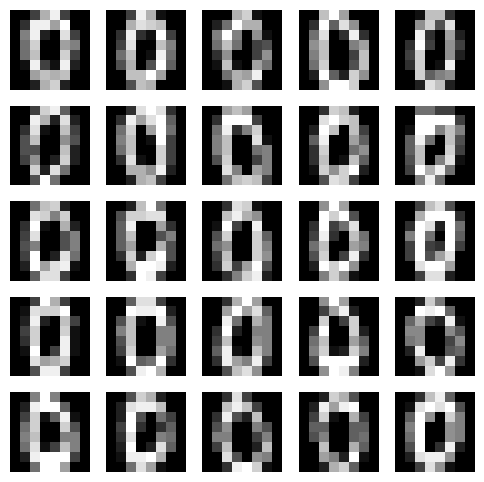

In [56]:
dataset = DigitsDataset(
    csv_file="D:\helpers\optdigits_csv (1).csv",
    label=0,
    transform=transforms.Compose([transforms.ToTensor()]),
)
sampler = RandomSampler(dataset, replacement=True, num_samples=25)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, drop_last=True, sampler=sampler
)

ax = plt.figure(figsize=(6, 6))
for index, image in enumerate(iter(dataloader)):
    plt.subplot(5, 5, index +   1)
    plt.imshow(image[0][0][0], cmap="gray")
    plt.axis("off")

In [75]:
def get_archstring(arch):
    return "".join([re.sub(r'[0-9]|\]|\[', '', s) for s in arch.copy()])

architectures = [
        ["var", "enc[2]", "var"],
        ["var", "var", "enc[2]", "var", "var"],
        ["var", "enc[1]", "var", "enc[3]", "var"],
        ["var", "var", "enc[1]", "var", "var", "enc[3]", "var", "var"],
        ["var", "enc[0]", "var", "enc[2]", "var", "enc[4]", "var"],
        ["var", "enc[1]", "var", "enc[3]", "var", "enc[5]", "var", "enc[7]", "var"],
]
archstrings = [get_archstring(s) for s in architectures]

In [ ]:
def plot_loss(loss_in, ax):
    
    arr = np.asarray(loss_in)
    ax.clear()

    if arr.size == 0:
        ax.text(0.5, 0.5, "No loss data", ha="center", va="center", transform=ax.transAxes)
        ax.set_title("Loss Evolution"); ax.set_xlabel("Iteration"); ax.set_ylabel("Loss Value")
        return

    if arr.ndim == 2:  # (steps,2)
        D = arr[:, 0] / 2.0
        G = arr[:, 1]
        ax.plot(D, label="D Loss")
        ax.plot(G, label="G Loss")
    elif arr.ndim == 3:  # (runs,steps,2)
        D = arr[:, :, 0] / 2.0
        G = arr[:, :, 1]
        ax.plot(D.T, alpha=0.15, lw=1)
        ax.plot(G.T, alpha=0.15, lw=1)
        ax.plot(D.mean(axis=0), label="D Loss (mean)", lw=2)
        ax.plot(G.mean(axis=0), label="G Loss (mean)", lw=2)
    else:
        ax.text(0.5, 0.5, f"Unexpected loss shape: {arr.shape}", ha="center", va="center", transform=ax.transAxes)

    ax.set_title("Loss Evolution")
    ax.set_xlabel("Iteration"); ax.set_ylabel("Loss Value"); ax.legend()

In [ ]:
def _autocontrast_row(v, eps=1e-6, tol=5e-3):
    x = np.asarray(v, dtype=np.float32)
    x = np.nan_to_num(x, nan=0.0, posinf=1.0, neginf=0.0)
    # light squash if clearly outside [0,1]
    if x.min() < 0.0 or x.max() > 1.0:
        x = 1.0 / (1.0 + np.exp(-x))
    x_min, x_max = float(x.min()), float(x.max())
    span = x_max - x_min
    if span >= tol:
        y = (x - x_min) / max(span, eps)
    else:
        xc  = x - x.mean()
        std = float(xc.std())
        y   = (xc / max(std, eps)) * 0.15 + 0.5
    return np.clip(y, 0.0, 1.0)

def _autocontrast_rows(arr):
    if arr.size == 0: return arr
    return np.stack([_autocontrast_row(r) for r in np.asarray(arr)], axis=0)

def _render_from_fake(fake_arr, axes):
    if fake_arr is None or fake_arr.size == 0 or len(axes) == 0:
        for ax in axes: ax.axis("off")
        return
    arr = np.asarray(fake_arr)
    if arr.ndim != 2:
        arr = arr.reshape(-1, arr.shape[-1])
    steps, pixels = arr.shape
    k = len(axes)
    idxs = np.linspace(max(1, steps // 3), steps, num=k, endpoint=True, dtype=int) - 1
    idxs = np.clip(np.unique(idxs), 0, steps - 1)
    if len(idxs) < k:
        idxs = np.pad(idxs, (0, k - len(idxs)), mode="edge")
    for ax, t in zip(axes, idxs):
        img = _autocontrast_row(arr[t])
        img8 = np.clip(img * 255.0, 0, 255).astype(np.uint8).reshape(8, 8)
        ax.imshow(img8, cmap="gray"); ax.axis("off")

In [ ]:


def plot_progress(fake_runs, axes):
 
    arr = np.asarray(fake_runs)

    # clear axes
    for ax in axes:
        ax.clear()
        ax.axis("off")

    if arr.size == 0 or len(axes) == 0:
        return

    # unify to (runs, steps, pixels)
    if arr.ndim == 2:          # single run
        arr = arr[None, ...]   # -> (1, steps, pixels)
    elif arr.ndim != 3:
        axes[0].text(0.5, 0.5, f"Unexpected shape: {arr.shape}",
                     ha="center", va="center", transform=axes[0].transAxes)
        return

    runs, steps, pixels = arr.shape

    # optional smoothing like your original code
    if steps >= 4:
        chunks = [arr[:, i::4, :] for i in range(4)]              # list of (runs, ceil(steps/4), pixels)
        fake_mean = np.mean(np.mean(np.array(chunks), axis=0), axis=0)  # -> (ceil(steps/4), pixels)
    else:
        fake_mean = arr.mean(axis=0)  # (steps, pixels)

    steps2 = fake_mean.shape[0]
    k = len(axes)

    # choose exactly k evenly spaced snapshot indices
    idxs = np.linspace(1, steps2, num=k, endpoint=True, dtype=int) - 1
    idxs = np.clip(np.unique(idxs), 0, steps2 - 1)
    if len(idxs) < k:  # pad if uniq collapsed
        idxs = np.pad(idxs, (0, k - len(idxs)), mode="edge")

    for ax, t in zip(axes, idxs):
        img = _autocontrast_row(fake_mean[t])  # (pixels,) in [0,1]
        img8 = np.clip(img * 255.0, 0, 255).astype(np.uint8).reshape(8, 8)
        ax.imshow(img8, cmap="gray")
        ax.set_title(f"Iter {t}", fontsize=10)
        ax.axis("off")

    # row title
    axes[0].text(0.0, 1.10, "Image Evolution",
                 transform=axes[0].transAxes, ha="left", va="bottom", fontsize=12)




In [119]:
def plot_results(params_runs, config, axes, best_run=None):
    """
    params_runs: list of arrays; each item is either
        - shape (T, P) over time -> we use the last row, or
        - shape (P,) a single param vector
    axes: list of matplotlib axes to draw into
    best_run: optional index of the run to visualize for ALL axes
    """
    import numpy as np
    import torch
    import perceval as pcvl

    # --- Clear axes if any
    if not axes:
        return
    for ax in axes:
        ax.clear(); ax.axis("off")

    if not params_runs:
        axes[0].set_title("Generated Images", fontsize=14, pad=10)
        return

    # --- Build a fresh QGAN and put on device
    qgan = QGAN(
        image_size=8,
        gen_count=config["gen_count"],
        gen_arch=config["arch"],
        input_state=pcvl.BasicState(config["input_state"]),
        noise_dim=config["noise_dim"],
        batch_size=4,
        pnr=config["pnr"],
        lossy=False,
    )
    qgan.G.eval()

    # Helper: set params into generator even if update_var_params isn't provided
    def _apply_params_to_G(vec):
        if hasattr(qgan.G, "update_var_params"):
            qgan.G.update_var_params(vec)
            return True
        # Try to push into each sublayer.theta if lengths match
        if hasattr(qgan.G, "layers"):
            thetas = [getattr(L, "theta", None) for L in qgan.G.layers]
            flat_thetas = [t.view(-1) for t in thetas if isinstance(t, torch.Tensor)]
            total = sum(t.numel() for t in flat_thetas)
            v = torch.as_tensor(vec, dtype=torch.float32, device=qgan.device)
            if v.numel() == total:
                offset = 0
                for t in thetas:
                    if isinstance(t, torch.Tensor):
                        n = t.numel()
                        t.data.copy_(v[offset:offset+n].view_as(t))
                        offset += n
                return True
        return False

    # --- Generate samples for each run
    device = qgan.device
    num_axes = len(axes)
    final_results = []  # list of (num_axes, 64)
    for params in params_runs:
        p = np.asarray(params)
        p = p[-1] if p.ndim == 2 else p  # last snapshot if (T,P)

        _apply_params_to_G(p)

        # New noise per axis for diversity
        z = torch.randn(num_axes, qgan.latent_dim, device=device)
        with torch.no_grad():
            # G returns (-1,1); map to [0,1] for display
            out = qgan.G(z)                                # (N, 64) in (-1,1)
            out01 = ((out + 1.0) * 0.5).clamp(0.0, 1.0)    # [0,1]
            final_results.append(out01.cpu().numpy())

    final_arr = np.stack(final_results, axis=0)  # (runs, num_axes, 64)

    # --- Choose what to show per axis
    rng = np.random.default_rng()
    for i, ax in enumerate(axes):
        if best_run is not None and 0 <= best_run < final_arr.shape[0]:
            run_idx = best_run
        else:
            # pick a different run per axis (no averaging → more variety)
            run_idx = rng.integers(0, final_arr.shape[0])
        image_flat = final_arr[run_idx, i, :]  # (64,)
        img = (np.clip(image_flat, 0.0, 1.0) * 255.0).astype(np.uint8).reshape(8, 8)
        ax.imshow(img, cmap="gray", vmin=0, vmax=255)
        ax.axis("off")

    axes[0].set_title("Generated Images", fontsize=14, pad=10)


In [120]:
from numpy.random import default_rng

varencvar


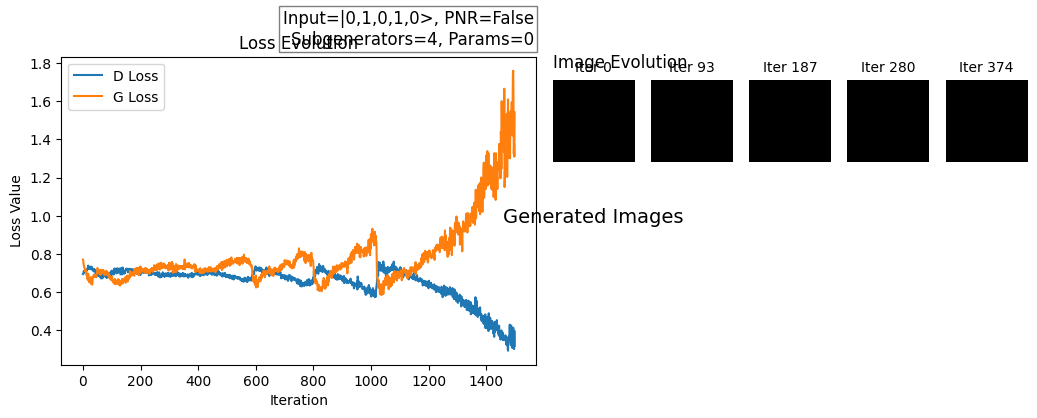

varvarencvarvar


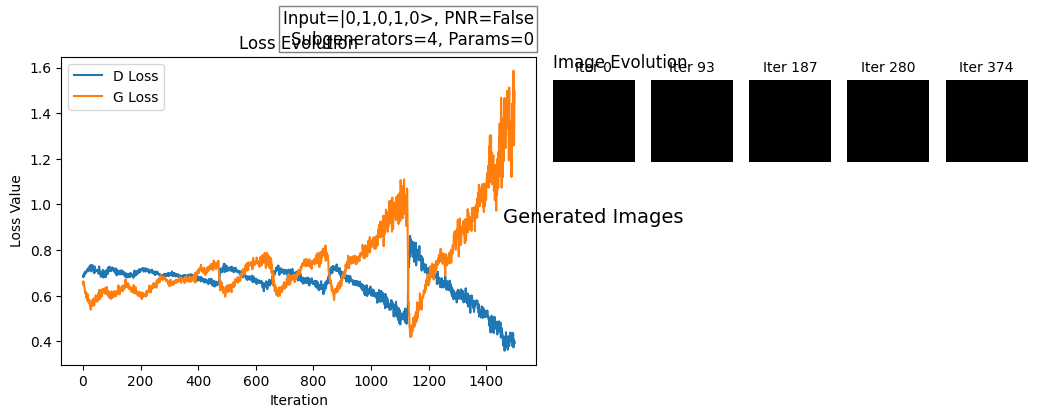

varencvarencvar


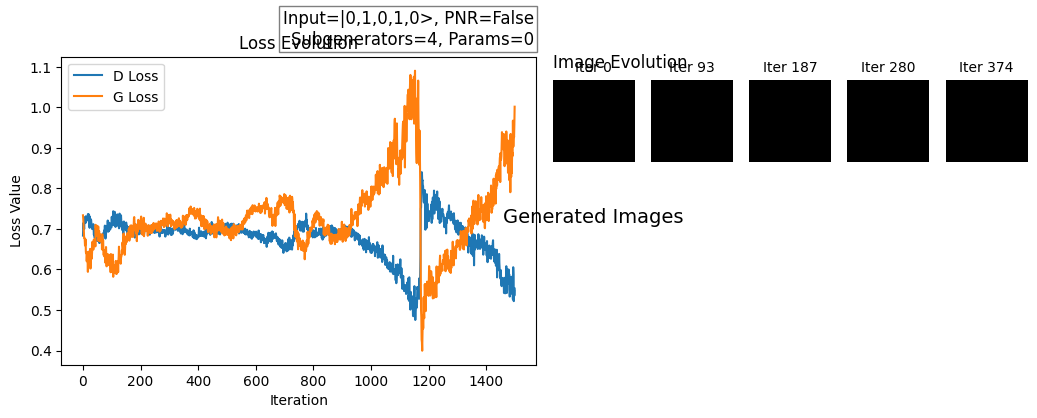

varvarencvarvarencvarvar
varencvarencvarencvar
varencvarencvarencvarencvar


In [121]:
#RUN = 1  # fixed

for archstring in archstrings:
    print(archstring)
    for config_num in range(3):
        config_path = os.path.join(path, f"config_{config_num}")
        with open(os.path.join(config_path, "config.json")) as c:
            config = json.load(c)

        if get_archstring(config["arch"]) != archstring:
            continue

        full_path   = os.path.join(path, f"config_{config_num}", f"run_{RUN}")
        loss_file   = os.path.join(full_path, "loss_progress.csv")
        fake_file   = os.path.join(full_path, "fake_progress.csv")
        params_file = os.path.join(full_path, "G_params_progress.csv")

        loss_data   = np.loadtxt(loss_file, delimiter=",", skiprows=1) if os.path.exists(loss_file) else np.empty((0,))
        fake_data   = np.loadtxt(fake_file, delimiter=",")            if os.path.exists(fake_file) else np.empty((0,))
        params_data = np.loadtxt(params_file, delimiter=",")          if os.path.exists(params_file) else None

        fig = plt.figure(figsize=(15, 4))
        gs = fig.add_gridspec(2, 12)
        loss_ax   = fig.add_subplot(gs[:, :5])
        prog_axes = [fig.add_subplot(gs[0, 5+i]) for i in range(5)]
        res_axes  = [fig.add_subplot(gs[1, 5+i]) for i in range(5)]

        # loss: pass 2D if single run; otherwise stack if you ever add more runs
        plot_loss(loss_data, loss_ax)

        # progress: expects 2D (steps,pixels) or 3D; we have 2D for run=1
        plot_progress(fake_data, prog_axes)

        # generated images
        params_list = [params_data] if params_data is not None else []
        plot_results(params_list, config, res_axes, best_run=0 if params_list else None)

        n_params = (params_data.shape[-1]) if params_data is not None else 0
        configinfo = (
            f"Input={pcvl.BasicState(config['input_state'])}, PNR={config['pnr']}\n"
            f"Subgenerators={config['gen_count']}, Params={n_params}"
        )
        loss_ax.text(
            x=0.995, y=1.04, s=configinfo, ha="right",
            bbox=dict(boxstyle='square, pad=0.2', facecolor='white', alpha=0.5),
            transform=loss_ax.transAxes, fontsize=12
        )

        plt.subplots_adjust(hspace=0.4)

    plt.show()



varencvar


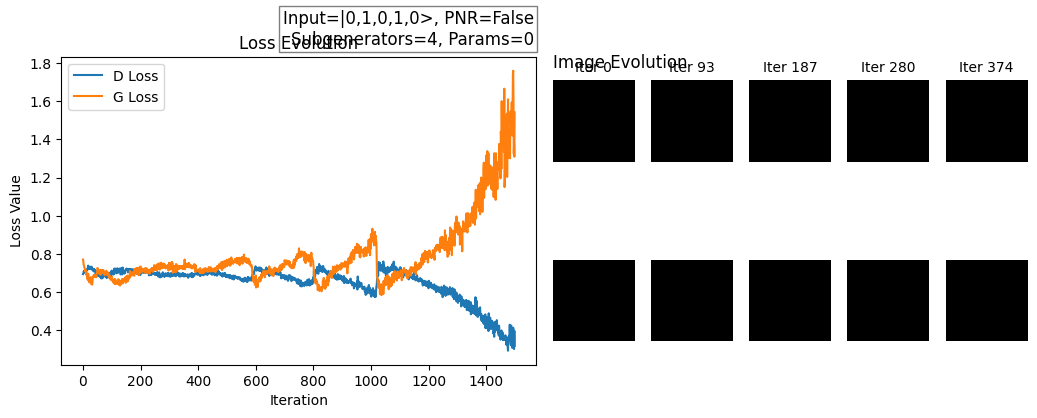

varvarencvarvar


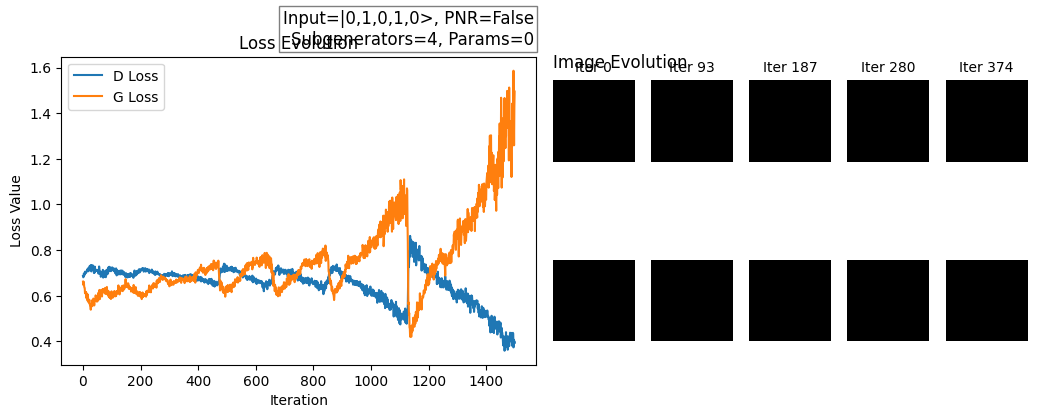

varencvarencvar


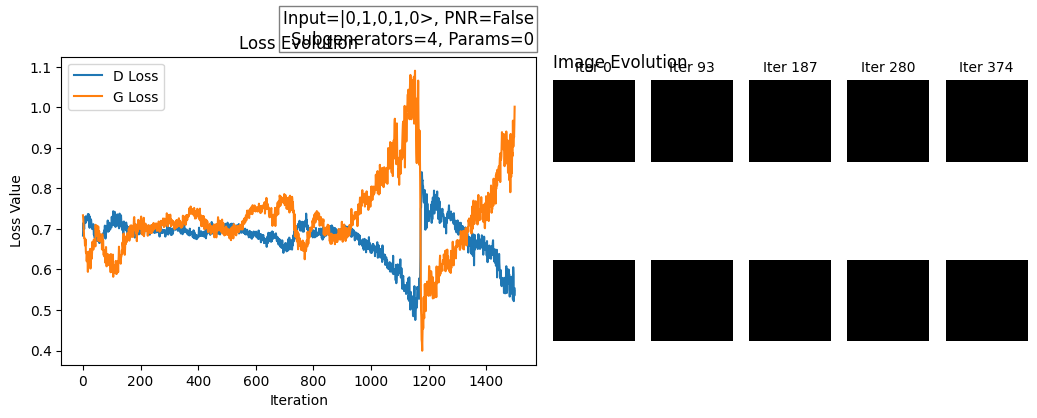

varvarencvarvarencvarvar
varencvarencvarencvar
varencvarencvarencvarencvar


In [122]:
RUN = 1  # fixed

for archstring in archstrings:
    print(archstring)
    for config_num in range(3):
        config_path = os.path.join(path, f"config_{config_num}")
        with open(os.path.join(config_path, "config.json")) as c:
            config = json.load(c)

        if get_archstring(config["arch"]) != archstring:
            continue

        full_path   = os.path.join(path, f"config_{config_num}", f"run_{RUN}")
        loss_file   = os.path.join(full_path, "loss_progress.csv")
        fake_file   = os.path.join(full_path, "fake_progress.csv")
        params_file = os.path.join(full_path, "G_params_progress.csv")

        # --- load (single run) ---
        loss_data   = np.loadtxt(loss_file, delimiter=",", skiprows=1) if os.path.exists(loss_file) else np.empty((0, 2))
        fake_data   = np.loadtxt(fake_file, delimiter=",")            if os.path.exists(fake_file) else np.empty((0, 64))
        params_data = np.loadtxt(params_file, delimiter=",")          if os.path.exists(params_file) else None

        # --- normalize shapes defensively ---
        if loss_data.ndim == 1 and loss_data.size >= 2:
            loss_data = loss_data[None, :]  # (1,2)

        if fake_data.ndim == 1:
            fake_data = fake_data[None, :]
        # force to 64 pixels (8x8) when possible
        if fake_data.size and fake_data.shape[1] != 64 and (fake_data.size % 64 == 0):
            steps = fake_data.shape[0]
            fake_data = fake_data.reshape(steps, -1)[:, :64]

        if params_data is not None and params_data.ndim == 1:
            params_data = params_data[None, :]  # (1,P)

        # --- figure & axes ---
        fig = plt.figure(figsize=(15, 4))
        gs = fig.add_gridspec(2, 12)
        loss_ax   = fig.add_subplot(gs[:, :5])
        prog_axes = [fig.add_subplot(gs[0, 5+i]) for i in range(5)]
        res_axes  = [fig.add_subplot(gs[1, 5+i]) for i in range(5)]

        # loss: pass 2D for single run
        plot_loss(loss_data, loss_ax)

        # progress: auto-contrast frames before plotting so they aren't black
        ac_fake = _autocontrast_rows(fake_data) if fake_data.size else fake_data
        plot_progress(ac_fake, prog_axes)

        # generated images:
        params_list = [params_data] if params_data is not None else []
        if params_list and params_list[0] is not None and params_list[0].size:
            # try your original plot_results first (if it regenerates from params)
            try:
                plot_results(params_list, config, res_axes, best_run=0)
            except Exception:
                # fallback to saved fakes if regeneration fails
                _render_from_fake(ac_fake, res_axes)
        else:
            # no params saved (Params=0) -> show saved fakes (auto-contrasted)
            _render_from_fake(ac_fake, res_axes)

        n_params = (params_data.shape[-1]) if params_data is not None else 0
        configinfo = (
            f"Input={pcvl.BasicState(config['input_state'])}, PNR={config['pnr']}\n"
            f"Subgenerators={config['gen_count']}, Params={n_params}"
        )
        loss_ax.text(
            x=0.995, y=1.04, s=configinfo, ha="right",
            bbox=dict(boxstyle='square, pad=0.2', facecolor='white', alpha=0.5),
            transform=loss_ax.transAxes, fontsize=12
        )

        plt.subplots_adjust(hspace=0.4)

    plt.show()

In [109]:
def plot_loss(loss_data, ax):
    D_loss = loss_data[:, 0] / 2
    G_loss = loss_data[:, 1]
    ax.plot(D_loss, label="D Loss")
    ax.plot(G_loss, label="G Loss")
    ax.set_title("Loss Evolution")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss Value")
    ax.legend()